# VGGish - Speech Commands - Warm Start

**Approach 3: Fine-Tuning the Entire Network (End-to-End Training)**

This notebook implements the **warm start** (fine-tuning) approach: we load the pre-trained VGGish weights as initialization but make the **entire network trainable**, allowing all layers -- including VGGish's convolutional backbone -- to adapt to our speech command data.

**Key difference from transfer learning:** The single change is `define_vggish_slim(training=True)` instead of `training=False`. This unfreezes all VGGish weights, enabling end-to-end backpropagation through the full network.

**Architecture (identical to transfer learning):**
```
[Trainable VGGish] → fc1 (4096-dim, trainable) → FC layer (500 units, trainable) → Logits (35 classes, trainable) → Softmax
```

**Approach comparison:**
| Approach | VGGish Weights | Accuracy | Training Time |
|----------|---------------|----------|---------------|
| Feature Extraction | Frozen | ~18.4% | 3 min (CPU) |
| Transfer Learning | Frozen | ~30.4% | 28 min (GPU) |
| **Warm Start** (this notebook) | **Unfrozen (fine-tuned)** | **~96.6%** | 1h 20min (GPU) |

**Result:** ~96.6% accuracy -- a dramatic improvement. By allowing the convolutional layers to adapt their learned features from general audio events to speech-specific patterns, the network achieves near-human performance on this task. The pre-trained weights provide an excellent initialization, enabling faster convergence and better final accuracy than training from scratch.

## Setup and Imports

Import TensorFlow (v1 compatibility mode), TF-Slim for building layers, and the VGGish library. This notebook was run on an AWS EC2 p3.2xlarge instance with a single NVIDIA Tesla V100-SXM2-16GB GPU.

In [1]:
import sys
sys.path.append("/home/ubuntu/odsc/vggish/lib/models/research/audioset/vggish")

In [2]:
import pandas as pd


In [3]:
import vggish_params
vggish_params.EXAMPLE_HOP_SECONDS, vggish_params.EXAMPLE_WINDOW_SECONDS

(0.96, 0.96)

In [4]:
import numpy as np
import six
import soundfile
import random
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import tf_slim as slim

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Instructions for updating:
non-resource variables are not supported in the long term
Num GPUs Available:  1


In [5]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

['/device:GPU:0']

In [6]:

import vggish_input
import vggish_postprocess
import vggish_slim

pca_params = '/home/ubuntu/odsc/vggish/lib/vggish_pca_params.npz'
ckpt = '/home/ubuntu/odsc/vggish/lib/vggish_model.ckpt'

In [7]:
df = pd.read_csv('wavfile_df.csv', index_col=0)
df.shape

(105835, 3)

## Loading and Preparing Spectrograms

Load the pre-generated spectrograms from Step 1. After removing invalid entries, we have 96,826 valid samples across 35 word classes. Labels are one-hot encoded, and data is split 90/10 (train/test) with stratification.

In [8]:
with open('wavfile_spec.dat', 'rb') as f:
    audio_data = np.fromfile(f)

In [9]:
audio_array = audio_data.reshape((-1, 96, 64))
audio_array.shape, df.shape

((105835, 96, 64), (105835, 3))

In [10]:
# Drop invalid spectograms
invalid_ind = df[~df['valid']].index

In [11]:
valid_audio = np.delete(audio_array, invalid_ind, axis=0)
valid_audio.shape

(96826, 96, 64)

In [12]:
df = df[df.valid]
df.shape

(96826, 3)

In [13]:
num_classes = len(df.label.unique())
num_classes, df['label'].value_counts()

(35,
 zero        3793
 five        3779
 yes         3743
 seven       3713
 nine        3672
 six         3632
 down        3627
 stop        3602
 no          3599
 two         3579
 left        3550
 one         3542
 go          3528
 on          3522
 right       3483
 off         3473
 eight       3472
 four        3460
 three       3452
 up          3322
 marvin      1884
 house       1872
 dog         1869
 wow         1847
 happy       1811
 sheila      1800
 bird        1792
 cat         1758
 bed         1732
 backward    1567
 tree        1513
 visual      1476
 follow      1463
 forward     1462
 learn       1437
 Name: label, dtype: int64)

In [14]:
del(audio_data, audio_array)

In [15]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder()
all_labels = one_hot_encoder.fit_transform(df.label.to_numpy().reshape(-1, 1)).todense()

In [16]:
from sklearn.model_selection import train_test_split

audio_train, audio_test, labels_train, labels_test = \
        train_test_split(valid_audio, all_labels, test_size=0.1, stratify=df.label)

In [17]:
del(all_labels, valid_audio)

### Batching

Split the training data into 500 batches (~174 samples each) for mini-batch gradient descent.

In [19]:
audio_train.shape, audio_test.shape, labels_train.shape, labels_test.shape

((87143, 96, 64), (9683, 96, 64), (87143, 35), (9683, 35))

## Building the Warm Start Model

This section is nearly identical to the transfer learning notebook, with one crucial difference:

**`define_vggish_slim(training=True)`** -- This makes **all** VGGish weights trainable. During backpropagation, gradients flow through the entire network, allowing the convolutional filters to adapt from general audio features to speech-specific features.

**What "warm start" means:** Instead of initializing all weights randomly (cold start) or freezing pre-trained weights (transfer learning), we initialize with the pre-trained AudioSet weights and then **continue training** (fine-tuning) all of them on our task-specific data. The pre-trained weights serve as a warm starting point, giving the optimizer a head start compared to random initialization.

**Architecture (same as transfer learning):**
1. VGGish convolutional backbone → fc1 (4096-dim) -- **now trainable**
2. New FC layer (500 units, ReLU) -- trainable
3. New logits layer (35 units) -- trainable
4. Softmax output

**Training configuration:** Same Adam optimizer, learning rate, and loss function as the transfer learning notebook. The only difference is the number of trainable parameters -- the warm start model trains ~62M+ parameters (the entire VGGish network plus the new layers), compared to just the new layers in transfer learning.

## Training Loop

Train for 200 epochs x 500 batches (100,000 total gradient updates) -- the same training schedule as transfer learning. However, since gradients now flow through the entire network, each step takes longer.

Training completed in ~1 hour 20 minutes on a single Tesla V100 GPU (vs. 28 minutes for transfer learning). The additional compute cost is due to backpropagating through VGGish's deep convolutional stack.

In [20]:
num_batches = 500

## Evaluation

Generate predictions on the test set (processed in 20 batches to manage GPU memory).

In [21]:
audio_train_batches = np.array_split(audio_train, num_batches, axis=0)
labels_train_batches = np.array_split(labels_train, num_batches, axis=0)

In [22]:
# sess.close()

In [23]:
g = tf.Graph()
sess = tf.Session(graph=g)

with g.as_default():
    # Define VGGish.
    embeddings = vggish_slim.define_vggish_slim(training=True)
   
    # Grab last layer of network before compression to embeddings
    vggish_fc1 = sess.graph.get_tensor_by_name('vggish/fc1/fc1_2/Relu:0')
    
    # Define a shallow classification model and associated training ops on top
    # of VGGish.
    with tf.variable_scope('mymodel'):
      # Add fully connected layer with 500 units.
        num_units = 500
        fc1 = slim.fully_connected(vggish_fc1, num_units)

        # Add a classifier layer at the end, consisting of parallel logistic
        # classifiers, one per class. This allows for multi-class tasks.
        logits = slim.fully_connected(
          fc1, num_classes, activation_fn=None, scope='logits')
        
        # Add softmax output layer for classification
        tf.nn.softmax(logits, name='prediction')
        
        prediction_tensor = sess.graph.get_tensor_by_name('mymodel/prediction:0')

      # Add training ops.
        with tf.variable_scope('train'):
            global_step = tf.Variable(
                0, name='global_step', trainable=False,
                collections=[tf.GraphKeys.GLOBAL_VARIABLES,
                             tf.GraphKeys.GLOBAL_STEP])

            # Labels are assumed to be fed as a batch multi-hot vectors, with
            # a 1 in the position of each positive class label, and 0 elsewhere.
            labels = tf.placeholder(
                tf.float32, shape=(None, num_classes), name='labels')

            # Cross-entropy label loss.
            xent = tf.nn.softmax_cross_entropy_with_logits(
                logits=logits, labels=labels, name='xent')
            loss = tf.reduce_mean(xent, name='loss_op')
            tf.summary.scalar('loss', loss)

            # We use the same optimizer and hyperparameters as used to train VGGish.
            optimizer = tf.train.AdamOptimizer(
                learning_rate=vggish_params.LEARNING_RATE,
                epsilon=vggish_params.ADAM_EPSILON)
            optimizer.minimize(loss, global_step=global_step, name='train_op')

    # Initialize all variables in the model, and then load the pre-trained
    # VGGish checkpoint.
    sess.run(tf.global_variables_initializer())
    vggish_slim.load_vggish_slim_checkpoint(sess, ckpt)

    # Locate all the tensors and ops we need for the training loop.
    features_tensor = sess.graph.get_tensor_by_name(
        vggish_params.INPUT_TENSOR_NAME)
    labels_tensor = sess.graph.get_tensor_by_name('mymodel/train/labels:0')
    global_step_tensor = sess.graph.get_tensor_by_name(
        'mymodel/train/global_step:0')
    loss_tensor = sess.graph.get_tensor_by_name('mymodel/train/loss_op:0')
    train_op = sess.graph.get_operation_by_name('mymodel/train/train_op')

Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

INFO:tensorflow:Restoring parameters from /home/ubuntu/odsc/vggish/lib/vggish_model.ckpt


In [24]:
%%time

# The training loop.
for _ in range(200):
    for i in range(num_batches):
        labels = labels_train_batches[i]
        features = audio_train_batches[i]

        [num_steps, loss, _] = sess.run(
          [global_step_tensor, loss_tensor, train_op],
          feed_dict={features_tensor: features, labels_tensor: labels})
        print('Step %d: loss %g' % (num_steps, loss))


Step 1: loss 3.55472
Step 2: loss 3.56273
Step 3: loss 3.56163
Step 4: loss 3.55823
Step 5: loss 3.5586
Step 6: loss 3.55555
Step 7: loss 3.53953
Step 8: loss 3.54964
Step 9: loss 3.52717
Step 10: loss 3.54075
Step 11: loss 3.55542
Step 12: loss 3.54074
Step 13: loss 3.52636
Step 14: loss 3.51415
Step 15: loss 3.53063
Step 16: loss 3.50632
Step 17: loss 3.52181
Step 18: loss 3.50692
Step 19: loss 3.52799
Step 20: loss 3.52689
Step 21: loss 3.50876
Step 22: loss 3.47936
Step 23: loss 3.50993
Step 24: loss 3.49485
Step 25: loss 3.49709
Step 26: loss 3.51331
Step 27: loss 3.50729
Step 28: loss 3.5146
Step 29: loss 3.49708
Step 30: loss 3.45688
Step 31: loss 3.47579
Step 32: loss 3.48394
Step 33: loss 3.47788
Step 34: loss 3.47874
Step 35: loss 3.44763
Step 36: loss 3.48841
Step 37: loss 3.44076
Step 38: loss 3.43519
Step 39: loss 3.45598
Step 40: loss 3.43
Step 41: loss 3.43067
Step 42: loss 3.45653
Step 43: loss 3.43818
Step 44: loss 3.4787
Step 45: loss 3.41631
Step 46: loss 3.38924
Ste

Step 359: loss 0.447947
Step 360: loss 0.365732
Step 361: loss 0.366583
Step 362: loss 0.356496
Step 363: loss 0.40356
Step 364: loss 0.365403
Step 365: loss 0.439353
Step 366: loss 0.488156
Step 367: loss 0.476384
Step 368: loss 0.417181
Step 369: loss 0.332848
Step 370: loss 0.438681
Step 371: loss 0.316102
Step 372: loss 0.53442
Step 373: loss 0.236441
Step 374: loss 0.488198
Step 375: loss 0.482607
Step 376: loss 0.322364
Step 377: loss 0.415565
Step 378: loss 0.435843
Step 379: loss 0.488504
Step 380: loss 0.240048
Step 381: loss 0.407676
Step 382: loss 0.309247
Step 383: loss 0.329718
Step 384: loss 0.369911
Step 385: loss 0.404848
Step 386: loss 0.273
Step 387: loss 0.525615
Step 388: loss 0.369116
Step 389: loss 0.367771
Step 390: loss 0.320485
Step 391: loss 0.317631
Step 392: loss 0.379428
Step 393: loss 0.363567
Step 394: loss 0.423355
Step 395: loss 0.497294
Step 396: loss 0.321566
Step 397: loss 0.452517
Step 398: loss 0.411181
Step 399: loss 0.47888
Step 400: loss 0.28899

Step 704: loss 0.245272
Step 705: loss 0.176115
Step 706: loss 0.188176
Step 707: loss 0.142574
Step 708: loss 0.225508
Step 709: loss 0.267903
Step 710: loss 0.226836
Step 711: loss 0.300771
Step 712: loss 0.262491
Step 713: loss 0.258708
Step 714: loss 0.289274
Step 715: loss 0.203149
Step 716: loss 0.165176
Step 717: loss 0.160247
Step 718: loss 0.278251
Step 719: loss 0.209025
Step 720: loss 0.228947
Step 721: loss 0.216383
Step 722: loss 0.233613
Step 723: loss 0.207937
Step 724: loss 0.206668
Step 725: loss 0.123184
Step 726: loss 0.126167
Step 727: loss 0.269211
Step 728: loss 0.159373
Step 729: loss 0.144577
Step 730: loss 0.230837
Step 731: loss 0.169042
Step 732: loss 0.2127
Step 733: loss 0.166013
Step 734: loss 0.123411
Step 735: loss 0.209989
Step 736: loss 0.154107
Step 737: loss 0.179109
Step 738: loss 0.180878
Step 739: loss 0.199451
Step 740: loss 0.277729
Step 741: loss 0.23448
Step 742: loss 0.234791
Step 743: loss 0.274644
Step 744: loss 0.207002
Step 745: loss 0.16

Step 1049: loss 0.209936
Step 1050: loss 0.164275
Step 1051: loss 0.189395
Step 1052: loss 0.190051
Step 1053: loss 0.177378
Step 1054: loss 0.143493
Step 1055: loss 0.148764
Step 1056: loss 0.174352
Step 1057: loss 0.151288
Step 1058: loss 0.156371
Step 1059: loss 0.179825
Step 1060: loss 0.117725
Step 1061: loss 0.166369
Step 1062: loss 0.0846294
Step 1063: loss 0.157044
Step 1064: loss 0.227274
Step 1065: loss 0.186806
Step 1066: loss 0.215848
Step 1067: loss 0.12628
Step 1068: loss 0.173083
Step 1069: loss 0.141815
Step 1070: loss 0.1643
Step 1071: loss 0.144745
Step 1072: loss 0.169828
Step 1073: loss 0.0944563
Step 1074: loss 0.1748
Step 1075: loss 0.13009
Step 1076: loss 0.311795
Step 1077: loss 0.132133
Step 1078: loss 0.166856
Step 1079: loss 0.181068
Step 1080: loss 0.0963124
Step 1081: loss 0.215776
Step 1082: loss 0.240436
Step 1083: loss 0.253355
Step 1084: loss 0.115446
Step 1085: loss 0.111467
Step 1086: loss 0.265509
Step 1087: loss 0.178037
Step 1088: loss 0.120075
Ste

Step 1379: loss 0.125523
Step 1380: loss 0.0439957
Step 1381: loss 0.090917
Step 1382: loss 0.0784409
Step 1383: loss 0.0999832
Step 1384: loss 0.0605514
Step 1385: loss 0.0704463
Step 1386: loss 0.0990591
Step 1387: loss 0.246413
Step 1388: loss 0.0789223
Step 1389: loss 0.114368
Step 1390: loss 0.0957334
Step 1391: loss 0.0821872
Step 1392: loss 0.097942
Step 1393: loss 0.0755445
Step 1394: loss 0.132634
Step 1395: loss 0.0942585
Step 1396: loss 0.0982798
Step 1397: loss 0.135292
Step 1398: loss 0.0931069
Step 1399: loss 0.124303
Step 1400: loss 0.0710234
Step 1401: loss 0.101622
Step 1402: loss 0.17883
Step 1403: loss 0.0852986
Step 1404: loss 0.10874
Step 1405: loss 0.213962
Step 1406: loss 0.0759583
Step 1407: loss 0.142592
Step 1408: loss 0.0913752
Step 1409: loss 0.0591028
Step 1410: loss 0.146368
Step 1411: loss 0.0944192
Step 1412: loss 0.0911652
Step 1413: loss 0.124323
Step 1414: loss 0.0945226
Step 1415: loss 0.151209
Step 1416: loss 0.111912
Step 1417: loss 0.104885
Step 1

Step 1704: loss 0.0647743
Step 1705: loss 0.0453475
Step 1706: loss 0.0710989
Step 1707: loss 0.0348055
Step 1708: loss 0.0867038
Step 1709: loss 0.0523623
Step 1710: loss 0.0486444
Step 1711: loss 0.110324
Step 1712: loss 0.0771062
Step 1713: loss 0.102491
Step 1714: loss 0.105607
Step 1715: loss 0.0899
Step 1716: loss 0.0320357
Step 1717: loss 0.0380845
Step 1718: loss 0.0722004
Step 1719: loss 0.0574166
Step 1720: loss 0.0971414
Step 1721: loss 0.120848
Step 1722: loss 0.0711082
Step 1723: loss 0.048719
Step 1724: loss 0.0784313
Step 1725: loss 0.0269928
Step 1726: loss 0.0636984
Step 1727: loss 0.140919
Step 1728: loss 0.0290984
Step 1729: loss 0.0378391
Step 1730: loss 0.0625853
Step 1731: loss 0.036247
Step 1732: loss 0.0694866
Step 1733: loss 0.0655225
Step 1734: loss 0.0463483
Step 1735: loss 0.0952417
Step 1736: loss 0.0456721
Step 1737: loss 0.0613904
Step 1738: loss 0.0846327
Step 1739: loss 0.0668864
Step 1740: loss 0.0652715
Step 1741: loss 0.0667882
Step 1742: loss 0.0910

Step 2024: loss 0.0157958
Step 2025: loss 0.027704
Step 2026: loss 0.0707469
Step 2027: loss 0.0869072
Step 2028: loss 0.0687348
Step 2029: loss 0.0819967
Step 2030: loss 0.0752203
Step 2031: loss 0.0243827
Step 2032: loss 0.0483453
Step 2033: loss 0.064354
Step 2034: loss 0.0393118
Step 2035: loss 0.0829849
Step 2036: loss 0.0766535
Step 2037: loss 0.149027
Step 2038: loss 0.0196765
Step 2039: loss 0.0632549
Step 2040: loss 0.039516
Step 2041: loss 0.0372671
Step 2042: loss 0.0438551
Step 2043: loss 0.110143
Step 2044: loss 0.13834
Step 2045: loss 0.100018
Step 2046: loss 0.0218109
Step 2047: loss 0.0258493
Step 2048: loss 0.0758082
Step 2049: loss 0.0979631
Step 2050: loss 0.0720709
Step 2051: loss 0.0686696
Step 2052: loss 0.101032
Step 2053: loss 0.10528
Step 2054: loss 0.0597508
Step 2055: loss 0.106139
Step 2056: loss 0.10741
Step 2057: loss 0.0283495
Step 2058: loss 0.0712602
Step 2059: loss 0.0683777
Step 2060: loss 0.0268356
Step 2061: loss 0.0951491
Step 2062: loss 0.039687
S

Step 2344: loss 0.0511827
Step 2345: loss 0.0547612
Step 2346: loss 0.0142475
Step 2347: loss 0.0240234
Step 2348: loss 0.0772821
Step 2349: loss 0.0707192
Step 2350: loss 0.0911478
Step 2351: loss 0.0405991
Step 2352: loss 0.0774784
Step 2353: loss 0.062932
Step 2354: loss 0.0640321
Step 2355: loss 0.0518328
Step 2356: loss 0.0339637
Step 2357: loss 0.0523309
Step 2358: loss 0.0465891
Step 2359: loss 0.0732675
Step 2360: loss 0.0747123
Step 2361: loss 0.0704649
Step 2362: loss 0.0667349
Step 2363: loss 0.078027
Step 2364: loss 0.0226521
Step 2365: loss 0.0596189
Step 2366: loss 0.0760944
Step 2367: loss 0.0323919
Step 2368: loss 0.0316832
Step 2369: loss 0.0176853
Step 2370: loss 0.0860008
Step 2371: loss 0.054884
Step 2372: loss 0.0866432
Step 2373: loss 0.0680725
Step 2374: loss 0.0792445
Step 2375: loss 0.0335491
Step 2376: loss 0.0410253
Step 2377: loss 0.0742332
Step 2378: loss 0.0238795
Step 2379: loss 0.0139735
Step 2380: loss 0.0356822
Step 2381: loss 0.0554277
Step 2382: loss

Step 2664: loss 0.0359564
Step 2665: loss 0.057179
Step 2666: loss 0.0108697
Step 2667: loss 0.0428211
Step 2668: loss 0.0484955
Step 2669: loss 0.0327855
Step 2670: loss 0.0579907
Step 2671: loss 0.0470286
Step 2672: loss 0.0610735
Step 2673: loss 0.0190882
Step 2674: loss 0.0407016
Step 2675: loss 0.0148846
Step 2676: loss 0.0379153
Step 2677: loss 0.0488516
Step 2678: loss 0.0205218
Step 2679: loss 0.0301983
Step 2680: loss 0.0250668
Step 2681: loss 0.0188833
Step 2682: loss 0.0555619
Step 2683: loss 0.026971
Step 2684: loss 0.0476242
Step 2685: loss 0.0410763
Step 2686: loss 0.0291988
Step 2687: loss 0.0247953
Step 2688: loss 0.0247559
Step 2689: loss 0.0509251
Step 2690: loss 0.0304187
Step 2691: loss 0.0604127
Step 2692: loss 0.0215487
Step 2693: loss 0.029176
Step 2694: loss 0.014072
Step 2695: loss 0.0523748
Step 2696: loss 0.0512749
Step 2697: loss 0.0436222
Step 2698: loss 0.0172549
Step 2699: loss 0.0355997
Step 2700: loss 0.0747809
Step 2701: loss 0.0329322
Step 2702: loss 

Step 2984: loss 0.107268
Step 2985: loss 0.0390928
Step 2986: loss 0.0346624
Step 2987: loss 0.0582799
Step 2988: loss 0.0204136
Step 2989: loss 0.0243238
Step 2990: loss 0.0318035
Step 2991: loss 0.0690386
Step 2992: loss 0.0379589
Step 2993: loss 0.00652249
Step 2994: loss 0.0424278
Step 2995: loss 0.0440618
Step 2996: loss 0.0321505
Step 2997: loss 0.0233925
Step 2998: loss 0.0151071
Step 2999: loss 0.0206558
Step 3000: loss 0.0326094
Step 3001: loss 0.0380505
Step 3002: loss 0.0378602
Step 3003: loss 0.0139532
Step 3004: loss 0.00945804
Step 3005: loss 0.0201628
Step 3006: loss 0.0188086
Step 3007: loss 0.0522498
Step 3008: loss 0.0410078
Step 3009: loss 0.0368042
Step 3010: loss 0.0409725
Step 3011: loss 0.0378083
Step 3012: loss 0.0914584
Step 3013: loss 0.0323585
Step 3014: loss 0.0562602
Step 3015: loss 0.0121839
Step 3016: loss 0.00634959
Step 3017: loss 0.00927491
Step 3018: loss 0.0276062
Step 3019: loss 0.0453406
Step 3020: loss 0.0501567
Step 3021: loss 0.054355
Step 3022:

Step 3299: loss 0.0428288
Step 3300: loss 0.0312863
Step 3301: loss 0.0152576
Step 3302: loss 0.0130787
Step 3303: loss 0.044989
Step 3304: loss 0.0186374
Step 3305: loss 0.0474038
Step 3306: loss 0.0120637
Step 3307: loss 0.0218938
Step 3308: loss 0.0297854
Step 3309: loss 0.0143154
Step 3310: loss 0.0437515
Step 3311: loss 0.0253207
Step 3312: loss 0.0190683
Step 3313: loss 0.0131044
Step 3314: loss 0.0199852
Step 3315: loss 0.0145218
Step 3316: loss 0.0291754
Step 3317: loss 0.0179835
Step 3318: loss 0.00301476
Step 3319: loss 0.0162432
Step 3320: loss 0.00611668
Step 3321: loss 0.0367741
Step 3322: loss 0.0197875
Step 3323: loss 0.00316008
Step 3324: loss 0.0174678
Step 3325: loss 0.0201473
Step 3326: loss 0.00882999
Step 3327: loss 0.0184058
Step 3328: loss 0.0057591
Step 3329: loss 0.0405474
Step 3330: loss 0.0200776
Step 3331: loss 0.02391
Step 3332: loss 0.00709836
Step 3333: loss 0.0232797
Step 3334: loss 0.039506
Step 3335: loss 0.0319036
Step 3336: loss 0.0064026
Step 3337: 

Step 3614: loss 0.0350362
Step 3615: loss 0.0147001
Step 3616: loss 0.0108952
Step 3617: loss 0.0448625
Step 3618: loss 0.00577543
Step 3619: loss 0.0326096
Step 3620: loss 0.0140571
Step 3621: loss 0.00942262
Step 3622: loss 0.0407987
Step 3623: loss 0.0796372
Step 3624: loss 0.0277479
Step 3625: loss 0.0151537
Step 3626: loss 0.0619711
Step 3627: loss 0.0265761
Step 3628: loss 0.00999014
Step 3629: loss 0.00809835
Step 3630: loss 0.0079361
Step 3631: loss 0.0208808
Step 3632: loss 0.0214468
Step 3633: loss 0.0115647
Step 3634: loss 0.0147649
Step 3635: loss 0.0752326
Step 3636: loss 0.031564
Step 3637: loss 0.0418023
Step 3638: loss 0.00135634
Step 3639: loss 0.00672239
Step 3640: loss 0.0110668
Step 3641: loss 0.00299691
Step 3642: loss 0.0163247
Step 3643: loss 0.0138866
Step 3644: loss 0.0278799
Step 3645: loss 0.0361208
Step 3646: loss 0.0123475
Step 3647: loss 0.00276434
Step 3648: loss 0.0015412
Step 3649: loss 0.0189635
Step 3650: loss 0.0043349
Step 3651: loss 0.00910822
Step

Step 3929: loss 0.0295129
Step 3930: loss 0.0256851
Step 3931: loss 0.00939339
Step 3932: loss 0.0173317
Step 3933: loss 0.0138873
Step 3934: loss 0.0331997
Step 3935: loss 0.0234273
Step 3936: loss 0.0284795
Step 3937: loss 0.0145994
Step 3938: loss 0.024513
Step 3939: loss 0.011037
Step 3940: loss 0.0346148
Step 3941: loss 0.00144741
Step 3942: loss 0.00305294
Step 3943: loss 0.00579341
Step 3944: loss 0.0141822
Step 3945: loss 0.00292034
Step 3946: loss 0.00895314
Step 3947: loss 0.0150115
Step 3948: loss 0.0258024
Step 3949: loss 0.023972
Step 3950: loss 0.00246893
Step 3951: loss 0.00804006
Step 3952: loss 0.000640524
Step 3953: loss 0.0218048
Step 3954: loss 0.00179508
Step 3955: loss 0.0158176
Step 3956: loss 0.0234355
Step 3957: loss 0.0194216
Step 3958: loss 0.00857982
Step 3959: loss 0.0102068
Step 3960: loss 0.0208717
Step 3961: loss 0.0289792
Step 3962: loss 0.0190549
Step 3963: loss 0.00314203
Step 3964: loss 0.00801291
Step 3965: loss 0.00115153
Step 3966: loss 0.0049341


Step 4244: loss 0.00428917
Step 4245: loss 0.00932707
Step 4246: loss 0.0154753
Step 4247: loss 0.00831596
Step 4248: loss 0.0051314
Step 4249: loss 0.0127884
Step 4250: loss 0.0015994
Step 4251: loss 0.00113603
Step 4252: loss 0.00751864
Step 4253: loss 0.00283408
Step 4254: loss 0.0116205
Step 4255: loss 0.0222279
Step 4256: loss 0.0157501
Step 4257: loss 0.0142013
Step 4258: loss 0.00774528
Step 4259: loss 0.0113486
Step 4260: loss 0.00411856
Step 4261: loss 0.00557258
Step 4262: loss 0.00240951
Step 4263: loss 0.00662565
Step 4264: loss 0.00485353
Step 4265: loss 0.00553641
Step 4266: loss 0.0150286
Step 4267: loss 0.00319327
Step 4268: loss 0.0100487
Step 4269: loss 0.0292488
Step 4270: loss 0.0239665
Step 4271: loss 0.00185643
Step 4272: loss 0.00262969
Step 4273: loss 0.0103114
Step 4274: loss 0.00490518
Step 4275: loss 0.00435228
Step 4276: loss 0.00343289
Step 4277: loss 0.00605703
Step 4278: loss 0.00152178
Step 4279: loss 0.0259734
Step 4280: loss 0.0174225
Step 4281: loss 0

Step 4554: loss 0.0104895
Step 4555: loss 0.00612458
Step 4556: loss 0.02951
Step 4557: loss 0.00325788
Step 4558: loss 0.0112829
Step 4559: loss 0.0205876
Step 4560: loss 0.00281499
Step 4561: loss 0.011924
Step 4562: loss 0.00291955
Step 4563: loss 0.000857545
Step 4564: loss 0.00352756
Step 4565: loss 0.0128753
Step 4566: loss 0.00366755
Step 4567: loss 0.00136745
Step 4568: loss 0.00656396
Step 4569: loss 0.021892
Step 4570: loss 0.00582976
Step 4571: loss 0.02017
Step 4572: loss 0.00558622
Step 4573: loss 0.0167636
Step 4574: loss 0.00139164
Step 4575: loss 0.00182454
Step 4576: loss 0.00793408
Step 4577: loss 0.000682597
Step 4578: loss 0.0197606
Step 4579: loss 0.00612684
Step 4580: loss 0.0130905
Step 4581: loss 0.0084583
Step 4582: loss 0.0404551
Step 4583: loss 0.0039384
Step 4584: loss 0.000834165
Step 4585: loss 0.0135632
Step 4586: loss 0.00683145
Step 4587: loss 0.00392814
Step 4588: loss 0.0018742
Step 4589: loss 0.0104118
Step 4590: loss 0.00307382
Step 4591: loss 0.001

Step 4864: loss 0.000388747
Step 4865: loss 0.0150516
Step 4866: loss 0.00125991
Step 4867: loss 0.0103658
Step 4868: loss 0.00227439
Step 4869: loss 0.00061058
Step 4870: loss 0.00327106
Step 4871: loss 0.00428662
Step 4872: loss 0.00560186
Step 4873: loss 0.050506
Step 4874: loss 0.0417116
Step 4875: loss 0.0154324
Step 4876: loss 0.00520131
Step 4877: loss 0.00221936
Step 4878: loss 0.00268442
Step 4879: loss 0.0289657
Step 4880: loss 0.000406188
Step 4881: loss 0.0250889
Step 4882: loss 0.00497375
Step 4883: loss 0.0727032
Step 4884: loss 0.0602421
Step 4885: loss 0.0291886
Step 4886: loss 0.0321038
Step 4887: loss 0.0489405
Step 4888: loss 0.000249199
Step 4889: loss 0.056882
Step 4890: loss 0.00559257
Step 4891: loss 0.00136768
Step 4892: loss 0.0133726
Step 4893: loss 0.0301037
Step 4894: loss 0.0113702
Step 4895: loss 0.0157574
Step 4896: loss 0.00509437
Step 4897: loss 0.00435902
Step 4898: loss 0.00738844
Step 4899: loss 0.0141706
Step 4900: loss 0.0102448
Step 4901: loss 0.0

Step 5174: loss 0.00602762
Step 5175: loss 0.0019071
Step 5176: loss 0.00672895
Step 5177: loss 0.00876735
Step 5178: loss 0.0109224
Step 5179: loss 0.014139
Step 5180: loss 0.00228587
Step 5181: loss 0.0177254
Step 5182: loss 0.0242291
Step 5183: loss 0.0127069
Step 5184: loss 0.032991
Step 5185: loss 0.0109383
Step 5186: loss 0.020279
Step 5187: loss 0.010274
Step 5188: loss 0.000426343
Step 5189: loss 0.0127287
Step 5190: loss 0.0013161
Step 5191: loss 0.0250008
Step 5192: loss 0.000877243
Step 5193: loss 0.00373839
Step 5194: loss 0.00315634
Step 5195: loss 0.00733011
Step 5196: loss 0.00831979
Step 5197: loss 0.00623677
Step 5198: loss 0.0484291
Step 5199: loss 0.0218449
Step 5200: loss 0.00559247
Step 5201: loss 0.0129476
Step 5202: loss 0.0210889
Step 5203: loss 0.000835739
Step 5204: loss 0.00247726
Step 5205: loss 0.0112603
Step 5206: loss 0.0252879
Step 5207: loss 0.0121763
Step 5208: loss 0.00184548
Step 5209: loss 0.00706934
Step 5210: loss 0.0042439
Step 5211: loss 0.04987

Step 5484: loss 0.00578047
Step 5485: loss 0.00186605
Step 5486: loss 0.00447363
Step 5487: loss 0.0141656
Step 5488: loss 0.014219
Step 5489: loss 0.00652565
Step 5490: loss 0.00352263
Step 5491: loss 0.0112502
Step 5492: loss 0.00104615
Step 5493: loss 0.00720918
Step 5494: loss 0.001037
Step 5495: loss 0.00514144
Step 5496: loss 0.0117451
Step 5497: loss 0.000207101
Step 5498: loss 0.00112464
Step 5499: loss 0.0063221
Step 5500: loss 0.00204216
Step 5501: loss 0.0177555
Step 5502: loss 0.00284243
Step 5503: loss 0.00223176
Step 5504: loss 0.000295995
Step 5505: loss 0.00686487
Step 5506: loss 0.00159153
Step 5507: loss 0.00149917
Step 5508: loss 0.000715095
Step 5509: loss 0.0134085
Step 5510: loss 0.0038869
Step 5511: loss 0.0043368
Step 5512: loss 0.0108712
Step 5513: loss 0.00685841
Step 5514: loss 0.00312871
Step 5515: loss 0.00054463
Step 5516: loss 0.000338277
Step 5517: loss 0.00058029
Step 5518: loss 0.00388925
Step 5519: loss 0.00711407
Step 5520: loss 0.00377257
Step 5521:

Step 5794: loss 0.00677238
Step 5795: loss 0.00732329
Step 5796: loss 0.000581554
Step 5797: loss 0.00487216
Step 5798: loss 0.013118
Step 5799: loss 0.00107995
Step 5800: loss 0.0798243
Step 5801: loss 0.000973266
Step 5802: loss 0.00184335
Step 5803: loss 0.0998872
Step 5804: loss 0.00247281
Step 5805: loss 0.000831404
Step 5806: loss 0.000357542
Step 5807: loss 0.00362476
Step 5808: loss 0.00510368
Step 5809: loss 0.0239685
Step 5810: loss 0.0244199
Step 5811: loss 0.00628847
Step 5812: loss 0.00870505
Step 5813: loss 0.0208731
Step 5814: loss 0.00903829
Step 5815: loss 0.0265344
Step 5816: loss 0.0385653
Step 5817: loss 0.00612309
Step 5818: loss 0.00715528
Step 5819: loss 0.00124652
Step 5820: loss 0.000776778
Step 5821: loss 0.00466897
Step 5822: loss 0.0289657
Step 5823: loss 0.00169769
Step 5824: loss 0.0043346
Step 5825: loss 0.00545882
Step 5826: loss 0.0212469
Step 5827: loss 0.020628
Step 5828: loss 0.00711838
Step 5829: loss 0.0163055
Step 5830: loss 0.00161595
Step 5831: 

Step 6104: loss 0.00137027
Step 6105: loss 0.0234962
Step 6106: loss 0.0241614
Step 6107: loss 0.0413186
Step 6108: loss 0.0166086
Step 6109: loss 0.0200115
Step 6110: loss 0.0216521
Step 6111: loss 0.00423398
Step 6112: loss 0.0180179
Step 6113: loss 0.0169254
Step 6114: loss 0.0285682
Step 6115: loss 0.00305885
Step 6116: loss 0.00339284
Step 6117: loss 0.0396211
Step 6118: loss 0.0126929
Step 6119: loss 0.0549411
Step 6120: loss 0.0283521
Step 6121: loss 0.00911919
Step 6122: loss 0.00550651
Step 6123: loss 0.00599375
Step 6124: loss 0.00728835
Step 6125: loss 0.00401833
Step 6126: loss 0.046438
Step 6127: loss 0.0349254
Step 6128: loss 0.00639901
Step 6129: loss 0.0147431
Step 6130: loss 0.0367637
Step 6131: loss 0.00581842
Step 6132: loss 0.0100226
Step 6133: loss 0.00119511
Step 6134: loss 0.00195816
Step 6135: loss 0.0327235
Step 6136: loss 0.111782
Step 6137: loss 0.00373658
Step 6138: loss 0.00224742
Step 6139: loss 0.00892725
Step 6140: loss 0.0229324
Step 6141: loss 0.037895

Step 6414: loss 0.00164617
Step 6415: loss 0.000500961
Step 6416: loss 0.00147969
Step 6417: loss 0.00487668
Step 6418: loss 0.0260185
Step 6419: loss 0.00354376
Step 6420: loss 0.0583613
Step 6421: loss 0.0018917
Step 6422: loss 0.00128557
Step 6423: loss 0.0306166
Step 6424: loss 0.00141088
Step 6425: loss 0.000289501
Step 6426: loss 0.00436777
Step 6427: loss 0.00746236
Step 6428: loss 0.01602
Step 6429: loss 0.00132082
Step 6430: loss 0.00110673
Step 6431: loss 0.00190366
Step 6432: loss 0.00182878
Step 6433: loss 0.0107718
Step 6434: loss 0.00616017
Step 6435: loss 0.00155855
Step 6436: loss 0.0268892
Step 6437: loss 0.000848456
Step 6438: loss 0.00845828
Step 6439: loss 0.00206984
Step 6440: loss 0.000588815
Step 6441: loss 0.00335709
Step 6442: loss 0.00923221
Step 6443: loss 0.00299306
Step 6444: loss 0.00305581
Step 6445: loss 0.00184876
Step 6446: loss 0.001903
Step 6447: loss 0.00563157
Step 6448: loss 0.00365448
Step 6449: loss 0.0179236
Step 6450: loss 0.0194057
Step 6451:

Step 6724: loss 0.000935004
Step 6725: loss 0.0018741
Step 6726: loss 0.00145176
Step 6727: loss 0.00979996
Step 6728: loss 0.000109549
Step 6729: loss 0.00296058
Step 6730: loss 0.00449188
Step 6731: loss 0.02464
Step 6732: loss 0.00169691
Step 6733: loss 0.00383837
Step 6734: loss 0.000308632
Step 6735: loss 0.000798118
Step 6736: loss 0.00513997
Step 6737: loss 0.00130221
Step 6738: loss 0.00029564
Step 6739: loss 0.0128349
Step 6740: loss 0.0042422
Step 6741: loss 0.0111759
Step 6742: loss 0.00170119
Step 6743: loss 0.0208978
Step 6744: loss 0.00189877
Step 6745: loss 0.00228164
Step 6746: loss 0.00243915
Step 6747: loss 0.00338852
Step 6748: loss 0.0111565
Step 6749: loss 0.00371268
Step 6750: loss 0.0192829
Step 6751: loss 0.00193894
Step 6752: loss 0.00251388
Step 6753: loss 0.00125587
Step 6754: loss 0.00350398
Step 6755: loss 0.00672092
Step 6756: loss 0.0011065
Step 6757: loss 0.00141297
Step 6758: loss 0.00343888
Step 6759: loss 0.000887094
Step 6760: loss 0.000547789
Step 6

Step 7029: loss 0.000712995
Step 7030: loss 0.000241621
Step 7031: loss 0.00747413
Step 7032: loss 0.00105401
Step 7033: loss 0.000644208
Step 7034: loss 0.00859354
Step 7035: loss 0.00225184
Step 7036: loss 0.00992313
Step 7037: loss 0.0010269
Step 7038: loss 0.00254415
Step 7039: loss 0.000218859
Step 7040: loss 0.000108382
Step 7041: loss 0.00170773
Step 7042: loss 0.000584682
Step 7043: loss 0.0138638
Step 7044: loss 0.00861303
Step 7045: loss 0.000570107
Step 7046: loss 0.000176053
Step 7047: loss 0.000381603
Step 7048: loss 0.000117527
Step 7049: loss 0.0263162
Step 7050: loss 0.00116386
Step 7051: loss 0.000479624
Step 7052: loss 0.000743108
Step 7053: loss 0.00289319
Step 7054: loss 0.00108798
Step 7055: loss 0.00336214
Step 7056: loss 0.000784522
Step 7057: loss 0.00529637
Step 7058: loss 0.00923594
Step 7059: loss 0.00190974
Step 7060: loss 0.000665813
Step 7061: loss 0.00211639
Step 7062: loss 0.00265669
Step 7063: loss 0.000511189
Step 7064: loss 0.00205648
Step 7065: loss 

Step 7334: loss 0.00247524
Step 7335: loss 0.00124998
Step 7336: loss 0.00214787
Step 7337: loss 0.000706398
Step 7338: loss 0.00464804
Step 7339: loss 6.47255e-05
Step 7340: loss 0.00162676
Step 7341: loss 0.000195078
Step 7342: loss 0.000330307
Step 7343: loss 0.00827162
Step 7344: loss 0.00464614
Step 7345: loss 0.00178823
Step 7346: loss 0.000120798
Step 7347: loss 0.000230745
Step 7348: loss 0.000705827
Step 7349: loss 0.000977044
Step 7350: loss 0.00422576
Step 7351: loss 0.000551695
Step 7352: loss 0.000285748
Step 7353: loss 0.000463607
Step 7354: loss 0.00818278
Step 7355: loss 0.000432463
Step 7356: loss 0.000308151
Step 7357: loss 0.00413552
Step 7358: loss 0.00038388
Step 7359: loss 0.000663642
Step 7360: loss 0.000521126
Step 7361: loss 0.000619268
Step 7362: loss 0.000874569
Step 7363: loss 0.000839361
Step 7364: loss 5.74487e-05
Step 7365: loss 0.000562801
Step 7366: loss 0.00186962
Step 7367: loss 0.00339026
Step 7368: loss 0.000603131
Step 7369: loss 5.09935e-05
Step 7

Step 7639: loss 0.00157215
Step 7640: loss 0.0305253
Step 7641: loss 0.00201374
Step 7642: loss 0.00170708
Step 7643: loss 0.000108522
Step 7644: loss 0.00487872
Step 7645: loss 0.0153883
Step 7646: loss 0.0320136
Step 7647: loss 0.0250052
Step 7648: loss 0.0182576
Step 7649: loss 0.0104976
Step 7650: loss 0.00511521
Step 7651: loss 0.000498515
Step 7652: loss 0.000252757
Step 7653: loss 0.00116162
Step 7654: loss 0.00131289
Step 7655: loss 0.00249995
Step 7656: loss 0.00818966
Step 7657: loss 0.0190959
Step 7658: loss 0.00207028
Step 7659: loss 0.0209908
Step 7660: loss 0.002498
Step 7661: loss 0.000166101
Step 7662: loss 0.0424329
Step 7663: loss 0.00574442
Step 7664: loss 0.0197607
Step 7665: loss 0.000634691
Step 7666: loss 0.00979474
Step 7667: loss 0.000424153
Step 7668: loss 0.00609293
Step 7669: loss 0.00127835
Step 7670: loss 0.00225641
Step 7671: loss 0.00151176
Step 7672: loss 0.00133055
Step 7673: loss 0.000296753
Step 7674: loss 0.00027691
Step 7675: loss 0.0278394
Step 76

Step 7949: loss 0.0257532
Step 7950: loss 0.0298409
Step 7951: loss 0.00102905
Step 7952: loss 0.0210645
Step 7953: loss 0.0465041
Step 7954: loss 0.00539939
Step 7955: loss 0.00925806
Step 7956: loss 0.0307127
Step 7957: loss 0.033495
Step 7958: loss 0.0113864
Step 7959: loss 0.0103057
Step 7960: loss 0.00209449
Step 7961: loss 0.00326818
Step 7962: loss 0.00855045
Step 7963: loss 0.00661047
Step 7964: loss 0.0480607
Step 7965: loss 0.0249239
Step 7966: loss 0.000896831
Step 7967: loss 0.0149332
Step 7968: loss 0.0171582
Step 7969: loss 0.0134962
Step 7970: loss 0.00339509
Step 7971: loss 0.00439214
Step 7972: loss 0.00768948
Step 7973: loss 0.0305104
Step 7974: loss 0.00951229
Step 7975: loss 0.0141515
Step 7976: loss 0.000674739
Step 7977: loss 0.0567067
Step 7978: loss 0.00241006
Step 7979: loss 0.0380812
Step 7980: loss 0.00415626
Step 7981: loss 0.016526
Step 7982: loss 0.00794992
Step 7983: loss 0.00238596
Step 7984: loss 0.0215933
Step 7985: loss 0.00396068
Step 7986: loss 0.01

Step 8259: loss 0.00106906
Step 8260: loss 0.000949904
Step 8261: loss 0.000976723
Step 8262: loss 0.00190242
Step 8263: loss 0.0119687
Step 8264: loss 0.0119774
Step 8265: loss 0.014505
Step 8266: loss 0.0376632
Step 8267: loss 0.0254562
Step 8268: loss 0.00710058
Step 8269: loss 0.00184719
Step 8270: loss 0.000658132
Step 8271: loss 0.00367594
Step 8272: loss 0.0147228
Step 8273: loss 0.039445
Step 8274: loss 0.0198812
Step 8275: loss 0.0321649
Step 8276: loss 0.00439584
Step 8277: loss 0.0430628
Step 8278: loss 0.01093
Step 8279: loss 0.00304201
Step 8280: loss 0.0473081
Step 8281: loss 0.019013
Step 8282: loss 0.0575538
Step 8283: loss 0.0089803
Step 8284: loss 0.00831751
Step 8285: loss 0.00367872
Step 8286: loss 0.0148865
Step 8287: loss 0.00623502
Step 8288: loss 0.00353396
Step 8289: loss 0.0217886
Step 8290: loss 0.0280657
Step 8291: loss 0.0221905
Step 8292: loss 0.0102815
Step 8293: loss 0.025654
Step 8294: loss 0.00667284
Step 8295: loss 0.00360303
Step 8296: loss 0.0006969

Step 8564: loss 0.00365134
Step 8565: loss 0.00673204
Step 8566: loss 0.0030908
Step 8567: loss 0.00617289
Step 8568: loss 0.000843451
Step 8569: loss 0.0313023
Step 8570: loss 0.00260972
Step 8571: loss 0.019149
Step 8572: loss 0.00510278
Step 8573: loss 0.00251611
Step 8574: loss 0.00688922
Step 8575: loss 0.00876449
Step 8576: loss 0.0561897
Step 8577: loss 0.00088987
Step 8578: loss 0.0320297
Step 8579: loss 0.00196723
Step 8580: loss 0.0162283
Step 8581: loss 0.0220118
Step 8582: loss 0.0132774
Step 8583: loss 0.0132447
Step 8584: loss 0.000848485
Step 8585: loss 0.0046624
Step 8586: loss 0.0177234
Step 8587: loss 0.00253003
Step 8588: loss 0.00221663
Step 8589: loss 0.00440417
Step 8590: loss 0.00239645
Step 8591: loss 0.0124182
Step 8592: loss 0.0350406
Step 8593: loss 0.00536533
Step 8594: loss 0.0110323
Step 8595: loss 0.00680664
Step 8596: loss 0.00125629
Step 8597: loss 0.0225097
Step 8598: loss 0.00317868
Step 8599: loss 0.0021758
Step 8600: loss 0.00026485
Step 8601: loss 

Step 8869: loss 0.000669311
Step 8870: loss 0.000464444
Step 8871: loss 0.0010447
Step 8872: loss 0.00437033
Step 8873: loss 0.000787621
Step 8874: loss 0.00538743
Step 8875: loss 0.00648643
Step 8876: loss 0.0157412
Step 8877: loss 0.0049905
Step 8878: loss 0.000463525
Step 8879: loss 0.00113919
Step 8880: loss 0.0013932
Step 8881: loss 0.00307121
Step 8882: loss 0.00101097
Step 8883: loss 0.00689927
Step 8884: loss 0.00155738
Step 8885: loss 0.000413686
Step 8886: loss 0.00466405
Step 8887: loss 0.00715458
Step 8888: loss 0.0183395
Step 8889: loss 0.0013386
Step 8890: loss 0.0271337
Step 8891: loss 0.00234052
Step 8892: loss 0.0126512
Step 8893: loss 0.0489898
Step 8894: loss 0.000506243
Step 8895: loss 0.0240978
Step 8896: loss 0.000407851
Step 8897: loss 0.00695124
Step 8898: loss 0.0025618
Step 8899: loss 0.00235421
Step 8900: loss 0.00644585
Step 8901: loss 0.00144213
Step 8902: loss 0.00286549
Step 8903: loss 0.00275826
Step 8904: loss 0.00497046
Step 8905: loss 0.00108955
Step 

Step 9174: loss 0.000298367
Step 9175: loss 0.00436737
Step 9176: loss 0.000479631
Step 9177: loss 0.00420874
Step 9178: loss 0.000948016
Step 9179: loss 0.00149434
Step 9180: loss 0.000190497
Step 9181: loss 0.00109207
Step 9182: loss 0.00560757
Step 9183: loss 0.00402478
Step 9184: loss 0.00476286
Step 9185: loss 0.00145124
Step 9186: loss 0.000860528
Step 9187: loss 0.0143042
Step 9188: loss 4.85209e-05
Step 9189: loss 0.00196386
Step 9190: loss 0.000881014
Step 9191: loss 0.000894862
Step 9192: loss 0.00234446
Step 9193: loss 0.00816596
Step 9194: loss 0.00126029
Step 9195: loss 0.0038592
Step 9196: loss 0.00242078
Step 9197: loss 0.00389586
Step 9198: loss 0.00908736
Step 9199: loss 0.000149567
Step 9200: loss 0.0604521
Step 9201: loss 0.00675815
Step 9202: loss 0.00791296
Step 9203: loss 0.00213488
Step 9204: loss 0.00361825
Step 9205: loss 0.00102507
Step 9206: loss 0.00868751
Step 9207: loss 0.0153712
Step 9208: loss 0.000479654
Step 9209: loss 0.00050355
Step 9210: loss 0.0001

Step 9479: loss 0.00368649
Step 9480: loss 0.0190978
Step 9481: loss 0.00168377
Step 9482: loss 0.00626629
Step 9483: loss 0.000214165
Step 9484: loss 0.00118434
Step 9485: loss 0.00756792
Step 9486: loss 0.0197995
Step 9487: loss 0.0154324
Step 9488: loss 0.0013666
Step 9489: loss 0.00725783
Step 9490: loss 0.000528348
Step 9491: loss 0.00455746
Step 9492: loss 0.00184007
Step 9493: loss 0.00208057
Step 9494: loss 0.00994328
Step 9495: loss 0.000760544
Step 9496: loss 0.000602105
Step 9497: loss 0.0326074
Step 9498: loss 0.0247766
Step 9499: loss 0.00628862
Step 9500: loss 0.00411891
Step 9501: loss 0.00338179
Step 9502: loss 0.00450272
Step 9503: loss 0.00382427
Step 9504: loss 0.00120275
Step 9505: loss 0.000842321
Step 9506: loss 0.00062632
Step 9507: loss 0.00155802
Step 9508: loss 0.00127656
Step 9509: loss 0.000864396
Step 9510: loss 0.0293726
Step 9511: loss 0.00122995
Step 9512: loss 0.00111152
Step 9513: loss 0.000846084
Step 9514: loss 0.00382231
Step 9515: loss 0.000104812


Step 9784: loss 0.00457643
Step 9785: loss 0.0040735
Step 9786: loss 0.00461012
Step 9787: loss 0.0107111
Step 9788: loss 0.0185884
Step 9789: loss 0.00347392
Step 9790: loss 0.0159025
Step 9791: loss 0.0186851
Step 9792: loss 0.00265913
Step 9793: loss 0.00684802
Step 9794: loss 0.00334558
Step 9795: loss 0.00499849
Step 9796: loss 0.00110501
Step 9797: loss 0.000694513
Step 9798: loss 0.00106927
Step 9799: loss 0.00163383
Step 9800: loss 0.0034446
Step 9801: loss 0.000392466
Step 9802: loss 0.000562497
Step 9803: loss 0.0382231
Step 9804: loss 0.00413947
Step 9805: loss 0.0055082
Step 9806: loss 0.0126738
Step 9807: loss 0.0412063
Step 9808: loss 0.000999138
Step 9809: loss 0.00389762
Step 9810: loss 0.00117099
Step 9811: loss 0.00221944
Step 9812: loss 0.00101438
Step 9813: loss 0.00137608
Step 9814: loss 0.0357537
Step 9815: loss 0.0037005
Step 9816: loss 0.00932441
Step 9817: loss 0.0171791
Step 9818: loss 0.00560215
Step 9819: loss 0.0179279
Step 9820: loss 0.00662568
Step 9821: 

Step 10084: loss 0.000336502
Step 10085: loss 0.00287831
Step 10086: loss 0.00723864
Step 10087: loss 0.0012924
Step 10088: loss 0.0193678
Step 10089: loss 0.00252193
Step 10090: loss 0.0102932
Step 10091: loss 0.0065905
Step 10092: loss 0.000551168
Step 10093: loss 0.00154798
Step 10094: loss 0.0100627
Step 10095: loss 2.05376e-05
Step 10096: loss 0.00070748
Step 10097: loss 0.00821313
Step 10098: loss 0.00297835
Step 10099: loss 0.000113403
Step 10100: loss 0.000196665
Step 10101: loss 0.00320375
Step 10102: loss 0.00536485
Step 10103: loss 0.00686813
Step 10104: loss 0.0370449
Step 10105: loss 0.0155222
Step 10106: loss 0.00584166
Step 10107: loss 0.000185635
Step 10108: loss 0.000721257
Step 10109: loss 0.000627301
Step 10110: loss 0.000755006
Step 10111: loss 8.02027e-05
Step 10112: loss 0.000418966
Step 10113: loss 0.00353705
Step 10114: loss 0.000534219
Step 10115: loss 0.000147901
Step 10116: loss 0.000642919
Step 10117: loss 0.000435612
Step 10118: loss 0.000115018
Step 10119:

Step 10379: loss 0.0189156
Step 10380: loss 0.000931308
Step 10381: loss 0.0149044
Step 10382: loss 0.000370827
Step 10383: loss 0.000937172
Step 10384: loss 0.00686449
Step 10385: loss 0.000127889
Step 10386: loss 0.000113642
Step 10387: loss 0.00762625
Step 10388: loss 0.000333573
Step 10389: loss 0.00360194
Step 10390: loss 0.0023583
Step 10391: loss 0.00223115
Step 10392: loss 0.0213927
Step 10393: loss 0.000919804
Step 10394: loss 0.000478063
Step 10395: loss 0.000169112
Step 10396: loss 0.000269004
Step 10397: loss 0.0029059
Step 10398: loss 0.000454058
Step 10399: loss 0.000484583
Step 10400: loss 0.000428183
Step 10401: loss 0.0059666
Step 10402: loss 0.00169394
Step 10403: loss 8.17377e-05
Step 10404: loss 0.000176869
Step 10405: loss 0.0112988
Step 10406: loss 0.00344596
Step 10407: loss 0.000376951
Step 10408: loss 0.00222892
Step 10409: loss 0.000313053
Step 10410: loss 0.0123213
Step 10411: loss 0.000697437
Step 10412: loss 0.000132623
Step 10413: loss 0.00400674
Step 1041

Step 10674: loss 0.00146517
Step 10675: loss 0.0061705
Step 10676: loss 0.000257312
Step 10677: loss 0.00062498
Step 10678: loss 0.00535702
Step 10679: loss 0.000484162
Step 10680: loss 0.0124948
Step 10681: loss 0.0143163
Step 10682: loss 0.00799869
Step 10683: loss 0.00142034
Step 10684: loss 0.000737405
Step 10685: loss 0.00139619
Step 10686: loss 0.000656807
Step 10687: loss 0.00110926
Step 10688: loss 0.000196144
Step 10689: loss 0.00014877
Step 10690: loss 0.00101393
Step 10691: loss 0.00827338
Step 10692: loss 0.000173674
Step 10693: loss 0.0194173
Step 10694: loss 0.00249876
Step 10695: loss 0.00439371
Step 10696: loss 0.00658437
Step 10697: loss 0.000815868
Step 10698: loss 0.00681841
Step 10699: loss 0.000197283
Step 10700: loss 0.000136152
Step 10701: loss 0.000733416
Step 10702: loss 0.000442353
Step 10703: loss 0.000107452
Step 10704: loss 0.0457183
Step 10705: loss 0.00279598
Step 10706: loss 0.00622423
Step 10707: loss 7.22171e-05
Step 10708: loss 0.000277988
Step 10709:

Step 10969: loss 0.00833796
Step 10970: loss 0.0329132
Step 10971: loss 5.42611e-05
Step 10972: loss 0.00154022
Step 10973: loss 0.000281403
Step 10974: loss 0.00106486
Step 10975: loss 0.00191136
Step 10976: loss 0.000695885
Step 10977: loss 0.00409301
Step 10978: loss 0.0273335
Step 10979: loss 0.000224353
Step 10980: loss 0.00542966
Step 10981: loss 0.000573103
Step 10982: loss 0.000457713
Step 10983: loss 0.000302574
Step 10984: loss 0.000553382
Step 10985: loss 0.00158828
Step 10986: loss 0.00197303
Step 10987: loss 0.000461882
Step 10988: loss 0.00647636
Step 10989: loss 0.00151646
Step 10990: loss 4.86359e-05
Step 10991: loss 0.00832003
Step 10992: loss 0.000442312
Step 10993: loss 0.00116189
Step 10994: loss 0.00243679
Step 10995: loss 0.00188718
Step 10996: loss 0.000729229
Step 10997: loss 0.000267215
Step 10998: loss 0.000259587
Step 10999: loss 0.000343299
Step 11000: loss 0.00211263
Step 11001: loss 0.000497266
Step 11002: loss 0.000441694
Step 11003: loss 0.0175835
Step 1

Step 11264: loss 0.00126002
Step 11265: loss 0.000920955
Step 11266: loss 0.0266544
Step 11267: loss 0.000358143
Step 11268: loss 0.000412016
Step 11269: loss 0.00014839
Step 11270: loss 0.000183713
Step 11271: loss 0.0134864
Step 11272: loss 5.72921e-05
Step 11273: loss 0.000121663
Step 11274: loss 6.2845e-05
Step 11275: loss 0.000340884
Step 11276: loss 0.000244046
Step 11277: loss 0.000458284
Step 11278: loss 1.01941e-05
Step 11279: loss 0.000788728
Step 11280: loss 0.0149674
Step 11281: loss 0.0016499
Step 11282: loss 0.0019779
Step 11283: loss 0.000717202
Step 11284: loss 0.00135634
Step 11285: loss 0.00778113
Step 11286: loss 7.40481e-05
Step 11287: loss 0.00324666
Step 11288: loss 0.00188633
Step 11289: loss 0.000589628
Step 11290: loss 0.000199958
Step 11291: loss 0.000808484
Step 11292: loss 0.000417965
Step 11293: loss 9.30138e-05
Step 11294: loss 4.93421e-05
Step 11295: loss 0.00020886
Step 11296: loss 0.000277978
Step 11297: loss 0.000319489
Step 11298: loss 0.00048678
Step

Step 11554: loss 0.00250748
Step 11555: loss 0.00127682
Step 11556: loss 0.000864868
Step 11557: loss 0.000147694
Step 11558: loss 0.00270785
Step 11559: loss 0.0028061
Step 11560: loss 0.00417932
Step 11561: loss 0.00108319
Step 11562: loss 0.000188702
Step 11563: loss 7.89007e-05
Step 11564: loss 0.000454789
Step 11565: loss 0.0039852
Step 11566: loss 0.00184496
Step 11567: loss 0.000540994
Step 11568: loss 0.00089748
Step 11569: loss 0.0126774
Step 11570: loss 0.00515941
Step 11571: loss 0.0133626
Step 11572: loss 0.000211762
Step 11573: loss 8.13376e-05
Step 11574: loss 3.96077e-05
Step 11575: loss 0.0188034
Step 11576: loss 0.000580484
Step 11577: loss 0.00553368
Step 11578: loss 0.0163763
Step 11579: loss 0.00275894
Step 11580: loss 0.00106832
Step 11581: loss 0.00101518
Step 11582: loss 0.000664277
Step 11583: loss 6.7669e-05
Step 11584: loss 0.000161762
Step 11585: loss 0.000218895
Step 11586: loss 0.00835901
Step 11587: loss 8.10232e-05
Step 11588: loss 0.000287084
Step 11589:

Step 11844: loss 0.000560486
Step 11845: loss 0.00275261
Step 11846: loss 0.000278195
Step 11847: loss 0.000123948
Step 11848: loss 0.0098168
Step 11849: loss 0.00120758
Step 11850: loss 0.000245696
Step 11851: loss 0.000972507
Step 11852: loss 0.000797272
Step 11853: loss 0.0134774
Step 11854: loss 0.000149622
Step 11855: loss 0.0341756
Step 11856: loss 0.00018248
Step 11857: loss 0.0106704
Step 11858: loss 0.000141639
Step 11859: loss 0.000211696
Step 11860: loss 1.30388e-05
Step 11861: loss 0.000892565
Step 11862: loss 4.428e-05
Step 11863: loss 0.000611104
Step 11864: loss 7.62231e-05
Step 11865: loss 0.0196938
Step 11866: loss 0.000578737
Step 11867: loss 0.000424232
Step 11868: loss 0.0130927
Step 11869: loss 0.000455649
Step 11870: loss 5.90494e-05
Step 11871: loss 9.26733e-05
Step 11872: loss 0.000775097
Step 11873: loss 0.00510645
Step 11874: loss 0.000369609
Step 11875: loss 0.0171005
Step 11876: loss 0.00058341
Step 11877: loss 0.00195717
Step 11878: loss 0.000152504
Step 11

Step 12139: loss 0.00714557
Step 12140: loss 0.0108615
Step 12141: loss 4.94923e-05
Step 12142: loss 0.000375217
Step 12143: loss 5.13172e-05
Step 12144: loss 0.000445847
Step 12145: loss 0.000708398
Step 12146: loss 6.99147e-05
Step 12147: loss 0.000838931
Step 12148: loss 0.0306711
Step 12149: loss 0.000509938
Step 12150: loss 0.000409893
Step 12151: loss 0.00264166
Step 12152: loss 1.19224e-05
Step 12153: loss 0.000324415
Step 12154: loss 9.88647e-05
Step 12155: loss 0.00021092
Step 12156: loss 0.000238167
Step 12157: loss 0.00198339
Step 12158: loss 0.00990009
Step 12159: loss 9.60018e-05
Step 12160: loss 0.000317102
Step 12161: loss 0.000347738
Step 12162: loss 0.000656179
Step 12163: loss 0.00129607
Step 12164: loss 0.0055052
Step 12165: loss 0.00683551
Step 12166: loss 0.000479777
Step 12167: loss 0.000170433
Step 12168: loss 0.00131925
Step 12169: loss 0.000672958
Step 12170: loss 0.000186153
Step 12171: loss 8.59481e-05
Step 12172: loss 0.00236609
Step 12173: loss 7.55434e-05


Step 12429: loss 0.00265901
Step 12430: loss 0.000502271
Step 12431: loss 0.000159776
Step 12432: loss 0.0001025
Step 12433: loss 0.000254993
Step 12434: loss 0.00123294
Step 12435: loss 0.00013488
Step 12436: loss 0.103596
Step 12437: loss 0.000273449
Step 12438: loss 0.00523181
Step 12439: loss 0.000305881
Step 12440: loss 0.000515897
Step 12441: loss 0.00863335
Step 12442: loss 0.000664445
Step 12443: loss 0.00968984
Step 12444: loss 0.00291596
Step 12445: loss 0.00584379
Step 12446: loss 0.0143812
Step 12447: loss 9.87411e-05
Step 12448: loss 0.000202516
Step 12449: loss 0.00134408
Step 12450: loss 0.000912067
Step 12451: loss 0.00153244
Step 12452: loss 4.64325e-05
Step 12453: loss 0.001694
Step 12454: loss 0.000231598
Step 12455: loss 0.000185549
Step 12456: loss 0.00448672
Step 12457: loss 0.000143981
Step 12458: loss 0.000382537
Step 12459: loss 0.000183654
Step 12460: loss 0.000408808
Step 12461: loss 0.0213029
Step 12462: loss 0.00598354
Step 12463: loss 7.38037e-05
Step 1246

Step 12724: loss 0.000369667
Step 12725: loss 0.00145658
Step 12726: loss 7.01218e-05
Step 12727: loss 0.0170163
Step 12728: loss 0.00448544
Step 12729: loss 0.00996259
Step 12730: loss 0.0205373
Step 12731: loss 0.000541425
Step 12732: loss 0.00139452
Step 12733: loss 0.0070799
Step 12734: loss 0.00057096
Step 12735: loss 0.000321998
Step 12736: loss 0.00026869
Step 12737: loss 0.000921002
Step 12738: loss 0.00466547
Step 12739: loss 0.000733897
Step 12740: loss 0.000332169
Step 12741: loss 0.00390294
Step 12742: loss 0.00311184
Step 12743: loss 0.00591918
Step 12744: loss 0.0299101
Step 12745: loss 0.000119861
Step 12746: loss 0.000469752
Step 12747: loss 0.00215575
Step 12748: loss 0.000405624
Step 12749: loss 0.00258433
Step 12750: loss 0.000424153
Step 12751: loss 5.99647e-05
Step 12752: loss 0.000198102
Step 12753: loss 0.0013401
Step 12754: loss 0.0012555
Step 12755: loss 0.000422605
Step 12756: loss 0.00722248
Step 12757: loss 0.00935587
Step 12758: loss 0.00108216
Step 12759: 

Step 13019: loss 0.000258587
Step 13020: loss 0.000386152
Step 13021: loss 0.000840154
Step 13022: loss 7.65385e-05
Step 13023: loss 6.45147e-05
Step 13024: loss 0.000215009
Step 13025: loss 7.30962e-05
Step 13026: loss 0.000229237
Step 13027: loss 0.00250248
Step 13028: loss 0.0207084
Step 13029: loss 0.000112729
Step 13030: loss 0.000281694
Step 13031: loss 0.00130295
Step 13032: loss 7.38141e-05
Step 13033: loss 0.00013976
Step 13034: loss 0.000451468
Step 13035: loss 0.00069396
Step 13036: loss 0.000446483
Step 13037: loss 0.0123024
Step 13038: loss 0.000590277
Step 13039: loss 0.000404834
Step 13040: loss 0.00014816
Step 13041: loss 0.000187486
Step 13042: loss 0.0001509
Step 13043: loss 0.00575549
Step 13044: loss 0.0137509
Step 13045: loss 0.00366049
Step 13046: loss 0.00137063
Step 13047: loss 0.00303894
Step 13048: loss 9.30032e-05
Step 13049: loss 0.0104287
Step 13050: loss 0.000116497
Step 13051: loss 0.0032654
Step 13052: loss 0.00812918
Step 13053: loss 0.000307546
Step 13

Step 13309: loss 0.000286602
Step 13310: loss 0.000932926
Step 13311: loss 0.000200027
Step 13312: loss 0.000254665
Step 13313: loss 0.000216017
Step 13314: loss 0.022742
Step 13315: loss 0.000235798
Step 13316: loss 0.000283249
Step 13317: loss 0.000525555
Step 13318: loss 0.00213185
Step 13319: loss 0.000181408
Step 13320: loss 0.000703369
Step 13321: loss 0.00655397
Step 13322: loss 0.000118032
Step 13323: loss 0.00054443
Step 13324: loss 0.000524355
Step 13325: loss 0.00767054
Step 13326: loss 0.00058826
Step 13327: loss 0.00220699
Step 13328: loss 0.0334497
Step 13329: loss 0.0277702
Step 13330: loss 0.000220052
Step 13331: loss 0.000461568
Step 13332: loss 0.000281094
Step 13333: loss 0.0174149
Step 13334: loss 0.00832551
Step 13335: loss 0.00138656
Step 13336: loss 0.000840165
Step 13337: loss 0.0164469
Step 13338: loss 0.0013484
Step 13339: loss 0.00256538
Step 13340: loss 0.000646769
Step 13341: loss 0.000314954
Step 13342: loss 0.000198011
Step 13343: loss 0.000132521
Step 13

Step 13599: loss 3.83855e-05
Step 13600: loss 0.00409429
Step 13601: loss 0.00146274
Step 13602: loss 0.00183843
Step 13603: loss 0.00856375
Step 13604: loss 0.00174516
Step 13605: loss 0.000247045
Step 13606: loss 0.000172661
Step 13607: loss 0.000516228
Step 13608: loss 0.000259353
Step 13609: loss 0.000417199
Step 13610: loss 3.06762e-05
Step 13611: loss 0.0147116
Step 13612: loss 0.00150023
Step 13613: loss 0.00557866
Step 13614: loss 0.000195576
Step 13615: loss 0.000958984
Step 13616: loss 0.00176267
Step 13617: loss 6.11153e-05
Step 13618: loss 0.000144738
Step 13619: loss 0.00123953
Step 13620: loss 0.00118197
Step 13621: loss 0.00127312
Step 13622: loss 0.000307353
Step 13623: loss 0.00046632
Step 13624: loss 0.00309337
Step 13625: loss 0.00224525
Step 13626: loss 0.0320269
Step 13627: loss 0.00381467
Step 13628: loss 0.0146138
Step 13629: loss 5.87246e-05
Step 13630: loss 0.000138969
Step 13631: loss 0.000170701
Step 13632: loss 0.0612004
Step 13633: loss 0.0142588
Step 13634

Step 13894: loss 0.0105757
Step 13895: loss 0.05717
Step 13896: loss 0.000651904
Step 13897: loss 0.00120713
Step 13898: loss 0.00302597
Step 13899: loss 0.00319148
Step 13900: loss 0.000779928
Step 13901: loss 0.00179222
Step 13902: loss 0.000223028
Step 13903: loss 0.00519995
Step 13904: loss 0.00389712
Step 13905: loss 0.000449116
Step 13906: loss 0.00208827
Step 13907: loss 0.00102641
Step 13908: loss 0.0006957
Step 13909: loss 0.0126241
Step 13910: loss 0.0495096
Step 13911: loss 0.00489331
Step 13912: loss 0.0147175
Step 13913: loss 0.0130633
Step 13914: loss 0.00279047
Step 13915: loss 5.78917e-05
Step 13916: loss 0.000445974
Step 13917: loss 0.00133719
Step 13918: loss 0.108187
Step 13919: loss 0.00101957
Step 13920: loss 0.00014066
Step 13921: loss 9.58767e-05
Step 13922: loss 0.000779212
Step 13923: loss 0.0137947
Step 13924: loss 0.0044029
Step 13925: loss 0.000879814
Step 13926: loss 0.000705509
Step 13927: loss 0.024263
Step 13928: loss 0.00139725
Step 13929: loss 0.002016

Step 14189: loss 0.000756564
Step 14190: loss 0.000140972
Step 14191: loss 0.00311123
Step 14192: loss 0.000146459
Step 14193: loss 0.0162476
Step 14194: loss 0.00200247
Step 14195: loss 0.000574582
Step 14196: loss 0.000605376
Step 14197: loss 0.0380379
Step 14198: loss 0.000124722
Step 14199: loss 0.000740571
Step 14200: loss 0.000381434
Step 14201: loss 5.81977e-05
Step 14202: loss 0.000266629
Step 14203: loss 5.18844e-05
Step 14204: loss 3.98744e-05
Step 14205: loss 0.000518366
Step 14206: loss 0.00107878
Step 14207: loss 0.000142198
Step 14208: loss 0.000164791
Step 14209: loss 0.000258432
Step 14210: loss 0.000361149
Step 14211: loss 0.00084703
Step 14212: loss 0.000804346
Step 14213: loss 0.000714925
Step 14214: loss 0.000271628
Step 14215: loss 0.012385
Step 14216: loss 4.11598e-05
Step 14217: loss 0.00222433
Step 14218: loss 0.000424501
Step 14219: loss 0.000473882
Step 14220: loss 0.000122014
Step 14221: loss 0.000200418
Step 14222: loss 0.001229
Step 14223: loss 0.000221718


Step 14479: loss 4.06437e-05
Step 14480: loss 0.000609935
Step 14481: loss 0.0014899
Step 14482: loss 0.000175423
Step 14483: loss 0.000461014
Step 14484: loss 0.00134793
Step 14485: loss 0.000305342
Step 14486: loss 0.000465099
Step 14487: loss 0.000582628
Step 14488: loss 0.000478156
Step 14489: loss 0.000810323
Step 14490: loss 7.5065e-05
Step 14491: loss 0.00189926
Step 14492: loss 0.000867966
Step 14493: loss 0.00153604
Step 14494: loss 0.000245854
Step 14495: loss 0.00617563
Step 14496: loss 9.43224e-05
Step 14497: loss 0.00112185
Step 14498: loss 2.10843e-05
Step 14499: loss 5.36678e-05
Step 14500: loss 0.0126558
Step 14501: loss 0.000138293
Step 14502: loss 3.73126e-05
Step 14503: loss 0.000439863
Step 14504: loss 0.00140741
Step 14505: loss 0.000402983
Step 14506: loss 0.000365383
Step 14507: loss 0.000175485
Step 14508: loss 0.000129188
Step 14509: loss 0.000490177
Step 14510: loss 0.000261488
Step 14511: loss 0.00308403
Step 14512: loss 0.000393181
Step 14513: loss 0.0007428

Step 14769: loss 0.000122702
Step 14770: loss 0.000422954
Step 14771: loss 0.0160132
Step 14772: loss 0.000204305
Step 14773: loss 0.000159282
Step 14774: loss 0.00107399
Step 14775: loss 0.000290788
Step 14776: loss 0.00117063
Step 14777: loss 4.89496e-05
Step 14778: loss 9.39328e-05
Step 14779: loss 0.00156085
Step 14780: loss 0.000872732
Step 14781: loss 9.75541e-05
Step 14782: loss 6.57868e-05
Step 14783: loss 0.000118678
Step 14784: loss 0.0767165
Step 14785: loss 0.00516883
Step 14786: loss 0.000169581
Step 14787: loss 0.000228715
Step 14788: loss 0.000159721
Step 14789: loss 0.00014952
Step 14790: loss 0.00137897
Step 14791: loss 0.00444174
Step 14792: loss 0.00486863
Step 14793: loss 0.000627061
Step 14794: loss 0.00215288
Step 14795: loss 0.00300457
Step 14796: loss 5.79004e-05
Step 14797: loss 0.000134701
Step 14798: loss 0.000192835
Step 14799: loss 0.00130615
Step 14800: loss 0.000454502
Step 14801: loss 0.000193489
Step 14802: loss 0.000960493
Step 14803: loss 0.0361257
St

Step 15059: loss 0.00302532
Step 15060: loss 0.000549216
Step 15061: loss 0.00663446
Step 15062: loss 0.00160013
Step 15063: loss 0.000683823
Step 15064: loss 0.000545552
Step 15065: loss 0.0215593
Step 15066: loss 0.000842747
Step 15067: loss 0.00103514
Step 15068: loss 0.0383564
Step 15069: loss 0.00547692
Step 15070: loss 0.000361569
Step 15071: loss 0.0023348
Step 15072: loss 0.00184389
Step 15073: loss 8.52205e-05
Step 15074: loss 0.000539185
Step 15075: loss 0.00153202
Step 15076: loss 0.010574
Step 15077: loss 0.00116824
Step 15078: loss 0.016918
Step 15079: loss 0.00291145
Step 15080: loss 0.0039257
Step 15081: loss 0.0128978
Step 15082: loss 0.00370142
Step 15083: loss 0.000539488
Step 15084: loss 0.00148558
Step 15085: loss 0.000383345
Step 15086: loss 0.0013762
Step 15087: loss 0.00241047
Step 15088: loss 0.0047885
Step 15089: loss 0.00440422
Step 15090: loss 0.000331085
Step 15091: loss 0.00924191
Step 15092: loss 0.00222663
Step 15093: loss 0.000245194
Step 15094: loss 0.0

Step 15349: loss 0.000387095
Step 15350: loss 0.000940097
Step 15351: loss 7.7276e-05
Step 15352: loss 0.000372175
Step 15353: loss 0.00177056
Step 15354: loss 3.4958e-05
Step 15355: loss 0.000528533
Step 15356: loss 6.96612e-05
Step 15357: loss 4.71973e-05
Step 15358: loss 0.000187715
Step 15359: loss 3.43062e-05
Step 15360: loss 0.00405795
Step 15361: loss 0.019304
Step 15362: loss 0.00188994
Step 15363: loss 0.00109651
Step 15364: loss 0.000161771
Step 15365: loss 0.000563406
Step 15366: loss 0.0010834
Step 15367: loss 2.45661e-05
Step 15368: loss 0.0011088
Step 15369: loss 5.8855e-05
Step 15370: loss 0.00880484
Step 15371: loss 5.00224e-05
Step 15372: loss 5.70786e-05
Step 15373: loss 7.68059e-05
Step 15374: loss 0.0225671
Step 15375: loss 9.12814e-05
Step 15376: loss 0.000334525
Step 15377: loss 0.000156461
Step 15378: loss 0.000204854
Step 15379: loss 0.00766678
Step 15380: loss 0.0212507
Step 15381: loss 0.000644041
Step 15382: loss 0.00186556
Step 15383: loss 0.000669957
Step 1

Step 15639: loss 0.000602599
Step 15640: loss 0.00040204
Step 15641: loss 0.000218446
Step 15642: loss 0.0032959
Step 15643: loss 0.0349076
Step 15644: loss 0.000502186
Step 15645: loss 0.00577447
Step 15646: loss 0.000381688
Step 15647: loss 0.00443584
Step 15648: loss 0.00030275
Step 15649: loss 9.71852e-05
Step 15650: loss 9.36363e-05
Step 15651: loss 0.00066704
Step 15652: loss 4.27709e-05
Step 15653: loss 0.00890266
Step 15654: loss 0.00239277
Step 15655: loss 0.000293798
Step 15656: loss 0.000476814
Step 15657: loss 0.00279757
Step 15658: loss 0.000499027
Step 15659: loss 0.000505936
Step 15660: loss 0.000498572
Step 15661: loss 1.62977e-05
Step 15662: loss 0.000604015
Step 15663: loss 0.0150197
Step 15664: loss 0.0248608
Step 15665: loss 0.00246229
Step 15666: loss 6.34987e-05
Step 15667: loss 0.000165806
Step 15668: loss 0.00124359
Step 15669: loss 0.000402751
Step 15670: loss 0.00034821
Step 15671: loss 0.00079626
Step 15672: loss 0.00157277
Step 15673: loss 0.000150497
Step 1

Step 15929: loss 0.00082023
Step 15930: loss 0.000364335
Step 15931: loss 0.0168089
Step 15932: loss 0.0328392
Step 15933: loss 0.0295599
Step 15934: loss 0.000614873
Step 15935: loss 0.00139848
Step 15936: loss 0.000340003
Step 15937: loss 0.00040557
Step 15938: loss 0.00706027
Step 15939: loss 0.0361242
Step 15940: loss 0.0302352
Step 15941: loss 0.00149248
Step 15942: loss 0.000665153
Step 15943: loss 0.013742
Step 15944: loss 0.000905925
Step 15945: loss 0.000101113
Step 15946: loss 0.0241872
Step 15947: loss 0.000595298
Step 15948: loss 0.00438136
Step 15949: loss 0.00273577
Step 15950: loss 0.00307972
Step 15951: loss 0.000880295
Step 15952: loss 0.00476152
Step 15953: loss 0.0489737
Step 15954: loss 0.000404952
Step 15955: loss 0.00294891
Step 15956: loss 0.0290588
Step 15957: loss 0.000710936
Step 15958: loss 0.0161016
Step 15959: loss 0.00546511
Step 15960: loss 0.0110747
Step 15961: loss 0.0427949
Step 15962: loss 0.00163918
Step 15963: loss 0.0011148
Step 15964: loss 0.00449

Step 16224: loss 5.43e-05
Step 16225: loss 0.000255571
Step 16226: loss 0.000231282
Step 16227: loss 0.000794057
Step 16228: loss 0.00061638
Step 16229: loss 0.0123416
Step 16230: loss 0.000183783
Step 16231: loss 0.00136913
Step 16232: loss 0.00193505
Step 16233: loss 0.00119781
Step 16234: loss 6.83162e-05
Step 16235: loss 0.000560516
Step 16236: loss 7.55537e-05
Step 16237: loss 0.000307677
Step 16238: loss 0.000120375
Step 16239: loss 0.00120009
Step 16240: loss 0.000205087
Step 16241: loss 0.000572442
Step 16242: loss 0.000852232
Step 16243: loss 0.000601471
Step 16244: loss 0.00268879
Step 16245: loss 0.00537261
Step 16246: loss 0.000271026
Step 16247: loss 0.00023189
Step 16248: loss 0.000253261
Step 16249: loss 0.000721907
Step 16250: loss 2.46618e-05
Step 16251: loss 0.000171818
Step 16252: loss 0.00108599
Step 16253: loss 3.87801e-05
Step 16254: loss 0.000230054
Step 16255: loss 0.00217568
Step 16256: loss 0.000154365
Step 16257: loss 0.00112917
Step 16258: loss 1.43611e-05
S

Step 16514: loss 0.000158704
Step 16515: loss 2.45269e-05
Step 16516: loss 0.000268815
Step 16517: loss 1.10413e-05
Step 16518: loss 0.000682005
Step 16519: loss 0.000925938
Step 16520: loss 6.26422e-05
Step 16521: loss 1.33191e-05
Step 16522: loss 1.72553e-05
Step 16523: loss 0.000141411
Step 16524: loss 1.62982e-05
Step 16525: loss 2.37182e-05
Step 16526: loss 0.000567912
Step 16527: loss 2.10973e-05
Step 16528: loss 2.24307e-05
Step 16529: loss 4.66072e-05
Step 16530: loss 6.53797e-05
Step 16531: loss 1.76858e-05
Step 16532: loss 3.29983e-05
Step 16533: loss 5.82208e-05
Step 16534: loss 0.000504564
Step 16535: loss 0.000169023
Step 16536: loss 0.000172549
Step 16537: loss 5.29923e-05
Step 16538: loss 0.000234694
Step 16539: loss 0.000149118
Step 16540: loss 0.000217026
Step 16541: loss 9.59376e-06
Step 16542: loss 0.000104894
Step 16543: loss 0.000862143
Step 16544: loss 3.69669e-05
Step 16545: loss 0.00747178
Step 16546: loss 0.000567339
Step 16547: loss 0.000379032
Step 16548: los

Step 16804: loss 4.63231e-05
Step 16805: loss 2.1362e-05
Step 16806: loss 0.000163293
Step 16807: loss 9.21168e-05
Step 16808: loss 0.000970571
Step 16809: loss 2.74558e-05
Step 16810: loss 0.000533927
Step 16811: loss 0.000179351
Step 16812: loss 0.000344917
Step 16813: loss 0.000199857
Step 16814: loss 0.00609299
Step 16815: loss 0.00569648
Step 16816: loss 0.00147447
Step 16817: loss 6.67498e-05
Step 16818: loss 5.56759e-05
Step 16819: loss 4.33871e-05
Step 16820: loss 1.41774e-05
Step 16821: loss 0.000166984
Step 16822: loss 2.23786e-05
Step 16823: loss 0.00036394
Step 16824: loss 0.000103884
Step 16825: loss 0.00126882
Step 16826: loss 2.52118e-05
Step 16827: loss 0.00190552
Step 16828: loss 5.79304e-05
Step 16829: loss 5.74567e-05
Step 16830: loss 5.91761e-05
Step 16831: loss 2.97626e-05
Step 16832: loss 3.24155e-05
Step 16833: loss 0.000190197
Step 16834: loss 8.9815e-05
Step 16835: loss 9.78347e-05
Step 16836: loss 9.61562e-06
Step 16837: loss 0.000737585
Step 16838: loss 0.000

Step 17094: loss 0.00436516
Step 17095: loss 0.000502567
Step 17096: loss 0.0107455
Step 17097: loss 6.75843e-05
Step 17098: loss 0.000209458
Step 17099: loss 0.0225489
Step 17100: loss 1.96427e-05
Step 17101: loss 0.000323081
Step 17102: loss 1.02085e-05
Step 17103: loss 3.30377e-05
Step 17104: loss 0.00772205
Step 17105: loss 0.0187573
Step 17106: loss 0.000102209
Step 17107: loss 0.016722
Step 17108: loss 3.06799e-05
Step 17109: loss 0.000538018
Step 17110: loss 0.000190861
Step 17111: loss 0.000363739
Step 17112: loss 0.000101165
Step 17113: loss 0.000965459
Step 17114: loss 0.0137857
Step 17115: loss 0.00010811
Step 17116: loss 0.0122566
Step 17117: loss 0.0031637
Step 17118: loss 0.00109919
Step 17119: loss 0.0020973
Step 17120: loss 0.000689891
Step 17121: loss 0.000295728
Step 17122: loss 5.6359e-05
Step 17123: loss 0.00445508
Step 17124: loss 0.000274719
Step 17125: loss 0.000138152
Step 17126: loss 0.0134275
Step 17127: loss 0.00351619
Step 17128: loss 0.00164149
Step 17129: 

Step 17389: loss 0.00659897
Step 17390: loss 2.36142e-05
Step 17391: loss 4.80067e-05
Step 17392: loss 0.00122919
Step 17393: loss 0.000833879
Step 17394: loss 0.00201599
Step 17395: loss 0.000388586
Step 17396: loss 0.0059128
Step 17397: loss 0.000773002
Step 17398: loss 0.00378673
Step 17399: loss 0.000179619
Step 17400: loss 0.000405523
Step 17401: loss 0.0136786
Step 17402: loss 0.00146891
Step 17403: loss 0.00781411
Step 17404: loss 0.00134488
Step 17405: loss 0.000622082
Step 17406: loss 0.000306969
Step 17407: loss 0.0281136
Step 17408: loss 0.0109187
Step 17409: loss 0.00406973
Step 17410: loss 2.25077e-05
Step 17411: loss 0.000439659
Step 17412: loss 0.00132208
Step 17413: loss 0.000450499
Step 17414: loss 0.000629187
Step 17415: loss 0.000880556
Step 17416: loss 0.00898204
Step 17417: loss 0.000475838
Step 17418: loss 0.000350433
Step 17419: loss 0.000414584
Step 17420: loss 0.00554276
Step 17421: loss 0.000115753
Step 17422: loss 0.00136966
Step 17423: loss 0.00271098
Step 1

Step 17679: loss 0.000441346
Step 17680: loss 0.000134593
Step 17681: loss 0.0120674
Step 17682: loss 0.000442365
Step 17683: loss 0.000705342
Step 17684: loss 0.000472689
Step 17685: loss 0.00188591
Step 17686: loss 0.000386379
Step 17687: loss 5.33296e-05
Step 17688: loss 0.00097767
Step 17689: loss 0.000747828
Step 17690: loss 0.000352288
Step 17691: loss 0.000225688
Step 17692: loss 0.000144612
Step 17693: loss 0.00044226
Step 17694: loss 5.82162e-05
Step 17695: loss 0.000477176
Step 17696: loss 7.06648e-05
Step 17697: loss 0.000749467
Step 17698: loss 0.0203105
Step 17699: loss 0.000172175
Step 17700: loss 0.00119191
Step 17701: loss 0.00161195
Step 17702: loss 0.00152599
Step 17703: loss 0.000398856
Step 17704: loss 0.0059646
Step 17705: loss 0.000796687
Step 17706: loss 0.000216717
Step 17707: loss 3.17165e-05
Step 17708: loss 0.000636193
Step 17709: loss 0.00976667
Step 17710: loss 0.00214186
Step 17711: loss 0.0146374
Step 17712: loss 0.000408987
Step 17713: loss 0.0334376
Ste

Step 17969: loss 0.000124054
Step 17970: loss 0.000115481
Step 17971: loss 8.75497e-05
Step 17972: loss 0.0013432
Step 17973: loss 0.000394832
Step 17974: loss 0.00559362
Step 17975: loss 0.0476134
Step 17976: loss 5.86431e-05
Step 17977: loss 4.36012e-05
Step 17978: loss 0.00015188
Step 17979: loss 0.000210579
Step 17980: loss 0.000455856
Step 17981: loss 0.000393147
Step 17982: loss 0.000209744
Step 17983: loss 0.000147777
Step 17984: loss 0.00699934
Step 17985: loss 9.72464e-05
Step 17986: loss 0.000244978
Step 17987: loss 0.00143408
Step 17988: loss 0.00128983
Step 17989: loss 0.000593397
Step 17990: loss 0.000701871
Step 17991: loss 0.00294867
Step 17992: loss 0.0069162
Step 17993: loss 0.00151538
Step 17994: loss 0.017478
Step 17995: loss 0.000595725
Step 17996: loss 0.000429443
Step 17997: loss 0.000228125
Step 17998: loss 0.00245486
Step 17999: loss 0.000385086
Step 18000: loss 3.19196e-05
Step 18001: loss 0.00127645
Step 18002: loss 0.000495021
Step 18003: loss 2.16616e-05
Ste

Step 18259: loss 0.00011727
Step 18260: loss 0.000587542
Step 18261: loss 3.10509e-05
Step 18262: loss 0.00010928
Step 18263: loss 0.000205317
Step 18264: loss 0.000261727
Step 18265: loss 0.000680077
Step 18266: loss 0.000140709
Step 18267: loss 0.000362306
Step 18268: loss 8.92442e-05
Step 18269: loss 6.73722e-05
Step 18270: loss 0.000715302
Step 18271: loss 0.000151943
Step 18272: loss 0.00044325
Step 18273: loss 0.000265388
Step 18274: loss 7.204e-05
Step 18275: loss 2.72278e-05
Step 18276: loss 6.49153e-05
Step 18277: loss 4.50494e-05
Step 18278: loss 0.000137742
Step 18279: loss 2.44703e-05
Step 18280: loss 2.02596e-05
Step 18281: loss 0.0266944
Step 18282: loss 2.31368e-05
Step 18283: loss 7.18828e-05
Step 18284: loss 4.18166e-05
Step 18285: loss 0.000709729
Step 18286: loss 1.97724e-05
Step 18287: loss 0.000514802
Step 18288: loss 0.000215419
Step 18289: loss 0.000454709
Step 18290: loss 0.000113192
Step 18291: loss 0.000926471
Step 18292: loss 0.00155182
Step 18293: loss 7.486

Step 18549: loss 0.000115829
Step 18550: loss 0.00129068
Step 18551: loss 0.000690751
Step 18552: loss 0.00830906
Step 18553: loss 0.00140507
Step 18554: loss 0.000178871
Step 18555: loss 0.000228515
Step 18556: loss 0.000424171
Step 18557: loss 6.43193e-05
Step 18558: loss 0.00041666
Step 18559: loss 0.0018953
Step 18560: loss 1.78117e-05
Step 18561: loss 0.00516876
Step 18562: loss 0.000110306
Step 18563: loss 2.25966e-05
Step 18564: loss 0.000318447
Step 18565: loss 7.87278e-05
Step 18566: loss 0.000753251
Step 18567: loss 0.000235878
Step 18568: loss 0.000296135
Step 18569: loss 0.00178578
Step 18570: loss 0.00195741
Step 18571: loss 0.00053352
Step 18572: loss 0.000661081
Step 18573: loss 0.000162659
Step 18574: loss 0.000437061
Step 18575: loss 2.62511e-05
Step 18576: loss 0.000188213
Step 18577: loss 0.000457515
Step 18578: loss 0.0153237
Step 18579: loss 4.10536e-05
Step 18580: loss 0.00011232
Step 18581: loss 0.00066313
Step 18582: loss 0.0034882
Step 18583: loss 0.000127231
S

Step 18839: loss 0.000307665
Step 18840: loss 0.00161568
Step 18841: loss 0.000547439
Step 18842: loss 7.34946e-05
Step 18843: loss 0.000308739
Step 18844: loss 0.000633296
Step 18845: loss 0.000805875
Step 18846: loss 0.000174755
Step 18847: loss 0.00746587
Step 18848: loss 4.33045e-05
Step 18849: loss 0.000622776
Step 18850: loss 0.000242175
Step 18851: loss 0.000394565
Step 18852: loss 0.00100963
Step 18853: loss 0.000363516
Step 18854: loss 0.00379905
Step 18855: loss 0.000182627
Step 18856: loss 3.30565e-05
Step 18857: loss 0.000163363
Step 18858: loss 0.000110193
Step 18859: loss 0.000161244
Step 18860: loss 4.89222e-05
Step 18861: loss 0.00142311
Step 18862: loss 5.30124e-05
Step 18863: loss 0.00910692
Step 18864: loss 2.22952e-05
Step 18865: loss 0.00194383
Step 18866: loss 0.00418591
Step 18867: loss 0.000290783
Step 18868: loss 0.000771372
Step 18869: loss 0.000108881
Step 18870: loss 6.47812e-05
Step 18871: loss 0.000181537
Step 18872: loss 0.000778779
Step 18873: loss 0.000

Step 19129: loss 6.34254e-05
Step 19130: loss 4.68881e-05
Step 19131: loss 6.14038e-05
Step 19132: loss 0.0173224
Step 19133: loss 0.000538827
Step 19134: loss 0.0342519
Step 19135: loss 0.00611742
Step 19136: loss 0.000689454
Step 19137: loss 0.00108011
Step 19138: loss 0.0319328
Step 19139: loss 0.0228357
Step 19140: loss 0.000496591
Step 19141: loss 0.0151515
Step 19142: loss 0.00859786
Step 19143: loss 0.00208822
Step 19144: loss 0.000384427
Step 19145: loss 0.000521075
Step 19146: loss 0.000382004
Step 19147: loss 0.000220669
Step 19148: loss 9.45536e-05
Step 19149: loss 0.00144424
Step 19150: loss 0.00561043
Step 19151: loss 9.29892e-05
Step 19152: loss 2.73169e-05
Step 19153: loss 0.000248927
Step 19154: loss 0.00874818
Step 19155: loss 0.0018193
Step 19156: loss 0.00392405
Step 19157: loss 0.000688098
Step 19158: loss 0.0044029
Step 19159: loss 0.00961451
Step 19160: loss 0.00326969
Step 19161: loss 9.23688e-05
Step 19162: loss 0.00162256
Step 19163: loss 0.000617503
Step 19164

Step 19419: loss 0.000690833
Step 19420: loss 0.00341191
Step 19421: loss 0.00658738
Step 19422: loss 0.031121
Step 19423: loss 0.00433553
Step 19424: loss 0.00146569
Step 19425: loss 0.0114351
Step 19426: loss 0.0211076
Step 19427: loss 0.000627708
Step 19428: loss 0.000792542
Step 19429: loss 0.000480074
Step 19430: loss 0.000467927
Step 19431: loss 0.000115999
Step 19432: loss 0.00305979
Step 19433: loss 0.00290178
Step 19434: loss 0.00088085
Step 19435: loss 0.00170105
Step 19436: loss 0.000486701
Step 19437: loss 0.0178736
Step 19438: loss 0.00127673
Step 19439: loss 0.00181097
Step 19440: loss 7.83317e-05
Step 19441: loss 0.000225057
Step 19442: loss 0.00312961
Step 19443: loss 0.00267263
Step 19444: loss 0.000573918
Step 19445: loss 0.000345557
Step 19446: loss 0.000538172
Step 19447: loss 0.00412138
Step 19448: loss 0.000991765
Step 19449: loss 0.00775563
Step 19450: loss 0.000478515
Step 19451: loss 0.000295097
Step 19452: loss 0.0110189
Step 19453: loss 0.000173859
Step 19454

Step 19709: loss 0.00914516
Step 19710: loss 2.58939e-05
Step 19711: loss 0.00169977
Step 19712: loss 7.03702e-05
Step 19713: loss 0.00512465
Step 19714: loss 0.00428245
Step 19715: loss 3.21083e-05
Step 19716: loss 9.96334e-05
Step 19717: loss 2.51664e-05
Step 19718: loss 0.000442071
Step 19719: loss 0.000156455
Step 19720: loss 9.89673e-05
Step 19721: loss 0.000447057
Step 19722: loss 0.000156439
Step 19723: loss 0.000118841
Step 19724: loss 0.000122149
Step 19725: loss 0.000201982
Step 19726: loss 0.000871016
Step 19727: loss 0.00666782
Step 19728: loss 0.00111521
Step 19729: loss 0.0117951
Step 19730: loss 0.00284502
Step 19731: loss 0.000166892
Step 19732: loss 7.19392e-05
Step 19733: loss 0.00213018
Step 19734: loss 0.000219588
Step 19735: loss 0.000101834
Step 19736: loss 4.03476e-05
Step 19737: loss 6.37521e-05
Step 19738: loss 0.00194528
Step 19739: loss 0.000228754
Step 19740: loss 0.00220128
Step 19741: loss 6.07663e-05
Step 19742: loss 8.12204e-05
Step 19743: loss 0.0026666

Step 19999: loss 2.20649e-05
Step 20000: loss 4.02222e-05
Step 20001: loss 0.000214203
Step 20002: loss 0.00130559
Step 20003: loss 0.00280212
Step 20004: loss 0.000300966
Step 20005: loss 4.97469e-05
Step 20006: loss 9.71437e-05
Step 20007: loss 5.47193e-05
Step 20008: loss 0.000129578
Step 20009: loss 4.47114e-05
Step 20010: loss 7.69744e-05
Step 20011: loss 1.80983e-05
Step 20012: loss 0.000163298
Step 20013: loss 0.000229174
Step 20014: loss 7.09406e-05
Step 20015: loss 1.81274e-05
Step 20016: loss 3.37013e-05
Step 20017: loss 0.000416555
Step 20018: loss 0.0170877
Step 20019: loss 0.00228356
Step 20020: loss 0.00363941
Step 20021: loss 0.000118782
Step 20022: loss 0.00518629
Step 20023: loss 7.10046e-05
Step 20024: loss 5.57228e-05
Step 20025: loss 2.58004e-05
Step 20026: loss 4.27572e-05
Step 20027: loss 4.69447e-05
Step 20028: loss 0.00154891
Step 20029: loss 0.000509314
Step 20030: loss 5.05941e-05
Step 20031: loss 3.06375e-05
Step 20032: loss 0.0211525
Step 20033: loss 3.0664e

Step 20289: loss 0.00014312
Step 20290: loss 0.000216349
Step 20291: loss 5.50347e-05
Step 20292: loss 6.69469e-05
Step 20293: loss 0.000318023
Step 20294: loss 0.000624815
Step 20295: loss 0.000902593
Step 20296: loss 1.08601e-05
Step 20297: loss 8.97597e-05
Step 20298: loss 0.00862762
Step 20299: loss 0.00029594
Step 20300: loss 2.74529e-05
Step 20301: loss 0.000106504
Step 20302: loss 0.000158393
Step 20303: loss 0.0222071
Step 20304: loss 1.58688e-05
Step 20305: loss 1.66776e-05
Step 20306: loss 0.000552406
Step 20307: loss 0.000134429
Step 20308: loss 0.00017276
Step 20309: loss 0.000909427
Step 20310: loss 0.00032383
Step 20311: loss 0.000301463
Step 20312: loss 0.000599131
Step 20313: loss 5.33496e-05
Step 20314: loss 0.000327466
Step 20315: loss 0.0181898
Step 20316: loss 0.000179265
Step 20317: loss 7.00847e-05
Step 20318: loss 0.00500082
Step 20319: loss 7.25853e-05
Step 20320: loss 0.000517415
Step 20321: loss 0.000614728
Step 20322: loss 0.00184067
Step 20323: loss 0.000279

Step 20579: loss 0.000167442
Step 20580: loss 6.34097e-05
Step 20581: loss 0.0006625
Step 20582: loss 3.06809e-05
Step 20583: loss 0.000197231
Step 20584: loss 1.72535e-05
Step 20585: loss 2.72468e-06
Step 20586: loss 3.75307e-05
Step 20587: loss 0.00089854
Step 20588: loss 2.21167e-05
Step 20589: loss 1.78659e-05
Step 20590: loss 0.00159392
Step 20591: loss 2.67607e-05
Step 20592: loss 4.53103e-05
Step 20593: loss 0.000302582
Step 20594: loss 3.24798e-05
Step 20595: loss 0.0174498
Step 20596: loss 7.8392e-05
Step 20597: loss 0.000104901
Step 20598: loss 4.45693e-05
Step 20599: loss 2.09278e-05
Step 20600: loss 0.000330425
Step 20601: loss 0.00242181
Step 20602: loss 0.00125275
Step 20603: loss 0.000204863
Step 20604: loss 0.00029017
Step 20605: loss 5.7126e-05
Step 20606: loss 0.00267129
Step 20607: loss 0.000648987
Step 20608: loss 0.000872004
Step 20609: loss 0.000232519
Step 20610: loss 0.000450371
Step 20611: loss 0.000131361
Step 20612: loss 0.0333069
Step 20613: loss 4.20914e-05

Step 20869: loss 0.00784486
Step 20870: loss 0.000293172
Step 20871: loss 0.000456947
Step 20872: loss 0.000126535
Step 20873: loss 0.000257135
Step 20874: loss 0.000860593
Step 20875: loss 0.0011599
Step 20876: loss 4.1055e-05
Step 20877: loss 0.00120444
Step 20878: loss 0.00475489
Step 20879: loss 0.00123773
Step 20880: loss 7.55513e-05
Step 20881: loss 2.73406e-05
Step 20882: loss 0.000519155
Step 20883: loss 0.000790512
Step 20884: loss 0.000614358
Step 20885: loss 7.8233e-05
Step 20886: loss 0.000306166
Step 20887: loss 0.00788392
Step 20888: loss 0.0367657
Step 20889: loss 0.00203136
Step 20890: loss 0.000812736
Step 20891: loss 7.94385e-05
Step 20892: loss 0.00271213
Step 20893: loss 0.000266889
Step 20894: loss 0.00185781
Step 20895: loss 7.27073e-06
Step 20896: loss 4.90543e-05
Step 20897: loss 0.00010222
Step 20898: loss 8.39162e-05
Step 20899: loss 0.000428204
Step 20900: loss 6.31104e-06
Step 20901: loss 0.0107829
Step 20902: loss 0.0199358
Step 20903: loss 0.00200814
Step 

Step 21159: loss 0.0128
Step 21160: loss 0.00693192
Step 21161: loss 2.02758e-05
Step 21162: loss 0.00122883
Step 21163: loss 0.000146461
Step 21164: loss 0.000255032
Step 21165: loss 0.00335084
Step 21166: loss 0.000128726
Step 21167: loss 0.00062424
Step 21168: loss 4.75691e-05
Step 21169: loss 0.000200422
Step 21170: loss 0.000102444
Step 21171: loss 0.00128221
Step 21172: loss 0.000156775
Step 21173: loss 3.32793e-06
Step 21174: loss 4.16033e-05
Step 21175: loss 2.08894e-05
Step 21176: loss 0.000291568
Step 21177: loss 0.000332398
Step 21178: loss 3.18002e-05
Step 21179: loss 0.00169942
Step 21180: loss 3.67143e-05
Step 21181: loss 0.00328393
Step 21182: loss 0.000284821
Step 21183: loss 0.000200506
Step 21184: loss 8.74136e-05
Step 21185: loss 2.30354e-05
Step 21186: loss 0.000894489
Step 21187: loss 0.00674786
Step 21188: loss 2.11966e-05
Step 21189: loss 0.00287159
Step 21190: loss 7.3049e-06
Step 21191: loss 0.000302805
Step 21192: loss 6.03468e-05
Step 21193: loss 0.000189455


Step 21449: loss 0.00320664
Step 21450: loss 0.000177989
Step 21451: loss 0.00111754
Step 21452: loss 0.000245515
Step 21453: loss 0.000393119
Step 21454: loss 0.0281436
Step 21455: loss 0.00217899
Step 21456: loss 0.00070799
Step 21457: loss 0.00188178
Step 21458: loss 0.00162527
Step 21459: loss 0.00235364
Step 21460: loss 0.000208229
Step 21461: loss 0.000414919
Step 21462: loss 0.0154306
Step 21463: loss 0.00094489
Step 21464: loss 0.013055
Step 21465: loss 0.000199931
Step 21466: loss 0.000516829
Step 21467: loss 0.0329177
Step 21468: loss 0.00308385
Step 21469: loss 0.0290195
Step 21470: loss 0.0020653
Step 21471: loss 0.0027748
Step 21472: loss 0.00348381
Step 21473: loss 0.00275799
Step 21474: loss 0.00335032
Step 21475: loss 0.0023698
Step 21476: loss 0.0011814
Step 21477: loss 0.000566808
Step 21478: loss 0.001014
Step 21479: loss 0.0021584
Step 21480: loss 0.000479167
Step 21481: loss 0.00309911
Step 21482: loss 0.000565984
Step 21483: loss 0.0343886
Step 21484: loss 0.00378

Step 21744: loss 0.00099822
Step 21745: loss 0.000132509
Step 21746: loss 0.0214725
Step 21747: loss 0.00112728
Step 21748: loss 0.000134254
Step 21749: loss 0.022498
Step 21750: loss 0.00027119
Step 21751: loss 0.00415657
Step 21752: loss 6.86044e-05
Step 21753: loss 0.00108055
Step 21754: loss 0.000831072
Step 21755: loss 0.00317357
Step 21756: loss 0.000688275
Step 21757: loss 0.00893282
Step 21758: loss 3.93452e-05
Step 21759: loss 0.00864558
Step 21760: loss 0.000428422
Step 21761: loss 0.000327584
Step 21762: loss 8.09255e-05
Step 21763: loss 0.0012722
Step 21764: loss 0.00450158
Step 21765: loss 0.000136285
Step 21766: loss 0.00758521
Step 21767: loss 0.00135363
Step 21768: loss 0.000779875
Step 21769: loss 0.00571724
Step 21770: loss 0.00168911
Step 21771: loss 2.42443e-05
Step 21772: loss 0.00499529
Step 21773: loss 0.00168766
Step 21774: loss 0.00412184
Step 21775: loss 0.000136139
Step 21776: loss 0.00366415
Step 21777: loss 0.00130692
Step 21778: loss 0.000233007
Step 21779

Step 22034: loss 0.000123588
Step 22035: loss 0.00034921
Step 22036: loss 0.000633597
Step 22037: loss 0.000141271
Step 22038: loss 7.15427e-05
Step 22039: loss 0.000970881
Step 22040: loss 4.7406e-05
Step 22041: loss 1.99749e-05
Step 22042: loss 9.55867e-05
Step 22043: loss 0.0319809
Step 22044: loss 0.000773841
Step 22045: loss 0.00116756
Step 22046: loss 0.00189334
Step 22047: loss 0.0148693
Step 22048: loss 3.73295e-05
Step 22049: loss 7.85251e-05
Step 22050: loss 0.000241395
Step 22051: loss 0.000101955
Step 22052: loss 8.59596e-05
Step 22053: loss 0.000531192
Step 22054: loss 0.031834
Step 22055: loss 0.000662973
Step 22056: loss 0.0168662
Step 22057: loss 0.00242103
Step 22058: loss 5.7987e-05
Step 22059: loss 0.000165466
Step 22060: loss 5.83543e-05
Step 22061: loss 0.0083391
Step 22062: loss 0.000287752
Step 22063: loss 0.000508113
Step 22064: loss 8.85191e-05
Step 22065: loss 0.000205657
Step 22066: loss 0.00138135
Step 22067: loss 0.00951184
Step 22068: loss 0.00104359
Step 

Step 22324: loss 0.000456339
Step 22325: loss 0.000234519
Step 22326: loss 0.000745287
Step 22327: loss 0.000122638
Step 22328: loss 6.05403e-05
Step 22329: loss 0.000937152
Step 22330: loss 2.05247e-05
Step 22331: loss 0.000285758
Step 22332: loss 0.00225089
Step 22333: loss 0.00265526
Step 22334: loss 0.000687685
Step 22335: loss 9.51185e-05
Step 22336: loss 2.33781e-05
Step 22337: loss 0.0536839
Step 22338: loss 0.000130049
Step 22339: loss 0.000119142
Step 22340: loss 0.0135346
Step 22341: loss 0.000128313
Step 22342: loss 0.000223701
Step 22343: loss 0.000127163
Step 22344: loss 0.000141923
Step 22345: loss 0.000159782
Step 22346: loss 0.00119769
Step 22347: loss 0.00907715
Step 22348: loss 0.00212419
Step 22349: loss 7.38639e-05
Step 22350: loss 0.000114556
Step 22351: loss 0.000745701
Step 22352: loss 0.00381313
Step 22353: loss 8.05889e-05
Step 22354: loss 0.00087721
Step 22355: loss 0.000122485
Step 22356: loss 2.54161e-06
Step 22357: loss 0.0132773
Step 22358: loss 0.00502087

Step 22614: loss 3.94472e-05
Step 22615: loss 3.73948e-05
Step 22616: loss 5.45623e-05
Step 22617: loss 3.74374e-05
Step 22618: loss 0.00015067
Step 22619: loss 0.000196508
Step 22620: loss 0.000208716
Step 22621: loss 0.000123168
Step 22622: loss 1.86399e-05
Step 22623: loss 0.00252256
Step 22624: loss 0.000739227
Step 22625: loss 0.000206255
Step 22626: loss 0.0162269
Step 22627: loss 0.000675788
Step 22628: loss 7.59558e-05
Step 22629: loss 0.000518975
Step 22630: loss 1.67576e-05
Step 22631: loss 0.00205218
Step 22632: loss 0.00013197
Step 22633: loss 2.21115e-05
Step 22634: loss 0.000104061
Step 22635: loss 5.72902e-05
Step 22636: loss 4.95341e-05
Step 22637: loss 1.98664e-05
Step 22638: loss 6.96617e-05
Step 22639: loss 6.3032e-05
Step 22640: loss 5.42513e-05
Step 22641: loss 3.87738e-05
Step 22642: loss 1.14557e-05
Step 22643: loss 0.000259141
Step 22644: loss 0.000186217
Step 22645: loss 0.00106943
Step 22646: loss 3.48581e-05
Step 22647: loss 0.000158787
Step 22648: loss 2.775

Step 22899: loss 1.49097e-05
Step 22900: loss 1.66289e-05
Step 22901: loss 4.58429e-05
Step 22902: loss 0.00898801
Step 22903: loss 5.29371e-05
Step 22904: loss 2.32457e-05
Step 22905: loss 5.32105e-05
Step 22906: loss 0.000136615
Step 22907: loss 0.0229471
Step 22908: loss 0.000840339
Step 22909: loss 5.71447e-06
Step 22910: loss 0.00011091
Step 22911: loss 8.27167e-06
Step 22912: loss 5.6205e-05
Step 22913: loss 0.000435361
Step 22914: loss 6.31477e-05
Step 22915: loss 4.05207e-05
Step 22916: loss 0.00166714
Step 22917: loss 0.000708389
Step 22918: loss 7.04301e-05
Step 22919: loss 7.73475e-05
Step 22920: loss 1.39171e-05
Step 22921: loss 3.96673e-05
Step 22922: loss 8.56978e-06
Step 22923: loss 0.000372054
Step 22924: loss 0.000169542
Step 22925: loss 0.00813267
Step 22926: loss 0.000121144
Step 22927: loss 0.000125088
Step 22928: loss 1.23247e-05
Step 22929: loss 0.000200993
Step 22930: loss 8.42301e-05
Step 22931: loss 0.000125163
Step 22932: loss 1.00209e-05
Step 22933: loss 3.75

Step 23184: loss 0.00595289
Step 23185: loss 0.00124783
Step 23186: loss 3.35924e-05
Step 23187: loss 0.00094657
Step 23188: loss 1.57236e-05
Step 23189: loss 0.000174634
Step 23190: loss 6.04655e-06
Step 23191: loss 3.75008e-05
Step 23192: loss 0.000135164
Step 23193: loss 0.00081892
Step 23194: loss 3.12952e-05
Step 23195: loss 0.00300812
Step 23196: loss 5.59925e-05
Step 23197: loss 0.000231182
Step 23198: loss 2.62526e-05
Step 23199: loss 0.000116039
Step 23200: loss 0.00434193
Step 23201: loss 3.17574e-05
Step 23202: loss 5.91014e-06
Step 23203: loss 0.000188412
Step 23204: loss 2.91178e-05
Step 23205: loss 0.000108674
Step 23206: loss 7.04613e-05
Step 23207: loss 1.24185e-05
Step 23208: loss 1.4038e-05
Step 23209: loss 0.00200174
Step 23210: loss 6.12325e-05
Step 23211: loss 0.000269524
Step 23212: loss 4.05321e-05
Step 23213: loss 0.00118651
Step 23214: loss 6.59194e-05
Step 23215: loss 2.29371e-05
Step 23216: loss 9.30242e-06
Step 23217: loss 1.09271e-05
Step 23218: loss 3.9278

Step 23474: loss 0.000136621
Step 23475: loss 7.327e-05
Step 23476: loss 0.00197911
Step 23477: loss 0.0171811
Step 23478: loss 1.11969e-05
Step 23479: loss 9.23235e-05
Step 23480: loss 9.06524e-05
Step 23481: loss 0.000441957
Step 23482: loss 5.34633e-05
Step 23483: loss 1.36099e-05
Step 23484: loss 0.00116316
Step 23485: loss 2.63241e-05
Step 23486: loss 0.000936647
Step 23487: loss 0.000202306
Step 23488: loss 0.0127931
Step 23489: loss 0.0183253
Step 23490: loss 4.05918e-05
Step 23491: loss 1.58868e-05
Step 23492: loss 2.33811e-05
Step 23493: loss 7.74902e-05
Step 23494: loss 2.72575e-06
Step 23495: loss 3.5947e-05
Step 23496: loss 0.000244101
Step 23497: loss 1.61677e-05
Step 23498: loss 0.00165381
Step 23499: loss 6.94649e-05
Step 23500: loss 0.00141439
Step 23501: loss 0.000235582
Step 23502: loss 0.000557892
Step 23503: loss 0.00527965
Step 23504: loss 1.24437e-05
Step 23505: loss 1.01666e-05
Step 23506: loss 0.00366458
Step 23507: loss 0.000548648
Step 23508: loss 0.000622873


Step 23764: loss 0.000253742
Step 23765: loss 2.30424e-05
Step 23766: loss 0.00169607
Step 23767: loss 6.6745e-05
Step 23768: loss 6.74768e-05
Step 23769: loss 5.17207e-05
Step 23770: loss 2.22985e-05
Step 23771: loss 0.00676644
Step 23772: loss 5.89806e-05
Step 23773: loss 0.00010377
Step 23774: loss 0.00306836
Step 23775: loss 0.000738169
Step 23776: loss 0.000221501
Step 23777: loss 4.16708e-05
Step 23778: loss 0.0016427
Step 23779: loss 0.000952089
Step 23780: loss 8.71229e-05
Step 23781: loss 0.000590051
Step 23782: loss 0.000167624
Step 23783: loss 0.00158253
Step 23784: loss 3.91015e-05
Step 23785: loss 0.000286185
Step 23786: loss 0.000107983
Step 23787: loss 0.000119983
Step 23788: loss 6.82445e-05
Step 23789: loss 0.000124686
Step 23790: loss 2.22334e-05
Step 23791: loss 0.000147458
Step 23792: loss 0.000321548
Step 23793: loss 0.000183717
Step 23794: loss 0.00018783
Step 23795: loss 0.00221654
Step 23796: loss 0.000342825
Step 23797: loss 0.000269748
Step 23798: loss 0.00015

Step 24054: loss 0.000121761
Step 24055: loss 0.000544865
Step 24056: loss 0.00234924
Step 24057: loss 8.91978e-05
Step 24058: loss 0.0010637
Step 24059: loss 0.000100732
Step 24060: loss 0.000188865
Step 24061: loss 0.00165421
Step 24062: loss 0.000390978
Step 24063: loss 0.00589856
Step 24064: loss 0.000351583
Step 24065: loss 0.00189761
Step 24066: loss 0.0226184
Step 24067: loss 0.000188128
Step 24068: loss 0.000315705
Step 24069: loss 0.000879155
Step 24070: loss 0.000879064
Step 24071: loss 0.000122789
Step 24072: loss 0.0037644
Step 24073: loss 0.00259864
Step 24074: loss 0.00120521
Step 24075: loss 0.000673772
Step 24076: loss 0.00217278
Step 24077: loss 9.20402e-05
Step 24078: loss 0.0146033
Step 24079: loss 0.0168946
Step 24080: loss 0.00131238
Step 24081: loss 0.000429528
Step 24082: loss 0.0012038
Step 24083: loss 0.0241293
Step 24084: loss 3.82315e-06
Step 24085: loss 0.0125988
Step 24086: loss 0.017887
Step 24087: loss 0.000234125
Step 24088: loss 0.000186306
Step 24089: 

Step 24344: loss 0.000119946
Step 24345: loss 3.57057e-05
Step 24346: loss 0.000241798
Step 24347: loss 7.27767e-05
Step 24348: loss 0.000238089
Step 24349: loss 0.000135108
Step 24350: loss 0.000104948
Step 24351: loss 0.000410263
Step 24352: loss 0.00050007
Step 24353: loss 0.000497343
Step 24354: loss 9.93035e-05
Step 24355: loss 0.000657379
Step 24356: loss 0.000267726
Step 24357: loss 0.000198631
Step 24358: loss 0.000987386
Step 24359: loss 0.000162399
Step 24360: loss 0.000440873
Step 24361: loss 0.001247
Step 24362: loss 0.00011101
Step 24363: loss 0.000250704
Step 24364: loss 0.000334943
Step 24365: loss 0.000290579
Step 24366: loss 0.000286573
Step 24367: loss 3.86679e-05
Step 24368: loss 0.00338952
Step 24369: loss 2.86263e-05
Step 24370: loss 0.0047364
Step 24371: loss 0.000219275
Step 24372: loss 0.000210133
Step 24373: loss 3.82906e-05
Step 24374: loss 3.90688e-05
Step 24375: loss 1.66092e-05
Step 24376: loss 0.00020438
Step 24377: loss 2.67879e-05
Step 24378: loss 3.4482

Step 24634: loss 4.36954e-05
Step 24635: loss 0.00022554
Step 24636: loss 0.00259589
Step 24637: loss 0.000151905
Step 24638: loss 0.000686713
Step 24639: loss 0.000215735
Step 24640: loss 0.000611657
Step 24641: loss 2.1358e-05
Step 24642: loss 0.000297798
Step 24643: loss 0.0229157
Step 24644: loss 0.000125442
Step 24645: loss 0.00107806
Step 24646: loss 9.29295e-05
Step 24647: loss 0.000913653
Step 24648: loss 0.0218666
Step 24649: loss 0.000824784
Step 24650: loss 0.000132211
Step 24651: loss 0.00446192
Step 24652: loss 3.87981e-05
Step 24653: loss 0.000190296
Step 24654: loss 4.43289e-05
Step 24655: loss 0.000137674
Step 24656: loss 0.000856356
Step 24657: loss 0.000122004
Step 24658: loss 0.000228242
Step 24659: loss 9.27426e-06
Step 24660: loss 0.00751028
Step 24661: loss 0.00472529
Step 24662: loss 0.00153072
Step 24663: loss 0.000190236
Step 24664: loss 0.000115903
Step 24665: loss 0.00015072
Step 24666: loss 0.00114311
Step 24667: loss 4.40867e-05
Step 24668: loss 1.86994e-05

Step 24924: loss 0.0031054
Step 24925: loss 7.50815e-05
Step 24926: loss 0.00246032
Step 24927: loss 0.00345532
Step 24928: loss 0.000929348
Step 24929: loss 0.00635579
Step 24930: loss 3.43544e-05
Step 24931: loss 0.0152229
Step 24932: loss 0.000256067
Step 24933: loss 0.00103799
Step 24934: loss 0.0073505
Step 24935: loss 0.000222222
Step 24936: loss 9.99757e-05
Step 24937: loss 0.00137159
Step 24938: loss 0.000198924
Step 24939: loss 0.00132612
Step 24940: loss 2.79646e-06
Step 24941: loss 0.000989818
Step 24942: loss 3.59081e-05
Step 24943: loss 0.000284977
Step 24944: loss 0.000103174
Step 24945: loss 4.13199e-05
Step 24946: loss 6.23472e-05
Step 24947: loss 3.99248e-05
Step 24948: loss 0.00551382
Step 24949: loss 0.000135858
Step 24950: loss 1.66602e-05
Step 24951: loss 0.00149994
Step 24952: loss 0.000481586
Step 24953: loss 5.50713e-05
Step 24954: loss 2.49456e-05
Step 24955: loss 0.000789954
Step 24956: loss 0.000938613
Step 24957: loss 0.000192077
Step 24958: loss 8.88887e-05

Step 25214: loss 6.87635e-05
Step 25215: loss 0.000131997
Step 25216: loss 0.000373578
Step 25217: loss 0.00931122
Step 25218: loss 0.000516704
Step 25219: loss 7.36805e-05
Step 25220: loss 0.00417701
Step 25221: loss 0.000125223
Step 25222: loss 0.0144447
Step 25223: loss 0.00714381
Step 25224: loss 0.000571683
Step 25225: loss 0.000297989
Step 25226: loss 0.000138426
Step 25227: loss 0.000356976
Step 25228: loss 0.000349992
Step 25229: loss 0.00271849
Step 25230: loss 0.000337122
Step 25231: loss 0.00553645
Step 25232: loss 0.000102031
Step 25233: loss 0.00139401
Step 25234: loss 0.00122408
Step 25235: loss 6.72343e-05
Step 25236: loss 2.92597e-05
Step 25237: loss 0.00110779
Step 25238: loss 4.36273e-05
Step 25239: loss 5.11069e-05
Step 25240: loss 0.00346366
Step 25241: loss 0.000498103
Step 25242: loss 0.017792
Step 25243: loss 0.000435618
Step 25244: loss 3.28518e-05
Step 25245: loss 0.000154072
Step 25246: loss 0.000465251
Step 25247: loss 0.00760661
Step 25248: loss 0.00774709
S

Step 25504: loss 1.97448e-05
Step 25505: loss 0.00102598
Step 25506: loss 0.000371556
Step 25507: loss 0.000358379
Step 25508: loss 0.000367592
Step 25509: loss 4.79465e-05
Step 25510: loss 0.000116316
Step 25511: loss 1.62589e-05
Step 25512: loss 7.99394e-05
Step 25513: loss 0.00306863
Step 25514: loss 3.54033e-05
Step 25515: loss 0.00693425
Step 25516: loss 0.00120175
Step 25517: loss 0.00682348
Step 25518: loss 0.000495491
Step 25519: loss 0.00152256
Step 25520: loss 0.00021297
Step 25521: loss 2.47395e-05
Step 25522: loss 3.59752e-05
Step 25523: loss 0.000812715
Step 25524: loss 4.28558e-05
Step 25525: loss 0.000195647
Step 25526: loss 0.000106704
Step 25527: loss 0.0207662
Step 25528: loss 0.000973638
Step 25529: loss 1.31927e-05
Step 25530: loss 0.00236902
Step 25531: loss 4.21283e-06
Step 25532: loss 0.000370306
Step 25533: loss 0.00234435
Step 25534: loss 0.000719893
Step 25535: loss 7.5161e-05
Step 25536: loss 0.0122894
Step 25537: loss 0.00238097
Step 25538: loss 0.0179727
St

Step 25794: loss 0.000750321
Step 25795: loss 8.25423e-05
Step 25796: loss 0.00134509
Step 25797: loss 0.00220092
Step 25798: loss 5.34986e-05
Step 25799: loss 0.000130089
Step 25800: loss 0.00778648
Step 25801: loss 0.015991
Step 25802: loss 0.00056898
Step 25803: loss 0.0112027
Step 25804: loss 0.000688267
Step 25805: loss 0.000611691
Step 25806: loss 3.49761e-05
Step 25807: loss 0.00210286
Step 25808: loss 0.00157098
Step 25809: loss 0.00153863
Step 25810: loss 0.000206819
Step 25811: loss 0.000198372
Step 25812: loss 7.53524e-05
Step 25813: loss 0.000135791
Step 25814: loss 0.00137818
Step 25815: loss 0.000112576
Step 25816: loss 0.000222818
Step 25817: loss 0.000786561
Step 25818: loss 3.29106e-05
Step 25819: loss 0.00356035
Step 25820: loss 3.27435e-05
Step 25821: loss 0.00275571
Step 25822: loss 0.000722245
Step 25823: loss 2.96627e-06
Step 25824: loss 0.000278723
Step 25825: loss 0.0013567
Step 25826: loss 2.85881e-05
Step 25827: loss 0.000905964
Step 25828: loss 0.0021609
Step

Step 26084: loss 2.0144e-05
Step 26085: loss 0.00573432
Step 26086: loss 1.38832e-05
Step 26087: loss 5.00504e-05
Step 26088: loss 6.15871e-05
Step 26089: loss 9.49525e-05
Step 26090: loss 8.6695e-05
Step 26091: loss 0.00196113
Step 26092: loss 9.25248e-05
Step 26093: loss 0.00105043
Step 26094: loss 0.00158444
Step 26095: loss 1.67688e-05
Step 26096: loss 2.4211e-05
Step 26097: loss 0.00860198
Step 26098: loss 7.39546e-06
Step 26099: loss 8.21979e-05
Step 26100: loss 1.48265e-05
Step 26101: loss 9.11575e-05
Step 26102: loss 7.61383e-06
Step 26103: loss 0.00179309
Step 26104: loss 0.000224089
Step 26105: loss 6.46554e-05
Step 26106: loss 4.10404e-05
Step 26107: loss 0.000372352
Step 26108: loss 2.4466e-05
Step 26109: loss 3.90079e-05
Step 26110: loss 9.61676e-05
Step 26111: loss 0.00157067
Step 26112: loss 1.87251e-05
Step 26113: loss 0.000557909
Step 26114: loss 4.54459e-05
Step 26115: loss 2.61093e-06
Step 26116: loss 0.00126579
Step 26117: loss 0.00093411
Step 26118: loss 3.22762e-0

Step 26374: loss 0.00790757
Step 26375: loss 0.00104415
Step 26376: loss 0.00056927
Step 26377: loss 0.000131283
Step 26378: loss 0.00121363
Step 26379: loss 0.000292865
Step 26380: loss 0.000618219
Step 26381: loss 0.00760175
Step 26382: loss 3.30912e-05
Step 26383: loss 0.00011147
Step 26384: loss 2.26549e-05
Step 26385: loss 0.000620873
Step 26386: loss 0.000246715
Step 26387: loss 0.0197703
Step 26388: loss 0.00169967
Step 26389: loss 0.000153505
Step 26390: loss 0.00329095
Step 26391: loss 0.000106962
Step 26392: loss 0.00311006
Step 26393: loss 0.00590097
Step 26394: loss 0.0109392
Step 26395: loss 0.0296791
Step 26396: loss 0.0215001
Step 26397: loss 0.00105616
Step 26398: loss 0.000212686
Step 26399: loss 0.000273673
Step 26400: loss 0.00227907
Step 26401: loss 0.00730145
Step 26402: loss 0.000128046
Step 26403: loss 1.92699e-05
Step 26404: loss 4.22308e-05
Step 26405: loss 0.000946713
Step 26406: loss 0.00665271
Step 26407: loss 0.0153312
Step 26408: loss 0.000261272
Step 2640

Step 26664: loss 3.35887e-05
Step 26665: loss 3.50923e-05
Step 26666: loss 3.14843e-05
Step 26667: loss 2.654e-05
Step 26668: loss 4.78988e-05
Step 26669: loss 2.70263e-06
Step 26670: loss 4.27272e-05
Step 26671: loss 0.000964018
Step 26672: loss 1.4395e-05
Step 26673: loss 2.57867e-05
Step 26674: loss 6.1293e-05
Step 26675: loss 3.64171e-06
Step 26676: loss 7.29633e-07
Step 26677: loss 2.88839e-05
Step 26678: loss 4.55809e-05
Step 26679: loss 1.81282e-05
Step 26680: loss 2.94793e-06
Step 26681: loss 7.68164e-05
Step 26682: loss 0.000562929
Step 26683: loss 4.33013e-06
Step 26684: loss 2.1347e-06
Step 26685: loss 3.3375e-06
Step 26686: loss 1.07011e-06
Step 26687: loss 4.01681e-05
Step 26688: loss 4.81708e-05
Step 26689: loss 5.34392e-06
Step 26690: loss 4.74097e-06
Step 26691: loss 6.79399e-06
Step 26692: loss 2.85581e-05
Step 26693: loss 0.000952809
Step 26694: loss 4.88463e-06
Step 26695: loss 1.90933e-06
Step 26696: loss 7.93349e-07
Step 26697: loss 1.75108e-06
Step 26698: loss 4.0

Step 26949: loss 5.42737e-05
Step 26950: loss 8.58469e-06
Step 26951: loss 2.54748e-05
Step 26952: loss 1.01181e-05
Step 26953: loss 4.32554e-05
Step 26954: loss 8.06422e-05
Step 26955: loss 7.08394e-07
Step 26956: loss 0.00860867
Step 26957: loss 5.76848e-06
Step 26958: loss 1.83422e-05
Step 26959: loss 5.08523e-06
Step 26960: loss 1.45092e-06
Step 26961: loss 2.68514e-05
Step 26962: loss 3.18419e-05
Step 26963: loss 4.21697e-06
Step 26964: loss 5.2221e-06
Step 26965: loss 0.000128954
Step 26966: loss 0.00034103
Step 26967: loss 4.13019e-05
Step 26968: loss 1.63403e-05
Step 26969: loss 8.84435e-05
Step 26970: loss 0.000110667
Step 26971: loss 5.254e-06
Step 26972: loss 9.5304e-05
Step 26973: loss 9.65756e-06
Step 26974: loss 0.00015149
Step 26975: loss 8.67312e-05
Step 26976: loss 0.000333883
Step 26977: loss 3.0803e-05
Step 26978: loss 0.000258121
Step 26979: loss 8.63944e-06
Step 26980: loss 0.0532799
Step 26981: loss 0.000190615
Step 26982: loss 9.74343e-06
Step 26983: loss 2.00998

Step 27234: loss 1.08107e-06
Step 27235: loss 3.20253e-05
Step 27236: loss 9.0812e-06
Step 27237: loss 3.56744e-06
Step 27238: loss 1.31387e-05
Step 27239: loss 1.39484e-05
Step 27240: loss 1.08578e-05
Step 27241: loss 8.86342e-06
Step 27242: loss 3.29778e-06
Step 27243: loss 8.59657e-05
Step 27244: loss 3.10869e-06
Step 27245: loss 2.98935e-05
Step 27246: loss 6.09732e-06
Step 27247: loss 9.46925e-06
Step 27248: loss 1.06563e-05
Step 27249: loss 1.05079e-05
Step 27250: loss 3.32962e-07
Step 27251: loss 2.51005e-06
Step 27252: loss 1.54142e-06
Step 27253: loss 2.62658e-06
Step 27254: loss 3.0476e-05
Step 27255: loss 2.70553e-05
Step 27256: loss 6.93335e-05
Step 27257: loss 1.75793e-05
Step 27258: loss 7.25521e-07
Step 27259: loss 7.84802e-05
Step 27260: loss 7.93013e-06
Step 27261: loss 5.66455e-06
Step 27262: loss 3.30385e-06
Step 27263: loss 8.1664e-07
Step 27264: loss 1.82038e-05
Step 27265: loss 1.45331e-05
Step 27266: loss 1.01868e-05
Step 27267: loss 2.34626e-06
Step 27268: loss 

Step 27519: loss 7.9815e-05
Step 27520: loss 3.26321e-06
Step 27521: loss 5.24722e-06
Step 27522: loss 2.04555e-05
Step 27523: loss 2.55481e-05
Step 27524: loss 6.76354e-06
Step 27525: loss 1.20803e-05
Step 27526: loss 4.02042e-05
Step 27527: loss 2.01392e-05
Step 27528: loss 6.83148e-06
Step 27529: loss 3.40536e-06
Step 27530: loss 1.02669e-05
Step 27531: loss 1.14438e-06
Step 27532: loss 5.82635e-06
Step 27533: loss 2.0278e-06
Step 27534: loss 4.12146e-06
Step 27535: loss 2.13117e-05
Step 27536: loss 8.62476e-05
Step 27537: loss 0.000188871
Step 27538: loss 3.31755e-06
Step 27539: loss 0.000335973
Step 27540: loss 5.45925e-06
Step 27541: loss 1.96584e-05
Step 27542: loss 2.2e-06
Step 27543: loss 0.000207412
Step 27544: loss 1.25629e-05
Step 27545: loss 7.19224e-05
Step 27546: loss 2.79289e-07
Step 27547: loss 3.10669e-06
Step 27548: loss 1.70629e-06
Step 27549: loss 3.85495e-06
Step 27550: loss 4.08412e-06
Step 27551: loss 6.14066e-06
Step 27552: loss 4.75355e-05
Step 27553: loss 2.5

Step 27804: loss 5.44077e-05
Step 27805: loss 6.02888e-05
Step 27806: loss 2.13719e-05
Step 27807: loss 4.83348e-05
Step 27808: loss 8.69973e-06
Step 27809: loss 7.38537e-07
Step 27810: loss 7.72722e-05
Step 27811: loss 1.68049e-05
Step 27812: loss 2.62396e-07
Step 27813: loss 1.07192e-05
Step 27814: loss 1.84837e-06
Step 27815: loss 0.00047163
Step 27816: loss 1.02627e-05
Step 27817: loss 5.74009e-06
Step 27818: loss 3.3301e-06
Step 27819: loss 3.04483e-05
Step 27820: loss 6.27041e-06
Step 27821: loss 2.64753e-05
Step 27822: loss 3.37763e-06
Step 27823: loss 4.95328e-07
Step 27824: loss 8.0242e-05
Step 27825: loss 3.48793e-06
Step 27826: loss 7.299e-05
Step 27827: loss 1.01941e-06
Step 27828: loss 1.50581e-06
Step 27829: loss 2.29778e-06
Step 27830: loss 3.07456e-06
Step 27831: loss 1.72432e-06
Step 27832: loss 4.83681e-07
Step 27833: loss 8.82399e-07
Step 27834: loss 4.64768e-05
Step 27835: loss 0.00122591
Step 27836: loss 3.92772e-05
Step 27837: loss 8.4861e-06
Step 27838: loss 8.12

Step 28089: loss 3.48127e-05
Step 28090: loss 4.73993e-06
Step 28091: loss 1.17283e-05
Step 28092: loss 4.50812e-06
Step 28093: loss 7.92088e-06
Step 28094: loss 6.34364e-06
Step 28095: loss 4.39108e-06
Step 28096: loss 4.89095e-07
Step 28097: loss 2.44269e-05
Step 28098: loss 1.14166e-06
Step 28099: loss 3.36402e-06
Step 28100: loss 9.2844e-07
Step 28101: loss 6.21786e-05
Step 28102: loss 3.49406e-06
Step 28103: loss 2.44162e-05
Step 28104: loss 1.33304e-06
Step 28105: loss 0.000191344
Step 28106: loss 2.39347e-05
Step 28107: loss 0.000439626
Step 28108: loss 9.11543e-06
Step 28109: loss 4.98717e-05
Step 28110: loss 3.92693e-06
Step 28111: loss 1.30717e-06
Step 28112: loss 0.000507517
Step 28113: loss 1.34534e-06
Step 28114: loss 3.52476e-06
Step 28115: loss 5.87865e-07
Step 28116: loss 1.75743e-06
Step 28117: loss 7.13637e-06
Step 28118: loss 1.05187e-05
Step 28119: loss 6.73656e-05
Step 28120: loss 2.69403e-06
Step 28121: loss 3.69647e-06
Step 28122: loss 1.80579e-06
Step 28123: los

Step 28374: loss 5.63074e-05
Step 28375: loss 4.61017e-05
Step 28376: loss 3.49764e-06
Step 28377: loss 9.60565e-05
Step 28378: loss 9.84027e-06
Step 28379: loss 3.01955e-05
Step 28380: loss 0.000248727
Step 28381: loss 0.000463626
Step 28382: loss 7.32067e-05
Step 28383: loss 4.80838e-05
Step 28384: loss 7.08272e-06
Step 28385: loss 6.40224e-06
Step 28386: loss 1.39621e-05
Step 28387: loss 0.0105991
Step 28388: loss 1.04564e-05
Step 28389: loss 0.000753309
Step 28390: loss 7.57424e-06
Step 28391: loss 7.99351e-05
Step 28392: loss 0.00150401
Step 28393: loss 7.75496e-06
Step 28394: loss 5.40855e-05
Step 28395: loss 8.80064e-06
Step 28396: loss 3.50532e-06
Step 28397: loss 1.58821e-05
Step 28398: loss 8.78435e-06
Step 28399: loss 2.66975e-06
Step 28400: loss 0.00115134
Step 28401: loss 0.000246698
Step 28402: loss 8.91129e-05
Step 28403: loss 0.000270455
Step 28404: loss 2.6321e-06
Step 28405: loss 2.08455e-05
Step 28406: loss 0.000101431
Step 28407: loss 0.0002113
Step 28408: loss 2.09

Step 28659: loss 8.15022e-05
Step 28660: loss 0.000922144
Step 28661: loss 2.90698e-05
Step 28662: loss 0.00254473
Step 28663: loss 0.018692
Step 28664: loss 8.62416e-05
Step 28665: loss 0.00024354
Step 28666: loss 4.9638e-06
Step 28667: loss 0.000285712
Step 28668: loss 8.50535e-05
Step 28669: loss 0.00194868
Step 28670: loss 0.000111204
Step 28671: loss 3.67479e-05
Step 28672: loss 0.000385228
Step 28673: loss 0.023616
Step 28674: loss 0.000124105
Step 28675: loss 1.76138e-05
Step 28676: loss 0.000892641
Step 28677: loss 0.0033662
Step 28678: loss 0.0001187
Step 28679: loss 1.56559e-05
Step 28680: loss 0.000116262
Step 28681: loss 3.60763e-05
Step 28682: loss 0.00153554
Step 28683: loss 0.00158314
Step 28684: loss 0.000304136
Step 28685: loss 0.000388675
Step 28686: loss 0.0345797
Step 28687: loss 7.01753e-05
Step 28688: loss 0.000108139
Step 28689: loss 0.00335568
Step 28690: loss 0.000887196
Step 28691: loss 0.00121645
Step 28692: loss 3.5817e-05
Step 28693: loss 0.000114467
Step 2

Step 28954: loss 0.000254502
Step 28955: loss 0.00946184
Step 28956: loss 0.0076211
Step 28957: loss 0.00431183
Step 28958: loss 0.00315314
Step 28959: loss 0.000181226
Step 28960: loss 0.00953172
Step 28961: loss 0.00119382
Step 28962: loss 0.00115308
Step 28963: loss 0.00665283
Step 28964: loss 0.0184014
Step 28965: loss 0.000594873
Step 28966: loss 0.000581588
Step 28967: loss 0.0361426
Step 28968: loss 0.0468246
Step 28969: loss 0.000284124
Step 28970: loss 0.0026019
Step 28971: loss 0.022659
Step 28972: loss 0.000312755
Step 28973: loss 0.00104493
Step 28974: loss 0.000725352
Step 28975: loss 0.00705546
Step 28976: loss 0.0228659
Step 28977: loss 0.000415626
Step 28978: loss 0.0101153
Step 28979: loss 0.00174995
Step 28980: loss 0.000588009
Step 28981: loss 0.00859401
Step 28982: loss 0.000337504
Step 28983: loss 0.000223053
Step 28984: loss 0.000391976
Step 28985: loss 0.0023141
Step 28986: loss 0.00189371
Step 28987: loss 0.0349296
Step 28988: loss 0.000567292
Step 28989: loss 0

Step 29244: loss 0.000321773
Step 29245: loss 5.84961e-05
Step 29246: loss 4.43419e-05
Step 29247: loss 0.0734566
Step 29248: loss 6.0185e-05
Step 29249: loss 0.000594135
Step 29250: loss 4.83134e-05
Step 29251: loss 0.00201177
Step 29252: loss 0.00965623
Step 29253: loss 0.000151415
Step 29254: loss 0.00469078
Step 29255: loss 0.00354049
Step 29256: loss 0.000271159
Step 29257: loss 0.00571176
Step 29258: loss 7.29324e-05
Step 29259: loss 0.00129811
Step 29260: loss 3.79363e-05
Step 29261: loss 0.000749155
Step 29262: loss 9.08803e-05
Step 29263: loss 0.000147505
Step 29264: loss 0.00169384
Step 29265: loss 0.00651456
Step 29266: loss 0.0120107
Step 29267: loss 1.82576e-05
Step 29268: loss 0.0248039
Step 29269: loss 0.0192953
Step 29270: loss 0.00848711
Step 29271: loss 0.00110101
Step 29272: loss 0.00401988
Step 29273: loss 0.000568736
Step 29274: loss 0.000180349
Step 29275: loss 0.0126992
Step 29276: loss 0.0162837
Step 29277: loss 0.000498338
Step 29278: loss 0.000379604
Step 2927

Step 29534: loss 2.22717e-05
Step 29535: loss 0.000585993
Step 29536: loss 0.00574274
Step 29537: loss 0.000262793
Step 29538: loss 1.23635e-06
Step 29539: loss 1.06419e-05
Step 29540: loss 0.000104185
Step 29541: loss 4.79167e-06
Step 29542: loss 0.000149254
Step 29543: loss 0.000367538
Step 29544: loss 0.000428337
Step 29545: loss 2.99532e-05
Step 29546: loss 0.000182276
Step 29547: loss 0.0014126
Step 29548: loss 5.61705e-05
Step 29549: loss 5.29605e-05
Step 29550: loss 1.5561e-05
Step 29551: loss 0.000301273
Step 29552: loss 0.000501321
Step 29553: loss 0.00104816
Step 29554: loss 8.3356e-05
Step 29555: loss 0.00150646
Step 29556: loss 0.000459604
Step 29557: loss 7.91628e-06
Step 29558: loss 0.000146871
Step 29559: loss 3.69138e-05
Step 29560: loss 6.11573e-05
Step 29561: loss 0.00147651
Step 29562: loss 3.8944e-05
Step 29563: loss 0.00378178
Step 29564: loss 6.53751e-06
Step 29565: loss 4.12585e-05
Step 29566: loss 0.000142138
Step 29567: loss 0.000178896
Step 29568: loss 2.54881

Step 29824: loss 7.17674e-05
Step 29825: loss 0.000201572
Step 29826: loss 0.000795624
Step 29827: loss 0.0490415
Step 29828: loss 0.000133529
Step 29829: loss 0.000598725
Step 29830: loss 0.000529082
Step 29831: loss 4.9828e-06
Step 29832: loss 2.43028e-05
Step 29833: loss 0.000179824
Step 29834: loss 6.11246e-05
Step 29835: loss 6.32176e-05
Step 29836: loss 1.60722e-05
Step 29837: loss 0.000349293
Step 29838: loss 0.000279758
Step 29839: loss 0.000933966
Step 29840: loss 0.000415593
Step 29841: loss 1.92811e-05
Step 29842: loss 0.000273589
Step 29843: loss 2.98572e-05
Step 29844: loss 0.0010207
Step 29845: loss 0.00014343
Step 29846: loss 7.82543e-06
Step 29847: loss 0.00185887
Step 29848: loss 0.000651312
Step 29849: loss 0.00153417
Step 29850: loss 2.66871e-05
Step 29851: loss 0.000110946
Step 29852: loss 0.00113869
Step 29853: loss 2.43997e-05
Step 29854: loss 0.000147328
Step 29855: loss 5.79961e-06
Step 29856: loss 2.4151e-05
Step 29857: loss 1.48673e-05
Step 29858: loss 3.6269e

Step 30114: loss 0.000418716
Step 30115: loss 2.94741e-06
Step 30116: loss 1.46964e-05
Step 30117: loss 0.000186755
Step 30118: loss 1.68748e-05
Step 30119: loss 0.00309037
Step 30120: loss 0.000329627
Step 30121: loss 0.00615978
Step 30122: loss 0.00107294
Step 30123: loss 0.00499963
Step 30124: loss 0.000934328
Step 30125: loss 0.000591908
Step 30126: loss 0.0130506
Step 30127: loss 0.000139202
Step 30128: loss 6.38697e-05
Step 30129: loss 3.77909e-05
Step 30130: loss 0.00011864
Step 30131: loss 0.000144346
Step 30132: loss 0.000976374
Step 30133: loss 1.1411e-05
Step 30134: loss 1.63198e-05
Step 30135: loss 2.57398e-05
Step 30136: loss 3.36093e-05
Step 30137: loss 1.71386e-05
Step 30138: loss 0.000112633
Step 30139: loss 4.27356e-05
Step 30140: loss 4.50006e-05
Step 30141: loss 3.70708e-06
Step 30142: loss 0.0438572
Step 30143: loss 5.48324e-06
Step 30144: loss 2.0718e-05
Step 30145: loss 0.000110385
Step 30146: loss 3.22876e-05
Step 30147: loss 0.000319601
Step 30148: loss 0.000366

Step 30404: loss 4.53037e-05
Step 30405: loss 2.50531e-06
Step 30406: loss 1.57391e-05
Step 30407: loss 2.64032e-06
Step 30408: loss 0.000309013
Step 30409: loss 1.31605e-06
Step 30410: loss 8.87313e-06
Step 30411: loss 4.87927e-05
Step 30412: loss 0.000399129
Step 30413: loss 2.4319e-05
Step 30414: loss 0.000335588
Step 30415: loss 4.70985e-05
Step 30416: loss 5.44973e-05
Step 30417: loss 0.00106867
Step 30418: loss 3.52385e-06
Step 30419: loss 1.11014e-05
Step 30420: loss 9.18603e-05
Step 30421: loss 4.74437e-06
Step 30422: loss 0.000259978
Step 30423: loss 0.000269548
Step 30424: loss 1.02255e-05
Step 30425: loss 4.16924e-06
Step 30426: loss 5.16493e-05
Step 30427: loss 8.57947e-05
Step 30428: loss 0.000150339
Step 30429: loss 4.80802e-06
Step 30430: loss 0.000115343
Step 30431: loss 0.00398623
Step 30432: loss 3.67421e-05
Step 30433: loss 6.72203e-05
Step 30434: loss 2.69428e-05
Step 30435: loss 0.00069316
Step 30436: loss 0.000378163
Step 30437: loss 0.000249832
Step 30438: loss 2

Step 30689: loss 0.0121882
Step 30690: loss 0.00011569
Step 30691: loss 0.000504822
Step 30692: loss 0.000127584
Step 30693: loss 0.000137035
Step 30694: loss 2.28094e-05
Step 30695: loss 0.00154157
Step 30696: loss 1.02021e-05
Step 30697: loss 8.01673e-06
Step 30698: loss 2.95071e-05
Step 30699: loss 4.91934e-05
Step 30700: loss 2.63115e-05
Step 30701: loss 0.000203035
Step 30702: loss 0.00160443
Step 30703: loss 0.0415292
Step 30704: loss 0.00235784
Step 30705: loss 2.15269e-05
Step 30706: loss 5.83363e-06
Step 30707: loss 0.000680324
Step 30708: loss 6.69339e-07
Step 30709: loss 0.000373758
Step 30710: loss 0.000125398
Step 30711: loss 9.70757e-05
Step 30712: loss 2.15695e-05
Step 30713: loss 0.00249438
Step 30714: loss 0.006618
Step 30715: loss 0.000181185
Step 30716: loss 6.05034e-06
Step 30717: loss 0.0107228
Step 30718: loss 0.0614008
Step 30719: loss 0.000121649
Step 30720: loss 0.0320013
Step 30721: loss 0.000381662
Step 30722: loss 0.0124982
Step 30723: loss 0.104075
Step 307

Step 30979: loss 0.000914068
Step 30980: loss 6.93337e-05
Step 30981: loss 0.00881651
Step 30982: loss 3.55556e-06
Step 30983: loss 6.26483e-05
Step 30984: loss 5.23928e-05
Step 30985: loss 8.39067e-05
Step 30986: loss 0.000109099
Step 30987: loss 6.08982e-05
Step 30988: loss 3.68565e-05
Step 30989: loss 4.95127e-05
Step 30990: loss 1.25577e-05
Step 30991: loss 1.65083e-05
Step 30992: loss 0.000118867
Step 30993: loss 6.62758e-05
Step 30994: loss 7.05494e-05
Step 30995: loss 0.000125795
Step 30996: loss 0.0038
Step 30997: loss 1.49622e-06
Step 30998: loss 0.000299068
Step 30999: loss 0.000360404
Step 31000: loss 0.000746786
Step 31001: loss 2.95662e-05
Step 31002: loss 0.000317415
Step 31003: loss 0.00038625
Step 31004: loss 0.000164695
Step 31005: loss 0.000422622
Step 31006: loss 0.000461128
Step 31007: loss 6.9208e-05
Step 31008: loss 3.74729e-05
Step 31009: loss 8.65139e-06
Step 31010: loss 3.72695e-05
Step 31011: loss 4.36561e-05
Step 31012: loss 0.00287366
Step 31013: loss 0.0001

Step 31269: loss 0.000889146
Step 31270: loss 0.000143841
Step 31271: loss 3.97463e-05
Step 31272: loss 7.7262e-05
Step 31273: loss 6.79536e-05
Step 31274: loss 0.00448301
Step 31275: loss 6.12704e-05
Step 31276: loss 3.61314e-06
Step 31277: loss 3.0676e-05
Step 31278: loss 1.47206e-05
Step 31279: loss 3.21682e-05
Step 31280: loss 0.000426641
Step 31281: loss 3.22993e-05
Step 31282: loss 2.53215e-05
Step 31283: loss 2.87854e-06
Step 31284: loss 0.030406
Step 31285: loss 5.47267e-05
Step 31286: loss 0.00047713
Step 31287: loss 6.79224e-05
Step 31288: loss 1.42311e-05
Step 31289: loss 0.00302907
Step 31290: loss 2.22492e-05
Step 31291: loss 0.0431764
Step 31292: loss 0.00601277
Step 31293: loss 0.00458947
Step 31294: loss 0.00034996
Step 31295: loss 1.0373e-05
Step 31296: loss 3.43954e-05
Step 31297: loss 4.32946e-05
Step 31298: loss 0.00181987
Step 31299: loss 0.00308792
Step 31300: loss 0.000191809
Step 31301: loss 0.000114293
Step 31302: loss 0.000306637
Step 31303: loss 0.009012
Step

Step 31559: loss 4.4754e-05
Step 31560: loss 4.65502e-06
Step 31561: loss 2.79227e-05
Step 31562: loss 0.00023854
Step 31563: loss 0.00040712
Step 31564: loss 0.000872259
Step 31565: loss 1.19109e-05
Step 31566: loss 0.000153008
Step 31567: loss 0.000692757
Step 31568: loss 0.000950817
Step 31569: loss 6.73508e-05
Step 31570: loss 3.20762e-06
Step 31571: loss 2.50316e-05
Step 31572: loss 0.00493101
Step 31573: loss 0.00406745
Step 31574: loss 0.000103205
Step 31575: loss 5.46325e-06
Step 31576: loss 0.0292072
Step 31577: loss 2.36723e-05
Step 31578: loss 0.0088497
Step 31579: loss 1.78299e-05
Step 31580: loss 0.000140051
Step 31581: loss 0.0137939
Step 31582: loss 0.00351305
Step 31583: loss 2.5943e-05
Step 31584: loss 0.000297948
Step 31585: loss 0.000197045
Step 31586: loss 5.1064e-05
Step 31587: loss 0.0011732
Step 31588: loss 0.000538074
Step 31589: loss 0.000210277
Step 31590: loss 0.0337958
Step 31591: loss 5.54276e-05
Step 31592: loss 6.30202e-05
Step 31593: loss 0.000312994
Ste

Step 31844: loss 2.01562e-05
Step 31845: loss 3.26926e-05
Step 31846: loss 8.92504e-06
Step 31847: loss 7.16269e-06
Step 31848: loss 2.41476e-06
Step 31849: loss 3.68072e-05
Step 31850: loss 2.74042e-07
Step 31851: loss 5.87365e-05
Step 31852: loss 3.40028e-06
Step 31853: loss 2.43262e-06
Step 31854: loss 8.24941e-06
Step 31855: loss 5.60695e-05
Step 31856: loss 2.83062e-05
Step 31857: loss 0.000442196
Step 31858: loss 7.68727e-06
Step 31859: loss 2.36828e-06
Step 31860: loss 1.34614e-05
Step 31861: loss 5.18013e-05
Step 31862: loss 7.57032e-07
Step 31863: loss 1.08946e-05
Step 31864: loss 7.1524e-07
Step 31865: loss 9.59481e-05
Step 31866: loss 2.59441e-06
Step 31867: loss 6.10792e-06
Step 31868: loss 1.55102e-06
Step 31869: loss 0.00100253
Step 31870: loss 8.00305e-06
Step 31871: loss 3.86064e-06
Step 31872: loss 7.54377e-05
Step 31873: loss 3.17452e-06
Step 31874: loss 1.27015e-06
Step 31875: loss 4.74439e-06
Step 31876: loss 2.68562e-07
Step 31877: loss 0.00132073
Step 31878: loss 

Step 32129: loss 4.49751e-06
Step 32130: loss 8.69599e-06
Step 32131: loss 0.000646919
Step 32132: loss 1.52407e-05
Step 32133: loss 6.71922e-06
Step 32134: loss 0.00562048
Step 32135: loss 0.03873
Step 32136: loss 1.95021e-06
Step 32137: loss 0.000261838
Step 32138: loss 0.00174285
Step 32139: loss 2.50725e-05
Step 32140: loss 0.0196499
Step 32141: loss 7.67385e-05
Step 32142: loss 0.00110908
Step 32143: loss 1.82376e-05
Step 32144: loss 0.0159045
Step 32145: loss 4.61389e-05
Step 32146: loss 0.0113145
Step 32147: loss 1.7712e-05
Step 32148: loss 0.000122467
Step 32149: loss 4.17887e-05
Step 32150: loss 0.000153861
Step 32151: loss 1.3061e-05
Step 32152: loss 3.71787e-06
Step 32153: loss 0.000154405
Step 32154: loss 0.000244894
Step 32155: loss 6.32994e-05
Step 32156: loss 0.00194073
Step 32157: loss 0.000398105
Step 32158: loss 8.812e-05
Step 32159: loss 0.00109784
Step 32160: loss 0.0213722
Step 32161: loss 1.38754e-05
Step 32162: loss 0.00046449
Step 32163: loss 0.000169532
Step 32

Step 32419: loss 0.000350222
Step 32420: loss 5.68199e-05
Step 32421: loss 2.16438e-05
Step 32422: loss 3.6768e-05
Step 32423: loss 0.0425417
Step 32424: loss 0.0113784
Step 32425: loss 0.000177387
Step 32426: loss 9.64991e-05
Step 32427: loss 0.0426397
Step 32428: loss 0.000149727
Step 32429: loss 2.30974e-05
Step 32430: loss 0.000138433
Step 32431: loss 0.000342307
Step 32432: loss 0.000668035
Step 32433: loss 0.00057478
Step 32434: loss 4.90441e-05
Step 32435: loss 0.000405244
Step 32436: loss 0.0194254
Step 32437: loss 9.59278e-05
Step 32438: loss 0.000131033
Step 32439: loss 4.82266e-05
Step 32440: loss 7.51049e-05
Step 32441: loss 0.000548805
Step 32442: loss 0.00104078
Step 32443: loss 4.61487e-05
Step 32444: loss 0.00014129
Step 32445: loss 1.43207e-05
Step 32446: loss 4.40932e-05
Step 32447: loss 0.000263486
Step 32448: loss 0.000100808
Step 32449: loss 1.34354e-05
Step 32450: loss 6.64284e-05
Step 32451: loss 0.000429803
Step 32452: loss 0.000227199
Step 32453: loss 4.78787e-

Step 32709: loss 6.17617e-06
Step 32710: loss 1.07595e-05
Step 32711: loss 7.96549e-05
Step 32712: loss 1.26218e-05
Step 32713: loss 0.000219253
Step 32714: loss 2.06738e-05
Step 32715: loss 1.10482e-05
Step 32716: loss 1.01149e-05
Step 32717: loss 4.84514e-05
Step 32718: loss 2.13288e-05
Step 32719: loss 2.85931e-05
Step 32720: loss 1.84873e-05
Step 32721: loss 8.43465e-05
Step 32722: loss 3.52308e-05
Step 32723: loss 3.27098e-06
Step 32724: loss 0.000152959
Step 32725: loss 9.39306e-06
Step 32726: loss 1.5622e-05
Step 32727: loss 1.05021e-05
Step 32728: loss 8.81131e-06
Step 32729: loss 0.000119496
Step 32730: loss 1.01763e-05
Step 32731: loss 5.02399e-06
Step 32732: loss 1.45691e-05
Step 32733: loss 7.60685e-06
Step 32734: loss 3.83387e-06
Step 32735: loss 2.83043e-05
Step 32736: loss 7.45391e-07
Step 32737: loss 1.104e-05
Step 32738: loss 2.93177e-05
Step 32739: loss 0.00247253
Step 32740: loss 4.05678e-06
Step 32741: loss 8.6511e-06
Step 32742: loss 8.83507e-06
Step 32743: loss 6.

Step 32994: loss 4.55697e-06
Step 32995: loss 1.07006e-05
Step 32996: loss 1.4459e-05
Step 32997: loss 0.000225635
Step 32998: loss 2.58285e-07
Step 32999: loss 5.79409e-06
Step 33000: loss 2.82298e-05
Step 33001: loss 2.07701e-05
Step 33002: loss 3.15243e-05
Step 33003: loss 0.000175946
Step 33004: loss 4.60874e-05
Step 33005: loss 0.000301093
Step 33006: loss 8.10288e-06
Step 33007: loss 4.75388e-05
Step 33008: loss 0.000507002
Step 33009: loss 0.000240596
Step 33010: loss 0.000983015
Step 33011: loss 1.85511e-05
Step 33012: loss 0.00213267
Step 33013: loss 0.00632657
Step 33014: loss 0.000154066
Step 33015: loss 2.78824e-05
Step 33016: loss 5.54733e-05
Step 33017: loss 7.51353e-05
Step 33018: loss 0.000104283
Step 33019: loss 0.00105752
Step 33020: loss 1.96542e-05
Step 33021: loss 6.46879e-06
Step 33022: loss 3.29794e-05
Step 33023: loss 7.45031e-05
Step 33024: loss 2.87748e-05
Step 33025: loss 3.24314e-05
Step 33026: loss 2.8157e-05
Step 33027: loss 0.000383784
Step 33028: loss 6.

Step 33284: loss 0.000120374
Step 33285: loss 0.00379694
Step 33286: loss 0.00412941
Step 33287: loss 4.93885e-05
Step 33288: loss 3.32533e-06
Step 33289: loss 0.00146739
Step 33290: loss 0.000665889
Step 33291: loss 1.23036e-05
Step 33292: loss 0.00241461
Step 33293: loss 0.0265317
Step 33294: loss 0.00159777
Step 33295: loss 0.00014879
Step 33296: loss 4.5008e-05
Step 33297: loss 0.000142014
Step 33298: loss 0.000845701
Step 33299: loss 0.00010087
Step 33300: loss 1.28083e-05
Step 33301: loss 3.98284e-05
Step 33302: loss 0.00167706
Step 33303: loss 0.0122084
Step 33304: loss 4.07879e-06
Step 33305: loss 4.9566e-05
Step 33306: loss 1.88688e-05
Step 33307: loss 1.83904e-05
Step 33308: loss 9.05377e-05
Step 33309: loss 0.000338926
Step 33310: loss 0.000118897
Step 33311: loss 0.00027527
Step 33312: loss 0.000134073
Step 33313: loss 0.00126928
Step 33314: loss 0.000322101
Step 33315: loss 0.000125095
Step 33316: loss 9.81199e-05
Step 33317: loss 0.00414453
Step 33318: loss 0.00585905
Ste

Step 33574: loss 7.04366e-05
Step 33575: loss 0.000429407
Step 33576: loss 3.96785e-05
Step 33577: loss 0.00680434
Step 33578: loss 0.011904
Step 33579: loss 0.000742019
Step 33580: loss 5.13777e-05
Step 33581: loss 0.00234724
Step 33582: loss 0.00195279
Step 33583: loss 0.000812044
Step 33584: loss 6.17209e-05
Step 33585: loss 0.00554024
Step 33586: loss 0.00468585
Step 33587: loss 3.76154e-05
Step 33588: loss 0.00025657
Step 33589: loss 0.0172258
Step 33590: loss 4.7045e-05
Step 33591: loss 0.00699641
Step 33592: loss 0.000627781
Step 33593: loss 0.0179392
Step 33594: loss 7.14032e-05
Step 33595: loss 0.000496701
Step 33596: loss 3.53775e-06
Step 33597: loss 0.000198602
Step 33598: loss 0.000283067
Step 33599: loss 0.00209517
Step 33600: loss 0.000145259
Step 33601: loss 0.000105616
Step 33602: loss 0.00153559
Step 33603: loss 5.44475e-05
Step 33604: loss 1.00246e-05
Step 33605: loss 0.000923904
Step 33606: loss 0.0112147
Step 33607: loss 0.00357474
Step 33608: loss 0.00178843
Step 3

Step 33864: loss 0.0119728
Step 33865: loss 0.000126571
Step 33866: loss 0.000100185
Step 33867: loss 2.58471e-05
Step 33868: loss 0.000238842
Step 33869: loss 1.0946e-05
Step 33870: loss 2.38667e-05
Step 33871: loss 0.0082782
Step 33872: loss 0.00327881
Step 33873: loss 0.000614678
Step 33874: loss 2.79711e-05
Step 33875: loss 0.00345796
Step 33876: loss 0.0213429
Step 33877: loss 0.000336835
Step 33878: loss 0.000195158
Step 33879: loss 0.00223923
Step 33880: loss 5.21426e-06
Step 33881: loss 0.00156289
Step 33882: loss 0.0066755
Step 33883: loss 0.00012517
Step 33884: loss 0.0019028
Step 33885: loss 0.000499201
Step 33886: loss 0.00141777
Step 33887: loss 0.000621782
Step 33888: loss 5.78565e-05
Step 33889: loss 2.01675e-05
Step 33890: loss 0.0108328
Step 33891: loss 0.000301192
Step 33892: loss 1.31959e-05
Step 33893: loss 0.000107191
Step 33894: loss 3.91179e-05
Step 33895: loss 0.00125275
Step 33896: loss 0.036741
Step 33897: loss 0.00162002
Step 33898: loss 0.00048305
Step 33899

Step 34154: loss 0.000693362
Step 34155: loss 0.0308325
Step 34156: loss 0.000289108
Step 34157: loss 0.000528415
Step 34158: loss 6.00886e-05
Step 34159: loss 2.93549e-05
Step 34160: loss 4.66521e-06
Step 34161: loss 3.0431e-05
Step 34162: loss 1.53722e-05
Step 34163: loss 2.0127e-06
Step 34164: loss 3.43946e-05
Step 34165: loss 2.34857e-05
Step 34166: loss 0.00431037
Step 34167: loss 5.14293e-05
Step 34168: loss 0.000246745
Step 34169: loss 0.000445844
Step 34170: loss 7.30541e-06
Step 34171: loss 0.00019409
Step 34172: loss 0.000794868
Step 34173: loss 5.37126e-06
Step 34174: loss 1.11284e-05
Step 34175: loss 6.50274e-05
Step 34176: loss 5.20184e-05
Step 34177: loss 4.75878e-05
Step 34178: loss 0.000234715
Step 34179: loss 3.48749e-06
Step 34180: loss 0.000245444
Step 34181: loss 1.55493e-05
Step 34182: loss 0.000143728
Step 34183: loss 0.00145976
Step 34184: loss 9.88116e-05
Step 34185: loss 6.49447e-05
Step 34186: loss 0.000555748
Step 34187: loss 2.44213e-05
Step 34188: loss 0.01

Step 34444: loss 7.4383e-05
Step 34445: loss 4.6838e-06
Step 34446: loss 0.00492003
Step 34447: loss 0.00139596
Step 34448: loss 0.000169344
Step 34449: loss 2.54981e-05
Step 34450: loss 6.8011e-05
Step 34451: loss 1.87282e-05
Step 34452: loss 0.000429123
Step 34453: loss 9.52951e-07
Step 34454: loss 5.71004e-06
Step 34455: loss 0.000103071
Step 34456: loss 0.00197656
Step 34457: loss 0.00258638
Step 34458: loss 1.17508e-05
Step 34459: loss 3.00369e-05
Step 34460: loss 3.46376e-05
Step 34461: loss 0.0177515
Step 34462: loss 0.000118634
Step 34463: loss 5.07867e-05
Step 34464: loss 0.000188584
Step 34465: loss 0.0469187
Step 34466: loss 0.000112779
Step 34467: loss 2.50701e-05
Step 34468: loss 0.000143341
Step 34469: loss 0.000737759
Step 34470: loss 1.61615e-05
Step 34471: loss 0.002387
Step 34472: loss 0.000495026
Step 34473: loss 0.000728669
Step 34474: loss 3.66741e-05
Step 34475: loss 0.000168251
Step 34476: loss 0.000223607
Step 34477: loss 0.0203784
Step 34478: loss 0.0029295
Ste

Step 34734: loss 1.53665e-06
Step 34735: loss 0.000669839
Step 34736: loss 1.37839e-06
Step 34737: loss 1.07355e-06
Step 34738: loss 0.000552487
Step 34739: loss 0.00151638
Step 34740: loss 1.87819e-05
Step 34741: loss 8.05196e-05
Step 34742: loss 1.15909e-05
Step 34743: loss 0.0165517
Step 34744: loss 1.53115e-05
Step 34745: loss 3.93616e-06
Step 34746: loss 1.42266e-05
Step 34747: loss 2.37531e-05
Step 34748: loss 3.23167e-05
Step 34749: loss 9.18121e-05
Step 34750: loss 2.08383e-05
Step 34751: loss 0.000479949
Step 34752: loss 0.000247849
Step 34753: loss 0.00467988
Step 34754: loss 0.000481539
Step 34755: loss 0.00486098
Step 34756: loss 0.000100486
Step 34757: loss 0.00022371
Step 34758: loss 0.000339755
Step 34759: loss 0.000159925
Step 34760: loss 0.000221174
Step 34761: loss 1.52187e-05
Step 34762: loss 2.77383e-06
Step 34763: loss 0.000113137
Step 34764: loss 0.00479319
Step 34765: loss 0.0133622
Step 34766: loss 0.0252418
Step 34767: loss 9.89044e-05
Step 34768: loss 6.35322e

Step 35024: loss 2.46664e-05
Step 35025: loss 0.000196331
Step 35026: loss 7.1491e-05
Step 35027: loss 0.000192006
Step 35028: loss 0.0167559
Step 35029: loss 0.000720638
Step 35030: loss 2.03049e-05
Step 35031: loss 0.00529837
Step 35032: loss 3.77559e-05
Step 35033: loss 4.52717e-05
Step 35034: loss 9.8877e-05
Step 35035: loss 0.00232228
Step 35036: loss 0.000107529
Step 35037: loss 0.000923439
Step 35038: loss 0.000129511
Step 35039: loss 0.000215227
Step 35040: loss 0.000473576
Step 35041: loss 0.00039446
Step 35042: loss 0.0117633
Step 35043: loss 0.0155217
Step 35044: loss 0.000140984
Step 35045: loss 0.000292762
Step 35046: loss 2.77433e-05
Step 35047: loss 8.99799e-05
Step 35048: loss 2.94301e-05
Step 35049: loss 1.53744e-05
Step 35050: loss 0.00058805
Step 35051: loss 0.00011862
Step 35052: loss 0.000969175
Step 35053: loss 9.39242e-05
Step 35054: loss 0.0028645
Step 35055: loss 3.82373e-05
Step 35056: loss 0.000811627
Step 35057: loss 7.27677e-05
Step 35058: loss 0.00118466
S

Step 35314: loss 8.7828e-06
Step 35315: loss 0.000254255
Step 35316: loss 0.000207288
Step 35317: loss 6.20493e-06
Step 35318: loss 3.64977e-05
Step 35319: loss 5.00045e-05
Step 35320: loss 0.00617151
Step 35321: loss 8.84317e-05
Step 35322: loss 2.83257e-06
Step 35323: loss 5.16565e-07
Step 35324: loss 0.000804626
Step 35325: loss 0.00361538
Step 35326: loss 5.72609e-05
Step 35327: loss 0.000124166
Step 35328: loss 4.98858e-06
Step 35329: loss 0.000132516
Step 35330: loss 0.000196806
Step 35331: loss 9.69783e-06
Step 35332: loss 1.74149e-06
Step 35333: loss 4.52589e-06
Step 35334: loss 0.000114003
Step 35335: loss 0.000108439
Step 35336: loss 7.47448e-05
Step 35337: loss 0.000115944
Step 35338: loss 8.93371e-06
Step 35339: loss 0.000142433
Step 35340: loss 5.98014e-05
Step 35341: loss 0.00023521
Step 35342: loss 3.31692e-06
Step 35343: loss 0.000123256
Step 35344: loss 0.000414913
Step 35345: loss 0.000254453
Step 35346: loss 0.000285634
Step 35347: loss 0.00407932
Step 35348: loss 0.

Step 35604: loss 7.11466e-05
Step 35605: loss 2.27702e-05
Step 35606: loss 0.00487528
Step 35607: loss 9.44611e-06
Step 35608: loss 4.21882e-05
Step 35609: loss 0.000105792
Step 35610: loss 3.08511e-05
Step 35611: loss 3.90709e-06
Step 35612: loss 6.69464e-05
Step 35613: loss 3.21361e-05
Step 35614: loss 1.17604e-05
Step 35615: loss 0.000629337
Step 35616: loss 1.75346e-05
Step 35617: loss 0.0306635
Step 35618: loss 3.98874e-05
Step 35619: loss 0.000130693
Step 35620: loss 0.000222311
Step 35621: loss 9.55709e-06
Step 35622: loss 3.05027e-05
Step 35623: loss 0.000395695
Step 35624: loss 0.00037096
Step 35625: loss 9.31154e-05
Step 35626: loss 0.00730532
Step 35627: loss 5.19833e-05
Step 35628: loss 6.71194e-05
Step 35629: loss 1.80442e-05
Step 35630: loss 4.90798e-06
Step 35631: loss 1.72281e-05
Step 35632: loss 8.71348e-06
Step 35633: loss 5.96807e-06
Step 35634: loss 1.58081e-05
Step 35635: loss 2.54317e-05
Step 35636: loss 0.000727113
Step 35637: loss 5.57996e-05
Step 35638: loss 1.

Step 35889: loss 0.00129454
Step 35890: loss 3.24849e-06
Step 35891: loss 1.35031e-06
Step 35892: loss 7.00336e-06
Step 35893: loss 2.07719e-06
Step 35894: loss 6.87787e-06
Step 35895: loss 4.71724e-06
Step 35896: loss 4.94764e-06
Step 35897: loss 1.0824e-05
Step 35898: loss 9.09243e-06
Step 35899: loss 9.78516e-06
Step 35900: loss 4.71349e-07
Step 35901: loss 0.00177667
Step 35902: loss 1.80407e-05
Step 35903: loss 1.14802e-05
Step 35904: loss 9.68347e-06
Step 35905: loss 1.02969e-06
Step 35906: loss 5.64838e-06
Step 35907: loss 1.98111e-05
Step 35908: loss 4.30773e-05
Step 35909: loss 2.12513e-05
Step 35910: loss 4.89869e-05
Step 35911: loss 4.42452e-06
Step 35912: loss 9.4258e-06
Step 35913: loss 8.69766e-06
Step 35914: loss 5.93322e-06
Step 35915: loss 1.84289e-06
Step 35916: loss 0.000287963
Step 35917: loss 0.000876707
Step 35918: loss 2.42418e-05
Step 35919: loss 1.77644e-06
Step 35920: loss 2.14902e-05
Step 35921: loss 3.454e-06
Step 35922: loss 5.12927e-05
Step 35923: loss 2.6

Step 36174: loss 6.04243e-06
Step 36175: loss 1.96205e-06
Step 36176: loss 7.59086e-07
Step 36177: loss 2.61629e-06
Step 36178: loss 7.72717e-06
Step 36179: loss 1.67916e-06
Step 36180: loss 4.82751e-06
Step 36181: loss 1.22382e-05
Step 36182: loss 4.14038e-06
Step 36183: loss 2.02353e-05
Step 36184: loss 9.07932e-06
Step 36185: loss 7.2895e-07
Step 36186: loss 1.63595e-06
Step 36187: loss 2.23535e-06
Step 36188: loss 9.81727e-07
Step 36189: loss 1.20625e-05
Step 36190: loss 1.90591e-06
Step 36191: loss 2.21557e-05
Step 36192: loss 1.63871e-06
Step 36193: loss 8.32203e-06
Step 36194: loss 8.50897e-07
Step 36195: loss 7.41244e-06
Step 36196: loss 1.97847e-06
Step 36197: loss 3.51161e-06
Step 36198: loss 3.13352e-06
Step 36199: loss 6.15683e-06
Step 36200: loss 5.05201e-06
Step 36201: loss 1.71956e-06
Step 36202: loss 1.06915e-05
Step 36203: loss 1.19822e-06
Step 36204: loss 5.56296e-07
Step 36205: loss 4.73676e-06
Step 36206: loss 1.53552e-05
Step 36207: loss 2.35873e-06
Step 36208: los

Step 36459: loss 8.14355e-06
Step 36460: loss 6.26868e-07
Step 36461: loss 1.68464e-06
Step 36462: loss 1.525e-06
Step 36463: loss 1.26399e-06
Step 36464: loss 1.0524e-05
Step 36465: loss 1.414e-06
Step 36466: loss 6.01699e-06
Step 36467: loss 3.91905e-06
Step 36468: loss 3.01973e-06
Step 36469: loss 8.1664e-07
Step 36470: loss 7.68723e-06
Step 36471: loss 1.67727e-05
Step 36472: loss 2.7876e-06
Step 36473: loss 3.05803e-06
Step 36474: loss 2.05585e-06
Step 36475: loss 7.34169e-06
Step 36476: loss 6.36381e-06
Step 36477: loss 3.1081e-06
Step 36478: loss 1.39843e-05
Step 36479: loss 2.65465e-06
Step 36480: loss 1.7523e-05
Step 36481: loss 4.79816e-06
Step 36482: loss 7.27091e-06
Step 36483: loss 1.31674e-06
Step 36484: loss 7.00812e-06
Step 36485: loss 6.58443e-06
Step 36486: loss 8.06417e-06
Step 36487: loss 5.31273e-06
Step 36488: loss 1.88743e-06
Step 36489: loss 3.83092e-06
Step 36490: loss 1.16123e-06
Step 36491: loss 2.24219e-06
Step 36492: loss 1.93601e-06
Step 36493: loss 4.7432

Step 36744: loss 1.03093e-05
Step 36745: loss 2.06217e-07
Step 36746: loss 2.17722e-06
Step 36747: loss 5.49399e-06
Step 36748: loss 5.01786e-06
Step 36749: loss 4.871e-06
Step 36750: loss 3.5079e-06
Step 36751: loss 1.80508e-06
Step 36752: loss 4.29839e-06
Step 36753: loss 3.19691e-06
Step 36754: loss 2.89854e-06
Step 36755: loss 1.16123e-06
Step 36756: loss 2.95066e-06
Step 36757: loss 6.04903e-06
Step 36758: loss 2.30196e-07
Step 36759: loss 3.34233e-06
Step 36760: loss 8.38157e-06
Step 36761: loss 4.77384e-06
Step 36762: loss 1.52979e-06
Step 36763: loss 1.62371e-07
Step 36764: loss 1.15644e-06
Step 36765: loss 5.00243e-06
Step 36766: loss 3.14924e-06
Step 36767: loss 1.53459e-06
Step 36768: loss 6.11109e-07
Step 36769: loss 3.39619e-06
Step 36770: loss 6.38499e-07
Step 36771: loss 7.00786e-06
Step 36772: loss 3.64698e-06
Step 36773: loss 1.89563e-06
Step 36774: loss 8.19372e-07
Step 36775: loss 6.19201e-06
Step 36776: loss 1.85379e-06
Step 36777: loss 3.08472e-06
Step 36778: loss 

Step 37029: loss 6.8868e-07
Step 37030: loss 7.62921e-07
Step 37031: loss 1.98011e-06
Step 37032: loss 1.00502e-05
Step 37033: loss 2.97987e-06
Step 37034: loss 1.13278e-06
Step 37035: loss 7.14485e-06
Step 37036: loss 7.33573e-06
Step 37037: loss 4.84333e-06
Step 37038: loss 2.0572e-07
Step 37039: loss 2.35344e-06
Step 37040: loss 1.04289e-06
Step 37041: loss 1.35554e-06
Step 37042: loss 4.74671e-06
Step 37043: loss 8.99475e-06
Step 37044: loss 5.06125e-06
Step 37045: loss 3.09419e-06
Step 37046: loss 5.96036e-07
Step 37047: loss 2.52692e-06
Step 37048: loss 1.86507e-06
Step 37049: loss 1.76142e-06
Step 37050: loss 8.3513e-07
Step 37051: loss 3.3654e-06
Step 37052: loss 1.75874e-06
Step 37053: loss 3.35825e-06
Step 37054: loss 3.86289e-06
Step 37055: loss 3.68616e-06
Step 37056: loss 4.43728e-06
Step 37057: loss 1.69675e-06
Step 37058: loss 3.19117e-06
Step 37059: loss 7.60774e-06
Step 37060: loss 2.60256e-06
Step 37061: loss 6.8527e-07
Step 37062: loss 3.898e-06
Step 37063: loss 4.87

Step 37314: loss 4.04212e-07
Step 37315: loss 1.49414e-06
Step 37316: loss 1.84556e-06
Step 37317: loss 4.05077e-06
Step 37318: loss 2.02646e-06
Step 37319: loss 7.24836e-07
Step 37320: loss 4.76147e-07
Step 37321: loss 4.34358e-06
Step 37322: loss 2.04161e-07
Step 37323: loss 2.97334e-07
Step 37324: loss 1.14204e-06
Step 37325: loss 2.00991e-06
Step 37326: loss 1.27015e-06
Step 37327: loss 8.88573e-07
Step 37328: loss 1.50724e-07
Step 37329: loss 5.5351e-06
Step 37330: loss 3.62892e-06
Step 37331: loss 1.0023e-06
Step 37332: loss 1.13043e-07
Step 37333: loss 6.53583e-07
Step 37334: loss 1.87096e-06
Step 37335: loss 2.99548e-06
Step 37336: loss 1.96335e-06
Step 37337: loss 3.22732e-06
Step 37338: loss 8.33766e-07
Step 37339: loss 3.01818e-06
Step 37340: loss 2.92861e-06
Step 37341: loss 3.15147e-07
Step 37342: loss 7.13187e-07
Step 37343: loss 1.35576e-06
Step 37344: loss 8.98837e-07
Step 37345: loss 2.57488e-06
Step 37346: loss 2.83633e-07
Step 37347: loss 4.8094e-07
Step 37348: loss 

Step 37599: loss 9.46839e-07
Step 37600: loss 3.30151e-06
Step 37601: loss 9.74584e-06
Step 37602: loss 2.22384e-06
Step 37603: loss 1.06604e-06
Step 37604: loss 6.13747e-07
Step 37605: loss 5.05443e-07
Step 37606: loss 2.89761e-06
Step 37607: loss 4.3064e-06
Step 37608: loss 1.84801e-06
Step 37609: loss 7.03494e-06
Step 37610: loss 1.04083e-06
Step 37611: loss 3.81467e-07
Step 37612: loss 1.79282e-06
Step 37613: loss 7.20692e-07
Step 37614: loss 5.89903e-07
Step 37615: loss 1.24719e-06
Step 37616: loss 8.03794e-07
Step 37617: loss 2.93166e-06
Step 37618: loss 1.3678e-06
Step 37619: loss 8.4887e-06
Step 37620: loss 2.8281e-06
Step 37621: loss 7.14565e-07
Step 37622: loss 1.53196e-06
Step 37623: loss 1.26566e-05
Step 37624: loss 1.01633e-06
Step 37625: loss 8.28998e-07
Step 37626: loss 0.00865567
Step 37627: loss 1.92043e-05
Step 37628: loss 9.40704e-07
Step 37629: loss 1.81733e-06
Step 37630: loss 3.36504e-07
Step 37631: loss 5.71517e-07
Step 37632: loss 9.05944e-07
Step 37633: loss 1.

Step 37884: loss 6.7208e-07
Step 37885: loss 2.2266e-07
Step 37886: loss 3.71325e-07
Step 37887: loss 3.56834e-06
Step 37888: loss 1.52779e-07
Step 37889: loss 1.15437e-06
Step 37890: loss 6.8166e-07
Step 37891: loss 5.63143e-07
Step 37892: loss 1.37497e-06
Step 37893: loss 2.45269e-07
Step 37894: loss 1.15301e-06
Step 37895: loss 8.02934e-07
Step 37896: loss 3.28849e-07
Step 37897: loss 6.46736e-07
Step 37898: loss 7.94713e-07
Step 37899: loss 7.39204e-07
Step 37900: loss 3.083e-08
Step 37901: loss 7.74159e-07
Step 37902: loss 4.55614e-06
Step 37903: loss 2.12442e-06
Step 37904: loss 1.28725e-06
Step 37905: loss 1.49354e-07
Step 37906: loss 1.06259e-06
Step 37907: loss 1.58527e-06
Step 37908: loss 3.4282e-06
Step 37909: loss 1.17561e-06
Step 37910: loss 9.24887e-07
Step 37911: loss 1.93201e-07
Step 37912: loss 6.32347e-07
Step 37913: loss 3.53739e-06
Step 37914: loss 4.40519e-07
Step 37915: loss 4.3641e-07
Step 37916: loss 2.84424e-06
Step 37917: loss 8.63196e-07
Step 37918: loss 4.44

Step 38169: loss 1.65796e-07
Step 38170: loss 1.25781e-06
Step 38171: loss 1.14822e-06
Step 38172: loss 1.12764e-06
Step 38173: loss 6.26163e-07
Step 38174: loss 3.8777e-07
Step 38175: loss 1.08247e-07
Step 38176: loss 9.79707e-08
Step 38177: loss 7.9608e-07
Step 38178: loss 1.48387e-06
Step 38179: loss 4.06953e-07
Step 38180: loss 1.16604e-06
Step 38181: loss 8.68008e-07
Step 38182: loss 6.05629e-07
Step 38183: loss 3.25717e-06
Step 38184: loss 8.37164e-07
Step 38185: loss 2.98706e-07
Step 38186: loss 4.9464e-07
Step 38187: loss 5.1793e-07
Step 38188: loss 1.01396e-07
Step 38189: loss 3.17922e-06
Step 38190: loss 4.9944e-07
Step 38191: loss 4.8711e-07
Step 38192: loss 3.09668e-07
Step 38193: loss 2.31761e-06
Step 38194: loss 3.74751e-07
Step 38195: loss 5.3232e-07
Step 38196: loss 4.23393e-07
Step 38197: loss 9.20755e-07
Step 38198: loss 4.49426e-07
Step 38199: loss 9.28307e-07
Step 38200: loss 8.59789e-07
Step 38201: loss 5.09712e-07
Step 38202: loss 8.46099e-07
Step 38203: loss 8.42

Step 38454: loss 7.33067e-08
Step 38455: loss 3.41865e-07
Step 38456: loss 1.16866e-05
Step 38457: loss 1.0516e-06
Step 38458: loss 5.4533e-07
Step 38459: loss 2.7952e-07
Step 38460: loss 1.24005e-07
Step 38461: loss 5.92612e-07
Step 38462: loss 2.88429e-07
Step 38463: loss 3.59679e-07
Step 38464: loss 1.09134e-06
Step 38465: loss 3.20626e-07
Step 38466: loss 6.50844e-07
Step 38467: loss 1.97353e-06
Step 38468: loss 2.88428e-07
Step 38469: loss 2.39101e-07
Step 38470: loss 1.79833e-06
Step 38471: loss 1.8188e-06
Step 38472: loss 1.16671e-06
Step 38473: loss 3.23365e-07
Step 38474: loss 5.7479e-07
Step 38475: loss 5.47393e-07
Step 38476: loss 1.16056e-06
Step 38477: loss 4.41893e-07
Step 38478: loss 3.2587e-06
Step 38479: loss 4.61758e-07
Step 38480: loss 1.82505e-06
Step 38481: loss 4.5764e-07
Step 38482: loss 3.57432e-06
Step 38483: loss 2.48694e-07
Step 38484: loss 1.09614e-06
Step 38485: loss 9.44039e-07
Step 38486: loss 1.04408e-06
Step 38487: loss 6.45364e-07
Step 38488: loss 2.52

Step 38739: loss 3.8777e-07
Step 38740: loss 1.21949e-07
Step 38741: loss 7.62496e-07
Step 38742: loss 6.02897e-08
Step 38743: loss 3.52829e-07
Step 38744: loss 2.37237e-06
Step 38745: loss 1.16469e-08
Step 38746: loss 5.98095e-07
Step 38747: loss 3.22859e-06
Step 38748: loss 7.41952e-07
Step 38749: loss 1.08176e-06
Step 38750: loss 3.45294e-07
Step 38751: loss 7.46769e-08
Step 38752: loss 8.16627e-07
Step 38753: loss 3.65159e-07
Step 38754: loss 4.50799e-07
Step 38755: loss 6.22066e-07
Step 38756: loss 1.95179e-06
Step 38757: loss 2.12095e-06
Step 38758: loss 1.71278e-08
Step 38759: loss 4.90532e-07
Step 38760: loss 9.72808e-07
Step 38761: loss 4.91219e-07
Step 38762: loss 4.09693e-07
Step 38763: loss 1.50724e-08
Step 38764: loss 9.86558e-08
Step 38765: loss 9.03636e-07
Step 38766: loss 1.59689e-06
Step 38767: loss 5.47398e-07
Step 38768: loss 7.19365e-08
Step 38769: loss 2.02791e-07
Step 38770: loss 8.15278e-08
Step 38771: loss 1.14341e-06
Step 38772: loss 1.5304e-06
Step 38773: loss

Step 39024: loss 1.05238e-06
Step 39025: loss 4.70024e-08
Step 39026: loss 9.22993e-07
Step 39027: loss 7.56115e-07
Step 39028: loss 8.12638e-07
Step 39029: loss 2.77245e-07
Step 39030: loss 4.01213e-07
Step 39031: loss 5.38132e-07
Step 39032: loss 3.38377e-06
Step 39033: loss 3.73288e-07
Step 39034: loss 2.33649e-07
Step 39035: loss 2.32402e-06
Step 39036: loss 1.91056e-06
Step 39037: loss 4.59216e-06
Step 39038: loss 2.72478e-08
Step 39039: loss 2.282e-07
Step 39040: loss 9.1208e-07
Step 39041: loss 1.81879e-07
Step 39042: loss 3.58987e-07
Step 39043: loss 1.53975e-05
Step 39044: loss 1.41413e-06
Step 39045: loss 6.01488e-07
Step 39046: loss 6.15785e-07
Step 39047: loss 3.52172e-07
Step 39048: loss 4.95907e-07
Step 39049: loss 3.29013e-07
Step 39050: loss 1.15803e-07
Step 39051: loss 4.78875e-07
Step 39052: loss 4.44816e-07
Step 39053: loss 1.70002e-06
Step 39054: loss 7.57459e-07
Step 39055: loss 5.46981e-07
Step 39056: loss 1.62995e-06
Step 39057: loss 1.98227e-07
Step 39058: loss 

Step 39319: loss 0.026453
Step 39320: loss 0.00243958
Step 39321: loss 0.100792
Step 39322: loss 0.000330519
Step 39323: loss 0.00365437
Step 39324: loss 0.00142072
Step 39325: loss 0.0121654
Step 39326: loss 0.0451715
Step 39327: loss 0.0247922
Step 39328: loss 0.00105178
Step 39329: loss 0.000600188
Step 39330: loss 0.00290923
Step 39331: loss 0.00147953
Step 39332: loss 0.0692659
Step 39333: loss 0.00199557
Step 39334: loss 0.0113211
Step 39335: loss 0.0075287
Step 39336: loss 0.000397198
Step 39337: loss 0.00562503
Step 39338: loss 0.000759066
Step 39339: loss 0.000157313
Step 39340: loss 0.00408899
Step 39341: loss 0.00170821
Step 39342: loss 0.01351
Step 39343: loss 0.000323707
Step 39344: loss 0.00309259
Step 39345: loss 0.00521798
Step 39346: loss 0.00718671
Step 39347: loss 0.0227962
Step 39348: loss 0.0494682
Step 39349: loss 0.000711714
Step 39350: loss 0.000634598
Step 39351: loss 0.00145765
Step 39352: loss 0.0371869
Step 39353: loss 0.00457416
Step 39354: loss 0.0055848
S

Step 39614: loss 0.000383476
Step 39615: loss 0.00141687
Step 39616: loss 0.00267869
Step 39617: loss 0.00559896
Step 39618: loss 0.0139936
Step 39619: loss 0.0171289
Step 39620: loss 0.000142556
Step 39621: loss 0.000810867
Step 39622: loss 2.33562e-05
Step 39623: loss 0.0012761
Step 39624: loss 0.000125215
Step 39625: loss 0.00465934
Step 39626: loss 0.00764515
Step 39627: loss 0.00323214
Step 39628: loss 0.00127591
Step 39629: loss 0.00417449
Step 39630: loss 0.000331033
Step 39631: loss 0.00319732
Step 39632: loss 0.00629665
Step 39633: loss 0.00151326
Step 39634: loss 0.00066866
Step 39635: loss 2.75793e-06
Step 39636: loss 0.0452146
Step 39637: loss 4.74051e-05
Step 39638: loss 2.16685e-05
Step 39639: loss 0.000158975
Step 39640: loss 2.58844e-06
Step 39641: loss 3.2838e-06
Step 39642: loss 0.0107722
Step 39643: loss 1.54081e-06
Step 39644: loss 0.0389333
Step 39645: loss 0.000311276
Step 39646: loss 0.0339092
Step 39647: loss 0.000426758
Step 39648: loss 5.62679e-05
Step 39649: 

Step 39904: loss 0.000222592
Step 39905: loss 3.80811e-05
Step 39906: loss 0.00179723
Step 39907: loss 2.21792e-05
Step 39908: loss 0.00301055
Step 39909: loss 2.12428e-05
Step 39910: loss 0.00114585
Step 39911: loss 0.000824161
Step 39912: loss 0.000254506
Step 39913: loss 0.000125832
Step 39914: loss 0.0147013
Step 39915: loss 0.000155979
Step 39916: loss 0.00231865
Step 39917: loss 2.99376e-05
Step 39918: loss 0.000217569
Step 39919: loss 6.97756e-05
Step 39920: loss 6.57983e-05
Step 39921: loss 0.000105789
Step 39922: loss 1.48295e-05
Step 39923: loss 6.37988e-05
Step 39924: loss 9.86102e-05
Step 39925: loss 0.000210722
Step 39926: loss 7.93298e-05
Step 39927: loss 0.000101473
Step 39928: loss 1.10556e-05
Step 39929: loss 0.000311004
Step 39930: loss 2.69997e-05
Step 39931: loss 2.60388e-05
Step 39932: loss 5.35412e-06
Step 39933: loss 5.35559e-05
Step 39934: loss 8.68991e-05
Step 39935: loss 0.000213968
Step 39936: loss 7.61622e-06
Step 39937: loss 0.000172404
Step 39938: loss 0.0

Step 40194: loss 4.01005e-06
Step 40195: loss 1.58127e-05
Step 40196: loss 1.72525e-05
Step 40197: loss 9.4098e-06
Step 40198: loss 1.11534e-06
Step 40199: loss 0.000180691
Step 40200: loss 9.05767e-06
Step 40201: loss 0.000184915
Step 40202: loss 0.000117275
Step 40203: loss 0.000105151
Step 40204: loss 7.68666e-07
Step 40205: loss 6.46673e-05
Step 40206: loss 2.78e-06
Step 40207: loss 9.18759e-05
Step 40208: loss 7.36745e-06
Step 40209: loss 0.000708333
Step 40210: loss 6.77455e-06
Step 40211: loss 2.21822e-05
Step 40212: loss 0.00831791
Step 40213: loss 0.000302571
Step 40214: loss 9.73666e-05
Step 40215: loss 4.05308e-06
Step 40216: loss 1.20582e-05
Step 40217: loss 0.00294438
Step 40218: loss 1.72995e-05
Step 40219: loss 2.43673e-05
Step 40220: loss 2.01399e-06
Step 40221: loss 2.46674e-05
Step 40222: loss 2.8422e-05
Step 40223: loss 0.000246083
Step 40224: loss 2.01833e-05
Step 40225: loss 1.16022e-05
Step 40226: loss 1.52927e-05
Step 40227: loss 1.67915e-05
Step 40228: loss 1.45

Step 40479: loss 2.30285e-05
Step 40480: loss 2.84125e-05
Step 40481: loss 3.01723e-05
Step 40482: loss 0.00124353
Step 40483: loss 1.47538e-05
Step 40484: loss 1.59364e-05
Step 40485: loss 3.18618e-06
Step 40486: loss 1.80692e-05
Step 40487: loss 3.68777e-05
Step 40488: loss 8.33577e-06
Step 40489: loss 1.39982e-05
Step 40490: loss 9.80453e-06
Step 40491: loss 2.95881e-05
Step 40492: loss 0.000150546
Step 40493: loss 7.0473e-05
Step 40494: loss 8.56915e-06
Step 40495: loss 0.000122632
Step 40496: loss 9.69754e-05
Step 40497: loss 0.000174947
Step 40498: loss 4.00045e-06
Step 40499: loss 0.000116869
Step 40500: loss 0.00318619
Step 40501: loss 0.000180841
Step 40502: loss 1.43196e-05
Step 40503: loss 8.93692e-06
Step 40504: loss 9.27325e-05
Step 40505: loss 5.6344e-05
Step 40506: loss 7.11286e-05
Step 40507: loss 2.31234e-05
Step 40508: loss 0.000111568
Step 40509: loss 6.45443e-05
Step 40510: loss 0.000772151
Step 40511: loss 4.49876e-05
Step 40512: loss 1.73189e-05
Step 40513: loss 1

Step 40764: loss 3.43164e-05
Step 40765: loss 1.41515e-05
Step 40766: loss 5.97454e-05
Step 40767: loss 6.04375e-06
Step 40768: loss 2.1929e-06
Step 40769: loss 4.8329e-05
Step 40770: loss 2.09064e-06
Step 40771: loss 0.00297302
Step 40772: loss 1.67275e-05
Step 40773: loss 0.00869753
Step 40774: loss 7.4044e-06
Step 40775: loss 2.67855e-06
Step 40776: loss 1.18035e-05
Step 40777: loss 2.79361e-05
Step 40778: loss 3.44016e-05
Step 40779: loss 2.76402e-05
Step 40780: loss 3.89099e-06
Step 40781: loss 9.3514e-05
Step 40782: loss 9.83666e-05
Step 40783: loss 7.73769e-06
Step 40784: loss 4.21226e-06
Step 40785: loss 2.44587e-05
Step 40786: loss 1.16024e-05
Step 40787: loss 1.48377e-05
Step 40788: loss 6.90543e-06
Step 40789: loss 0.000290451
Step 40790: loss 1.01031e-05
Step 40791: loss 0.000175897
Step 40792: loss 0.00382206
Step 40793: loss 4.97001e-05
Step 40794: loss 6.05726e-06
Step 40795: loss 4.15402e-05
Step 40796: loss 3.96633e-05
Step 40797: loss 1.40874e-05
Step 40798: loss 2.44

Step 41054: loss 3.7497e-05
Step 41055: loss 6.21852e-05
Step 41056: loss 5.19372e-05
Step 41057: loss 0.0138752
Step 41058: loss 4.14755e-06
Step 41059: loss 0.000246566
Step 41060: loss 4.10642e-05
Step 41061: loss 1.08553e-05
Step 41062: loss 2.35319e-05
Step 41063: loss 3.84646e-06
Step 41064: loss 0.000419813
Step 41065: loss 0.000117094
Step 41066: loss 5.82272e-05
Step 41067: loss 7.8608e-06
Step 41068: loss 6.9458e-05
Step 41069: loss 1.34718e-05
Step 41070: loss 0.000578953
Step 41071: loss 0.000926156
Step 41072: loss 5.00952e-05
Step 41073: loss 0.0020397
Step 41074: loss 3.61259e-05
Step 41075: loss 1.78843e-05
Step 41076: loss 0.0225227
Step 41077: loss 4.14873e-05
Step 41078: loss 0.0063467
Step 41079: loss 0.000281645
Step 41080: loss 0.000102099
Step 41081: loss 0.0528098
Step 41082: loss 0.00039813
Step 41083: loss 4.47475e-06
Step 41084: loss 7.80188e-05
Step 41085: loss 8.38998e-05
Step 41086: loss 5.99588e-05
Step 41087: loss 1.66007e-05
Step 41088: loss 0.000834056

Step 41344: loss 0.00503379
Step 41345: loss 0.000832702
Step 41346: loss 1.96302e-05
Step 41347: loss 0.0029278
Step 41348: loss 4.87199e-06
Step 41349: loss 0.000404889
Step 41350: loss 0.000151185
Step 41351: loss 1.36552e-05
Step 41352: loss 4.3603e-06
Step 41353: loss 1.5908e-05
Step 41354: loss 4.80542e-05
Step 41355: loss 1.83446e-05
Step 41356: loss 0.0394693
Step 41357: loss 0.00109133
Step 41358: loss 0.00409097
Step 41359: loss 1.58413e-05
Step 41360: loss 0.00014089
Step 41361: loss 9.76504e-05
Step 41362: loss 0.000708405
Step 41363: loss 0.00287886
Step 41364: loss 4.88943e-05
Step 41365: loss 0.00183434
Step 41366: loss 0.00704421
Step 41367: loss 0.0192921
Step 41368: loss 1.52496e-05
Step 41369: loss 3.26581e-05
Step 41370: loss 6.25842e-06
Step 41371: loss 0.000117362
Step 41372: loss 0.00043932
Step 41373: loss 0.00285351
Step 41374: loss 0.000342513
Step 41375: loss 0.000465744
Step 41376: loss 4.46272e-06
Step 41377: loss 0.00612666
Step 41378: loss 0.000112273
Ste

Step 41634: loss 0.000136944
Step 41635: loss 5.46586e-05
Step 41636: loss 4.56525e-05
Step 41637: loss 0.00204648
Step 41638: loss 2.23146e-06
Step 41639: loss 2.04789e-05
Step 41640: loss 0.00228677
Step 41641: loss 9.08617e-06
Step 41642: loss 6.2772e-06
Step 41643: loss 4.12438e-06
Step 41644: loss 0.00434089
Step 41645: loss 6.53071e-05
Step 41646: loss 0.000204875
Step 41647: loss 0.00104506
Step 41648: loss 0.0179073
Step 41649: loss 3.91345e-05
Step 41650: loss 0.000435332
Step 41651: loss 1.06875e-06
Step 41652: loss 0.00017926
Step 41653: loss 2.83322e-05
Step 41654: loss 1.10277e-05
Step 41655: loss 6.00661e-05
Step 41656: loss 0.0001113
Step 41657: loss 0.00288434
Step 41658: loss 2.83429e-05
Step 41659: loss 0.000167541
Step 41660: loss 0.00117104
Step 41661: loss 0.000185419
Step 41662: loss 4.84387e-06
Step 41663: loss 0.00022117
Step 41664: loss 0.000333241
Step 41665: loss 3.48223e-05
Step 41666: loss 0.00118478
Step 41667: loss 0.0210393
Step 41668: loss 0.0186333
Ste

Step 41924: loss 2.85274e-05
Step 41925: loss 0.000121657
Step 41926: loss 0.000162675
Step 41927: loss 0.020693
Step 41928: loss 3.02501e-05
Step 41929: loss 0.00220644
Step 41930: loss 1.19639e-05
Step 41931: loss 2.39698e-05
Step 41932: loss 0.00307677
Step 41933: loss 0.00173735
Step 41934: loss 0.0283757
Step 41935: loss 0.000716144
Step 41936: loss 0.000770519
Step 41937: loss 0.000339044
Step 41938: loss 0.000230599
Step 41939: loss 5.84652e-05
Step 41940: loss 0.00706543
Step 41941: loss 5.94772e-05
Step 41942: loss 0.000190013
Step 41943: loss 3.3345e-05
Step 41944: loss 0.00143748
Step 41945: loss 9.05633e-05
Step 41946: loss 1.82284e-05
Step 41947: loss 0.00360358
Step 41948: loss 9.94122e-05
Step 41949: loss 0.000197704
Step 41950: loss 0.00141237
Step 41951: loss 8.62679e-05
Step 41952: loss 1.18747e-05
Step 41953: loss 2.94938e-05
Step 41954: loss 8.26638e-05
Step 41955: loss 0.000608311
Step 41956: loss 0.000267217
Step 41957: loss 0.000206873
Step 41958: loss 0.00070195

Step 42214: loss 8.98154e-07
Step 42215: loss 1.83735e-06
Step 42216: loss 0.00157202
Step 42217: loss 2.27237e-06
Step 42218: loss 0.000371745
Step 42219: loss 6.60998e-05
Step 42220: loss 2.39011e-06
Step 42221: loss 1.67951e-05
Step 42222: loss 2.11904e-05
Step 42223: loss 8.39098e-05
Step 42224: loss 6.91865e-06
Step 42225: loss 4.05181e-06
Step 42226: loss 4.76866e-06
Step 42227: loss 2.04974e-06
Step 42228: loss 1.31323e-06
Step 42229: loss 3.16095e-06
Step 42230: loss 4.8109e-06
Step 42231: loss 0.00341616
Step 42232: loss 9.52611e-05
Step 42233: loss 4.25687e-05
Step 42234: loss 1.02596e-05
Step 42235: loss 1.74611e-05
Step 42236: loss 3.55951e-06
Step 42237: loss 2.41364e-05
Step 42238: loss 2.1347e-06
Step 42239: loss 6.72226e-06
Step 42240: loss 8.35817e-06
Step 42241: loss 3.25024e-06
Step 42242: loss 1.754e-05
Step 42243: loss 0.0256988
Step 42244: loss 2.06601e-05
Step 42245: loss 4.84756e-06
Step 42246: loss 2.13031e-05
Step 42247: loss 5.03832e-05
Step 42248: loss 3.021

Step 42499: loss 3.78829e-06
Step 42500: loss 9.09632e-05
Step 42501: loss 1.22195e-05
Step 42502: loss 0.00124816
Step 42503: loss 2.67277e-05
Step 42504: loss 9.27232e-05
Step 42505: loss 1.49279e-05
Step 42506: loss 3.87419e-05
Step 42507: loss 2.38892e-05
Step 42508: loss 0.00132391
Step 42509: loss 1.56866e-05
Step 42510: loss 5.07195e-05
Step 42511: loss 6.57277e-06
Step 42512: loss 3.9313e-05
Step 42513: loss 0.000572387
Step 42514: loss 0.000224765
Step 42515: loss 0.000164986
Step 42516: loss 9.20274e-05
Step 42517: loss 0.000145387
Step 42518: loss 9.78296e-06
Step 42519: loss 5.0675e-05
Step 42520: loss 1.16264e-05
Step 42521: loss 3.35372e-05
Step 42522: loss 5.97589e-06
Step 42523: loss 7.44988e-06
Step 42524: loss 3.08432e-05
Step 42525: loss 5.29285e-07
Step 42526: loss 0.000143849
Step 42527: loss 9.74319e-05
Step 42528: loss 3.44523e-05
Step 42529: loss 3.93143e-05
Step 42530: loss 3.35377e-05
Step 42531: loss 1.37424e-05
Step 42532: loss 2.65353e-05
Step 42533: loss 8

Step 42784: loss 2.39155e-05
Step 42785: loss 0.0584009
Step 42786: loss 2.48878e-05
Step 42787: loss 3.36236e-06
Step 42788: loss 0.00148419
Step 42789: loss 1.0816e-05
Step 42790: loss 0.000310316
Step 42791: loss 3.26227e-05
Step 42792: loss 6.93316e-05
Step 42793: loss 6.85569e-06
Step 42794: loss 3.64255e-05
Step 42795: loss 1.11341e-05
Step 42796: loss 5.70992e-06
Step 42797: loss 7.7317e-06
Step 42798: loss 7.88377e-06
Step 42799: loss 0.000674108
Step 42800: loss 0.000258807
Step 42801: loss 5.66551e-05
Step 42802: loss 0.00487449
Step 42803: loss 0.00779343
Step 42804: loss 0.000551684
Step 42805: loss 6.25172e-05
Step 42806: loss 3.45675e-06
Step 42807: loss 1.20419e-05
Step 42808: loss 5.67706e-05
Step 42809: loss 0.000393378
Step 42810: loss 0.000321157
Step 42811: loss 4.45558e-05
Step 42812: loss 0.00026829
Step 42813: loss 3.60449e-05
Step 42814: loss 1.90879e-05
Step 42815: loss 2.26333e-05
Step 42816: loss 0.0010474
Step 42817: loss 6.07354e-05
Step 42818: loss 0.00095

Step 43069: loss 4.73195e-05
Step 43070: loss 0.000113508
Step 43071: loss 2.55686e-06
Step 43072: loss 0.000223455
Step 43073: loss 7.5264e-06
Step 43074: loss 1.87318e-06
Step 43075: loss 3.29183e-06
Step 43076: loss 1.64331e-05
Step 43077: loss 0.000380239
Step 43078: loss 0.0108723
Step 43079: loss 0.00155713
Step 43080: loss 5.10062e-05
Step 43081: loss 1.15174e-05
Step 43082: loss 0.00051679
Step 43083: loss 8.63682e-06
Step 43084: loss 4.05989e-07
Step 43085: loss 3.89056e-06
Step 43086: loss 1.27757e-05
Step 43087: loss 4.15894e-06
Step 43088: loss 1.19795e-05
Step 43089: loss 5.78122e-06
Step 43090: loss 3.00209e-05
Step 43091: loss 3.45542e-06
Step 43092: loss 1.81976e-05
Step 43093: loss 7.85729e-05
Step 43094: loss 3.10946e-05
Step 43095: loss 2.3258e-05
Step 43096: loss 3.99327e-06
Step 43097: loss 3.88378e-06
Step 43098: loss 6.03722e-06
Step 43099: loss 1.22594e-05
Step 43100: loss 0.00036327
Step 43101: loss 0.000167125
Step 43102: loss 2.86355e-05
Step 43103: loss 5.35

Step 43354: loss 0.00309194
Step 43355: loss 4.071e-06
Step 43356: loss 2.77068e-05
Step 43357: loss 0.00232292
Step 43358: loss 0.000274604
Step 43359: loss 0.000263342
Step 43360: loss 1.80099e-06
Step 43361: loss 8.72547e-06
Step 43362: loss 1.05502e-06
Step 43363: loss 6.04029e-05
Step 43364: loss 6.8511e-08
Step 43365: loss 5.66787e-06
Step 43366: loss 4.31583e-05
Step 43367: loss 1.34137e-06
Step 43368: loss 2.85932e-06
Step 43369: loss 1.4098e-06
Step 43370: loss 2.20603e-07
Step 43371: loss 1.83732e-06
Step 43372: loss 1.13787e-06
Step 43373: loss 2.41843e-07
Step 43374: loss 0.000107991
Step 43375: loss 1.45306e-06
Step 43376: loss 1.50724e-07
Step 43377: loss 0.000144409
Step 43378: loss 0.000189595
Step 43379: loss 5.53041e-06
Step 43380: loss 3.72306e-06
Step 43381: loss 3.3296e-07
Step 43382: loss 2.62229e-06
Step 43383: loss 0.000320574
Step 43384: loss 5.65879e-07
Step 43385: loss 8.55491e-06
Step 43386: loss 6.85786e-07
Step 43387: loss 6.61958e-05
Step 43388: loss 5.14

Step 43639: loss 1.18033e-05
Step 43640: loss 0.000323204
Step 43641: loss 1.02038e-06
Step 43642: loss 2.57344e-05
Step 43643: loss 5.89906e-07
Step 43644: loss 7.38408e-06
Step 43645: loss 2.60214e-05
Step 43646: loss 1.21399e-06
Step 43647: loss 1.20709e-05
Step 43648: loss 1.96409e-06
Step 43649: loss 0.000274173
Step 43650: loss 2.92694e-05
Step 43651: loss 7.45372e-06
Step 43652: loss 1.19481e-06
Step 43653: loss 7.59796e-05
Step 43654: loss 1.83308e-06
Step 43655: loss 2.56474e-06
Step 43656: loss 0.000219849
Step 43657: loss 1.72771e-05
Step 43658: loss 1.0667e-06
Step 43659: loss 2.45672e-05
Step 43660: loss 9.07158e-05
Step 43661: loss 2.82882e-05
Step 43662: loss 7.21921e-06
Step 43663: loss 4.18982e-06
Step 43664: loss 4.23333e-06
Step 43665: loss 7.21213e-06
Step 43666: loss 6.52209e-05
Step 43667: loss 1.45719e-06
Step 43668: loss 2.42949e-05
Step 43669: loss 2.69403e-05
Step 43670: loss 2.82388e-06
Step 43671: loss 2.03598e-06
Step 43672: loss 1.39883e-05
Step 43673: los

Step 43929: loss 0.00708009
Step 43930: loss 0.000683231
Step 43931: loss 0.0104179
Step 43932: loss 0.000647941
Step 43933: loss 0.00379329
Step 43934: loss 0.000530711
Step 43935: loss 0.0155676
Step 43936: loss 0.000450124
Step 43937: loss 0.000133401
Step 43938: loss 0.000426804
Step 43939: loss 0.00139939
Step 43940: loss 7.26535e-05
Step 43941: loss 0.0073524
Step 43942: loss 0.0180863
Step 43943: loss 0.000458344
Step 43944: loss 0.000805477
Step 43945: loss 1.15048e-05
Step 43946: loss 0.00102331
Step 43947: loss 0.00013982
Step 43948: loss 0.000774335
Step 43949: loss 0.000501666
Step 43950: loss 0.000795837
Step 43951: loss 0.000438742
Step 43952: loss 0.000636036
Step 43953: loss 8.17236e-05
Step 43954: loss 0.000415959
Step 43955: loss 0.00103021
Step 43956: loss 0.00139458
Step 43957: loss 0.000510336
Step 43958: loss 2.60344e-05
Step 43959: loss 0.000150191
Step 43960: loss 0.00255147
Step 43961: loss 0.00266284
Step 43962: loss 9.64948e-05
Step 43963: loss 2.23369e-05
St

Step 44219: loss 7.42025e-05
Step 44220: loss 0.00035766
Step 44221: loss 0.000129943
Step 44222: loss 0.000513585
Step 44223: loss 6.21871e-05
Step 44224: loss 2.73219e-05
Step 44225: loss 0.000260555
Step 44226: loss 2.11347e-06
Step 44227: loss 5.56445e-05
Step 44228: loss 0.00245035
Step 44229: loss 0.000135902
Step 44230: loss 0.000136171
Step 44231: loss 8.84876e-05
Step 44232: loss 0.001012
Step 44233: loss 0.000118414
Step 44234: loss 0.000444373
Step 44235: loss 8.967e-05
Step 44236: loss 0.000933732
Step 44237: loss 0.0476671
Step 44238: loss 0.000136538
Step 44239: loss 0.000483342
Step 44240: loss 0.000566906
Step 44241: loss 0.00030015
Step 44242: loss 0.0457968
Step 44243: loss 0.00091508
Step 44244: loss 0.00334538
Step 44245: loss 0.00133905
Step 44246: loss 0.000417256
Step 44247: loss 0.000200611
Step 44248: loss 0.000669711
Step 44249: loss 0.000153326
Step 44250: loss 0.00556824
Step 44251: loss 0.0416599
Step 44252: loss 6.7776e-05
Step 44253: loss 0.000479322
Step

Step 44509: loss 0.000153049
Step 44510: loss 6.10393e-05
Step 44511: loss 9.71847e-06
Step 44512: loss 4.48546e-05
Step 44513: loss 0.000135096
Step 44514: loss 0.00108318
Step 44515: loss 5.1201e-05
Step 44516: loss 0.000178498
Step 44517: loss 0.000139764
Step 44518: loss 0.00129516
Step 44519: loss 2.12713e-06
Step 44520: loss 4.74947e-05
Step 44521: loss 4.18979e-05
Step 44522: loss 3.88612e-05
Step 44523: loss 0.000124356
Step 44524: loss 0.0117638
Step 44525: loss 0.000602554
Step 44526: loss 1.67442e-05
Step 44527: loss 2.46477e-05
Step 44528: loss 6.07569e-05
Step 44529: loss 0.000174531
Step 44530: loss 0.0025274
Step 44531: loss 8.18176e-06
Step 44532: loss 0.000336651
Step 44533: loss 0.000134906
Step 44534: loss 7.69189e-06
Step 44535: loss 0.000974799
Step 44536: loss 0.000154916
Step 44537: loss 0.00860554
Step 44538: loss 1.0218e-05
Step 44539: loss 9.97018e-06
Step 44540: loss 3.60571e-06
Step 44541: loss 6.4576e-06
Step 44542: loss 5.5014e-05
Step 44543: loss 0.000134

Step 44799: loss 0.0027538
Step 44800: loss 0.000141301
Step 44801: loss 1.0153e-05
Step 44802: loss 0.013829
Step 44803: loss 0.0099768
Step 44804: loss 0.000411933
Step 44805: loss 0.000164321
Step 44806: loss 0.0284704
Step 44807: loss 0.0103805
Step 44808: loss 0.00208587
Step 44809: loss 0.000152407
Step 44810: loss 0.00246767
Step 44811: loss 0.00283394
Step 44812: loss 0.000150299
Step 44813: loss 0.00020493
Step 44814: loss 0.000381272
Step 44815: loss 5.04854e-05
Step 44816: loss 0.000254941
Step 44817: loss 0.0387948
Step 44818: loss 4.01654e-06
Step 44819: loss 0.00793283
Step 44820: loss 0.00126744
Step 44821: loss 8.04481e-05
Step 44822: loss 0.00227785
Step 44823: loss 0.00013804
Step 44824: loss 0.000121823
Step 44825: loss 0.00186002
Step 44826: loss 0.0143434
Step 44827: loss 0.000492802
Step 44828: loss 5.78134e-05
Step 44829: loss 0.000414394
Step 44830: loss 1.44864e-05
Step 44831: loss 0.000421893
Step 44832: loss 0.00011122
Step 44833: loss 0.0296316
Step 44834: l

Step 45089: loss 1.09566e-05
Step 45090: loss 3.90187e-05
Step 45091: loss 1.55247e-05
Step 45092: loss 5.21683e-06
Step 45093: loss 7.56901e-05
Step 45094: loss 0.00011249
Step 45095: loss 0.00105731
Step 45096: loss 1.66874e-05
Step 45097: loss 3.92191e-05
Step 45098: loss 0.000135226
Step 45099: loss 0.000106792
Step 45100: loss 0.000491293
Step 45101: loss 0.00130066
Step 45102: loss 0.00068117
Step 45103: loss 0.000337697
Step 45104: loss 0.0016243
Step 45105: loss 9.83836e-06
Step 45106: loss 0.000741683
Step 45107: loss 1.61897e-05
Step 45108: loss 9.50605e-06
Step 45109: loss 0.00287464
Step 45110: loss 3.85399e-05
Step 45111: loss 0.000145249
Step 45112: loss 0.000533275
Step 45113: loss 0.000138181
Step 45114: loss 5.19308e-05
Step 45115: loss 0.000147786
Step 45116: loss 3.37717e-06
Step 45117: loss 0.00403262
Step 45118: loss 1.37177e-05
Step 45119: loss 0.0030328
Step 45120: loss 1.76172e-05
Step 45121: loss 4.82751e-05
Step 45122: loss 0.00392819
Step 45123: loss 0.002345

Step 45374: loss 6.34672e-06
Step 45375: loss 1.5298e-06
Step 45376: loss 6.61129e-05
Step 45377: loss 1.13613e-05
Step 45378: loss 8.16584e-06
Step 45379: loss 3.76628e-05
Step 45380: loss 3.94639e-06
Step 45381: loss 8.10363e-06
Step 45382: loss 6.63125e-06
Step 45383: loss 8.63224e-07
Step 45384: loss 6.35089e-07
Step 45385: loss 0.000627578
Step 45386: loss 4.37502e-06
Step 45387: loss 0.000291466
Step 45388: loss 2.13281e-05
Step 45389: loss 2.46692e-06
Step 45390: loss 3.89523e-06
Step 45391: loss 4.00858e-06
Step 45392: loss 6.12491e-06
Step 45393: loss 1.09036e-05
Step 45394: loss 4.23779e-06
Step 45395: loss 4.76314e-06
Step 45396: loss 1.13051e-05
Step 45397: loss 4.38737e-06
Step 45398: loss 3.3943e-05
Step 45399: loss 3.15039e-05
Step 45400: loss 3.70957e-06
Step 45401: loss 2.26712e-05
Step 45402: loss 1.33988e-05
Step 45403: loss 1.4332e-06
Step 45404: loss 1.38049e-05
Step 45405: loss 3.43806e-06
Step 45406: loss 1.6932e-05
Step 45407: loss 1.86481e-06
Step 45408: loss 0

Step 45659: loss 7.89921e-07
Step 45660: loss 1.63599e-06
Step 45661: loss 4.80825e-06
Step 45662: loss 8.25532e-06
Step 45663: loss 8.08415e-07
Step 45664: loss 9.85599e-06
Step 45665: loss 3.01922e-05
Step 45666: loss 4.61076e-07
Step 45667: loss 2.17835e-05
Step 45668: loss 2.8971e-06
Step 45669: loss 9.5502e-07
Step 45670: loss 1.99967e-06
Step 45671: loss 9.85124e-07
Step 45672: loss 4.25184e-06
Step 45673: loss 2.9528e-07
Step 45674: loss 6.15538e-05
Step 45675: loss 1.75311e-06
Step 45676: loss 8.22132e-08
Step 45677: loss 3.6314e-05
Step 45678: loss 4.20778e-05
Step 45679: loss 1.0201e-06
Step 45680: loss 2.73072e-06
Step 45681: loss 6.73453e-07
Step 45682: loss 5.03738e-06
Step 45683: loss 3.81528e-05
Step 45684: loss 1.12339e-05
Step 45685: loss 3.53318e-06
Step 45686: loss 1.99366e-07
Step 45687: loss 1.47298e-07
Step 45688: loss 2.6171e-07
Step 45689: loss 2.95768e-05
Step 45690: loss 3.13236e-06
Step 45691: loss 9.18692e-07
Step 45692: loss 2.26769e-07
Step 45693: loss 8.0

Step 45944: loss 4.94645e-07
Step 45945: loss 2.88303e-05
Step 45946: loss 1.26942e-06
Step 45947: loss 2.48009e-07
Step 45948: loss 1.36385e-05
Step 45949: loss 1.27696e-06
Step 45950: loss 3.90143e-06
Step 45951: loss 1.07207e-05
Step 45952: loss 3.69845e-06
Step 45953: loss 2.16494e-07
Step 45954: loss 7.22764e-07
Step 45955: loss 1.31541e-07
Step 45956: loss 3.98145e-05
Step 45957: loss 9.74889e-07
Step 45958: loss 2.84319e-07
Step 45959: loss 2.00375e-06
Step 45960: loss 2.76097e-07
Step 45961: loss 1.77634e-06
Step 45962: loss 4.48309e-06
Step 45963: loss 6.48102e-07
Step 45964: loss 1.66202e-06
Step 45965: loss 9.62561e-07
Step 45966: loss 2.8142e-06
Step 45967: loss 5.69617e-06
Step 45968: loss 4.12434e-07
Step 45969: loss 6.67777e-06
Step 45970: loss 1.9127e-06
Step 45971: loss 1.50235e-06
Step 45972: loss 1.1036e-05
Step 45973: loss 7.33051e-07
Step 45974: loss 2.58315e-05
Step 45975: loss 1.32911e-07
Step 45976: loss 3.78266e-06
Step 45977: loss 1.60232e-06
Step 45978: loss 

Step 46229: loss 1.59896e-06
Step 46230: loss 2.28817e-06
Step 46231: loss 2.08957e-07
Step 46232: loss 2.85733e-06
Step 46233: loss 5.31146e-06
Step 46234: loss 3.98404e-06
Step 46235: loss 2.90485e-07
Step 46236: loss 7.41266e-07
Step 46237: loss 4.19966e-07
Step 46238: loss 9.1116e-07
Step 46239: loss 5.73085e-06
Step 46240: loss 3.80917e-07
Step 46241: loss 1.89407e-06
Step 46242: loss 4.96369e-06
Step 46243: loss 1.29067e-06
Step 46244: loss 2.47645e-06
Step 46245: loss 1.56256e-06
Step 46246: loss 2.58873e-06
Step 46247: loss 1.5798e-06
Step 46248: loss 5.16796e-06
Step 46249: loss 3.0639e-06
Step 46250: loss 8.76938e-08
Step 46251: loss 7.01776e-06
Step 46252: loss 8.07726e-07
Step 46253: loss 8.67318e-07
Step 46254: loss 2.18604e-06
Step 46255: loss 4.30268e-06
Step 46256: loss 1.99087e-06
Step 46257: loss 2.16673e-06
Step 46258: loss 2.85e-07
Step 46259: loss 2.70736e-06
Step 46260: loss 1.09955e-06
Step 46261: loss 2.54972e-06
Step 46262: loss 4.08323e-07
Step 46263: loss 4.2

Step 46514: loss 1.74513e-06
Step 46515: loss 1.27515e-06
Step 46516: loss 8.45959e-06
Step 46517: loss 1.65722e-06
Step 46518: loss 1.07338e-05
Step 46519: loss 9.92817e-06
Step 46520: loss 2.23554e-06
Step 46521: loss 1.00134e-06
Step 46522: loss 3.35143e-07
Step 46523: loss 1.57144e-06
Step 46524: loss 1.74447e-06
Step 46525: loss 7.0163e-08
Step 46526: loss 1.8233e-06
Step 46527: loss 2.04623e-06
Step 46528: loss 6.07621e-07
Step 46529: loss 3.06536e-07
Step 46530: loss 1.09325e-06
Step 46531: loss 1.52706e-06
Step 46532: loss 1.02105e-06
Step 46533: loss 6.15795e-07
Step 46534: loss 2.01143e-06
Step 46535: loss 1.19919e-05
Step 46536: loss 2.00939e-06
Step 46537: loss 1.93925e-06
Step 46538: loss 4.32645e-06
Step 46539: loss 1.3855e-06
Step 46540: loss 8.7396e-07
Step 46541: loss 5.22472e-07
Step 46542: loss 4.26423e-07
Step 46543: loss 3.00023e-06
Step 46544: loss 2.26276e-06
Step 46545: loss 4.71718e-06
Step 46546: loss 9.37944e-07
Step 46547: loss 7.08437e-07
Step 46548: loss 4

Step 46799: loss 4.98757e-07
Step 46800: loss 2.98942e-06
Step 46801: loss 6.79613e-07
Step 46802: loss 1.31057e-06
Step 46803: loss 0.00882674
Step 46804: loss 2.79524e-07
Step 46805: loss 7.55667e-07
Step 46806: loss 4.17228e-07
Step 46807: loss 5.89883e-06
Step 46808: loss 7.68673e-07
Step 46809: loss 1.05847e-06
Step 46810: loss 4.12048e-06
Step 46811: loss 1.32771e-06
Step 46812: loss 8.95398e-07
Step 46813: loss 7.55669e-07
Step 46814: loss 7.3922e-07
Step 46815: loss 2.77853e-06
Step 46816: loss 8.48818e-07
Step 46817: loss 3.88702e-06
Step 46818: loss 1.05642e-06
Step 46819: loss 1.03928e-06
Step 46820: loss 3.40496e-07
Step 46821: loss 1.01632e-05
Step 46822: loss 1.64555e-06
Step 46823: loss 7.46769e-08
Step 46824: loss 7.00853e-07
Step 46825: loss 5.33331e-06
Step 46826: loss 2.37731e-07
Step 46827: loss 6.77871e-06
Step 46828: loss 6.6991e-06
Step 46829: loss 2.32787e-06
Step 46830: loss 1.16468e-07
Step 46831: loss 4.63806e-07
Step 46832: loss 1.72646e-07
Step 46833: loss 

Step 47084: loss 4.72736e-07
Step 47085: loss 7.29524e-07
Step 47086: loss 2.74917e-06
Step 47087: loss 5.59933e-07
Step 47088: loss 8.61687e-07
Step 47089: loss 5.89227e-07
Step 47090: loss 1.10827e-06
Step 47091: loss 1.06535e-06
Step 47092: loss 1.72341e-07
Step 47093: loss 1.39644e-07
Step 47094: loss 2.54615e-06
Step 47095: loss 8.34047e-06
Step 47096: loss 6.98885e-07
Step 47097: loss 1.92961e-06
Step 47098: loss 6.66859e-07
Step 47099: loss 1.58509e-06
Step 47100: loss 9.73392e-07
Step 47101: loss 8.20831e-07
Step 47102: loss 3.55579e-07
Step 47103: loss 2.40461e-07
Step 47104: loss 8.56928e-07
Step 47105: loss 4.03262e-07
Step 47106: loss 1.0838e-05
Step 47107: loss 1.23699e-06
Step 47108: loss 1.47941e-06
Step 47109: loss 4.36866e-06
Step 47110: loss 3.47545e-06
Step 47111: loss 1.15726e-06
Step 47112: loss 1.25267e-06
Step 47113: loss 4.52247e-06
Step 47114: loss 1.39027e-06
Step 47115: loss 1.52587e-07
Step 47116: loss 3.13989e-06
Step 47117: loss 7.5747e-07
Step 47118: loss

Step 47369: loss 2.06342e-06
Step 47370: loss 3.24738e-07
Step 47371: loss 3.44609e-07
Step 47372: loss 1.28592e-06
Step 47373: loss 1.2469e-07
Step 47374: loss 1.70176e-06
Step 47375: loss 2.67191e-07
Step 47376: loss 2.53489e-07
Step 47377: loss 8.52262e-07
Step 47378: loss 1.6818e-06
Step 47379: loss 1.97311e-07
Step 47380: loss 1.0831e-06
Step 47381: loss 8.5703e-07
Step 47382: loss 7.28245e-07
Step 47383: loss 1.13728e-07
Step 47384: loss 1.67167e-07
Step 47385: loss 1.78181e-06
Step 47386: loss 6.50843e-07
Step 47387: loss 1.57555e-05
Step 47388: loss 1.52094e-07
Step 47389: loss 8.35791e-07
Step 47390: loss 6.85093e-07
Step 47391: loss 5.57665e-07
Step 47392: loss 2.75808e-06
Step 47393: loss 1.94481e-06
Step 47394: loss 1.29687e-06
Step 47395: loss 8.56388e-08
Step 47396: loss 1.18656e-06
Step 47397: loss 3.07612e-07
Step 47398: loss 5.26153e-07
Step 47399: loss 1.36185e-06
Step 47400: loss 1.15637e-06
Step 47401: loss 4.14859e-06
Step 47402: loss 1.47566e-06
Step 47403: loss 3

Step 47654: loss 4.85729e-07
Step 47655: loss 6.61126e-07
Step 47656: loss 6.26865e-07
Step 47657: loss 1.39345e-06
Step 47658: loss 4.62445e-07
Step 47659: loss 5.91929e-07
Step 47660: loss 9.61191e-07
Step 47661: loss 1.46055e-06
Step 47662: loss 1.17421e-06
Step 47663: loss 4.20654e-07
Step 47664: loss 3.26966e-06
Step 47665: loss 3.34926e-06
Step 47666: loss 1.81554e-07
Step 47667: loss 1.54619e-06
Step 47668: loss 8.88567e-07
Step 47669: loss 6.43994e-07
Step 47670: loss 1.14822e-06
Step 47671: loss 1.01183e-06
Step 47672: loss 1.38178e-06
Step 47673: loss 1.50724e-07
Step 47674: loss 1.09889e-06
Step 47675: loss 1.28177e-06
Step 47676: loss 3.6996e-08
Step 47677: loss 2.98818e-06
Step 47678: loss 1.89495e-06
Step 47679: loss 4.12431e-07
Step 47680: loss 1.57365e-06
Step 47681: loss 8.43336e-07
Step 47682: loss 1.30922e-06
Step 47683: loss 2.42779e-06
Step 47684: loss 4.83682e-07
Step 47685: loss 8.92663e-07
Step 47686: loss 9.79704e-08
Step 47687: loss 7.60471e-08
Step 47688: los

Step 47939: loss 8.22801e-07
Step 47940: loss 2.42527e-07
Step 47941: loss 8.50205e-07
Step 47942: loss 1.1167e-06
Step 47943: loss 3.07614e-07
Step 47944: loss 2.254e-07
Step 47945: loss 3.21356e-06
Step 47946: loss 2.72672e-07
Step 47947: loss 1.47298e-07
Step 47948: loss 6.21047e-06
Step 47949: loss 7.43322e-07
Step 47950: loss 7.74146e-07
Step 47951: loss 1.43111e-06
Step 47952: loss 9.92017e-07
Step 47953: loss 2.6582e-07
Step 47954: loss 2.82947e-07
Step 47955: loss 1.19894e-07
Step 47956: loss 1.19931e-05
Step 47957: loss 5.48765e-07
Step 47958: loss 2.07588e-07
Step 47959: loss 9.00199e-07
Step 47960: loss 8.83791e-08
Step 47961: loss 9.21421e-07
Step 47962: loss 3.72296e-06
Step 47963: loss 6.25491e-07
Step 47964: loss 1.04271e-06
Step 47965: loss 4.22709e-07
Step 47966: loss 1.10094e-06
Step 47967: loss 1.62092e-06
Step 47968: loss 1.91145e-07
Step 47969: loss 2.15248e-06
Step 47970: loss 6.7619e-07
Step 47971: loss 9.6254e-07
Step 47972: loss 3.43543e-06
Step 47973: loss 2.9

Step 48224: loss 4.93899e-06
Step 48225: loss 1.13043e-07
Step 48226: loss 1.76756e-07
Step 48227: loss 2.13129e-06
Step 48228: loss 4.00782e-07
Step 48229: loss 1.03996e-06
Step 48230: loss 0.00165035
Step 48231: loss 1.19335e-06
Step 48232: loss 1.27222e-06
Step 48233: loss 3.8301e-06
Step 48234: loss 6.86467e-07
Step 48235: loss 1.2743e-07
Step 48236: loss 1.12896e-06
Step 48237: loss 4.37093e-07
Step 48238: loss 2.74728e-07
Step 48239: loss 3.10586e-06
Step 48240: loss 1.08102e-06
Step 48241: loss 4.12708e-06
Step 48242: loss 1.93976e-05
Step 48243: loss 8.74072e-06
Step 48244: loss 1.65192e-05
Step 48245: loss 6.51318e-06
Step 48246: loss 1.58665e-06
Step 48247: loss 0.000580841
Step 48248: loss 2.23892e-05
Step 48249: loss 9.88617e-06
Step 48250: loss 1.6374e-07
Step 48251: loss 9.15284e-07
Step 48252: loss 1.25918e-05
Step 48253: loss 8.13885e-07
Step 48254: loss 3.42556e-06
Step 48255: loss 0.000102427
Step 48256: loss 0.000121652
Step 48257: loss 2.74917e-05
Step 48258: loss 3

Step 48509: loss 1.07829e-06
Step 48510: loss 1.07012e-06
Step 48511: loss 2.20706e-07
Step 48512: loss 2.10543e-06
Step 48513: loss 2.30924e-07
Step 48514: loss 6.70287e-07
Step 48515: loss 2.91549e-07
Step 48516: loss 2.07069e-06
Step 48517: loss 1.42369e-07
Step 48518: loss 3.43696e-06
Step 48519: loss 1.58236e-06
Step 48520: loss 1.97546e-07
Step 48521: loss 2.31787e-06
Step 48522: loss 1.49863e-08
Step 48523: loss 3.34464e-07
Step 48524: loss 2.45911e-07
Step 48525: loss 5.79014e-08
Step 48526: loss 8.2149e-07
Step 48527: loss 1.20769e-06
Step 48528: loss 1.64849e-07
Step 48529: loss 5.99452e-08
Step 48530: loss 5.59918e-07
Step 48531: loss 5.36084e-07
Step 48532: loss 6.38001e-06
Step 48533: loss 2.49998e-07
Step 48534: loss 1.80516e-07
Step 48535: loss 7.74763e-06
Step 48536: loss 6.14415e-07
Step 48537: loss 3.94905e-06
Step 48538: loss 1.06807e-06
Step 48539: loss 4.51628e-07
Step 48540: loss 4.81595e-07
Step 48541: loss 3.58307e-07
Step 48542: loss 1.50544e-07
Step 48543: los

Step 48794: loss 4.93959e-07
Step 48795: loss 1.05506e-07
Step 48796: loss 3.04183e-07
Step 48797: loss 1.07147e-06
Step 48798: loss 2.22659e-07
Step 48799: loss 1.2469e-07
Step 48800: loss 1.00569e-06
Step 48801: loss 1.15783e-07
Step 48802: loss 5.93981e-07
Step 48803: loss 0.0108882
Step 48804: loss 7.33068e-08
Step 48805: loss 8.35098e-07
Step 48806: loss 1.75387e-07
Step 48807: loss 2.16124e-06
Step 48808: loss 2.86371e-07
Step 48809: loss 1.80183e-07
Step 48810: loss 8.73497e-07
Step 48811: loss 2.34306e-07
Step 48812: loss 9.72852e-08
Step 48813: loss 4.78886e-07
Step 48814: loss 3.94617e-07
Step 48815: loss 2.898e-07
Step 48816: loss 7.60472e-08
Step 48817: loss 1.40785e-06
Step 48818: loss 4.001e-07
Step 48819: loss 6.02199e-07
Step 48820: loss 1.09617e-07
Step 48821: loss 3.18891e-06
Step 48822: loss 3.0213e-07
Step 48823: loss 5.75492e-08
Step 48824: loss 3.06241e-07
Step 48825: loss 1.45025e-06
Step 48826: loss 4.17917e-08
Step 48827: loss 9.60475e-07
Step 48828: loss 4.960

Step 49079: loss 7.37714e-07
Step 49080: loss 1.85966e-07
Step 49081: loss 9.49561e-07
Step 49082: loss 1.12257e-05
Step 49083: loss 4.76837e-08
Step 49084: loss 3.06538e-08
Step 49085: loss 1.10353e-07
Step 49086: loss 6.15111e-07
Step 49087: loss 1.86647e-07
Step 49088: loss 8.65083e-07
Step 49089: loss 9.128e-08
Step 49090: loss 1.39978e-06
Step 49091: loss 1.55993e-07
Step 49092: loss 8.58304e-08
Step 49093: loss 1.45094e-07
Step 49094: loss 5.89226e-07
Step 49095: loss 1.24786e-06
Step 49096: loss 1.23977e-07
Step 49097: loss 3.63073e-07
Step 49098: loss 1.07628e-07
Step 49099: loss 1.47819e-07
Step 49100: loss 1.58036e-07
Step 49101: loss 5.38125e-07
Step 49102: loss 4.9046e-08
Step 49103: loss 4.15529e-08
Step 49104: loss 9.59086e-07
Step 49105: loss 4.16202e-07
Step 49106: loss 1.51149e-06
Step 49107: loss 6.76395e-07
Step 49108: loss 9.80917e-08
Step 49109: loss 1.2159e-06
Step 49110: loss 3.43316e-07
Step 49111: loss 1.93458e-07
Step 49112: loss 9.16838e-07
Step 49113: loss 7

Step 49364: loss 4.45322e-08
Step 49365: loss 1.08932e-07
Step 49366: loss 1.377e-06
Step 49367: loss 4.57645e-07
Step 49368: loss 5.47393e-07
Step 49369: loss 2.04161e-07
Step 49370: loss 4.38471e-08
Step 49371: loss 1.86349e-07
Step 49372: loss 1.00026e-07
Step 49373: loss 2.19235e-08
Step 49374: loss 3.35699e-07
Step 49375: loss 1.02767e-08
Step 49376: loss 1.91143e-07
Step 49377: loss 1.3112e-06
Step 49378: loss 1.09617e-07
Step 49379: loss 4.3847e-08
Step 49380: loss 3.32959e-07
Step 49381: loss 6.98811e-08
Step 49382: loss 9.11196e-08
Step 49383: loss 5.41236e-08
Step 49384: loss 2.67193e-08
Step 49385: loss 1.37631e-06
Step 49386: loss 2.78836e-07
Step 49387: loss 3.08962e-06
Step 49388: loss 2.4664e-08
Step 49389: loss 9.11192e-08
Step 49390: loss 2.38417e-07
Step 49391: loss 9.24898e-08
Step 49392: loss 9.86519e-07
Step 49393: loss 2.45266e-07
Step 49394: loss 5.99452e-07
Step 49395: loss 7.33067e-08
Step 49396: loss 3.17884e-07
Step 49397: loss 4.52172e-08
Step 49398: loss 3.

Step 49649: loss 9.32413e-07
Step 49650: loss 2.02148e-06
Step 49651: loss 4.3709e-07
Step 49652: loss 1.40447e-07
Step 49653: loss 6.87818e-07
Step 49654: loss 1.5963e-07
Step 49655: loss 1.07422e-06
Step 49656: loss 3.91192e-07
Step 49657: loss 5.63149e-07
Step 49658: loss 8.44706e-07
Step 49659: loss 2.6719e-07
Step 49660: loss 5.37115e-07
Step 49661: loss 2.50062e-07
Step 49662: loss 1.45437e-06
Step 49663: loss 4.93269e-07
Step 49664: loss 6.69345e-07
Step 49665: loss 5.21361e-07
Step 49666: loss 2.89797e-07
Step 49667: loss 4.0695e-07
Step 49668: loss 2.00052e-07
Step 49669: loss 9.31011e-07
Step 49670: loss 3.35015e-07
Step 49671: loss 2.26086e-08
Step 49672: loss 5.09026e-07
Step 49673: loss 2.84315e-07
Step 49674: loss 3.6516e-07
Step 49675: loss 2.95965e-07
Step 49676: loss 1.8498e-08
Step 49677: loss 5.09718e-07
Step 49678: loss 2.00737e-07
Step 49679: loss 3.76811e-08
Step 49680: loss 1.0057e-06
Step 49681: loss 9.96769e-07
Step 49682: loss 3.54886e-07
Step 49683: loss 4.41

Step 49934: loss 3.92556e-07
Step 49935: loss 6.14517e-07
Step 49936: loss 1.00711e-07
Step 49937: loss 1.33999e-06
Step 49938: loss 1.7003e-06
Step 49939: loss 1.03451e-07
Step 49940: loss 1.51527e-06
Step 49941: loss 5.24784e-07
Step 49942: loss 1.73332e-07
Step 49943: loss 1.08932e-07
Step 49944: loss 7.81025e-08
Step 49945: loss 6.84408e-07
Step 49946: loss 2.04161e-07
Step 49947: loss 3.69959e-08
Step 49948: loss 2.27242e-06
Step 49949: loss 1.00026e-07
Step 49950: loss 2.11013e-07
Step 49951: loss 1.47983e-07
Step 49952: loss 4.59024e-08
Step 49953: loss 4.59023e-08
Step 49954: loss 2.53491e-08
Step 49955: loss 3.15151e-08
Step 49956: loss 5.10894e-06
Step 49957: loss 4.80931e-07
Step 49958: loss 7.05661e-08
Step 49959: loss 5.34386e-08
Step 49960: loss 1.02767e-08
Step 49961: loss 1.57573e-07
Step 49962: loss 4.52573e-06
Step 49963: loss 6.38506e-07
Step 49964: loss 4.07635e-07
Step 49965: loss 7.19364e-08
Step 49966: loss 6.83035e-07
Step 49967: loss 3.91879e-07
Step 49968: los

Step 50219: loss 1.17792e-05
Step 50220: loss 2.83632e-07
Step 50221: loss 1.04822e-07
Step 50222: loss 7.19365e-08
Step 50223: loss 1.71278e-08
Step 50224: loss 2.6719e-07
Step 50225: loss 7.19364e-08
Step 50226: loss 1.10987e-07
Step 50227: loss 2.06903e-07
Step 50228: loss 2.53491e-08
Step 50229: loss 7.33068e-08
Step 50230: loss 1.13043e-07
Step 50231: loss 1.02767e-08
Step 50232: loss 2.80208e-07
Step 50233: loss 1.76757e-07
Step 50234: loss 1.25375e-07
Step 50235: loss 1.09618e-08
Step 50236: loss 1.8498e-08
Step 50237: loss 3.2405e-07
Step 50238: loss 7.81022e-08
Step 50239: loss 3.69954e-07
Step 50240: loss 4.86428e-08
Step 50241: loss 4.65874e-08
Step 50242: loss 5.23416e-07
Step 50243: loss 7.87876e-08
Step 50244: loss 2.38416e-07
Step 50245: loss 7.05662e-08
Step 50246: loss 7.46053e-07
Step 50247: loss 1.04136e-07
Step 50248: loss 3.35704e-08
Step 50249: loss 1.30171e-07
Step 50250: loss 1.8498e-08
Step 50251: loss 2.30879e-07
Step 50252: loss 2.39789e-08
Step 50253: loss 5

Step 50504: loss 3.46039e-07
Step 50505: loss 2.72478e-08
Step 50506: loss 1.45775e-07
Step 50507: loss 1.70297e-07
Step 50508: loss 8.51493e-08
Step 50509: loss 1.0197e-06
Step 50510: loss 4.91132e-07
Step 50511: loss 6.67571e-08
Step 50512: loss 2.69752e-07
Step 50513: loss 2.57489e-07
Step 50514: loss 8.18065e-07
Step 50515: loss 1.02179e-07
Step 50516: loss 4.26424e-07
Step 50517: loss 1.26021e-07
Step 50518: loss 6.19876e-07
Step 50519: loss 7.24087e-07
Step 50520: loss 2.64301e-07
Step 50521: loss 1.76429e-07
Step 50522: loss 3.40598e-09
Step 50523: loss 4.63204e-07
Step 50524: loss 1.42369e-07
Step 50525: loss 1.83923e-08
Step 50526: loss 2.71112e-07
Step 50527: loss 2.12532e-07
Step 50528: loss 5.44956e-08
Step 50529: loss 4.49589e-08
Step 50530: loss 2.99037e-07
Step 50531: loss 1.06947e-07
Step 50532: loss 7.37009e-07
Step 50533: loss 2.7588e-07
Step 50534: loss 5.58579e-08
Step 50535: loss 1.69255e-06
Step 50536: loss 3.43998e-07
Step 50537: loss 2.59534e-07
Step 50538: loss

Step 50789: loss 1.5689e-07
Step 50790: loss 4.72726e-08
Step 50791: loss 2.33442e-06
Step 50792: loss 3.41716e-06
Step 50793: loss 5.69311e-07
Step 50794: loss 6.27553e-07
Step 50795: loss 2.65817e-07
Step 50796: loss 6.37151e-08
Step 50797: loss 1.68537e-07
Step 50798: loss 1.10988e-07
Step 50799: loss 6.07678e-07
Step 50800: loss 6.62479e-07
Step 50801: loss 7.94724e-08
Step 50802: loss 1.42155e-06
Step 50803: loss 0.00734119
Step 50804: loss 1.12358e-07
Step 50805: loss 1.87034e-07
Step 50806: loss 6.50853e-08
Step 50807: loss 5.62555e-06
Step 50808: loss 2.08172e-06
Step 50809: loss 9.79706e-08
Step 50810: loss 1.40715e-06
Step 50811: loss 1.29485e-07
Step 50812: loss 2.12384e-08
Step 50813: loss 1.91144e-07
Step 50814: loss 1.24004e-07
Step 50815: loss 5.68407e-05
Step 50816: loss 5.6179e-08
Step 50817: loss 3.55179e-06
Step 50818: loss 2.00051e-07
Step 50819: loss 1.07562e-07
Step 50820: loss 9.86557e-08
Step 50821: loss 3.20035e-06
Step 50822: loss 1.61685e-07
Step 50823: loss 

Step 51074: loss 0.00730633
Step 51075: loss 0.0088774
Step 51076: loss 0.029645
Step 51077: loss 0.064636
Step 51078: loss 0.0994808
Step 51079: loss 0.00106632
Step 51080: loss 0.121594
Step 51081: loss 0.0173683
Step 51082: loss 0.0191371
Step 51083: loss 0.0708181
Step 51084: loss 0.0806782
Step 51085: loss 0.00153238
Step 51086: loss 0.0789093
Step 51087: loss 0.016664
Step 51088: loss 0.0259384
Step 51089: loss 0.0609952
Step 51090: loss 0.0100058
Step 51091: loss 0.150234
Step 51092: loss 0.0194304
Step 51093: loss 0.0627839
Step 51094: loss 0.0157849
Step 51095: loss 0.0622852
Step 51096: loss 0.0200624
Step 51097: loss 0.0146302
Step 51098: loss 0.0328608
Step 51099: loss 0.0359237
Step 51100: loss 0.0430401
Step 51101: loss 0.0101115
Step 51102: loss 0.149783
Step 51103: loss 0.00146935
Step 51104: loss 0.0666405
Step 51105: loss 0.00610797
Step 51106: loss 0.109989
Step 51107: loss 0.0194476
Step 51108: loss 0.0319751
Step 51109: loss 0.033269
Step 51110: loss 0.0163287
Step

Step 51369: loss 0.0019914
Step 51370: loss 0.00931685
Step 51371: loss 0.000612432
Step 51372: loss 0.000151873
Step 51373: loss 0.0131997
Step 51374: loss 0.00232812
Step 51375: loss 0.000165374
Step 51376: loss 0.0521073
Step 51377: loss 0.00981665
Step 51378: loss 0.00138248
Step 51379: loss 0.0483737
Step 51380: loss 0.000189988
Step 51381: loss 0.000656143
Step 51382: loss 0.00203046
Step 51383: loss 2.94234e-05
Step 51384: loss 7.69537e-05
Step 51385: loss 0.000125468
Step 51386: loss 0.00236661
Step 51387: loss 0.0412833
Step 51388: loss 0.0525768
Step 51389: loss 8.92106e-05
Step 51390: loss 0.000679494
Step 51391: loss 0.000832607
Step 51392: loss 0.000441365
Step 51393: loss 0.000245393
Step 51394: loss 0.00584261
Step 51395: loss 0.00403781
Step 51396: loss 0.000213258
Step 51397: loss 3.94296e-05
Step 51398: loss 0.0033209
Step 51399: loss 0.0345363
Step 51400: loss 0.00373742
Step 51401: loss 0.0130781
Step 51402: loss 0.0001915
Step 51403: loss 0.00220667
Step 51404: los

Step 51659: loss 8.34484e-05
Step 51660: loss 6.55454e-05
Step 51661: loss 2.50114e-05
Step 51662: loss 2.56686e-05
Step 51663: loss 5.12054e-05
Step 51664: loss 1.51448e-05
Step 51665: loss 3.07238e-05
Step 51666: loss 8.25648e-06
Step 51667: loss 0.0124304
Step 51668: loss 0.000410112
Step 51669: loss 0.000621504
Step 51670: loss 4.7402e-05
Step 51671: loss 1.68528e-05
Step 51672: loss 0.000586341
Step 51673: loss 0.000435627
Step 51674: loss 6.62435e-05
Step 51675: loss 1.11536e-05
Step 51676: loss 4.03474e-05
Step 51677: loss 0.00124037
Step 51678: loss 0.00015772
Step 51679: loss 0.000132907
Step 51680: loss 0.000177762
Step 51681: loss 0.000582844
Step 51682: loss 0.000301958
Step 51683: loss 0.000108083
Step 51684: loss 0.000640409
Step 51685: loss 6.1045e-06
Step 51686: loss 8.02903e-06
Step 51687: loss 2.15178e-06
Step 51688: loss 0.00116118
Step 51689: loss 9.18727e-05
Step 51690: loss 0.00126403
Step 51691: loss 2.16572e-05
Step 51692: loss 0.000124515
Step 51693: loss 4.086

Step 51944: loss 5.19879e-05
Step 51945: loss 1.61207e-05
Step 51946: loss 7.03421e-05
Step 51947: loss 3.96312e-05
Step 51948: loss 2.81144e-05
Step 51949: loss 0.000387643
Step 51950: loss 1.7701e-05
Step 51951: loss 1.23574e-05
Step 51952: loss 7.59927e-06
Step 51953: loss 3.29106e-06
Step 51954: loss 3.23461e-06
Step 51955: loss 8.94728e-06
Step 51956: loss 0.00040978
Step 51957: loss 1.04271e-05
Step 51958: loss 6.18024e-05
Step 51959: loss 3.96674e-05
Step 51960: loss 0.00587112
Step 51961: loss 4.03194e-05
Step 51962: loss 9.86367e-05
Step 51963: loss 3.48681e-05
Step 51964: loss 1.31732e-05
Step 51965: loss 0.000484968
Step 51966: loss 0.00272515
Step 51967: loss 2.41688e-05
Step 51968: loss 4.79875e-06
Step 51969: loss 7.62205e-05
Step 51970: loss 5.04412e-06
Step 51971: loss 2.79299e-05
Step 51972: loss 0.000159953
Step 51973: loss 5.62438e-05
Step 51974: loss 1.35762e-05
Step 51975: loss 2.69783e-06
Step 51976: loss 4.49856e-05
Step 51977: loss 2.00461e-05
Step 51978: loss 0

Step 52229: loss 2.69271e-05
Step 52230: loss 2.12326e-05
Step 52231: loss 4.29038e-05
Step 52232: loss 9.88017e-06
Step 52233: loss 5.92401e-06
Step 52234: loss 2.27174e-06
Step 52235: loss 1.52225e-05
Step 52236: loss 4.47611e-05
Step 52237: loss 1.81004e-05
Step 52238: loss 1.13562e-05
Step 52239: loss 0.000342373
Step 52240: loss 8.48934e-05
Step 52241: loss 3.72203e-06
Step 52242: loss 0.00685086
Step 52243: loss 2.07071e-05
Step 52244: loss 5.67774e-06
Step 52245: loss 6.50599e-05
Step 52246: loss 1.22811e-05
Step 52247: loss 0.00143531
Step 52248: loss 3.5869e-05
Step 52249: loss 3.87127e-06
Step 52250: loss 1.9625e-05
Step 52251: loss 6.37147e-07
Step 52252: loss 2.90193e-06
Step 52253: loss 3.85203e-06
Step 52254: loss 9.67407e-06
Step 52255: loss 4.10184e-06
Step 52256: loss 0.000159099
Step 52257: loss 2.97523e-06
Step 52258: loss 4.88479e-07
Step 52259: loss 1.60924e-06
Step 52260: loss 2.18746e-06
Step 52261: loss 0.000197022
Step 52262: loss 3.26956e-06
Step 52263: loss 6

Step 52514: loss 0.000210989
Step 52515: loss 6.4975e-05
Step 52516: loss 1.49733e-05
Step 52517: loss 0.00033883
Step 52518: loss 4.23187e-05
Step 52519: loss 4.34019e-06
Step 52520: loss 1.10903e-05
Step 52521: loss 0.000113029
Step 52522: loss 1.60652e-05
Step 52523: loss 1.62575e-05
Step 52524: loss 3.10128e-05
Step 52525: loss 5.33573e-06
Step 52526: loss 1.14935e-05
Step 52527: loss 0.000155099
Step 52528: loss 6.32818e-06
Step 52529: loss 3.41868e-06
Step 52530: loss 1.40847e-05
Step 52531: loss 1.08404e-05
Step 52532: loss 9.65101e-05
Step 52533: loss 0.000532946
Step 52534: loss 2.50869e-06
Step 52535: loss 1.82101e-05
Step 52536: loss 1.39604e-05
Step 52537: loss 5.8075e-06
Step 52538: loss 7.41537e-06
Step 52539: loss 2.05595e-05
Step 52540: loss 3.09717e-06
Step 52541: loss 0.000248345
Step 52542: loss 2.38559e-05
Step 52543: loss 1.40471e-05
Step 52544: loss 0.00162737
Step 52545: loss 6.3853e-06
Step 52546: loss 4.36152e-06
Step 52547: loss 5.2892e-05
Step 52548: loss 0.0

Step 52799: loss 0.000429043
Step 52800: loss 5.23249e-06
Step 52801: loss 0.00131019
Step 52802: loss 8.67398e-05
Step 52803: loss 0.00696141
Step 52804: loss 0.00326506
Step 52805: loss 4.29595e-06
Step 52806: loss 1.46757e-05
Step 52807: loss 7.08573e-06
Step 52808: loss 0.0421455
Step 52809: loss 1.95755e-05
Step 52810: loss 6.74202e-05
Step 52811: loss 0.000334332
Step 52812: loss 0.000296597
Step 52813: loss 2.13884e-06
Step 52814: loss 0.000117119
Step 52815: loss 4.72979e-05
Step 52816: loss 9.85778e-06
Step 52817: loss 3.02354e-05
Step 52818: loss 5.73524e-05
Step 52819: loss 0.000126084
Step 52820: loss 6.81422e-06
Step 52821: loss 0.000127752
Step 52822: loss 4.96758e-05
Step 52823: loss 9.68589e-05
Step 52824: loss 0.000926371
Step 52825: loss 7.28552e-05
Step 52826: loss 0.000403629
Step 52827: loss 1.20641e-05
Step 52828: loss 5.79153e-06
Step 52829: loss 6.54048e-05
Step 52830: loss 7.92878e-05
Step 52831: loss 9.17438e-05
Step 52832: loss 0.0217014
Step 52833: loss 0.03

Step 53084: loss 1.0856e-05
Step 53085: loss 1.05919e-06
Step 53086: loss 5.89229e-07
Step 53087: loss 2.95686e-06
Step 53088: loss 1.10354e-07
Step 53089: loss 1.20948e-05
Step 53090: loss 5.13151e-06
Step 53091: loss 3.38107e-06
Step 53092: loss 2.90187e-07
Step 53093: loss 8.38602e-06
Step 53094: loss 2.33143e-06
Step 53095: loss 5.03396e-07
Step 53096: loss 3.42063e-06
Step 53097: loss 2.75786e-06
Step 53098: loss 4.36643e-07
Step 53099: loss 2.17483e-06
Step 53100: loss 1.63742e-06
Step 53101: loss 0.000380366
Step 53102: loss 1.1437e-06
Step 53103: loss 4.40558e-06
Step 53104: loss 3.32929e-06
Step 53105: loss 3.68208e-06
Step 53106: loss 1.21787e-06
Step 53107: loss 7.30342e-06
Step 53108: loss 7.22731e-07
Step 53109: loss 1.01755e-05
Step 53110: loss 3.07842e-06
Step 53111: loss 6.11914e-06
Step 53112: loss 4.27243e-06
Step 53113: loss 2.52916e-05
Step 53114: loss 0.000121044
Step 53115: loss 1.40321e-06
Step 53116: loss 2.59533e-07
Step 53117: loss 1.87796e-06
Step 53118: loss

Step 53374: loss 0.00029025
Step 53375: loss 9.48767e-05
Step 53376: loss 4.22752e-05
Step 53377: loss 7.06813e-05
Step 53378: loss 0.00058371
Step 53379: loss 7.52918e-05
Step 53380: loss 1.26705e-05
Step 53381: loss 2.62592e-05
Step 53382: loss 3.36081e-06
Step 53383: loss 0.000180099
Step 53384: loss 7.88794e-06
Step 53385: loss 6.17404e-05
Step 53386: loss 0.000305738
Step 53387: loss 0.000330771
Step 53388: loss 0.00302429
Step 53389: loss 0.000257397
Step 53390: loss 0.000484602
Step 53391: loss 0.020879
Step 53392: loss 4.2865e-05
Step 53393: loss 6.41662e-05
Step 53394: loss 0.00252584
Step 53395: loss 1.39085e-05
Step 53396: loss 8.02521e-05
Step 53397: loss 0.000157395
Step 53398: loss 0.000161549
Step 53399: loss 7.90421e-06
Step 53400: loss 1.25918e-06
Step 53401: loss 8.08871e-05
Step 53402: loss 2.81474e-05
Step 53403: loss 1.11475e-05
Step 53404: loss 1.61921e-05
Step 53405: loss 1.33831e-05
Step 53406: loss 5.29134e-05
Step 53407: loss 3.87197e-05
Step 53408: loss 3.943

Step 53664: loss 0.000230155
Step 53665: loss 1.34936e-05
Step 53666: loss 4.62673e-05
Step 53667: loss 3.17516e-06
Step 53668: loss 0.000274604
Step 53669: loss 0.000637051
Step 53670: loss 9.85271e-06
Step 53671: loss 6.92573e-06
Step 53672: loss 8.37429e-05
Step 53673: loss 2.54274e-06
Step 53674: loss 0.0509524
Step 53675: loss 0.00507701
Step 53676: loss 0.00171807
Step 53677: loss 1.19504e-05
Step 53678: loss 0.000549055
Step 53679: loss 0.000255911
Step 53680: loss 1.1288e-05
Step 53681: loss 0.00123575
Step 53682: loss 0.000240314
Step 53683: loss 0.000102197
Step 53684: loss 0.000191325
Step 53685: loss 0.000835888
Step 53686: loss 3.78695e-06
Step 53687: loss 3.4156e-05
Step 53688: loss 1.93108e-05
Step 53689: loss 0.000269411
Step 53690: loss 0.000417338
Step 53691: loss 1.74589e-05
Step 53692: loss 0.00446449
Step 53693: loss 0.00282431
Step 53694: loss 5.53957e-06
Step 53695: loss 2.574e-05
Step 53696: loss 0.00255925
Step 53697: loss 0.000900704
Step 53698: loss 0.0002060

Step 53954: loss 4.56604e-05
Step 53955: loss 8.62586e-05
Step 53956: loss 9.87231e-05
Step 53957: loss 0.000202603
Step 53958: loss 6.41911e-05
Step 53959: loss 1.16492e-05
Step 53960: loss 1.66583e-05
Step 53961: loss 1.45673e-05
Step 53962: loss 3.32214e-05
Step 53963: loss 7.40809e-05
Step 53964: loss 8.21644e-05
Step 53965: loss 5.68449e-06
Step 53966: loss 8.70338e-06
Step 53967: loss 4.8841e-05
Step 53968: loss 1.21664e-05
Step 53969: loss 1.1962e-05
Step 53970: loss 0.000123487
Step 53971: loss 1.40688e-05
Step 53972: loss 1.14517e-05
Step 53973: loss 0.000392523
Step 53974: loss 8.05562e-05
Step 53975: loss 1.46609e-05
Step 53976: loss 0.000165203
Step 53977: loss 6.29923e-06
Step 53978: loss 0.000643235
Step 53979: loss 0.0010823
Step 53980: loss 5.15826e-06
Step 53981: loss 8.91138e-06
Step 53982: loss 1.11281e-05
Step 53983: loss 1.15188e-05
Step 53984: loss 0.000109971
Step 53985: loss 1.02626e-05
Step 53986: loss 1.15999e-05
Step 53987: loss 0.000170012
Step 53988: loss 5

Step 54239: loss 4.50118e-05
Step 54240: loss 0.000309152
Step 54241: loss 3.41494e-06
Step 54242: loss 7.58004e-05
Step 54243: loss 4.89472e-06
Step 54244: loss 4.36762e-05
Step 54245: loss 1.69754e-05
Step 54246: loss 0.00939599
Step 54247: loss 1.30443e-06
Step 54248: loss 0.021471
Step 54249: loss 3.04144e-05
Step 54250: loss 5.93986e-07
Step 54251: loss 2.67423e-05
Step 54252: loss 4.38449e-06
Step 54253: loss 2.41366e-05
Step 54254: loss 5.81655e-05
Step 54255: loss 0.0112235
Step 54256: loss 7.85784e-05
Step 54257: loss 0.00529926
Step 54258: loss 1.50277e-05
Step 54259: loss 0.0015779
Step 54260: loss 0.000110768
Step 54261: loss 5.95838e-06
Step 54262: loss 0.0731477
Step 54263: loss 0.0474212
Step 54264: loss 2.86181e-05
Step 54265: loss 6.64552e-05
Step 54266: loss 7.25957e-05
Step 54267: loss 1.02615e-05
Step 54268: loss 0.000512543
Step 54269: loss 0.00173618
Step 54270: loss 0.00010994
Step 54271: loss 0.00619934
Step 54272: loss 0.00283277
Step 54273: loss 0.00671012
Ste

Step 54529: loss 1.06866e-05
Step 54530: loss 3.50727e-05
Step 54531: loss 0.000356133
Step 54532: loss 4.91144e-05
Step 54533: loss 0.0133246
Step 54534: loss 0.00743344
Step 54535: loss 0.000363074
Step 54536: loss 0.000831969
Step 54537: loss 0.000471417
Step 54538: loss 0.000100212
Step 54539: loss 0.000345255
Step 54540: loss 0.00122909
Step 54541: loss 1.77625e-05
Step 54542: loss 7.23301e-05
Step 54543: loss 0.000343453
Step 54544: loss 8.05219e-05
Step 54545: loss 0.000116679
Step 54546: loss 2.38677e-06
Step 54547: loss 9.46179e-05
Step 54548: loss 0.000116741
Step 54549: loss 0.000137174
Step 54550: loss 2.00739e-05
Step 54551: loss 4.67351e-05
Step 54552: loss 0.00677192
Step 54553: loss 0.000114663
Step 54554: loss 1.38973e-05
Step 54555: loss 4.83123e-05
Step 54556: loss 0.0067557
Step 54557: loss 7.96152e-06
Step 54558: loss 0.000428285
Step 54559: loss 5.54585e-05
Step 54560: loss 1.96779e-05
Step 54561: loss 0.000283057
Step 54562: loss 3.79137e-05
Step 54563: loss 0.00

Step 54814: loss 1.72725e-05
Step 54815: loss 5.57773e-06
Step 54816: loss 2.00044e-05
Step 54817: loss 0.00174029
Step 54818: loss 0.000434973
Step 54819: loss 0.000229236
Step 54820: loss 1.00368e-05
Step 54821: loss 5.63411e-05
Step 54822: loss 7.98659e-05
Step 54823: loss 7.42364e-06
Step 54824: loss 4.04025e-05
Step 54825: loss 3.30205e-05
Step 54826: loss 1.66676e-05
Step 54827: loss 1.4951e-05
Step 54828: loss 4.72614e-06
Step 54829: loss 2.07915e-05
Step 54830: loss 1.55463e-05
Step 54831: loss 6.58336e-06
Step 54832: loss 5.79672e-05
Step 54833: loss 1.38809e-05
Step 54834: loss 6.16831e-05
Step 54835: loss 2.54976e-06
Step 54836: loss 1.37935e-05
Step 54837: loss 0.00581717
Step 54838: loss 3.33433e-05
Step 54839: loss 1.9223e-05
Step 54840: loss 1.86811e-05
Step 54841: loss 1.07816e-05
Step 54842: loss 1.64277e-06
Step 54843: loss 4.1707e-05
Step 54844: loss 0.000592527
Step 54845: loss 4.22179e-06
Step 54846: loss 6.67226e-05
Step 54847: loss 0.000208946
Step 54848: loss 1.

Step 55099: loss 3.75089e-06
Step 55100: loss 3.88446e-06
Step 55101: loss 1.54175e-05
Step 55102: loss 6.53935e-07
Step 55103: loss 6.58057e-06
Step 55104: loss 1.24655e-06
Step 55105: loss 0.000192687
Step 55106: loss 1.3071e-05
Step 55107: loss 7.73959e-06
Step 55108: loss 8.79393e-07
Step 55109: loss 2.70572e-05
Step 55110: loss 1.55307e-06
Step 55111: loss 1.36234e-06
Step 55112: loss 9.4145e-06
Step 55113: loss 3.01536e-06
Step 55114: loss 1.22172e-05
Step 55115: loss 3.83703e-06
Step 55116: loss 1.21519e-06
Step 55117: loss 3.75838e-06
Step 55118: loss 9.03346e-06
Step 55119: loss 8.80014e-06
Step 55120: loss 1.66819e-06
Step 55121: loss 3.02157e-06
Step 55122: loss 3.19444e-06
Step 55123: loss 1.60358e-05
Step 55124: loss 7.20016e-07
Step 55125: loss 1.38688e-06
Step 55126: loss 0.00789006
Step 55127: loss 0.000222089
Step 55128: loss 2.77411e-05
Step 55129: loss 1.02667e-05
Step 55130: loss 9.23843e-06
Step 55131: loss 4.76921e-06
Step 55132: loss 9.24791e-06
Step 55133: loss 

Step 55384: loss 9.8423e-06
Step 55385: loss 7.7758e-07
Step 55386: loss 7.1841e-06
Step 55387: loss 2.82755e-05
Step 55388: loss 1.93884e-07
Step 55389: loss 2.02511e-06
Step 55390: loss 1.02833e-06
Step 55391: loss 1.26672e-06
Step 55392: loss 5.67748e-06
Step 55393: loss 6.39888e-07
Step 55394: loss 1.37157e-06
Step 55395: loss 1.48322e-06
Step 55396: loss 1.98053e-06
Step 55397: loss 1.49143e-06
Step 55398: loss 1.64008e-06
Step 55399: loss 6.22755e-07
Step 55400: loss 2.93918e-06
Step 55401: loss 1.48152e-05
Step 55402: loss 5.72003e-06
Step 55403: loss 1.19219e-05
Step 55404: loss 2.07924e-06
Step 55405: loss 2.33395e-06
Step 55406: loss 3.14989e-06
Step 55407: loss 1.52232e-05
Step 55408: loss 3.09642e-06
Step 55409: loss 2.47355e-06
Step 55410: loss 2.97648e-06
Step 55411: loss 5.18177e-06
Step 55412: loss 1.78193e-05
Step 55413: loss 3.66631e-06
Step 55414: loss 3.64291e-06
Step 55415: loss 2.12293e-06
Step 55416: loss 1.54759e-06
Step 55417: loss 2.07923e-06
Step 55418: loss 

Step 55669: loss 6.47021e-06
Step 55670: loss 2.55657e-06
Step 55671: loss 5.08347e-07
Step 55672: loss 1.32703e-06
Step 55673: loss 2.69247e-07
Step 55674: loss 7.86805e-06
Step 55675: loss 1.35851e-06
Step 55676: loss 1.64759e-06
Step 55677: loss 2.75118e-06
Step 55678: loss 2.51964e-06
Step 55679: loss 3.14265e-06
Step 55680: loss 6.93323e-07
Step 55681: loss 1.27702e-06
Step 55682: loss 1.32641e-05
Step 55683: loss 1.17697e-06
Step 55684: loss 1.07832e-06
Step 55685: loss 1.74353e-06
Step 55686: loss 3.2885e-07
Step 55687: loss 7.38524e-07
Step 55688: loss 1.45648e-06
Step 55689: loss 6.96054e-07
Step 55690: loss 4.93225e-06
Step 55691: loss 8.36095e-06
Step 55692: loss 6.59743e-07
Step 55693: loss 2.02169e-06
Step 55694: loss 5.16563e-07
Step 55695: loss 3.67901e-07
Step 55696: loss 4.32292e-06
Step 55697: loss 1.1249e-06
Step 55698: loss 1.42502e-07
Step 55699: loss 1.83393e-06
Step 55700: loss 1.41883e-06
Step 55701: loss 7.66629e-07
Step 55702: loss 3.15047e-06
Step 55703: loss

Step 55954: loss 9.29632e-07
Step 55955: loss 1.98669e-06
Step 55956: loss 6.54353e-06
Step 55957: loss 1.60722e-06
Step 55958: loss 4.19969e-07
Step 55959: loss 3.90789e-06
Step 55960: loss 4.59024e-08
Step 55961: loss 1.71616e-06
Step 55962: loss 1.63006e-05
Step 55963: loss 2.06614e-06
Step 55964: loss 1.02146e-06
Step 55965: loss 2.04831e-06
Step 55966: loss 1.61334e-06
Step 55967: loss 4.0748e-06
Step 55968: loss 3.48034e-07
Step 55969: loss 4.63375e-06
Step 55970: loss 1.66885e-06
Step 55971: loss 2.40462e-06
Step 55972: loss 1.66749e-06
Step 55973: loss 6.43306e-07
Step 55974: loss 5.0514e-06
Step 55975: loss 1.94083e-06
Step 55976: loss 3.24784e-06
Step 55977: loss 4.96077e-06
Step 55978: loss 2.49569e-06
Step 55979: loss 7.61144e-07
Step 55980: loss 7.23381e-06
Step 55981: loss 1.61198e-06
Step 55982: loss 2.88814e-06
Step 55983: loss 1.15778e-06
Step 55984: loss 3.00805e-06
Step 55985: loss 4.11771e-06
Step 55986: loss 1.19892e-06
Step 55987: loss 3.21316e-07
Step 55988: loss

Step 56239: loss 3.15833e-07
Step 56240: loss 2.37629e-06
Step 56241: loss 3.91877e-07
Step 56242: loss 2.57237e-06
Step 56243: loss 1.29891e-06
Step 56244: loss 5.48448e-06
Step 56245: loss 1.13931e-06
Step 56246: loss 4.33667e-07
Step 56247: loss 8.75557e-07
Step 56248: loss 1.3749e-06
Step 56249: loss 9.01575e-07
Step 56250: loss 3.6653e-07
Step 56251: loss 5.63153e-07
Step 56252: loss 1.65511e-06
Step 56253: loss 6.09748e-08
Step 56254: loss 2.6435e-06
Step 56255: loss 9.37194e-07
Step 56256: loss 5.1971e-06
Step 56257: loss 1.65926e-06
Step 56258: loss 2.80895e-08
Step 56259: loss 6.41254e-07
Step 56260: loss 1.09615e-06
Step 56261: loss 3.35695e-06
Step 56262: loss 1.47983e-07
Step 56263: loss 6.72758e-07
Step 56264: loss 1.69895e-06
Step 56265: loss 1.87034e-07
Step 56266: loss 5.36144e-06
Step 56267: loss 6.26177e-07
Step 56268: loss 2.59654e-07
Step 56269: loss 8.31026e-07
Step 56270: loss 5.89193e-08
Step 56271: loss 3.01868e-06
Step 56272: loss 5.10401e-07
Step 56273: loss 1

Step 56524: loss 7.04331e-07
Step 56525: loss 3.41274e-07
Step 56526: loss 2.15437e-06
Step 56527: loss 4.91819e-07
Step 56528: loss 1.36293e-06
Step 56529: loss 2.77927e-07
Step 56530: loss 2.26837e-07
Step 56531: loss 1.92152e-06
Step 56532: loss 2.92339e-06
Step 56533: loss 1.05308e-06
Step 56534: loss 7.44527e-07
Step 56535: loss 3.0003e-06
Step 56536: loss 2.21165e-06
Step 56537: loss 9.17553e-07
Step 56538: loss 2.79611e-06
Step 56539: loss 6.00125e-07
Step 56540: loss 1.9959e-07
Step 56541: loss 2.86782e-07
Step 56542: loss 3.74655e-07
Step 56543: loss 4.66257e-06
Step 56544: loss 1.50059e-06
Step 56545: loss 4.4242e-06
Step 56546: loss 1.45094e-07
Step 56547: loss 6.92081e-07
Step 56548: loss 6.86637e-07
Step 56549: loss 5.43588e-07
Step 56550: loss 2.48635e-07
Step 56551: loss 1.94199e-06
Step 56552: loss 1.5395e-07
Step 56553: loss 2.13203e-06
Step 56554: loss 4.96574e-07
Step 56555: loss 2.2947e-06
Step 56556: loss 1.17026e-06
Step 56557: loss 2.25475e-07
Step 56558: loss 7.

Step 56809: loss 1.29485e-07
Step 56810: loss 5.7206e-07
Step 56811: loss 4.85725e-07
Step 56812: loss 2.02792e-07
Step 56813: loss 7.04283e-07
Step 56814: loss 5.62465e-07
Step 56815: loss 2.51434e-07
Step 56816: loss 1.08859e-06
Step 56817: loss 4.28877e-07
Step 56818: loss 5.11085e-07
Step 56819: loss 2.41843e-07
Step 56820: loss 7.03584e-07
Step 56821: loss 2.5217e-06
Step 56822: loss 4.54221e-07
Step 56823: loss 1.58945e-07
Step 56824: loss 9.33753e-07
Step 56825: loss 1.82636e-06
Step 56826: loss 2.34989e-07
Step 56827: loss 7.34396e-07
Step 56828: loss 3.82284e-07
Step 56829: loss 1.51122e-06
Step 56830: loss 1.87719e-07
Step 56831: loss 1.30024e-06
Step 56832: loss 6.98103e-07
Step 56833: loss 3.96677e-07
Step 56834: loss 9.81065e-07
Step 56835: loss 1.14413e-07
Step 56836: loss 4.50112e-07
Step 56837: loss 2.41158e-07
Step 56838: loss 4.31613e-07
Step 56839: loss 1.68662e-06
Step 56840: loss 1.32077e-06
Step 56841: loss 4.54901e-07
Step 56842: loss 2.26086e-08
Step 56843: loss

Step 57094: loss 7.31589e-07
Step 57095: loss 2.05038e-07
Step 57096: loss 2.36371e-07
Step 57097: loss 1.485e-07
Step 57098: loss 1.02179e-08
Step 57099: loss 2.56127e-07
Step 57100: loss 2.82694e-07
Step 57101: loss 1.74984e-06
Step 57102: loss 6.26698e-08
Step 57103: loss 3.41954e-07
Step 57104: loss 8.37869e-08
Step 57105: loss 3.54219e-07
Step 57106: loss 1.66068e-06
Step 57107: loss 2.82694e-07
Step 57108: loss 1.29426e-07
Step 57109: loss 7.37034e-07
Step 57110: loss 2.11851e-07
Step 57111: loss 8.0381e-08
Step 57112: loss 8.65774e-07
Step 57113: loss 3.54896e-07
Step 57114: loss 3.41274e-07
Step 57115: loss 1.77791e-07
Step 57116: loss 1.06947e-07
Step 57117: loss 2.03676e-07
Step 57118: loss 5.61979e-07
Step 57119: loss 6.89357e-07
Step 57120: loss 1.46457e-07
Step 57121: loss 1.63486e-07
Step 57122: loss 3.12665e-07
Step 57123: loss 8.44659e-07
Step 57124: loss 6.06263e-08
Step 57125: loss 2.19344e-07
Step 57126: loss 0.00808626
Step 57127: loss 3.32073e-06
Step 57128: loss 5

Step 57379: loss 9.72853e-08
Step 57380: loss 1.02081e-07
Step 57381: loss 3.83662e-08
Step 57382: loss 3.63108e-08
Step 57383: loss 1.41132e-07
Step 57384: loss 5.84383e-07
Step 57385: loss 1.35651e-07
Step 57386: loss 1.12486e-06
Step 57387: loss 4.8762e-06
Step 57388: loss 2.05533e-09
Step 57389: loss 2.65136e-07
Step 57390: loss 6.50855e-08
Step 57391: loss 6.09747e-08
Step 57392: loss 5.72739e-07
Step 57393: loss 6.2345e-08
Step 57394: loss 9.66004e-08
Step 57395: loss 1.73332e-07
Step 57396: loss 1.36336e-07
Step 57397: loss 1.69221e-07
Step 57398: loss 1.42502e-07
Step 57399: loss 1.12358e-07
Step 57400: loss 8.15279e-08
Step 57401: loss 1.02626e-06
Step 57402: loss 9.73499e-07
Step 57403: loss 1.03992e-06
Step 57404: loss 2.13754e-07
Step 57405: loss 7.4677e-08
Step 57406: loss 2.87058e-07
Step 57407: loss 2.28668e-06
Step 57408: loss 9.66004e-08
Step 57409: loss 1.00026e-07
Step 57410: loss 2.95963e-07
Step 57411: loss 1.32766e-06
Step 57412: loss 7.44694e-07
Step 57413: loss 

Step 57664: loss 4.86427e-08
Step 57665: loss 6.16599e-08
Step 57666: loss 2.20604e-07
Step 57667: loss 8.35833e-08
Step 57668: loss 8.22106e-07
Step 57669: loss 4.39831e-07
Step 57670: loss 1.11673e-07
Step 57671: loss 2.19235e-08
Step 57672: loss 1.16469e-07
Step 57673: loss 1.91831e-08
Step 57674: loss 3.03499e-07
Step 57675: loss 2.94591e-07
Step 57676: loss 6.26166e-07
Step 57677: loss 2.85004e-07
Step 57678: loss 3.88448e-07
Step 57679: loss 1.61e-07
Step 57680: loss 3.42555e-08
Step 57681: loss 4.31619e-08
Step 57682: loss 3.53515e-07
Step 57683: loss 1.79497e-07
Step 57684: loss 8.28981e-08
Step 57685: loss 4.96698e-07
Step 57686: loss 4.45321e-08
Step 57687: loss 1.46612e-07
Step 57688: loss 2.06217e-07
Step 57689: loss 3.01449e-08
Step 57690: loss 1.82924e-07
Step 57691: loss 4.67237e-07
Step 57692: loss 4.17917e-08
Step 57693: loss 1.83609e-07
Step 57694: loss 1.78129e-08
Step 57695: loss 8.90644e-09
Step 57696: loss 4.75454e-07
Step 57697: loss 7.87876e-08
Step 57698: loss 

Step 57949: loss 9.57077e-07
Step 57950: loss 2.67876e-07
Step 57951: loss 1.19894e-07
Step 57952: loss 5.89194e-08
Step 57953: loss 9.59153e-08
Step 57954: loss 8.22127e-08
Step 57955: loss 2.04162e-07
Step 57956: loss 4.4667e-06
Step 57957: loss 5.0013e-08
Step 57958: loss 5.27534e-08
Step 57959: loss 1.44558e-07
Step 57960: loss 3.42555e-09
Step 57961: loss 2.07587e-07
Step 57962: loss 1.01526e-06
Step 57963: loss 1.19208e-07
Step 57964: loss 8.28982e-08
Step 57965: loss 7.39917e-08
Step 57966: loss 8.08428e-08
Step 57967: loss 1.09129e-06
Step 57968: loss 5.48088e-08
Step 57969: loss 2.38417e-07
Step 57970: loss 2.02105e-07
Step 57971: loss 1.01396e-07
Step 57972: loss 3.14464e-07
Step 57973: loss 7.67321e-08
Step 57974: loss 6.00146e-07
Step 57975: loss 3.18574e-07
Step 57976: loss 3.73381e-07
Step 57977: loss 3.2885e-07
Step 57978: loss 5.96705e-07
Step 57979: loss 4.52173e-08
Step 57980: loss 7.13861e-07
Step 57981: loss 5.48088e-08
Step 57982: loss 3.54199e-07
Step 57983: loss 

Step 58234: loss 3.35704e-08
Step 58235: loss 1.43873e-08
Step 58236: loss 4.11066e-09
Step 58237: loss 1.05507e-07
Step 58238: loss 1.98682e-08
Step 58239: loss 2.80895e-08
Step 58240: loss 7.53619e-08
Step 58241: loss 3.15151e-08
Step 58242: loss 5.68641e-08
Step 58243: loss 1.05019e-06
Step 58244: loss 7.27568e-07
Step 58245: loss 1.2469e-07
Step 58246: loss 1.78129e-08
Step 58247: loss 9.11195e-08
Step 58248: loss 5.96044e-08
Step 58249: loss 2.4664e-08
Step 58250: loss 3.7681e-08
Step 58251: loss 7.26215e-08
Step 58252: loss 4.5696e-07
Step 58253: loss 9.59154e-09
Step 58254: loss 1.98681e-07
Step 58255: loss 1.09617e-07
Step 58256: loss 5.61779e-07
Step 58257: loss 2.3225e-07
Step 58258: loss 6.85111e-10
Step 58259: loss 1.43873e-08
Step 58260: loss 5.0013e-08
Step 58261: loss 1.91144e-07
Step 58262: loss 6.85111e-09
Step 58263: loss 1.46612e-07
Step 58264: loss 1.74017e-07
Step 58265: loss 7.53622e-09
Step 58266: loss 9.15257e-07
Step 58267: loss 5.34385e-08
Step 58268: loss 6.1

Step 58519: loss 3.11302e-07
Step 58520: loss 2.41139e-07
Step 58521: loss 1.23977e-07
Step 58522: loss 1.43051e-08
Step 58523: loss 1.64849e-07
Step 58524: loss 7.90184e-08
Step 58525: loss 7.90184e-08
Step 58526: loss 1.64849e-07
Step 58527: loss 3.81469e-08
Step 58528: loss 6.21899e-07
Step 58529: loss 1.70299e-08
Step 58530: loss 9.53674e-09
Step 58531: loss 1.6553e-07
Step 58532: loss 7.02291e-07
Step 58533: loss 3.26974e-08
Step 58534: loss 1.1444e-07
Step 58535: loss 8.7392e-07
Step 58536: loss 1.30107e-07
Step 58537: loss 1.21934e-07
Step 58538: loss 2.24794e-07
Step 58539: loss 7.62936e-08
Step 58540: loss 4.22341e-08
Step 58541: loss 1.83923e-08
Step 58542: loss 1.97547e-08
Step 58543: loss 1.06599e-06
Step 58544: loss 7.08443e-08
Step 58545: loss 2.76562e-07
Step 58546: loss 1.08991e-08
Step 58547: loss 9.19612e-08
Step 58548: loss 3.81469e-08
Step 58549: loss 8.92363e-08
Step 58550: loss 2.72478e-08
Step 58551: loss 3.72609e-07
Step 58552: loss 8.17435e-09
Step 58553: loss 

Step 58809: loss 0.0171876
Step 58810: loss 0.00415158
Step 58811: loss 0.000993654
Step 58812: loss 0.0119368
Step 58813: loss 0.0132211
Step 58814: loss 0.00216424
Step 58815: loss 0.0114028
Step 58816: loss 0.000973178
Step 58817: loss 0.00570608
Step 58818: loss 0.0182441
Step 58819: loss 0.0174875
Step 58820: loss 0.0207987
Step 58821: loss 0.00569309
Step 58822: loss 0.0161377
Step 58823: loss 0.00110937
Step 58824: loss 0.00616379
Step 58825: loss 0.019388
Step 58826: loss 0.0382645
Step 58827: loss 0.00457328
Step 58828: loss 0.0123414
Step 58829: loss 0.00321443
Step 58830: loss 0.00210734
Step 58831: loss 0.00831032
Step 58832: loss 0.0105839
Step 58833: loss 0.00867257
Step 58834: loss 0.0197145
Step 58835: loss 0.000731513
Step 58836: loss 0.0017446
Step 58837: loss 0.00816425
Step 58838: loss 0.0028499
Step 58839: loss 0.000248008
Step 58840: loss 0.00981978
Step 58841: loss 0.0014388
Step 58842: loss 0.00167714
Step 58843: loss 0.0443403
Step 58844: loss 0.0132179
Step 58

Step 59104: loss 0.00153448
Step 59105: loss 0.0461808
Step 59106: loss 0.000713203
Step 59107: loss 0.000473364
Step 59108: loss 0.000141649
Step 59109: loss 0.000214458
Step 59110: loss 0.0117271
Step 59111: loss 1.06579e-05
Step 59112: loss 0.0321229
Step 59113: loss 0.000179696
Step 59114: loss 0.000386829
Step 59115: loss 0.000117017
Step 59116: loss 1.12843e-05
Step 59117: loss 0.0064812
Step 59118: loss 4.78726e-05
Step 59119: loss 0.00126208
Step 59120: loss 0.010782
Step 59121: loss 1.82952e-05
Step 59122: loss 1.82026e-05
Step 59123: loss 0.00107881
Step 59124: loss 0.0118788
Step 59125: loss 9.92787e-05
Step 59126: loss 0.00723438
Step 59127: loss 7.18895e-05
Step 59128: loss 0.000861812
Step 59129: loss 0.00081851
Step 59130: loss 1.04989e-05
Step 59131: loss 6.82363e-06
Step 59132: loss 1.50853e-05
Step 59133: loss 1.32937e-05
Step 59134: loss 0.000923195
Step 59135: loss 5.25334e-05
Step 59136: loss 0.000192566
Step 59137: loss 0.000471141
Step 59138: loss 0.00113377
Step

Step 59394: loss 4.10822e-05
Step 59395: loss 1.28621e-05
Step 59396: loss 0.00226673
Step 59397: loss 0.000483938
Step 59398: loss 4.41455e-06
Step 59399: loss 0.00123422
Step 59400: loss 3.92566e-07
Step 59401: loss 1.499e-05
Step 59402: loss 2.98339e-06
Step 59403: loss 4.3533e-05
Step 59404: loss 2.7498e-06
Step 59405: loss 1.53726e-05
Step 59406: loss 1.56619e-05
Step 59407: loss 4.29155e-06
Step 59408: loss 6.74398e-05
Step 59409: loss 4.2428e-06
Step 59410: loss 2.05473e-05
Step 59411: loss 1.53312e-05
Step 59412: loss 0.000936643
Step 59413: loss 9.40527e-05
Step 59414: loss 4.24738e-05
Step 59415: loss 2.76558e-05
Step 59416: loss 5.29575e-07
Step 59417: loss 1.20986e-05
Step 59418: loss 2.52368e-05
Step 59419: loss 0.00015545
Step 59420: loss 5.18833e-06
Step 59421: loss 1.13354e-05
Step 59422: loss 0.000179683
Step 59423: loss 0.000546472
Step 59424: loss 1.92924e-05
Step 59425: loss 3.42044e-06
Step 59426: loss 2.9368e-06
Step 59427: loss 1.60173e-06
Step 59428: loss 0.0001

Step 59679: loss 1.06188e-06
Step 59680: loss 2.76175e-05
Step 59681: loss 2.00105e-06
Step 59682: loss 2.37519e-06
Step 59683: loss 2.22359e-06
Step 59684: loss 2.22985e-06
Step 59685: loss 1.3852e-05
Step 59686: loss 1.40817e-05
Step 59687: loss 0.000275453
Step 59688: loss 6.21391e-07
Step 59689: loss 6.15041e-05
Step 59690: loss 6.87474e-06
Step 59691: loss 5.39847e-06
Step 59692: loss 2.09134e-06
Step 59693: loss 1.54855e-05
Step 59694: loss 5.24301e-06
Step 59695: loss 7.60738e-06
Step 59696: loss 4.67093e-06
Step 59697: loss 1.15106e-05
Step 59698: loss 8.1528e-08
Step 59699: loss 1.30066e-05
Step 59700: loss 9.49509e-07
Step 59701: loss 1.94748e-06
Step 59702: loss 4.81274e-06
Step 59703: loss 5.81102e-06
Step 59704: loss 6.61125e-07
Step 59705: loss 2.67098e-06
Step 59706: loss 7.26989e-06
Step 59707: loss 7.07024e-07
Step 59708: loss 3.31765e-06
Step 59709: loss 3.64203e-06
Step 59710: loss 3.29475e-06
Step 59711: loss 0.000466915
Step 59712: loss 3.48537e-06
Step 59713: loss

Step 59964: loss 2.56831e-06
Step 59965: loss 1.66402e-06
Step 59966: loss 1.91546e-06
Step 59967: loss 2.11069e-06
Step 59968: loss 1.2119e-06
Step 59969: loss 1.13959e-05
Step 59970: loss 1.05978e-05
Step 59971: loss 1.24906e-05
Step 59972: loss 1.04892e-05
Step 59973: loss 1.11396e-06
Step 59974: loss 2.19186e-05
Step 59975: loss 2.63816e-06
Step 59976: loss 1.47842e-06
Step 59977: loss 7.22662e-06
Step 59978: loss 4.4403e-06
Step 59979: loss 4.14619e-06
Step 59980: loss 1.15469e-05
Step 59981: loss 1.23386e-06
Step 59982: loss 1.79509e-05
Step 59983: loss 7.55788e-06
Step 59984: loss 4.20621e-06
Step 59985: loss 1.83721e-05
Step 59986: loss 1.13383e-06
Step 59987: loss 1.02104e-05
Step 59988: loss 2.77512e-06
Step 59989: loss 1.27085e-06
Step 59990: loss 2.15381e-06
Step 59991: loss 7.40029e-06
Step 59992: loss 7.02227e-07
Step 59993: loss 1.24543e-06
Step 59994: loss 6.51061e-06
Step 59995: loss 1.12218e-05
Step 59996: loss 4.85585e-06
Step 59997: loss 7.30986e-07
Step 59998: loss

Step 60249: loss 1.84294e-07
Step 60250: loss 1.60444e-06
Step 60251: loss 2.57598e-07
Step 60252: loss 7.34422e-07
Step 60253: loss 1.78128e-07
Step 60254: loss 1.59002e-06
Step 60255: loss 3.13252e-06
Step 60256: loss 9.48907e-06
Step 60257: loss 2.80668e-06
Step 60258: loss 8.51552e-07
Step 60259: loss 6.06316e-07
Step 60260: loss 6.14633e-06
Step 60261: loss 3.22301e-06
Step 60262: loss 1.69222e-07
Step 60263: loss 5.6383e-07
Step 60264: loss 3.864e-07
Step 60265: loss 8.18698e-07
Step 60266: loss 2.68563e-07
Step 60267: loss 8.07721e-07
Step 60268: loss 7.5921e-06
Step 60269: loss 2.4077e-06
Step 60270: loss 1.00711e-07
Step 60271: loss 7.22074e-07
Step 60272: loss 2.7366e-06
Step 60273: loss 3.25425e-07
Step 60274: loss 3.06242e-07
Step 60275: loss 5.74108e-07
Step 60276: loss 3.41632e-06
Step 60277: loss 1.12011e-06
Step 60278: loss 2.25648e-06
Step 60279: loss 3.00805e-06
Step 60280: loss 5.21361e-07
Step 60281: loss 5.91856e-06
Step 60282: loss 6.1591e-07
Step 60283: loss 1.15

Step 60534: loss 1.13961e-06
Step 60535: loss 4.63835e-06
Step 60536: loss 1.19614e-06
Step 60537: loss 1.34668e-06
Step 60538: loss 1.78944e-06
Step 60539: loss 3.94767e-06
Step 60540: loss 7.03669e-07
Step 60541: loss 4.46178e-07
Step 60542: loss 5.13242e-06
Step 60543: loss 7.78463e-06
Step 60544: loss 1.54151e-06
Step 60545: loss 1.29764e-06
Step 60546: loss 1.75748e-07
Step 60547: loss 3.89816e-06
Step 60548: loss 2.48488e-06
Step 60549: loss 8.50774e-06
Step 60550: loss 1.61902e-06
Step 60551: loss 9.87718e-06
Step 60552: loss 2.76002e-06
Step 60553: loss 3.10736e-06
Step 60554: loss 6.70278e-07
Step 60555: loss 2.84246e-06
Step 60556: loss 5.95925e-06
Step 60557: loss 3.11305e-07
Step 60558: loss 6.66703e-06
Step 60559: loss 2.26149e-06
Step 60560: loss 1.17156e-06
Step 60561: loss 3.49351e-06
Step 60562: loss 1.22474e-06
Step 60563: loss 3.89395e-06
Step 60564: loss 6.58028e-07
Step 60565: loss 5.01545e-06
Step 60566: loss 1.46181e-06
Step 60567: loss 1.40251e-06
Step 60568: lo

Step 60819: loss 1.03859e-06
Step 60820: loss 7.7208e-07
Step 60821: loss 2.60328e-06
Step 60822: loss 1.85664e-07
Step 60823: loss 9.38574e-07
Step 60824: loss 6.65912e-07
Step 60825: loss 5.42602e-07
Step 60826: loss 1.04137e-07
Step 60827: loss 3.08827e-06
Step 60828: loss 6.89213e-07
Step 60829: loss 7.66521e-06
Step 60830: loss 3.56257e-08
Step 60831: loss 3.74066e-07
Step 60832: loss 6.09747e-08
Step 60833: loss 6.51252e-06
Step 60834: loss 3.43481e-06
Step 60835: loss 5.00727e-06
Step 60836: loss 2.25399e-07
Step 60837: loss 2.81194e-06
Step 60838: loss 2.39972e-06
Step 60839: loss 1.32359e-06
Step 60840: loss 3.44609e-07
Step 60841: loss 2.54175e-07
Step 60842: loss 6.52902e-07
Step 60843: loss 1.0475e-06
Step 60844: loss 7.70736e-07
Step 60845: loss 4.4874e-07
Step 60846: loss 7.44553e-06
Step 60847: loss 8.49518e-07
Step 60848: loss 1.96626e-07
Step 60849: loss 5.96267e-06
Step 60850: loss 6.16587e-07
Step 60851: loss 3.70279e-06
Step 60852: loss 2.73616e-06
Step 60853: loss 

Step 61104: loss 1.14441e-07
Step 61105: loss 1.35686e-06
Step 61106: loss 5.8999e-06
Step 61107: loss 2.5771e-06
Step 61108: loss 1.62589e-06
Step 61109: loss 3.22873e-06
Step 61110: loss 1.08307e-06
Step 61111: loss 3.55579e-07
Step 61112: loss 5.61916e-06
Step 61113: loss 3.85501e-06
Step 61114: loss 1.76418e-06
Step 61115: loss 2.71795e-07
Step 61116: loss 1.77714e-06
Step 61117: loss 1.3555e-06
Step 61118: loss 1.10757e-06
Step 61119: loss 5.97479e-06
Step 61120: loss 1.6818e-06
Step 61121: loss 1.91138e-06
Step 61122: loss 1.98908e-07
Step 61123: loss 4.02563e-06
Step 61124: loss 6.94116e-07
Step 61125: loss 1.98008e-06
Step 61126: loss 0.00777705
Step 61127: loss 2.20823e-06
Step 61128: loss 2.0721e-06
Step 61129: loss 3.88303e-06
Step 61130: loss 1.12665e-06
Step 61131: loss 6.3691e-07
Step 61132: loss 5.51042e-06
Step 61133: loss 5.98756e-07
Step 61134: loss 2.10135e-06
Step 61135: loss 2.08623e-06
Step 61136: loss 7.8949e-07
Step 61137: loss 2.42423e-06
Step 61138: loss 2.121

Step 61389: loss 1.23523e-06
Step 61390: loss 5.67942e-07
Step 61391: loss 1.07626e-06
Step 61392: loss 1.36744e-06
Step 61393: loss 3.00458e-06
Step 61394: loss 1.92364e-06
Step 61395: loss 2.90484e-07
Step 61396: loss 1.80376e-06
Step 61397: loss 6.26854e-07
Step 61398: loss 6.8304e-07
Step 61399: loss 9.2486e-07
Step 61400: loss 6.78258e-08
Step 61401: loss 9.08438e-07
Step 61402: loss 3.5557e-07
Step 61403: loss 2.32785e-06
Step 61404: loss 2.02106e-07
Step 61405: loss 6.43292e-07
Step 61406: loss 4.16545e-07
Step 61407: loss 3.93251e-07
Step 61408: loss 4.01441e-06
Step 61409: loss 1.27829e-06
Step 61410: loss 2.4586e-06
Step 61411: loss 1.17219e-06
Step 61412: loss 2.7481e-06
Step 61413: loss 2.41831e-06
Step 61414: loss 1.74008e-06
Step 61415: loss 9.80375e-07
Step 61416: loss 7.05663e-08
Step 61417: loss 9.00904e-07
Step 61418: loss 3.49356e-06
Step 61419: loss 2.60395e-06
Step 61420: loss 7.56348e-07
Step 61421: loss 1.48928e-06
Step 61422: loss 2.56915e-07
Step 61423: loss 6.

Step 61674: loss 5.39177e-07
Step 61675: loss 4.06951e-07
Step 61676: loss 2.18549e-07
Step 61677: loss 6.52896e-07
Step 61678: loss 7.39203e-07
Step 61679: loss 2.06901e-07
Step 61680: loss 4.05583e-07
Step 61681: loss 4.73401e-07
Step 61682: loss 8.24175e-07
Step 61683: loss 1.94488e-06
Step 61684: loss 3.87082e-07
Step 61685: loss 1.31808e-06
Step 61686: loss 1.30171e-07
Step 61687: loss 9.69387e-07
Step 61688: loss 1.30856e-07
Step 61689: loss 8.04307e-07
Step 61690: loss 9.99558e-07
Step 61691: loss 5.03549e-07
Step 61692: loss 4.67915e-07
Step 61693: loss 1.79079e-06
Step 61694: loss 4.02835e-07
Step 61695: loss 2.77468e-07
Step 61696: loss 1.77149e-06
Step 61697: loss 7.13191e-07
Step 61698: loss 7.53622e-09
Step 61699: loss 1.68462e-06
Step 61700: loss 5.0013e-08
Step 61701: loss 2.4869e-07
Step 61702: loss 2.45107e-06
Step 61703: loss 5.38474e-07
Step 61704: loss 1.39077e-07
Step 61705: loss 7.71408e-07
Step 61706: loss 1.0482e-06
Step 61707: loss 1.60315e-07
Step 61708: loss 

Step 61959: loss 1.70652e-06
Step 61960: loss 2.84317e-07
Step 61961: loss 6.70018e-07
Step 61962: loss 6.86452e-07
Step 61963: loss 4.37096e-07
Step 61964: loss 3.82288e-07
Step 61965: loss 5.93973e-07
Step 61966: loss 2.85689e-07
Step 61967: loss 1.29133e-06
Step 61968: loss 3.58306e-07
Step 61969: loss 1.79831e-06
Step 61970: loss 1.37153e-06
Step 61971: loss 5.35066e-07
Step 61972: loss 2.44906e-06
Step 61973: loss 1.288e-07
Step 61974: loss 8.81004e-07
Step 61975: loss 5.17935e-07
Step 61976: loss 1.24005e-07
Step 61977: loss 7.56347e-07
Step 61978: loss 1.55509e-06
Step 61979: loss 2.39102e-07
Step 61980: loss 2.93341e-06
Step 61981: loss 2.06217e-07
Step 61982: loss 4.55448e-06
Step 61983: loss 1.41125e-06
Step 61984: loss 4.59703e-07
Step 61985: loss 2.36324e-06
Step 61986: loss 1.60315e-07
Step 61987: loss 1.15576e-06
Step 61988: loss 3.92566e-07
Step 61989: loss 3.2611e-07
Step 61990: loss 4.74083e-07
Step 61991: loss 1.81818e-06
Step 61992: loss 1.96626e-07
Step 61993: loss 

Step 62244: loss 2.74727e-07
Step 62245: loss 1.8498e-08
Step 62246: loss 2.01422e-07
Step 62247: loss 4.24768e-08
Step 62248: loss 4.42571e-07
Step 62249: loss 5.68641e-08
Step 62250: loss 1.21949e-07
Step 62251: loss 1.78129e-08
Step 62252: loss 1.2606e-07
Step 62253: loss 2.53491e-08
Step 62254: loss 7.12514e-08
Step 62255: loss 1.8909e-07
Step 62256: loss 1.29549e-06
Step 62257: loss 2.61026e-07
Step 62258: loss 1.78129e-08
Step 62259: loss 9.59153e-08
Step 62260: loss 1.50039e-07
Step 62261: loss 6.22055e-07
Step 62262: loss 1.78129e-08
Step 62263: loss 7.12512e-08
Step 62264: loss 4.86428e-08
Step 62265: loss 1.19894e-07
Step 62266: loss 5.89195e-08
Step 62267: loss 2.16493e-07
Step 62268: loss 1.38392e-07
Step 62269: loss 2.20602e-07
Step 62270: loss 7.53622e-09
Step 62271: loss 7.87875e-08
Step 62272: loss 4.8847e-07
Step 62273: loss 6.71408e-08
Step 62274: loss 2.39789e-08
Step 62275: loss 5.89194e-08
Step 62276: loss 4.00098e-07
Step 62277: loss 2.11697e-07
Step 62278: loss 6

Step 62529: loss 1.26021e-07
Step 62530: loss 6.11017e-07
Step 62531: loss 8.7874e-08
Step 62532: loss 8.44681e-08
Step 62533: loss 4.93178e-07
Step 62534: loss 2.54764e-07
Step 62535: loss 5.92622e-07
Step 62536: loss 5.9603e-07
Step 62537: loss 4.40727e-07
Step 62538: loss 4.29826e-07
Step 62539: loss 1.01767e-06
Step 62540: loss 6.67571e-08
Step 62541: loss 2.15255e-07
Step 62542: loss 7.62909e-07
Step 62543: loss 9.25693e-07
Step 62544: loss 3.33784e-07
Step 62545: loss 1.16484e-07
Step 62546: loss 6.13076e-09
Step 62547: loss 1.20701e-06
Step 62548: loss 1.67574e-07
Step 62549: loss 4.00541e-07
Step 62550: loss 1.85283e-07
Step 62551: loss 1.53876e-06
Step 62552: loss 2.92231e-07
Step 62553: loss 6.50532e-07
Step 62554: loss 1.08991e-07
Step 62555: loss 4.15524e-07
Step 62556: loss 1.02038e-06
Step 62557: loss 3.61033e-08
Step 62558: loss 6.80479e-07
Step 62559: loss 3.70567e-07
Step 62560: loss 5.17707e-08
Step 62561: loss 1.07146e-06
Step 62562: loss 8.99174e-08
Step 62563: loss

Step 62814: loss 2.69931e-07
Step 62815: loss 3.98696e-06
Step 62816: loss 5.01485e-07
Step 62817: loss 8.86513e-07
Step 62818: loss 1.03451e-07
Step 62819: loss 3.33643e-07
Step 62820: loss 1.69906e-07
Step 62821: loss 7.28935e-07
Step 62822: loss 1.2332e-08
Step 62823: loss 5.27535e-08
Step 62824: loss 5.96046e-08
Step 62825: loss 7.19365e-08
Step 62826: loss 2.05533e-09
Step 62827: loss 4.63128e-07
Step 62828: loss 9.66003e-08
Step 62829: loss 8.00882e-07
Step 62830: loss 8.22133e-09
Step 62831: loss 7.94725e-08
Step 62832: loss 1.64426e-08
Step 62833: loss 2.45221e-06
Step 62834: loss 4.98752e-07
Step 62835: loss 2.62396e-07
Step 62836: loss 1.43873e-08
Step 62837: loss 1.9183e-07
Step 62838: loss 3.08295e-07
Step 62839: loss 1.47983e-07
Step 62840: loss 2.12384e-08
Step 62841: loss 3.49406e-08
Step 62842: loss 2.23344e-07
Step 62843: loss 1.74017e-07
Step 62844: loss 1.22634e-07
Step 62845: loss 2.74038e-07
Step 62846: loss 2.24713e-07
Step 62847: loss 8.49535e-08
Step 62848: loss

Step 63099: loss 1.1989e-07
Step 63100: loss 2.45909e-07
Step 63101: loss 8.48042e-07
Step 63102: loss 1.90735e-08
Step 63103: loss 3.95088e-07
Step 63104: loss 4.49588e-08
Step 63105: loss 4.06666e-07
Step 63106: loss 6.41878e-05
Step 63107: loss 9.60406e-07
Step 63108: loss 1.76429e-07
Step 63109: loss 4.93862e-07
Step 63110: loss 6.47134e-08
Step 63111: loss 1.83923e-08
Step 63112: loss 6.5657e-06
Step 63113: loss 4.30509e-07
Step 63114: loss 5.2927e-07
Step 63115: loss 2.58854e-08
Step 63116: loss 2.51358e-07
Step 63117: loss 4.49589e-08
Step 63118: loss 1.34195e-07
Step 63119: loss 7.01608e-07
Step 63120: loss 6.35543e-07
Step 63121: loss 5.9264e-08
Step 63122: loss 1.83923e-08
Step 63123: loss 9.10009e-07
Step 63124: loss 2.52042e-08
Step 63125: loss 1.64848e-07
Step 63126: loss 0.00730768
Step 63127: loss 1.47669e-06
Step 63128: loss 1.15803e-07
Step 63129: loss 1.46585e-06
Step 63130: loss 5.31332e-08
Step 63131: loss 2.02995e-07
Step 63132: loss 4.85673e-07
Step 63133: loss 8.

Step 63384: loss 9.59153e-08
Step 63385: loss 1.78129e-08
Step 63386: loss 5.0698e-08
Step 63387: loss 5.71886e-06
Step 63388: loss 1.30171e-08
Step 63389: loss 6.66588e-07
Step 63390: loss 8.35092e-07
Step 63391: loss 3.92562e-07
Step 63392: loss 1.25375e-07
Step 63393: loss 1.62371e-07
Step 63394: loss 1.78127e-07
Step 63395: loss 3.88445e-07
Step 63396: loss 2.75413e-07
Step 63397: loss 9.59151e-08
Step 63398: loss 9.38599e-08
Step 63399: loss 1.12358e-07
Step 63400: loss 6.85111e-09
Step 63401: loss 3.2474e-07
Step 63402: loss 5.13822e-07
Step 63403: loss 4.17226e-07
Step 63404: loss 2.60342e-08
Step 63405: loss 4.65874e-08
Step 63406: loss 9.38597e-08
Step 63407: loss 7.67323e-08
Step 63408: loss 8.87881e-07
Step 63409: loss 2.58281e-07
Step 63410: loss 1.82238e-07
Step 63411: loss 1.67851e-07
Step 63412: loss 7.60469e-08
Step 63413: loss 6.82361e-07
Step 63414: loss 3.18574e-07
Step 63415: loss 2.83634e-07
Step 63416: loss 8.22133e-09
Step 63417: loss 6.57706e-08
Step 63418: loss

Step 63669: loss 1.34966e-07
Step 63670: loss 1.02691e-06
Step 63671: loss 2.24028e-07
Step 63672: loss 5.6726e-07
Step 63673: loss 6.50852e-08
Step 63674: loss 7.81025e-08
Step 63675: loss 6.85109e-08
Step 63676: loss 6.9196e-08
Step 63677: loss 2.74727e-07
Step 63678: loss 5.24101e-07
Step 63679: loss 5.78208e-07
Step 63680: loss 4.65875e-08
Step 63681: loss 8.49534e-08
Step 63682: loss 3.13092e-07
Step 63683: loss 4.80933e-07
Step 63684: loss 1.25375e-07
Step 63685: loss 1.77143e-06
Step 63686: loss 6.57705e-08
Step 63687: loss 6.19314e-07
Step 63688: loss 4.11066e-09
Step 63689: loss 2.00052e-07
Step 63690: loss 3.43922e-07
Step 63691: loss 1.47298e-07
Step 63692: loss 1.80181e-07
Step 63693: loss 2.04847e-07
Step 63694: loss 6.64556e-08
Step 63695: loss 4.1996e-07
Step 63696: loss 1.42502e-07
Step 63697: loss 5.53559e-07
Step 63698: loss 0
Step 63699: loss 2.89799e-07
Step 63700: loss 1.91831e-08
Step 63701: loss 3.28852e-08
Step 63702: loss 1.56889e-07
Step 63703: loss 2.19235e-0

Step 63954: loss 6.166e-09
Step 63955: loss 1.15098e-07
Step 63956: loss 3.27539e-05
Step 63957: loss 8.7694e-08
Step 63958: loss 6.44003e-08
Step 63959: loss 2.14438e-07
Step 63960: loss 2.25399e-07
Step 63961: loss 8.42683e-08
Step 63962: loss 1.00026e-07
Step 63963: loss 9.38598e-08
Step 63964: loss 2.39787e-07
Step 63965: loss 6.71407e-08
Step 63966: loss 3.42555e-08
Step 63967: loss 3.2131e-07
Step 63968: loss 6.64555e-08
Step 63969: loss 4.24762e-07
Step 63970: loss 1.2469e-07
Step 63971: loss 1.33596e-07
Step 63972: loss 6.88521e-07
Step 63973: loss 2.26086e-08
Step 63974: loss 2.14436e-07
Step 63975: loss 5.68641e-08
Step 63976: loss 2.74044e-08
Step 63977: loss 7.33068e-08
Step 63978: loss 1.57575e-07
Step 63979: loss 2.05533e-08
Step 63980: loss 4.35722e-07
Step 63981: loss 3.69959e-08
Step 63982: loss 5.2068e-07
Step 63983: loss 1.89089e-07
Step 63984: loss 1.86349e-07
Step 63985: loss 2.25399e-07
Step 63986: loss 2.26086e-08
Step 63987: loss 2.5349e-07
Step 63988: loss 9.45

Step 64239: loss 9.11192e-08
Step 64240: loss 6.166e-09
Step 64241: loss 4.79577e-09
Step 64242: loss 4.04215e-08
Step 64243: loss 8.90644e-09
Step 64244: loss 3.31586e-07
Step 64245: loss 7.53622e-09
Step 64246: loss 2.32938e-08
Step 64247: loss 1.71278e-08
Step 64248: loss 3.22002e-08
Step 64249: loss 4.65874e-08
Step 64250: loss 5.54938e-08
Step 64251: loss 6.85111e-10
Step 64252: loss 1.8498e-08
Step 64253: loss 4.79578e-09
Step 64254: loss 2.74044e-09
Step 64255: loss 3.7681e-08
Step 64256: loss 3.00075e-07
Step 64257: loss 9.72854e-08
Step 64258: loss 1.30171e-08
Step 64259: loss 2.60342e-08
Step 64260: loss 2.19235e-08
Step 64261: loss 8.08427e-08
Step 64262: loss 0
Step 64263: loss 2.05533e-09
Step 64264: loss 8.90644e-09
Step 64265: loss 3.90513e-08
Step 64266: loss 9.79701e-08
Step 64267: loss 3.1515e-08
Step 64268: loss 1.57575e-08
Step 64269: loss 5.20682e-08
Step 64270: loss 0
Step 64271: loss 9.59155e-09
Step 64272: loss 1.91831e-08
Step 64273: loss 2.32938e-08
Step 64274

Step 64524: loss 3.54221e-08
Step 64525: loss 1.63487e-08
Step 64526: loss 1.13078e-07
Step 64527: loss 5.38144e-08
Step 64528: loss 2.11851e-07
Step 64529: loss 2.65666e-08
Step 64530: loss 2.62938e-07
Step 64531: loss 1.36239e-08
Step 64532: loss 2.58854e-08
Step 64533: loss 6.60759e-08
Step 64534: loss 2.99726e-08
Step 64535: loss 1.99589e-07
Step 64536: loss 6.63454e-07
Step 64537: loss 1.75747e-07
Step 64538: loss 2.07761e-07
Step 64539: loss 1.85966e-07
Step 64540: loss 3.95093e-08
Step 64541: loss 6.53946e-08
Step 64542: loss 1.38963e-07
Step 64543: loss 2.23429e-07
Step 64544: loss 9.05989e-08
Step 64545: loss 2.72478e-08
Step 64546: loss 0
Step 64547: loss 5.15647e-07
Step 64548: loss 8.71928e-08
Step 64549: loss 1.75067e-07
Step 64550: loss 2.49994e-07
Step 64551: loss 3.29696e-07
Step 64552: loss 3.20836e-07
Step 64553: loss 2.14575e-07
Step 64554: loss 4.08718e-09
Step 64555: loss 1.04223e-07
Step 64556: loss 1.62124e-07
Step 64557: loss 3.40598e-09
Step 64558: loss 1.81877

Step 64814: loss 1.71276e-07
Step 64815: loss 3.15067e-06
Step 64816: loss 4.35715e-07
Step 64817: loss 1.93248e-06
Step 64818: loss 1.46612e-07
Step 64819: loss 1.8598e-06
Step 64820: loss 1.2332e-08
Step 64821: loss 1.02626e-06
Step 64822: loss 7.53622e-09
Step 64823: loss 4.41204e-07
Step 64824: loss 1.12357e-07
Step 64825: loss 3.0761e-07
Step 64826: loss 0
Step 64827: loss 4.05572e-07
Step 64828: loss 8.90644e-09
Step 64829: loss 3.98257e-06
Step 64830: loss 3.42555e-09
Step 64831: loss 1.91831e-08
Step 64832: loss 8.22132e-09
Step 64833: loss 1.45928e-07
Step 64834: loss 1.73731e-06
Step 64835: loss 3.93244e-07
Step 64836: loss 1.37022e-08
Step 64837: loss 1.82238e-07
Step 64838: loss 1.50723e-07
Step 64839: loss 4.11066e-08
Step 64840: loss 1.57575e-08
Step 64841: loss 3.42555e-09
Step 64842: loss 5.13832e-08
Step 64843: loss 7.94726e-08
Step 64844: loss 2.43211e-07
Step 64845: loss 5.66279e-06
Step 64846: loss 4.34421e-05
Step 64847: loss 7.87875e-08
Step 64848: loss 5.693e-07


Step 65099: loss 9.39979e-07
Step 65100: loss 1.25339e-07
Step 65101: loss 4.37313e-07
Step 65102: loss 2.18626e-06
Step 65103: loss 1.80516e-07
Step 65104: loss 3.29693e-07
Step 65105: loss 1.89615e-06
Step 65106: loss 2.98357e-07
Step 65107: loss 0.0045876
Step 65108: loss 1.32017e-05
Step 65109: loss 2.83459e-05
Step 65110: loss 8.71927e-08
Step 65111: loss 1.02179e-08
Step 65112: loss 0.0063867
Step 65113: loss 1.54707e-05
Step 65114: loss 7.52009e-07
Step 65115: loss 3.39534e-05
Step 65116: loss 4.63309e-06
Step 65117: loss 2.98327e-06
Step 65118: loss 7.64281e-07
Step 65119: loss 0.00014411
Step 65120: loss 0.0148112
Step 65121: loss 6.55504e-05
Step 65122: loss 3.88111e-06
Step 65123: loss 0.00162001
Step 65124: loss 0.000101345
Step 65125: loss 6.34671e-05
Step 65126: loss 0.0108716
Step 65127: loss 0.00013151
Step 65128: loss 0.0172415
Step 65129: loss 0.000547814
Step 65130: loss 0.000140373
Step 65131: loss 0.0422561
Step 65132: loss 0.0178457
Step 65133: loss 0.000192963
St

Step 65394: loss 0.000128816
Step 65395: loss 6.62981e-05
Step 65396: loss 0.0482199
Step 65397: loss 0.000304827
Step 65398: loss 2.94728e-05
Step 65399: loss 0.00343723
Step 65400: loss 3.3194e-05
Step 65401: loss 7.25945e-05
Step 65402: loss 4.37561e-05
Step 65403: loss 8.15669e-05
Step 65404: loss 2.2304e-05
Step 65405: loss 0.000192743
Step 65406: loss 0.00031067
Step 65407: loss 1.60336e-05
Step 65408: loss 2.30488e-05
Step 65409: loss 0.000411461
Step 65410: loss 0.000386739
Step 65411: loss 2.14771e-05
Step 65412: loss 0.0128539
Step 65413: loss 0.0208092
Step 65414: loss 0.0292125
Step 65415: loss 0.00920458
Step 65416: loss 0.000108169
Step 65417: loss 0.000961918
Step 65418: loss 0.000384171
Step 65419: loss 0.014129
Step 65420: loss 0.00574091
Step 65421: loss 1.56666e-05
Step 65422: loss 8.97435e-06
Step 65423: loss 0.0101251
Step 65424: loss 0.00287082
Step 65425: loss 0.000917044
Step 65426: loss 0.00135495
Step 65427: loss 0.0301471
Step 65428: loss 0.000245845
Step 654

Step 65684: loss 0.000733455
Step 65685: loss 3.71571e-05
Step 65686: loss 0.00409654
Step 65687: loss 3.09861e-05
Step 65688: loss 0.0018479
Step 65689: loss 0.00245203
Step 65690: loss 2.476e-05
Step 65691: loss 0.000111462
Step 65692: loss 4.01688e-05
Step 65693: loss 1.57789e-05
Step 65694: loss 4.31418e-05
Step 65695: loss 2.757e-06
Step 65696: loss 0.000827159
Step 65697: loss 0.0190894
Step 65698: loss 3.71076e-05
Step 65699: loss 0.00151149
Step 65700: loss 4.95278e-06
Step 65701: loss 5.49197e-05
Step 65702: loss 0.00100151
Step 65703: loss 1.55975e-05
Step 65704: loss 1.77165e-06
Step 65705: loss 3.37745e-05
Step 65706: loss 0.000120401
Step 65707: loss 9.29984e-06
Step 65708: loss 1.09359e-05
Step 65709: loss 1.60882e-05
Step 65710: loss 0.000235513
Step 65711: loss 4.6208e-05
Step 65712: loss 0.000318462
Step 65713: loss 0.00135868
Step 65714: loss 0.000195377
Step 65715: loss 0.000204276
Step 65716: loss 0.00022877
Step 65717: loss 2.24004e-05
Step 65718: loss 1.4197e-05
S

Step 65974: loss 4.02069e-05
Step 65975: loss 1.5641e-05
Step 65976: loss 0.00177102
Step 65977: loss 3.30396e-06
Step 65978: loss 0.00630977
Step 65979: loss 0.0306335
Step 65980: loss 6.94018e-06
Step 65981: loss 0.000395807
Step 65982: loss 0.000350937
Step 65983: loss 6.33035e-07
Step 65984: loss 0.000207972
Step 65985: loss 4.63701e-06
Step 65986: loss 2.47652e-05
Step 65987: loss 0.000608517
Step 65988: loss 2.21195e-05
Step 65989: loss 9.56817e-05
Step 65990: loss 2.38569e-05
Step 65991: loss 0.00490157
Step 65992: loss 2.41757e-06
Step 65993: loss 6.5572e-06
Step 65994: loss 1.86613e-05
Step 65995: loss 0.000797588
Step 65996: loss 0.00206049
Step 65997: loss 1.5434e-05
Step 65998: loss 6.36557e-05
Step 65999: loss 0.00427871
Step 66000: loss 0.00586544
Step 66001: loss 2.28328e-05
Step 66002: loss 4.36736e-05
Step 66003: loss 3.12577e-06
Step 66004: loss 0.000910944
Step 66005: loss 4.11033e-05
Step 66006: loss 0.00025748
Step 66007: loss 0.000267689
Step 66008: loss 0.0001590

Step 66264: loss 5.22807e-05
Step 66265: loss 2.5748e-05
Step 66266: loss 2.05308e-05
Step 66267: loss 1.89221e-06
Step 66268: loss 2.08263e-06
Step 66269: loss 0.000219
Step 66270: loss 0.00178693
Step 66271: loss 4.25662e-05
Step 66272: loss 7.33613e-06
Step 66273: loss 7.2022e-05
Step 66274: loss 4.79908e-05
Step 66275: loss 0.00710166
Step 66276: loss 0.000351779
Step 66277: loss 0.00031871
Step 66278: loss 0.00196497
Step 66279: loss 1.13794e-06
Step 66280: loss 0.0230563
Step 66281: loss 1.54319e-05
Step 66282: loss 0.000111368
Step 66283: loss 0.000346333
Step 66284: loss 8.59894e-06
Step 66285: loss 1.99062e-05
Step 66286: loss 4.24512e-05
Step 66287: loss 0.0410291
Step 66288: loss 9.36868e-05
Step 66289: loss 9.01451e-06
Step 66290: loss 4.13928e-05
Step 66291: loss 1.66269e-06
Step 66292: loss 0.000147128
Step 66293: loss 0.0274491
Step 66294: loss 0.000197639
Step 66295: loss 1.73971e-05
Step 66296: loss 4.2531e-06
Step 66297: loss 3.11561e-06
Step 66298: loss 1.81747e-06
S

Step 66554: loss 1.89354e-06
Step 66555: loss 1.0217e-05
Step 66556: loss 2.63059e-06
Step 66557: loss 7.93788e-06
Step 66558: loss 0.000169561
Step 66559: loss 0.0138997
Step 66560: loss 2.84713e-06
Step 66561: loss 1.8954e-05
Step 66562: loss 3.61871e-06
Step 66563: loss 0.000402855
Step 66564: loss 0.000108304
Step 66565: loss 4.01528e-05
Step 66566: loss 0.000341415
Step 66567: loss 7.64347e-06
Step 66568: loss 3.29171e-06
Step 66569: loss 4.63718e-05
Step 66570: loss 1.45222e-06
Step 66571: loss 9.17302e-05
Step 66572: loss 1.44526e-05
Step 66573: loss 0.000642915
Step 66574: loss 9.71601e-06
Step 66575: loss 1.14964e-05
Step 66576: loss 2.35132e-05
Step 66577: loss 6.60049e-07
Step 66578: loss 0.00488567
Step 66579: loss 7.29391e-06
Step 66580: loss 0.00417653
Step 66581: loss 1.05237e-05
Step 66582: loss 2.76104e-05
Step 66583: loss 1.78324e-06
Step 66584: loss 4.34597e-07
Step 66585: loss 8.79107e-05
Step 66586: loss 1.51209e-05
Step 66587: loss 0.000247986
Step 66588: loss 5.3

Step 66839: loss 2.01819e-06
Step 66840: loss 4.46689e-07
Step 66841: loss 4.09285e-06
Step 66842: loss 1.98105e-05
Step 66843: loss 3.9506e-06
Step 66844: loss 2.38981e-05
Step 66845: loss 2.10995e-06
Step 66846: loss 2.28255e-05
Step 66847: loss 1.67572e-06
Step 66848: loss 1.34961e-06
Step 66849: loss 1.58871e-06
Step 66850: loss 7.60453e-07
Step 66851: loss 7.15928e-07
Step 66852: loss 8.31729e-06
Step 66853: loss 4.47008e-06
Step 66854: loss 7.51934e-06
Step 66855: loss 1.19548e-06
Step 66856: loss 3.40062e-06
Step 66857: loss 4.89249e-06
Step 66858: loss 4.48953e-06
Step 66859: loss 2.20446e-06
Step 66860: loss 3.45244e-06
Step 66861: loss 4.05554e-06
Step 66862: loss 1.95941e-07
Step 66863: loss 7.07653e-06
Step 66864: loss 7.49283e-06
Step 66865: loss 8.65943e-07
Step 66866: loss 5.31086e-06
Step 66867: loss 0.0342245
Step 66868: loss 2.20437e-06
Step 66869: loss 1.82663e-05
Step 66870: loss 1.37707e-07
Step 66871: loss 0.000145481
Step 66872: loss 7.00048e-05
Step 66873: loss 

Step 67129: loss 6.90862e-06
Step 67130: loss 0.000149402
Step 67131: loss 2.98818e-06
Step 67132: loss 7.77305e-05
Step 67133: loss 6.31655e-05
Step 67134: loss 0.000340796
Step 67135: loss 2.58286e-05
Step 67136: loss 3.79057e-06
Step 67137: loss 0.000250712
Step 67138: loss 7.75764e-05
Step 67139: loss 0.000569716
Step 67140: loss 1.19478e-06
Step 67141: loss 8.70537e-06
Step 67142: loss 7.04547e-06
Step 67143: loss 4.67832e-06
Step 67144: loss 0.000391316
Step 67145: loss 7.10947e-06
Step 67146: loss 3.46126e-06
Step 67147: loss 9.43753e-06
Step 67148: loss 0.000107226
Step 67149: loss 2.29777e-05
Step 67150: loss 0.000837469
Step 67151: loss 9.03731e-06
Step 67152: loss 1.37427e-06
Step 67153: loss 8.76206e-05
Step 67154: loss 2.45699e-06
Step 67155: loss 3.33276e-05
Step 67156: loss 0.000183371
Step 67157: loss 5.55527e-05
Step 67158: loss 1.91257e-05
Step 67159: loss 6.45878e-05
Step 67160: loss 1.01781e-05
Step 67161: loss 1.31535e-06
Step 67162: loss 9.60619e-06
Step 67163: lo

Step 67414: loss 0.000192962
Step 67415: loss 0.000251895
Step 67416: loss 8.69237e-05
Step 67417: loss 0.000179494
Step 67418: loss 1.76278e-05
Step 67419: loss 9.52251e-07
Step 67420: loss 3.39524e-05
Step 67421: loss 3.79206e-06
Step 67422: loss 4.15363e-05
Step 67423: loss 6.79523e-05
Step 67424: loss 1.9112e-05
Step 67425: loss 2.92205e-05
Step 67426: loss 0.00102394
Step 67427: loss 0.000381545
Step 67428: loss 8.64479e-06
Step 67429: loss 2.40939e-06
Step 67430: loss 6.95231e-06
Step 67431: loss 1.12017e-05
Step 67432: loss 7.6074e-06
Step 67433: loss 2.29657e-05
Step 67434: loss 1.87583e-05
Step 67435: loss 2.8958e-06
Step 67436: loss 2.23405e-05
Step 67437: loss 2.66217e-06
Step 67438: loss 1.8185e-05
Step 67439: loss 0.000859215
Step 67440: loss 2.4816e-05
Step 67441: loss 1.33671e-05
Step 67442: loss 2.32099e-06
Step 67443: loss 1.92232e-05
Step 67444: loss 0.113249
Step 67445: loss 1.28928e-06
Step 67446: loss 4.08953e-06
Step 67447: loss 1.97022e-06
Step 67448: loss 2.0243

Step 67704: loss 4.29887e-06
Step 67705: loss 0.000273787
Step 67706: loss 3.09826e-05
Step 67707: loss 1.58918e-05
Step 67708: loss 0.000136707
Step 67709: loss 0.00403065
Step 67710: loss 1.86254e-05
Step 67711: loss 1.49894e-06
Step 67712: loss 2.83268e-06
Step 67713: loss 2.51632e-05
Step 67714: loss 5.90964e-05
Step 67715: loss 0.000136148
Step 67716: loss 0.000236149
Step 67717: loss 1.83609e-07
Step 67718: loss 9.59196e-06
Step 67719: loss 0.000425718
Step 67720: loss 1.69273e-06
Step 67721: loss 6.59765e-05
Step 67722: loss 1.69109e-05
Step 67723: loss 8.34049e-06
Step 67724: loss 0.00129756
Step 67725: loss 1.08123e-05
Step 67726: loss 3.12409e-07
Step 67727: loss 2.42424e-05
Step 67728: loss 3.41178e-07
Step 67729: loss 0.0183967
Step 67730: loss 6.1395e-05
Step 67731: loss 3.05385e-06
Step 67732: loss 4.46681e-05
Step 67733: loss 2.06542e-05
Step 67734: loss 0.000241632
Step 67735: loss 0.0167721
Step 67736: loss 9.29763e-05
Step 67737: loss 3.58116e-06
Step 67738: loss 7.99

Step 67994: loss 0.000112788
Step 67995: loss 0.000193152
Step 67996: loss 8.44907e-06
Step 67997: loss 0.000254414
Step 67998: loss 5.08589e-06
Step 67999: loss 2.75326e-06
Step 68000: loss 1.7952e-05
Step 68001: loss 0.000732882
Step 68002: loss 3.66488e-05
Step 68003: loss 3.06496e-05
Step 68004: loss 9.80175e-05
Step 68005: loss 2.62511e-06
Step 68006: loss 4.97717e-05
Step 68007: loss 7.48844e-06
Step 68008: loss 8.09583e-06
Step 68009: loss 3.73289e-05
Step 68010: loss 0.0117163
Step 68011: loss 0.000498746
Step 68012: loss 5.44192e-05
Step 68013: loss 0.000676518
Step 68014: loss 0.00380958
Step 68015: loss 8.37085e-05
Step 68016: loss 7.11713e-05
Step 68017: loss 0.000945069
Step 68018: loss 3.11906e-05
Step 68019: loss 0.00012507
Step 68020: loss 0.0611785
Step 68021: loss 0.00246938
Step 68022: loss 3.32143e-06
Step 68023: loss 0.00969196
Step 68024: loss 0.00023813
Step 68025: loss 1.11131e-05
Step 68026: loss 8.05431e-05
Step 68027: loss 0.00310289
Step 68028: loss 0.000690

Step 68284: loss 1.20171e-05
Step 68285: loss 2.28194e-06
Step 68286: loss 0.00839225
Step 68287: loss 1.85551e-05
Step 68288: loss 6.35408e-06
Step 68289: loss 0.0012317
Step 68290: loss 4.2373e-06
Step 68291: loss 0.0686428
Step 68292: loss 2.10522e-05
Step 68293: loss 0.000114081
Step 68294: loss 0.000461438
Step 68295: loss 1.12492e-06
Step 68296: loss 1.35126e-05
Step 68297: loss 0.000613482
Step 68298: loss 9.24128e-06
Step 68299: loss 0.0320162
Step 68300: loss 9.76489e-06
Step 68301: loss 5.28134e-06
Step 68302: loss 4.26589e-06
Step 68303: loss 0.00573278
Step 68304: loss 0.000168531
Step 68305: loss 1.0893e-06
Step 68306: loss 8.30612e-05
Step 68307: loss 0.0255354
Step 68308: loss 1.29371e-05
Step 68309: loss 3.55873e-05
Step 68310: loss 0.00065634
Step 68311: loss 2.71323e-05
Step 68312: loss 2.21132e-05
Step 68313: loss 9.0833e-05
Step 68314: loss 0.000209771
Step 68315: loss 0.00117136
Step 68316: loss 1.39334e-05
Step 68317: loss 0.000256331
Step 68318: loss 9.60445e-05


Step 68574: loss 8.09248e-07
Step 68575: loss 0.000126477
Step 68576: loss 2.94525e-05
Step 68577: loss 0.000422035
Step 68578: loss 0.00583817
Step 68579: loss 0.0103093
Step 68580: loss 9.74549e-06
Step 68581: loss 0.000165178
Step 68582: loss 0.00332637
Step 68583: loss 0.000177922
Step 68584: loss 0.000206174
Step 68585: loss 8.76355e-05
Step 68586: loss 7.49099e-06
Step 68587: loss 1.22407e-05
Step 68588: loss 5.2593e-06
Step 68589: loss 0.000130865
Step 68590: loss 0.0126198
Step 68591: loss 6.8171e-05
Step 68592: loss 5.486e-06
Step 68593: loss 9.78352e-05
Step 68594: loss 1.75977e-05
Step 68595: loss 1.28464e-05
Step 68596: loss 3.15254e-06
Step 68597: loss 0.00131154
Step 68598: loss 0.00221401
Step 68599: loss 2.24814e-05
Step 68600: loss 0.000215776
Step 68601: loss 0.000124499
Step 68602: loss 0.000107336
Step 68603: loss 2.71429e-05
Step 68604: loss 2.33564e-06
Step 68605: loss 2.37379e-05
Step 68606: loss 5.08059e-06
Step 68607: loss 6.45912e-05
Step 68608: loss 0.0008275

Step 68864: loss 3.3188e-05
Step 68865: loss 8.25298e-05
Step 68866: loss 6.6379e-05
Step 68867: loss 1.64711e-05
Step 68868: loss 6.0336e-06
Step 68869: loss 0.000295776
Step 68870: loss 0.000352307
Step 68871: loss 1.62293e-06
Step 68872: loss 0.00143329
Step 68873: loss 1.77841e-05
Step 68874: loss 0.000133513
Step 68875: loss 2.24302e-05
Step 68876: loss 7.15045e-06
Step 68877: loss 0.000105211
Step 68878: loss 7.49813e-06
Step 68879: loss 0.000159592
Step 68880: loss 5.63144e-06
Step 68881: loss 3.44808e-05
Step 68882: loss 6.17468e-06
Step 68883: loss 6.84914e-05
Step 68884: loss 6.71091e-06
Step 68885: loss 2.71234e-05
Step 68886: loss 6.57527e-06
Step 68887: loss 0.000528432
Step 68888: loss 8.11339e-05
Step 68889: loss 0.00023576
Step 68890: loss 6.54658e-06
Step 68891: loss 2.8994e-05
Step 68892: loss 2.36112e-05
Step 68893: loss 4.77928e-05
Step 68894: loss 0.000150555
Step 68895: loss 0.000394941
Step 68896: loss 6.56488e-06
Step 68897: loss 2.44976e-06
Step 68898: loss 0.0

Step 69149: loss 3.32276e-07
Step 69150: loss 1.23419e-05
Step 69151: loss 1.0262e-05
Step 69152: loss 1.15778e-06
Step 69153: loss 2.30728e-05
Step 69154: loss 3.41954e-06
Step 69155: loss 0.128796
Step 69156: loss 0.000145187
Step 69157: loss 0.00264325
Step 69158: loss 1.26119e-06
Step 69159: loss 3.17204e-07
Step 69160: loss 7.23369e-05
Step 69161: loss 0.00013473
Step 69162: loss 1.64784e-05
Step 69163: loss 3.0255e-06
Step 69164: loss 3.42976e-06
Step 69165: loss 2.61415e-06
Step 69166: loss 2.28466e-06
Step 69167: loss 6.3783e-07
Step 69168: loss 1.68024e-05
Step 69169: loss 1.02338e-05
Step 69170: loss 0.00027965
Step 69171: loss 7.4963e-05
Step 69172: loss 2.65376e-06
Step 69173: loss 0.000112204
Step 69174: loss 6.58251e-05
Step 69175: loss 0.00837603
Step 69176: loss 0.0172767
Step 69177: loss 0.000780595
Step 69178: loss 3.95665e-05
Step 69179: loss 1.37052e-05
Step 69180: loss 0.0088655
Step 69181: loss 0.000462725
Step 69182: loss 7.04158e-06
Step 69183: loss 7.75792e-05


Step 69434: loss 1.803e-06
Step 69435: loss 5.43631e-06
Step 69436: loss 2.96019e-06
Step 69437: loss 1.04135e-06
Step 69438: loss 4.5069e-06
Step 69439: loss 2.59064e-06
Step 69440: loss 1.07489e-06
Step 69441: loss 4.82996e-07
Step 69442: loss 2.44583e-07
Step 69443: loss 5.40424e-06
Step 69444: loss 0.00190094
Step 69445: loss 9.10158e-06
Step 69446: loss 5.61083e-07
Step 69447: loss 7.62213e-06
Step 69448: loss 4.01651e-05
Step 69449: loss 0.000449026
Step 69450: loss 5.19154e-05
Step 69451: loss 4.62728e-06
Step 69452: loss 5.20674e-07
Step 69453: loss 5.79391e-06
Step 69454: loss 8.01938e-05
Step 69455: loss 2.16942e-05
Step 69456: loss 0.000109487
Step 69457: loss 3.88034e-05
Step 69458: loss 0.000280359
Step 69459: loss 5.32665e-06
Step 69460: loss 2.12309e-06
Step 69461: loss 2.47496e-05
Step 69462: loss 2.76206e-05
Step 69463: loss 0.00118492
Step 69464: loss 1.32631e-06
Step 69465: loss 2.94249e-05
Step 69466: loss 0.00105588
Step 69467: loss 9.67493e-06
Step 69468: loss 4.0

Step 69719: loss 0.0010151
Step 69720: loss 3.3362e-06
Step 69721: loss 0.000455795
Step 69722: loss 0.00021588
Step 69723: loss 1.07418e-06
Step 69724: loss 0.000268137
Step 69725: loss 3.05584e-06
Step 69726: loss 0.003626
Step 69727: loss 0.00397059
Step 69728: loss 0.000414426
Step 69729: loss 2.34416e-05
Step 69730: loss 9.5233e-06
Step 69731: loss 1.67166e-07
Step 69732: loss 0.000170905
Step 69733: loss 0.00476333
Step 69734: loss 0.00353113
Step 69735: loss 1.30236e-06
Step 69736: loss 1.56881e-06
Step 69737: loss 7.93039e-06
Step 69738: loss 1.3161e-05
Step 69739: loss 0.000525322
Step 69740: loss 1.38032e-05
Step 69741: loss 1.66112e-05
Step 69742: loss 0.000567593
Step 69743: loss 8.17128e-05
Step 69744: loss 0.000266521
Step 69745: loss 0.00104547
Step 69746: loss 0.00195426
Step 69747: loss 2.25459e-06
Step 69748: loss 4.28904e-05
Step 69749: loss 1.63115e-05
Step 69750: loss 2.3859e-06
Step 69751: loss 6.91337e-06
Step 69752: loss 5.25066e-05
Step 69753: loss 3.2308e-06
S

Step 70009: loss 1.16655e-05
Step 70010: loss 0.000694676
Step 70011: loss 0.000123437
Step 70012: loss 5.91973e-05
Step 70013: loss 3.36903e-05
Step 70014: loss 0.0130175
Step 70015: loss 0.000542046
Step 70016: loss 2.16057e-05
Step 70017: loss 0.00071252
Step 70018: loss 0.000265144
Step 70019: loss 0.000254831
Step 70020: loss 0.000506038
Step 70021: loss 0.00100865
Step 70022: loss 0.00885769
Step 70023: loss 0.00158962
Step 70024: loss 5.09755e-05
Step 70025: loss 0.000427908
Step 70026: loss 0.00222263
Step 70027: loss 0.00233633
Step 70028: loss 0.0154594
Step 70029: loss 0.000296146
Step 70030: loss 7.78364e-05
Step 70031: loss 5.72619e-05
Step 70032: loss 0.0022356
Step 70033: loss 0.000678028
Step 70034: loss 0.00121254
Step 70035: loss 0.00178567
Step 70036: loss 0.00400774
Step 70037: loss 0.000340055
Step 70038: loss 5.43407e-05
Step 70039: loss 1.40526e-05
Step 70040: loss 1.33457e-05
Step 70041: loss 0.000235434
Step 70042: loss 0.000644707
Step 70043: loss 0.000153439


Step 70299: loss 1.09492e-05
Step 70300: loss 3.36838e-06
Step 70301: loss 2.77341e-05
Step 70302: loss 4.29164e-06
Step 70303: loss 0.00815981
Step 70304: loss 1.24623e-05
Step 70305: loss 4.63411e-05
Step 70306: loss 0.000132719
Step 70307: loss 3.15759e-05
Step 70308: loss 2.29282e-05
Step 70309: loss 3.19136e-05
Step 70310: loss 5.5226e-05
Step 70311: loss 5.49121e-06
Step 70312: loss 8.22091e-06
Step 70313: loss 5.54992e-06
Step 70314: loss 0.000293749
Step 70315: loss 0.000775532
Step 70316: loss 0.000606385
Step 70317: loss 2.63836e-05
Step 70318: loss 1.17399e-05
Step 70319: loss 0.000500546
Step 70320: loss 3.32961e-07
Step 70321: loss 0.000716044
Step 70322: loss 8.1936e-07
Step 70323: loss 6.6484e-06
Step 70324: loss 1.84475e-05
Step 70325: loss 1.06419e-05
Step 70326: loss 6.43145e-06
Step 70327: loss 3.10388e-06
Step 70328: loss 0.000230886
Step 70329: loss 7.61228e-05
Step 70330: loss 3.98622e-06
Step 70331: loss 3.58114e-05
Step 70332: loss 0.0192896
Step 70333: loss 0.0

Step 70584: loss 5.82562e-05
Step 70585: loss 2.26179e-05
Step 70586: loss 1.13768e-05
Step 70587: loss 1.77672e-05
Step 70588: loss 2.04428e-05
Step 70589: loss 0.0196083
Step 70590: loss 0.000309816
Step 70591: loss 1.68249e-05
Step 70592: loss 2.78902e-06
Step 70593: loss 3.0496e-05
Step 70594: loss 0.000150606
Step 70595: loss 1.37766e-05
Step 70596: loss 3.1496e-06
Step 70597: loss 0.000104946
Step 70598: loss 1.08656e-05
Step 70599: loss 2.93331e-05
Step 70600: loss 0.000264111
Step 70601: loss 0.00356986
Step 70602: loss 2.1241e-05
Step 70603: loss 5.05374e-05
Step 70604: loss 0.000783638
Step 70605: loss 0.000138473
Step 70606: loss 1.08695e-05
Step 70607: loss 8.1144e-05
Step 70608: loss 0.000213031
Step 70609: loss 0.000558391
Step 70610: loss 2.77521e-05
Step 70611: loss 0.0596022
Step 70612: loss 3.46105e-05
Step 70613: loss 5.69479e-06
Step 70614: loss 0.000357665
Step 70615: loss 1.46832e-05
Step 70616: loss 0.000164903
Step 70617: loss 7.93796e-05
Step 70618: loss 5.4292

Step 70869: loss 2.43648e-05
Step 70870: loss 1.34281e-07
Step 70871: loss 3.28624e-05
Step 70872: loss 3.90475e-06
Step 70873: loss 1.28108e-06
Step 70874: loss 0.000514522
Step 70875: loss 3.78899e-05
Step 70876: loss 3.08257e-06
Step 70877: loss 9.18638e-05
Step 70878: loss 0.000114481
Step 70879: loss 3.63025e-05
Step 70880: loss 0.00014644
Step 70881: loss 0.00151732
Step 70882: loss 1.1838e-06
Step 70883: loss 1.29336e-05
Step 70884: loss 1.87831e-05
Step 70885: loss 4.23451e-06
Step 70886: loss 6.21819e-05
Step 70887: loss 0.000139876
Step 70888: loss 5.77056e-05
Step 70889: loss 4.26231e-06
Step 70890: loss 3.07212e-05
Step 70891: loss 0.00269738
Step 70892: loss 1.19341e-06
Step 70893: loss 1.24367e-05
Step 70894: loss 0.000282172
Step 70895: loss 5.39114e-06
Step 70896: loss 0.000188753
Step 70897: loss 0.0353775
Step 70898: loss 2.4913e-05
Step 70899: loss 7.17623e-06
Step 70900: loss 2.00051e-07
Step 70901: loss 7.38033e-05
Step 70902: loss 7.99123e-06
Step 70903: loss 2.94

Step 71154: loss 4.08323e-07
Step 71155: loss 1.2469e-07
Step 71156: loss 2.47271e-05
Step 71157: loss 2.08025e-05
Step 71158: loss 9.03647e-06
Step 71159: loss 2.4929e-06
Step 71160: loss 0.040028
Step 71161: loss 4.31882e-06
Step 71162: loss 6.48924e-06
Step 71163: loss 7.15906e-07
Step 71164: loss 2.15317e-06
Step 71165: loss 3.11734e-06
Step 71166: loss 9.52242e-07
Step 71167: loss 2.35677e-07
Step 71168: loss 3.1744e-06
Step 71169: loss 1.38502e-05
Step 71170: loss 5.35065e-07
Step 71171: loss 2.58023e-05
Step 71172: loss 3.03502e-07
Step 71173: loss 9.4814e-07
Step 71174: loss 8.38557e-07
Step 71175: loss 8.52254e-07
Step 71176: loss 3.95307e-07
Step 71177: loss 6.63356e-05
Step 71178: loss 1.73915e-05
Step 71179: loss 1.3181e-06
Step 71180: loss 5.684e-06
Step 71181: loss 0.000223076
Step 71182: loss 2.03124e-06
Step 71183: loss 3.33751e-05
Step 71184: loss 2.18592e-06
Step 71185: loss 1.91268e-05
Step 71186: loss 3.69202e-05
Step 71187: loss 0.0351923
Step 71188: loss 1.51828e-

Step 71439: loss 6.86927e-06
Step 71440: loss 3.17912e-06
Step 71441: loss 1.12486e-05
Step 71442: loss 1.10367e-06
Step 71443: loss 0.00253623
Step 71444: loss 1.84894e-06
Step 71445: loss 4.99523e-06
Step 71446: loss 1.41976e-05
Step 71447: loss 2.7059e-06
Step 71448: loss 2.52566e-05
Step 71449: loss 6.51978e-06
Step 71450: loss 1.11053e-06
Step 71451: loss 2.14964e-06
Step 71452: loss 1.23111e-06
Step 71453: loss 1.88671e-06
Step 71454: loss 4.06267e-07
Step 71455: loss 5.36905e-06
Step 71456: loss 3.48089e-06
Step 71457: loss 1.01757e-05
Step 71458: loss 0.000430209
Step 71459: loss 3.54803e-06
Step 71460: loss 2.3225e-07
Step 71461: loss 8.7578e-05
Step 71462: loss 1.00665e-05
Step 71463: loss 9.1513e-06
Step 71464: loss 1.20508e-06
Step 71465: loss 2.33123e-05
Step 71466: loss 4.03004e-05
Step 71467: loss 1.05656e-05
Step 71468: loss 4.00788e-07
Step 71469: loss 1.96169e-05
Step 71470: loss 6.98117e-07
Step 71471: loss 1.21261e-06
Step 71472: loss 4.50436e-05
Step 71473: loss 1.

Step 71724: loss 5.98094e-07
Step 71725: loss 3.89137e-07
Step 71726: loss 9.59151e-08
Step 71727: loss 1.57498e-06
Step 71728: loss 1.9183e-07
Step 71729: loss 3.69769e-06
Step 71730: loss 8.00878e-07
Step 71731: loss 1.09544e-06
Step 71732: loss 7.5907e-07
Step 71733: loss 8.52896e-05
Step 71734: loss 6.54267e-07
Step 71735: loss 6.5207e-06
Step 71736: loss 5.15877e-07
Step 71737: loss 9.09274e-06
Step 71738: loss 1.34281e-07
Step 71739: loss 2.52118e-07
Step 71740: loss 1.87033e-07
Step 71741: loss 4.88164e-06
Step 71742: loss 1.49963e-06
Step 71743: loss 5.48077e-07
Step 71744: loss 4.54908e-07
Step 71745: loss 2.67894e-06
Step 71746: loss 1.14615e-06
Step 71747: loss 1.07215e-06
Step 71748: loss 6.28995e-06
Step 71749: loss 6.42404e-06
Step 71750: loss 3.13092e-07
Step 71751: loss 4.77409e-06
Step 71752: loss 5.79591e-07
Step 71753: loss 3.68586e-07
Step 71754: loss 6.91946e-07
Step 71755: loss 1.01255e-06
Step 71756: loss 5.71417e-06
Step 71757: loss 1.03312e-06
Step 71758: loss 

Step 72009: loss 2.00998e-05
Step 72010: loss 2.57069e-06
Step 72011: loss 4.84323e-07
Step 72012: loss 6.35831e-06
Step 72013: loss 1.90444e-06
Step 72014: loss 1.90513e-06
Step 72015: loss 1.84386e-06
Step 72016: loss 2.81313e-06
Step 72017: loss 5.99452e-08
Step 72018: loss 2.09867e-06
Step 72019: loss 8.27626e-07
Step 72020: loss 7.9628e-07
Step 72021: loss 2.95464e-06
Step 72022: loss 1.67574e-07
Step 72023: loss 4.77749e-06
Step 72024: loss 2.75881e-07
Step 72025: loss 2.82012e-07
Step 72026: loss 4.65933e-07
Step 72027: loss 1.40115e-06
Step 72028: loss 1.65585e-06
Step 72029: loss 1.67903e-06
Step 72030: loss 2.5204e-07
Step 72031: loss 1.33514e-07
Step 72032: loss 2.30414e-06
Step 72033: loss 8.9821e-06
Step 72034: loss 2.88074e-06
Step 72035: loss 3.31917e-06
Step 72036: loss 9.99262e-07
Step 72037: loss 4.6064e-06
Step 72038: loss 4.46855e-07
Step 72039: loss 7.4264e-06
Step 72040: loss 1.54631e-07
Step 72041: loss 2.11499e-06
Step 72042: loss 6.14428e-07
Step 72043: loss 9.

Step 72294: loss 3.62417e-07
Step 72295: loss 1.27899e-06
Step 72296: loss 4.88504e-06
Step 72297: loss 2.83466e-06
Step 72298: loss 3.27478e-07
Step 72299: loss 2.26771e-07
Step 72300: loss 1.04822e-07
Step 72301: loss 1.64755e-06
Step 72302: loss 8.65241e-07
Step 72303: loss 0.0080439
Step 72304: loss 2.15434e-06
Step 72305: loss 2.37047e-07
Step 72306: loss 6.24114e-07
Step 72307: loss 3.77172e-06
Step 72308: loss 1.04822e-07
Step 72309: loss 6.74114e-07
Step 72310: loss 1.49621e-06
Step 72311: loss 1.37696e-06
Step 72312: loss 9.20074e-07
Step 72313: loss 3.61051e-07
Step 72314: loss 2.04965e-06
Step 72315: loss 8.79659e-07
Step 72316: loss 8.74868e-07
Step 72317: loss 9.96805e-07
Step 72318: loss 3.24739e-07
Step 72319: loss 7.33734e-07
Step 72320: loss 4.31619e-08
Step 72321: loss 1.24342e-06
Step 72322: loss 1.10302e-07
Step 72323: loss 2.84318e-07
Step 72324: loss 1.02213e-06
Step 72325: loss 5.43283e-07
Step 72326: loss 1.06877e-07
Step 72327: loss 7.2688e-07
Step 72328: loss 

Step 72579: loss 8.24219e-07
Step 72580: loss 5.35411e-07
Step 72581: loss 1.83779e-06
Step 72582: loss 2.29684e-06
Step 72583: loss 4.47537e-07
Step 72584: loss 7.425e-08
Step 72585: loss 2.45606e-06
Step 72586: loss 2.60952e-06
Step 72587: loss 3.70542e-06
Step 72588: loss 3.34789e-06
Step 72589: loss 3.87595e-07
Step 72590: loss 8.31037e-07
Step 72591: loss 1.70083e-06
Step 72592: loss 2.173e-07
Step 72593: loss 1.32828e-06
Step 72594: loss 1.2309e-06
Step 72595: loss 1.17228e-06
Step 72596: loss 3.24247e-07
Step 72597: loss 6.95466e-07
Step 72598: loss 6.54606e-07
Step 72599: loss 1.44467e-06
Step 72600: loss 7.6975e-08
Step 72601: loss 2.3057e-06
Step 72602: loss 8.09905e-07
Step 72603: loss 3.12135e-06
Step 72604: loss 4.93176e-07
Step 72605: loss 3.68524e-07
Step 72606: loss 1.41742e-06
Step 72607: loss 2.63621e-07
Step 72608: loss 4.12113e-07
Step 72609: loss 4.03258e-07
Step 72610: loss 1.33514e-07
Step 72611: loss 3.4604e-07
Step 72612: loss 4.6331e-06
Step 72613: loss 3.1335

Step 72864: loss 4.69971e-07
Step 72865: loss 1.97299e-06
Step 72866: loss 1.44277e-06
Step 72867: loss 1.73737e-06
Step 72868: loss 2.26769e-07
Step 72869: loss 3.37757e-07
Step 72870: loss 5.48089e-09
Step 72871: loss 2.12384e-08
Step 72872: loss 8.57741e-07
Step 72873: loss 2.05532e-07
Step 72874: loss 4.76831e-07
Step 72875: loss 9.63932e-07
Step 72876: loss 1.24004e-07
Step 72877: loss 8.16639e-07
Step 72878: loss 5.748e-07
Step 72879: loss 4.00475e-06
Step 72880: loss 1.24201e-06
Step 72881: loss 6.83712e-07
Step 72882: loss 6.16599e-08
Step 72883: loss 7.52231e-07
Step 72884: loss 3.11038e-07
Step 72885: loss 3.16518e-07
Step 72886: loss 2.11698e-07
Step 72887: loss 7.31148e-06
Step 72888: loss 3.16517e-07
Step 72889: loss 9.23501e-07
Step 72890: loss 2.01067e-06
Step 72891: loss 4.22024e-07
Step 72892: loss 1.17832e-06
Step 72893: loss 1.01462e-06
Step 72894: loss 1.12422e-06
Step 72895: loss 1.979e-06
Step 72896: loss 2.13069e-07
Step 72897: loss 1.30171e-07
Step 72898: loss 3

Step 73149: loss 8.08429e-08
Step 73150: loss 7.51557e-07
Step 73151: loss 2.92539e-07
Step 73152: loss 3.28853e-08
Step 73153: loss 1.09067e-06
Step 73154: loss 1.02766e-07
Step 73155: loss 2.11012e-07
Step 73156: loss 2.50749e-07
Step 73157: loss 4.17229e-07
Step 73158: loss 2.84317e-07
Step 73159: loss 2.08271e-07
Step 73160: loss 6.67284e-07
Step 73161: loss 1.57575e-07
Step 73162: loss 5.46699e-07
Step 73163: loss 3.63108e-08
Step 73164: loss 4.52167e-07
Step 73165: loss 5.48765e-07
Step 73166: loss 4.76141e-07
Step 73167: loss 4.91206e-07
Step 73168: loss 2.28935e-06
Step 73169: loss 4.15853e-07
Step 73170: loss 1.05435e-06
Step 73171: loss 3.84341e-07
Step 73172: loss 9.45449e-08
Step 73173: loss 4.51481e-07
Step 73174: loss 4.85044e-07
Step 73175: loss 9.79707e-08
Step 73176: loss 5.27535e-08
Step 73177: loss 2.30725e-06
Step 73178: loss 1.34966e-07
Step 73179: loss 3.80917e-07
Step 73180: loss 1.23179e-06
Step 73181: loss 1.75386e-07
Step 73182: loss 3.13094e-07
Step 73183: lo

Step 73434: loss 4.91206e-07
Step 73435: loss 3.75438e-07
Step 73436: loss 5.2753e-07
Step 73437: loss 7.13849e-07
Step 73438: loss 5.95353e-07
Step 73439: loss 7.09754e-07
Step 73440: loss 2.74039e-07
Step 73441: loss 1.80104e-06
Step 73442: loss 1.04822e-07
Step 73443: loss 4.07635e-07
Step 73444: loss 1.76757e-07
Step 73445: loss 1.21949e-07
Step 73446: loss 1.5002e-06
Step 73447: loss 6.78258e-08
Step 73448: loss 1.14684e-06
Step 73449: loss 5.31637e-07
Step 73450: loss 7.19365e-08
Step 73451: loss 2.45268e-07
Step 73452: loss 1.74017e-07
Step 73453: loss 7.41256e-07
Step 73454: loss 4.52173e-08
Step 73455: loss 1.18245e-06
Step 73456: loss 6.11699e-06
Step 73457: loss 1.01872e-06
Step 73458: loss 1.116e-06
Step 73459: loss 5.37112e-07
Step 73460: loss 5.13831e-08
Step 73461: loss 2.50064e-07
Step 73462: loss 1.58941e-06
Step 73463: loss 3.22001e-07
Step 73464: loss 2.85689e-07
Step 73465: loss 8.53612e-07
Step 73466: loss 2.55545e-07
Step 73467: loss 9.23508e-07
Step 73468: loss 1

Step 73719: loss 7.72762e-07
Step 73720: loss 9.81693e-07
Step 73721: loss 9.35136e-07
Step 73722: loss 1.96626e-07
Step 73723: loss 1.06192e-07
Step 73724: loss 2.12384e-07
Step 73725: loss 5.41237e-08
Step 73726: loss 3.01448e-08
Step 73727: loss 2.46638e-07
Step 73728: loss 8.35833e-08
Step 73729: loss 5.9261e-07
Step 73730: loss 3.17203e-07
Step 73731: loss 3.07609e-07
Step 73732: loss 1.64426e-07
Step 73733: loss 2.16138e-06
Step 73734: loss 2.21289e-07
Step 73735: loss 1.51737e-06
Step 73736: loss 1.26745e-07
Step 73737: loss 1.43514e-06
Step 73738: loss 1.57575e-08
Step 73739: loss 2.23344e-07
Step 73740: loss 5.48087e-08
Step 73741: loss 2.50749e-07
Step 73742: loss 5.70001e-07
Step 73743: loss 1.75387e-07
Step 73744: loss 1.80183e-07
Step 73745: loss 1.67897e-06
Step 73746: loss 4.00785e-07
Step 73747: loss 1.44542e-06
Step 73748: loss 6.35763e-07
Step 73749: loss 7.81002e-07
Step 73750: loss 2.02792e-07
Step 73751: loss 4.56267e-07
Step 73752: loss 5.07653e-07
Step 73753: los

Step 74004: loss 3.10624e-07
Step 74005: loss 1.09672e-07
Step 74006: loss 9.29112e-07
Step 74007: loss 2.02996e-07
Step 74008: loss 1.49181e-07
Step 74009: loss 2.14575e-07
Step 74010: loss 1.29696e-06
Step 74011: loss 4.66604e-07
Step 74012: loss 1.6116e-06
Step 74013: loss 1.43789e-06
Step 74014: loss 8.09238e-07
Step 74015: loss 1.41473e-06
Step 74016: loss 9.09377e-07
Step 74017: loss 2.92914e-08
Step 74018: loss 7.17292e-07
Step 74019: loss 4.22336e-07
Step 74020: loss 2.06401e-07
Step 74021: loss 7.49976e-07
Step 74022: loss 7.90186e-08
Step 74023: loss 1.39494e-06
Step 74024: loss 1.38963e-07
Step 74025: loss 8.58305e-08
Step 74026: loss 2.04358e-07
Step 74027: loss 4.27104e-07
Step 74028: loss 9.33196e-07
Step 74029: loss 1.00813e-06
Step 74030: loss 9.94542e-08
Step 74031: loss 2.4523e-08
Step 74032: loss 6.5189e-07
Step 74033: loss 1.37114e-06
Step 74034: loss 3.61704e-07
Step 74035: loss 9.45477e-07
Step 74036: loss 4.94539e-07
Step 74037: loss 7.9287e-06
Step 74038: loss 1

Step 74289: loss 7.74174e-08
Step 74290: loss 1.50723e-07
Step 74291: loss 5.70683e-07
Step 74292: loss 2.97022e-06
Step 74293: loss 5.06981e-08
Step 74294: loss 2.30195e-07
Step 74295: loss 4.00588e-06
Step 74296: loss 8.75549e-07
Step 74297: loss 1.01799e-06
Step 74298: loss 1.46612e-07
Step 74299: loss 2.79523e-07
Step 74300: loss 2.60342e-08
Step 74301: loss 4.39153e-07
Step 74302: loss 4.66548e-07
Step 74303: loss 0.00651868
Step 74304: loss 1.031e-06
Step 74305: loss 1.72647e-07
Step 74306: loss 3.0213e-07
Step 74307: loss 1.17423e-06
Step 74308: loss 8.63237e-08
Step 74309: loss 2.61708e-07
Step 74310: loss 2.46551e-06
Step 74311: loss 7.27559e-07
Step 74312: loss 2.32251e-07
Step 74313: loss 1.78813e-07
Step 74314: loss 1.11872e-06
Step 74315: loss 4.89158e-07
Step 74316: loss 3.28165e-07
Step 74317: loss 7.19348e-07
Step 74318: loss 1.86349e-07
Step 74319: loss 3.43425e-06
Step 74320: loss 8.90644e-09
Step 74321: loss 1.55994e-06
Step 74322: loss 2.33619e-07
Step 74323: loss 1

Step 74574: loss 4.99985e-07
Step 74575: loss 4.29829e-07
Step 74576: loss 5.39496e-07
Step 74577: loss 5.55844e-07
Step 74578: loss 0.00889831
Step 74579: loss 2.10488e-07
Step 74580: loss 4.12796e-07
Step 74581: loss 8.29681e-07
Step 74582: loss 7.86758e-07
Step 74583: loss 1.47819e-07
Step 74584: loss 5.10896e-08
Step 74585: loss 5.94676e-07
Step 74586: loss 3.0393e-06
Step 74587: loss 3.58944e-06
Step 74588: loss 5.53694e-06
Step 74589: loss 2.30924e-07
Step 74590: loss 6.09612e-05
Step 74591: loss 1.02262e-05
Step 74592: loss 3.73404e-06
Step 74593: loss 3.3516e-05
Step 74594: loss 2.58907e-05
Step 74595: loss 1.86231e-06
Step 74596: loss 3.07898e-07
Step 74597: loss 1.58916e-06
Step 74598: loss 2.1388e-06
Step 74599: loss 7.49314e-08
Step 74600: loss 3.60786e-06
Step 74601: loss 4.82635e-05
Step 74602: loss 1.2394e-05
Step 74603: loss 2.9391e-06
Step 74604: loss 6.62798e-07
Step 74605: loss 3.25194e-06
Step 74606: loss 0.000549854
Step 74607: loss 2.36977e-06
Step 74608: loss 5.7

Step 74864: loss 0.0153165
Step 74865: loss 0.0354671
Step 74866: loss 0.0111312
Step 74867: loss 0.0540134
Step 74868: loss 0.0136755
Step 74869: loss 0.022617
Step 74870: loss 0.00562917
Step 74871: loss 0.00660504
Step 74872: loss 0.0208332
Step 74873: loss 0.0498822
Step 74874: loss 0.0144138
Step 74875: loss 0.0116717
Step 74876: loss 0.0228793
Step 74877: loss 0.00970176
Step 74878: loss 0.016984
Step 74879: loss 0.00975602
Step 74880: loss 0.0467341
Step 74881: loss 0.00396799
Step 74882: loss 0.00119799
Step 74883: loss 0.00581268
Step 74884: loss 0.0262293
Step 74885: loss 3.27806e-05
Step 74886: loss 0.00107524
Step 74887: loss 0.0188448
Step 74888: loss 0.000236101
Step 74889: loss 0.0240657
Step 74890: loss 0.001524
Step 74891: loss 0.000531624
Step 74892: loss 0.00105614
Step 74893: loss 0.0322755
Step 74894: loss 0.00507922
Step 74895: loss 0.00180935
Step 74896: loss 0.0232717
Step 74897: loss 0.00179797
Step 74898: loss 0.00114265
Step 74899: loss 0.100021
Step 74900: l

Step 75159: loss 2.69923e-05
Step 75160: loss 4.25828e-05
Step 75161: loss 4.11147e-05
Step 75162: loss 0.000522044
Step 75163: loss 2.06315e-05
Step 75164: loss 3.94116e-06
Step 75165: loss 0.0193298
Step 75166: loss 0.000407352
Step 75167: loss 0.000920222
Step 75168: loss 0.0151173
Step 75169: loss 0.000128968
Step 75170: loss 0.000177358
Step 75171: loss 8.18796e-05
Step 75172: loss 9.91117e-05
Step 75173: loss 9.13692e-06
Step 75174: loss 0.000142755
Step 75175: loss 4.60186e-06
Step 75176: loss 7.20688e-05
Step 75177: loss 3.2031e-05
Step 75178: loss 5.08733e-05
Step 75179: loss 0.00151595
Step 75180: loss 0.00177548
Step 75181: loss 0.0217137
Step 75182: loss 0.0083541
Step 75183: loss 5.83584e-05
Step 75184: loss 0.000947691
Step 75185: loss 0.00603594
Step 75186: loss 5.91195e-05
Step 75187: loss 0.00143313
Step 75188: loss 6.42348e-06
Step 75189: loss 1.433e-05
Step 75190: loss 0.000584788
Step 75191: loss 0.000130823
Step 75192: loss 0.000167196
Step 75193: loss 0.0096359
St

Step 75449: loss 3.35747e-06
Step 75450: loss 9.61178e-07
Step 75451: loss 6.59479e-05
Step 75452: loss 2.61658e-05
Step 75453: loss 0.000125595
Step 75454: loss 2.57089e-06
Step 75455: loss 1.21325e-05
Step 75456: loss 0.000145026
Step 75457: loss 2.34057e-05
Step 75458: loss 0.00043521
Step 75459: loss 6.30085e-05
Step 75460: loss 0.00220786
Step 75461: loss 0.00880391
Step 75462: loss 0.000159557
Step 75463: loss 0.0169199
Step 75464: loss 2.17096e-05
Step 75465: loss 4.70228e-06
Step 75466: loss 4.86476e-05
Step 75467: loss 9.19105e-05
Step 75468: loss 0.000743546
Step 75469: loss 1.64748e-05
Step 75470: loss 3.87695e-05
Step 75471: loss 3.30344e-06
Step 75472: loss 0.000141803
Step 75473: loss 2.1758e-05
Step 75474: loss 0.000237689
Step 75475: loss 0.000590518
Step 75476: loss 7.88831e-05
Step 75477: loss 3.72853e-06
Step 75478: loss 1.20186e-05
Step 75479: loss 8.78248e-05
Step 75480: loss 1.07931e-05
Step 75481: loss 5.45888e-06
Step 75482: loss 5.21844e-05
Step 75483: loss 4.2

Step 75739: loss 0.000183732
Step 75740: loss 9.40094e-06
Step 75741: loss 0.00019933
Step 75742: loss 9.95433e-06
Step 75743: loss 2.33911e-05
Step 75744: loss 2.71621e-06
Step 75745: loss 5.92536e-05
Step 75746: loss 0.00276785
Step 75747: loss 3.21998e-05
Step 75748: loss 6.89867e-06
Step 75749: loss 0.00013815
Step 75750: loss 3.75776e-06
Step 75751: loss 6.4787e-06
Step 75752: loss 3.43813e-06
Step 75753: loss 0.000118563
Step 75754: loss 2.96671e-05
Step 75755: loss 1.76538e-05
Step 75756: loss 1.4449e-05
Step 75757: loss 1.79758e-05
Step 75758: loss 1.26464e-06
Step 75759: loss 4.96588e-06
Step 75760: loss 7.62621e-05
Step 75761: loss 9.78274e-05
Step 75762: loss 0.00434612
Step 75763: loss 6.43848e-06
Step 75764: loss 1.45405e-05
Step 75765: loss 9.04024e-05
Step 75766: loss 0.00170006
Step 75767: loss 1.19152e-05
Step 75768: loss 0.00121876
Step 75769: loss 0.000577514
Step 75770: loss 8.61291e-06
Step 75771: loss 5.23549e-05
Step 75772: loss 5.99673e-06
Step 75773: loss 0.000

Step 76024: loss 8.29505e-05
Step 76025: loss 1.45272e-05
Step 76026: loss 2.61988e-05
Step 76027: loss 0.000107887
Step 76028: loss 5.39154e-05
Step 76029: loss 0.000111093
Step 76030: loss 7.13885e-07
Step 76031: loss 2.17497e-05
Step 76032: loss 3.15017e-05
Step 76033: loss 2.64217e-06
Step 76034: loss 0.000597921
Step 76035: loss 0.0119832
Step 76036: loss 0.000135157
Step 76037: loss 4.97209e-06
Step 76038: loss 1.13566e-05
Step 76039: loss 9.12801e-08
Step 76040: loss 3.30013e-05
Step 76041: loss 4.3622e-06
Step 76042: loss 0.000373803
Step 76043: loss 1.80844e-05
Step 76044: loss 0.00010366
Step 76045: loss 4.80615e-05
Step 76046: loss 1.3827e-06
Step 76047: loss 3.36426e-05
Step 76048: loss 4.14186e-06
Step 76049: loss 2.20517e-05
Step 76050: loss 1.28329e-06
Step 76051: loss 8.61702e-07
Step 76052: loss 5.17024e-05
Step 76053: loss 6.03132e-05
Step 76054: loss 8.51512e-06
Step 76055: loss 2.63629e-05
Step 76056: loss 2.24738e-05
Step 76057: loss 5.30645e-07
Step 76058: loss 3.

Step 76309: loss 2.32849e-06
Step 76310: loss 5.26386e-06
Step 76311: loss 1.3743e-06
Step 76312: loss 1.94791e-05
Step 76313: loss 2.9204e-06
Step 76314: loss 3.4731e-06
Step 76315: loss 0.000127467
Step 76316: loss 2.86223e-05
Step 76317: loss 8.27955e-06
Step 76318: loss 8.75543e-07
Step 76319: loss 4.85472e-06
Step 76320: loss 7.87876e-08
Step 76321: loss 9.55687e-06
Step 76322: loss 2.92493e-06
Step 76323: loss 3.4301e-06
Step 76324: loss 2.75154e-06
Step 76325: loss 1.53177e-05
Step 76326: loss 2.85689e-07
Step 76327: loss 1.24132e-06
Step 76328: loss 3.23578e-05
Step 76329: loss 1.67615e-05
Step 76330: loss 5.97291e-05
Step 76331: loss 2.23355e-05
Step 76332: loss 9.76943e-07
Step 76333: loss 4.58384e-05
Step 76334: loss 0.000163206
Step 76335: loss 9.91058e-05
Step 76336: loss 1.20643e-06
Step 76337: loss 6.28796e-06
Step 76338: loss 1.27969e-06
Step 76339: loss 1.0812e-05
Step 76340: loss 3.02584e-06
Step 76341: loss 8.2006e-07
Step 76342: loss 1.67851e-07
Step 76343: loss 2.4

Step 76594: loss 0.000133377
Step 76595: loss 1.62048e-06
Step 76596: loss 3.11255e-06
Step 76597: loss 2.75996e-06
Step 76598: loss 4.33914e-07
Step 76599: loss 6.40311e-07
Step 76600: loss 7.00146e-06
Step 76601: loss 1.6172e-05
Step 76602: loss 2.28716e-06
Step 76603: loss 2.10132e-05
Step 76604: loss 4.162e-07
Step 76605: loss 1.74509e-06
Step 76606: loss 2.06321e-06
Step 76607: loss 3.37751e-06
Step 76608: loss 1.71098e-06
Step 76609: loss 1.44338e-06
Step 76610: loss 4.13481e-07
Step 76611: loss 1.15459e-06
Step 76612: loss 3.04517e-06
Step 76613: loss 3.67626e-06
Step 76614: loss 2.49996e-07
Step 76615: loss 4.19602e-07
Step 76616: loss 6.08981e-07
Step 76617: loss 1.51148e-06
Step 76618: loss 2.55954e-06
Step 76619: loss 2.29824e-06
Step 76620: loss 5.09527e-06
Step 76621: loss 1.43117e-06
Step 76622: loss 1.32833e-07
Step 76623: loss 1.85946e-05
Step 76624: loss 3.87595e-07
Step 76625: loss 6.2053e-05
Step 76626: loss 0.00741836
Step 76627: loss 1.24341e-05
Step 76628: loss 2.

Step 76879: loss 5.42445e-06
Step 76880: loss 2.87745e-07
Step 76881: loss 1.9868e-07
Step 76882: loss 1.0831e-06
Step 76883: loss 3.28162e-07
Step 76884: loss 2.18549e-07
Step 76885: loss 2.35675e-07
Step 76886: loss 5.96037e-07
Step 76887: loss 3.17129e-05
Step 76888: loss 1.21264e-07
Step 76889: loss 6.98113e-07
Step 76890: loss 1.14682e-06
Step 76891: loss 2.31565e-07
Step 76892: loss 1.97996e-07
Step 76893: loss 3.40496e-07
Step 76894: loss 2.98547e-06
Step 76895: loss 1.1893e-06
Step 76896: loss 8.15277e-08
Step 76897: loss 1.22635e-07
Step 76898: loss 5.36435e-07
Step 76899: loss 7.05663e-08
Step 76900: loss 1.50724e-08
Step 76901: loss 3.869e-06
Step 76902: loss 2.26693e-05
Step 76903: loss 1.34746e-06
Step 76904: loss 6.94012e-06
Step 76905: loss 3.04086e-06
Step 76906: loss 1.4667e-06
Step 76907: loss 1.84558e-06
Step 76908: loss 1.55034e-06
Step 76909: loss 4.919e-07
Step 76910: loss 3.65846e-07
Step 76911: loss 4.00345e-06
Step 76912: loss 3.07302e-06
Step 76913: loss 4.576

Step 77164: loss 1.57636e-06
Step 77165: loss 3.29691e-06
Step 77166: loss 1.30305e-06
Step 77167: loss 7.04963e-07
Step 77168: loss 8.52945e-07
Step 77169: loss 7.26209e-07
Step 77170: loss 1.23454e-06
Step 77171: loss 7.74156e-07
Step 77172: loss 4.11066e-08
Step 77173: loss 7.97445e-07
Step 77174: loss 6.54705e-06
Step 77175: loss 6.33721e-07
Step 77176: loss 1.93252e-06
Step 77177: loss 7.63194e-07
Step 77178: loss 1.42502e-07
Step 77179: loss 1.21943e-06
Step 77180: loss 7.88542e-07
Step 77181: loss 9.7827e-07
Step 77182: loss 5.02181e-07
Step 77183: loss 9.76232e-07
Step 77184: loss 3.20358e-06
Step 77185: loss 2.254e-07
Step 77186: loss 1.82973e-06
Step 77187: loss 8.35834e-08
Step 77188: loss 3.55529e-06
Step 77189: loss 2.77577e-06
Step 77190: loss 1.63044e-06
Step 77191: loss 8.96086e-06
Step 77192: loss 5.05601e-07
Step 77193: loss 1.66811e-06
Step 77194: loss 1.61e-07
Step 77195: loss 1.8498e-08
Step 77196: loss 7.59777e-07
Step 77197: loss 1.50309e-06
Step 77198: loss 2.58

Step 77449: loss 3.75435e-07
Step 77450: loss 1.75387e-07
Step 77451: loss 4.72722e-07
Step 77452: loss 2.5623e-07
Step 77453: loss 4.89846e-07
Step 77454: loss 4.17905e-07
Step 77455: loss 4.65866e-07
Step 77456: loss 2.25364e-05
Step 77457: loss 1.25375e-07
Step 77458: loss 1.15985e-06
Step 77459: loss 7.96773e-07
Step 77460: loss 2.46669e-06
Step 77461: loss 2.94024e-06
Step 77462: loss 2.45298e-06
Step 77463: loss 2.1984e-06
Step 77464: loss 1.99629e-06
Step 77465: loss 3.88451e-07
Step 77466: loss 2.64821e-06
Step 77467: loss 2.36082e-06
Step 77468: loss 3.10939e-06
Step 77469: loss 1.98395e-06
Step 77470: loss 1.53386e-06
Step 77471: loss 9.56365e-07
Step 77472: loss 3.97203e-06
Step 77473: loss 7.33052e-07
Step 77474: loss 3.35425e-06
Step 77475: loss 6.27537e-07
Step 77476: loss 1.65784e-06
Step 77477: loss 4.5696e-07
Step 77478: loss 9.55703e-07
Step 77479: loss 4.76739e-06
Step 77480: loss 4.71352e-07
Step 77481: loss 3.64956e-06
Step 77482: loss 1.55721e-06
Step 77483: loss 

Step 77734: loss 1.29485e-07
Step 77735: loss 9.61867e-07
Step 77736: loss 1.10987e-07
Step 77737: loss 3.28853e-08
Step 77738: loss 1.38392e-07
Step 77739: loss 4.70666e-07
Step 77740: loss 7.79625e-07
Step 77741: loss 7.39918e-08
Step 77742: loss 1.13589e-06
Step 77743: loss 4.9738e-07
Step 77744: loss 7.6593e-07
Step 77745: loss 9.18046e-08
Step 77746: loss 1.72084e-06
Step 77747: loss 1.23383e-06
Step 77748: loss 1.31122e-06
Step 77749: loss 4.75461e-07
Step 77750: loss 9.45452e-08
Step 77751: loss 1.14411e-06
Step 77752: loss 3.49402e-07
Step 77753: loss 3.93249e-07
Step 77754: loss 2.05932e-06
Step 77755: loss 2.58969e-07
Step 77756: loss 1.00912e-06
Step 77757: loss 3.44019e-06
Step 77758: loss 1.36337e-07
Step 77759: loss 5.71371e-07
Step 77760: loss 5.5904e-07
Step 77761: loss 3.49404e-07
Step 77762: loss 7.2004e-07
Step 77763: loss 1.74017e-07
Step 77764: loss 9.1871e-07
Step 77765: loss 9.09116e-07
Step 77766: loss 1.86891e-06
Step 77767: loss 6.23442e-07
Step 77768: loss 3.

Step 78019: loss 7.79959e-07
Step 78020: loss 1.99589e-07
Step 78021: loss 6.75053e-07
Step 78022: loss 2.48633e-07
Step 78023: loss 1.32761e-06
Step 78024: loss 1.06266e-07
Step 78025: loss 9.25711e-07
Step 78026: loss 7.62932e-07
Step 78027: loss 3.06536e-07
Step 78028: loss 6.34869e-07
Step 78029: loss 1.68509e-06
Step 78030: loss 2.32966e-07
Step 78031: loss 8.2967e-07
Step 78032: loss 5.33363e-07
Step 78033: loss 8.34436e-07
Step 78034: loss 2.18766e-06
Step 78035: loss 9.01881e-07
Step 78036: loss 1.75531e-06
Step 78037: loss 1.26901e-06
Step 78038: loss 2.94273e-07
Step 78039: loss 9.26424e-08
Step 78040: loss 9.25047e-07
Step 78041: loss 1.73023e-07
Step 78042: loss 2.32965e-07
Step 78043: loss 1.2191e-05
Step 78044: loss 2.06667e-06
Step 78045: loss 5.68338e-06
Step 78046: loss 8.71929e-08
Step 78047: loss 1.66409e-06
Step 78048: loss 7.09108e-07
Step 78049: loss 8.02431e-07
Step 78050: loss 1.29427e-07
Step 78051: loss 1.88691e-07
Step 78052: loss 1.0129e-06
Step 78053: loss 

Step 78304: loss 6.04944e-07
Step 78305: loss 2.6059e-06
Step 78306: loss 1.2332e-08
Step 78307: loss 1.85728e-06
Step 78308: loss 3.11175e-06
Step 78309: loss 3.7818e-07
Step 78310: loss 1.02833e-06
Step 78311: loss 3.8366e-07
Step 78312: loss 5.94666e-07
Step 78313: loss 5.56989e-07
Step 78314: loss 9.37869e-07
Step 78315: loss 4.88477e-07
Step 78316: loss 9.93382e-07
Step 78317: loss 1.37566e-06
Step 78318: loss 1.54834e-07
Step 78319: loss 7.73474e-07
Step 78320: loss 3.83661e-08
Step 78321: loss 1.25301e-06
Step 78322: loss 3.78173e-07
Step 78323: loss 5.87814e-07
Step 78324: loss 8.16602e-07
Step 78325: loss 3.40618e-06
Step 78326: loss 6.26167e-07
Step 78327: loss 3.38438e-07
Step 78328: loss 2.41158e-07
Step 78329: loss 3.84459e-06
Step 78330: loss 4.78202e-07
Step 78331: loss 5.99459e-07
Step 78332: loss 1.69222e-07
Step 78333: loss 4.59014e-07
Step 78334: loss 1.44212e-06
Step 78335: loss 1.26943e-06
Step 78336: loss 7.02897e-07
Step 78337: loss 1.3736e-06
Step 78338: loss 1.

Step 78589: loss 4.14843e-07
Step 78590: loss 1.30103e-06
Step 78591: loss 2.89507e-07
Step 78592: loss 1.01498e-07
Step 78593: loss 1.41688e-07
Step 78594: loss 1.2922e-06
Step 78595: loss 1.08919e-06
Step 78596: loss 7.27487e-07
Step 78597: loss 6.32822e-07
Step 78598: loss 5.36085e-07
Step 78599: loss 1.78472e-07
Step 78600: loss 7.52021e-07
Step 78601: loss 4.93856e-07
Step 78602: loss 1.07629e-07
Step 78603: loss 4.15058e-06
Step 78604: loss 1.00816e-07
Step 78605: loss 6.62102e-07
Step 78606: loss 1.21043e-06
Step 78607: loss 4.30511e-07
Step 78608: loss 1.2534e-07
Step 78609: loss 1.73343e-06
Step 78610: loss 2.78607e-07
Step 78611: loss 5.25869e-07
Step 78612: loss 3.02448e-07
Step 78613: loss 6.77769e-07
Step 78614: loss 1.53268e-07
Step 78615: loss 5.17707e-08
Step 78616: loss 3.93046e-07
Step 78617: loss 8.0311e-07
Step 78618: loss 3.75333e-07
Step 78619: loss 3.68435e-06
Step 78620: loss 2.01961e-06
Step 78621: loss 8.02436e-07
Step 78622: loss 8.44681e-08
Step 78623: loss 

Step 78874: loss 5.24105e-07
Step 78875: loss 9.4817e-07
Step 78876: loss 6.166e-09
Step 78877: loss 6.72751e-07
Step 78878: loss 4.28191e-07
Step 78879: loss 2.25246e-06
Step 78880: loss 3.30219e-07
Step 78881: loss 3.97357e-07
Step 78882: loss 4.35038e-07
Step 78883: loss 2.30879e-07
Step 78884: loss 6.91961e-08
Step 78885: loss 6.71407e-08
Step 78886: loss 3.37756e-07
Step 78887: loss 0.000205384
Step 78888: loss 3.7681e-08
Step 78889: loss 4.39145e-07
Step 78890: loss 3.47346e-07
Step 78891: loss 1.43872e-07
Step 78892: loss 1.02081e-07
Step 78893: loss 2.78835e-07
Step 78894: loss 1.4695e-06
Step 78895: loss 3.27481e-07
Step 78896: loss 4.93279e-08
Step 78897: loss 5.0013e-08
Step 78898: loss 2.61026e-07
Step 78899: loss 3.69959e-08
Step 78900: loss 6.166e-09
Step 78901: loss 1.28659e-06
Step 78902: loss 3.40978e-06
Step 78903: loss 2.93221e-07
Step 78904: loss 7.61123e-07
Step 78905: loss 9.59804e-07
Step 78906: loss 5.25468e-07
Step 78907: loss 1.29753e-06
Step 78908: loss 4.131

Step 79159: loss 2.85004e-07
Step 79160: loss 9.90637e-07
Step 79161: loss 2.04845e-07
Step 79162: loss 1.00026e-07
Step 79163: loss 2.36362e-07
Step 79164: loss 3.09666e-07
Step 79165: loss 1.65781e-06
Step 79166: loss 1.90035e-06
Step 79167: loss 3.41866e-07
Step 79168: loss 4.36411e-07
Step 79169: loss 3.95306e-07
Step 79170: loss 5.58359e-07
Step 79171: loss 4.37776e-07
Step 79172: loss 2.05533e-08
Step 79173: loss 2.76782e-07
Step 79174: loss 1.65512e-06
Step 79175: loss 2.31566e-07
Step 79176: loss 2.88429e-07
Step 79177: loss 4.08323e-07
Step 79178: loss 2.53491e-08
Step 79179: loss 3.82971e-07
Step 79180: loss 4.87791e-07
Step 79181: loss 1.97995e-07
Step 79182: loss 1.72647e-07
Step 79183: loss 5.58348e-07
Step 79184: loss 3.39123e-07
Step 79185: loss 1.13728e-07
Step 79186: loss 6.35765e-07
Step 79187: loss 5.20683e-08
Step 79188: loss 1.24683e-06
Step 79189: loss 1.64073e-06
Step 79190: loss 3.76122e-07
Step 79191: loss 2.0511e-06
Step 79192: loss 1.21264e-07
Step 79193: los

Step 79444: loss 8.49533e-08
Step 79445: loss 5.34386e-08
Step 79446: loss 3.49406e-08
Step 79447: loss 1.71277e-07
Step 79448: loss 7.94727e-08
Step 79449: loss 9.66004e-08
Step 79450: loss 5.48087e-08
Step 79451: loss 2.00737e-07
Step 79452: loss 1.74702e-07
Step 79453: loss 1.9183e-07
Step 79454: loss 1.25374e-07
Step 79455: loss 2.48008e-07
Step 79456: loss 1.25572e-06
Step 79457: loss 8.63238e-08
Step 79458: loss 7.91955e-07
Step 79459: loss 2.13754e-07
Step 79460: loss 5.4739e-07
Step 79461: loss 8.32393e-07
Step 79462: loss 1.75776e-06
Step 79463: loss 5.45344e-07
Step 79464: loss 1.11532e-06
Step 79465: loss 1.84978e-07
Step 79466: loss 7.49482e-07
Step 79467: loss 8.87208e-07
Step 79468: loss 5.91238e-07
Step 79469: loss 6.2275e-07
Step 79470: loss 3.37756e-07
Step 79471: loss 7.48098e-07
Step 79472: loss 1.13589e-06
Step 79473: loss 2.36362e-07
Step 79474: loss 5.42594e-07
Step 79475: loss 5.59711e-07
Step 79476: loss 6.0014e-07
Step 79477: loss 1.38392e-07
Step 79478: loss 2

Step 79729: loss 6.43994e-07
Step 79730: loss 6.56319e-07
Step 79731: loss 5.11075e-07
Step 79732: loss 1.51803e-06
Step 79733: loss 1.51409e-07
Step 79734: loss 3.63108e-08
Step 79735: loss 5.56978e-07
Step 79736: loss 7.12511e-08
Step 79737: loss 3.42555e-08
Step 79738: loss 2.26087e-08
Step 79739: loss 1.50724e-07
Step 79740: loss 3.30976e-06
Step 79741: loss 2.67193e-08
Step 79742: loss 4.29559e-07
Step 79743: loss 1.12358e-07
Step 79744: loss 2.33621e-07
Step 79745: loss 3.22002e-08
Step 79746: loss 1.47972e-06
Step 79747: loss 4.71342e-07
Step 79748: loss 2.15808e-07
Step 79749: loss 1.6374e-07
Step 79750: loss 5.96046e-08
Step 79751: loss 4.76832e-07
Step 79752: loss 8.97491e-08
Step 79753: loss 1.17839e-07
Step 79754: loss 9.76899e-07
Step 79755: loss 6.78259e-08
Step 79756: loss 4.45316e-07
Step 79757: loss 3.39813e-07
Step 79758: loss 6.85109e-08
Step 79759: loss 1.03452e-07
Step 79760: loss 7.87875e-08
Step 79761: loss 2.18549e-07
Step 79762: loss 2.20605e-07
Step 79763: los

Step 80014: loss 2.8065e-07
Step 80015: loss 1.74384e-07
Step 80016: loss 2.18662e-07
Step 80017: loss 1.0286e-07
Step 80018: loss 1.30913e-06
Step 80019: loss 3.34465e-07
Step 80020: loss 2.24791e-07
Step 80021: loss 2.6907e-07
Step 80022: loss 1.08991e-08
Step 80023: loss 4.23016e-07
Step 80024: loss 2.24794e-08
Step 80025: loss 9.128e-08
Step 80026: loss 1.30789e-07
Step 80027: loss 2.86102e-08
Step 80028: loss 1.04904e-07
Step 80029: loss 5.05435e-07
Step 80030: loss 4.01905e-08
Step 80031: loss 1.37601e-07
Step 80032: loss 6.06263e-08
Step 80033: loss 1.83922e-07
Step 80034: loss 3.65792e-07
Step 80035: loss 1.85966e-07
Step 80036: loss 9.82241e-07
Step 80037: loss 1.12397e-07
Step 80038: loss 2.4046e-07
Step 80039: loss 3.54221e-08
Step 80040: loss 5.44956e-08
Step 80041: loss 1.80515e-07
Step 80042: loss 1.22615e-08
Step 80043: loss 2.43865e-07
Step 80044: loss 1.05378e-06
Step 80045: loss 9.06619e-07
Step 80046: loss 1.15803e-08
Step 80047: loss 3.52856e-07
Step 80048: loss 1.4

Step 80299: loss 1.48668e-07
Step 80300: loss 1.2606e-07
Step 80301: loss 4.13802e-07
Step 80302: loss 9.66e-08
Step 80303: loss 0.00620804
Step 80304: loss 1.59207e-06
Step 80305: loss 5.51504e-07
Step 80306: loss 4.11066e-09
Step 80307: loss 9.41996e-07
Step 80308: loss 3.5146e-07
Step 80309: loss 2.30882e-07
Step 80310: loss 2.53124e-05
Step 80311: loss 7.16613e-07
Step 80312: loss 2.69932e-07
Step 80313: loss 2.37357e-06
Step 80314: loss 1.25096e-06
Step 80315: loss 0.00700001
Step 80316: loss 4.17916e-06
Step 80317: loss 5.61785e-07
Step 80318: loss 8.24834e-07
Step 80319: loss 2.39116e-05
Step 80320: loss 1.57575e-08
Step 80321: loss 1.88522e-06
Step 80322: loss 7.18184e-06
Step 80323: loss 3.35114e-06
Step 80324: loss 9.45412e-07
Step 80325: loss 0.0026398
Step 80326: loss 8.8379e-08
Step 80327: loss 9.67078e-06
Step 80328: loss 4.93826e-06
Step 80329: loss 0.00158063
Step 80330: loss 4.65436e-06
Step 80331: loss 5.04917e-07
Step 80332: loss 9.76208e-07
Step 80333: loss 1.46612e

Step 80594: loss 0.0251182
Step 80595: loss 0.0170772
Step 80596: loss 0.000321697
Step 80597: loss 0.00165902
Step 80598: loss 6.68024e-05
Step 80599: loss 0.0161174
Step 80600: loss 0.000142872
Step 80601: loss 0.00776261
Step 80602: loss 0.00184463
Step 80603: loss 2.27605e-05
Step 80604: loss 0.000439016
Step 80605: loss 0.0114432
Step 80606: loss 0.00143345
Step 80607: loss 0.00170434
Step 80608: loss 0.000244184
Step 80609: loss 0.00161347
Step 80610: loss 0.000159465
Step 80611: loss 1.5544e-06
Step 80612: loss 0.00776537
Step 80613: loss 0.0112729
Step 80614: loss 5.39203e-05
Step 80615: loss 2.53917e-06
Step 80616: loss 0.0376773
Step 80617: loss 0.00227591
Step 80618: loss 5.40184e-06
Step 80619: loss 0.000221568
Step 80620: loss 0.0512495
Step 80621: loss 0.00409967
Step 80622: loss 0.03684
Step 80623: loss 0.00485352
Step 80624: loss 0.00243206
Step 80625: loss 0.000456713
Step 80626: loss 0.00814275
Step 80627: loss 0.000106109
Step 80628: loss 0.0194676
Step 80629: loss 0

Step 80884: loss 0.000231728
Step 80885: loss 0.0142475
Step 80886: loss 1.43982e-05
Step 80887: loss 0.00145535
Step 80888: loss 2.41351e-05
Step 80889: loss 2.09224e-05
Step 80890: loss 0.001298
Step 80891: loss 4.1394e-06
Step 80892: loss 1.91232e-05
Step 80893: loss 3.78009e-06
Step 80894: loss 7.74522e-05
Step 80895: loss 0.0386186
Step 80896: loss 5.48582e-05
Step 80897: loss 9.69273e-06
Step 80898: loss 0.000436027
Step 80899: loss 3.00536e-05
Step 80900: loss 1.08419e-05
Step 80901: loss 0.000770516
Step 80902: loss 6.28156e-05
Step 80903: loss 1.6214e-05
Step 80904: loss 3.0622e-05
Step 80905: loss 6.14778e-05
Step 80906: loss 0.00229997
Step 80907: loss 9.1826e-05
Step 80908: loss 0.000200281
Step 80909: loss 0.000528902
Step 80910: loss 5.90501e-06
Step 80911: loss 0.00111798
Step 80912: loss 0.000647212
Step 80913: loss 0.000274352
Step 80914: loss 0.000108764
Step 80915: loss 0.000209589
Step 80916: loss 0.0120153
Step 80917: loss 2.10119e-05
Step 80918: loss 1.84727e-05
S

Step 81169: loss 1.12853e-05
Step 81170: loss 1.00697e-05
Step 81171: loss 1.46487e-05
Step 81172: loss 3.62654e-06
Step 81173: loss 4.23195e-05
Step 81174: loss 9.61194e-07
Step 81175: loss 6.07004e-07
Step 81176: loss 0.000922946
Step 81177: loss 0.000167096
Step 81178: loss 4.91437e-06
Step 81179: loss 0.000149411
Step 81180: loss 1.66216e-05
Step 81181: loss 1.10299e-06
Step 81182: loss 0.000303366
Step 81183: loss 5.93223e-05
Step 81184: loss 5.08877e-05
Step 81185: loss 0.00401283
Step 81186: loss 9.23123e-05
Step 81187: loss 3.50035e-05
Step 81188: loss 6.46136e-05
Step 81189: loss 0.00142369
Step 81190: loss 0.000254364
Step 81191: loss 0.000139619
Step 81192: loss 0.0378739
Step 81193: loss 0.000483453
Step 81194: loss 2.67443e-06
Step 81195: loss 2.96061e-05
Step 81196: loss 0.000122822
Step 81197: loss 1.82603e-05
Step 81198: loss 0.000307871
Step 81199: loss 1.06158e-05
Step 81200: loss 0.000471331
Step 81201: loss 0.00295089
Step 81202: loss 2.8569e-07
Step 81203: loss 2.4

Step 81454: loss 1.96626e-07
Step 81455: loss 2.6488e-06
Step 81456: loss 0.000111337
Step 81457: loss 2.15377e-06
Step 81458: loss 2.50356e-05
Step 81459: loss 0.000129138
Step 81460: loss 1.30171e-08
Step 81461: loss 5.43333e-06
Step 81462: loss 4.87601e-05
Step 81463: loss 2.10713e-06
Step 81464: loss 2.91962e-06
Step 81465: loss 9.35822e-06
Step 81466: loss 2.11888e-06
Step 81467: loss 8.9602e-05
Step 81468: loss 1.399e-05
Step 81469: loss 9.29473e-06
Step 81470: loss 1.108e-05
Step 81471: loss 1.93885e-07
Step 81472: loss 4.56303e-05
Step 81473: loss 1.18037e-06
Step 81474: loss 3.13817e-05
Step 81475: loss 0.000649392
Step 81476: loss 2.05235e-06
Step 81477: loss 1.88592e-05
Step 81478: loss 3.37654e-05
Step 81479: loss 3.00056e-06
Step 81480: loss 0.000223321
Step 81481: loss 5.21286e-06
Step 81482: loss 2.90815e-05
Step 81483: loss 9.1238e-06
Step 81484: loss 3.06195e-05
Step 81485: loss 0.000108618
Step 81486: loss 6.4623e-05
Step 81487: loss 2.87997e-06
Step 81488: loss 7.508

Step 81739: loss 4.00308e-06
Step 81740: loss 0.000171869
Step 81741: loss 3.75432e-07
Step 81742: loss 2.28332e-06
Step 81743: loss 7.26875e-07
Step 81744: loss 3.58729e-06
Step 81745: loss 9.23308e-06
Step 81746: loss 6.63167e-07
Step 81747: loss 1.41332e-06
Step 81748: loss 1.18064e-05
Step 81749: loss 8.60289e-06
Step 81750: loss 1.5153e-06
Step 81751: loss 3.58989e-07
Step 81752: loss 1.67827e-05
Step 81753: loss 1.45577e-06
Step 81754: loss 1.23377e-06
Step 81755: loss 1.67908e-06
Step 81756: loss 7.25509e-07
Step 81757: loss 2.57781e-06
Step 81758: loss 3.63108e-08
Step 81759: loss 4.65184e-07
Step 81760: loss 2.00379e-06
Step 81761: loss 1.81257e-05
Step 81762: loss 2.63044e-05
Step 81763: loss 2.43212e-07
Step 81764: loss 1.88211e-05
Step 81765: loss 3.86398e-07
Step 81766: loss 1.10779e-06
Step 81767: loss 4.97932e-06
Step 81768: loss 7.83733e-07
Step 81769: loss 2.30549e-05
Step 81770: loss 7.166e-07
Step 81771: loss 8.51666e-06
Step 81772: loss 0.000359243
Step 81773: loss 

Step 82024: loss 3.61124e-06
Step 82025: loss 3.10622e-07
Step 82026: loss 3.25157e-06
Step 82027: loss 2.76955e-06
Step 82028: loss 6.00809e-07
Step 82029: loss 1.52782e-06
Step 82030: loss 1.79614e-06
Step 82031: loss 5.36687e-06
Step 82032: loss 3.91478e-06
Step 82033: loss 6.58024e-07
Step 82034: loss 4.14164e-07
Step 82035: loss 2.85417e-07
Step 82036: loss 3.30679e-06
Step 82037: loss 2.79388e-06
Step 82038: loss 4.16878e-07
Step 82039: loss 8.74625e-07
Step 82040: loss 1.6553e-07
Step 82041: loss 3.97134e-07
Step 82042: loss 8.99806e-07
Step 82043: loss 1.45771e-06
Step 82044: loss 7.20955e-06
Step 82045: loss 2.96697e-06
Step 82046: loss 7.10466e-07
Step 82047: loss 2.10407e-06
Step 82048: loss 1.23764e-06
Step 82049: loss 1.90309e-06
Step 82050: loss 2.83197e-06
Step 82051: loss 1.2881e-06
Step 82052: loss 4.49583e-07
Step 82053: loss 4.03265e-07
Step 82054: loss 6.17326e-06
Step 82055: loss 6.62632e-06
Step 82056: loss 4.95223e-07
Step 82057: loss 2.05005e-06
Step 82058: loss

Step 82309: loss 2.49364e-06
Step 82310: loss 4.86911e-06
Step 82311: loss 1.14947e-05
Step 82312: loss 4.90379e-06
Step 82313: loss 4.6039e-07
Step 82314: loss 2.11543e-06
Step 82315: loss 1.38315e-06
Step 82316: loss 1.64419e-06
Step 82317: loss 4.40061e-06
Step 82318: loss 4.63595e-06
Step 82319: loss 7.09076e-07
Step 82320: loss 3.21997e-07
Step 82321: loss 3.43677e-06
Step 82322: loss 4.19961e-07
Step 82323: loss 1.38391e-07
Step 82324: loss 5.43068e-06
Step 82325: loss 3.95633e-06
Step 82326: loss 2.95966e-07
Step 82327: loss 3.02126e-07
Step 82328: loss 8.53609e-07
Step 82329: loss 3.60381e-06
Step 82330: loss 4.1192e-06
Step 82331: loss 1.59689e-06
Step 82332: loss 1.24547e-06
Step 82333: loss 9.80193e-06
Step 82334: loss 3.53067e-06
Step 82335: loss 4.35723e-07
Step 82336: loss 1.12419e-06
Step 82337: loss 7.75507e-07
Step 82338: loss 1.74354e-06
Step 82339: loss 1.23797e-06
Step 82340: loss 2.82036e-06
Step 82341: loss 4.45322e-08
Step 82342: loss 2.30195e-07
Step 82343: loss

Step 82594: loss 2.60897e-07
Step 82595: loss 4.99977e-07
Step 82596: loss 1.68175e-06
Step 82597: loss 3.41884e-06
Step 82598: loss 1.63486e-07
Step 82599: loss 2.27409e-06
Step 82600: loss 4.71764e-06
Step 82601: loss 2.96759e-06
Step 82602: loss 1.14708e-06
Step 82603: loss 5.15072e-06
Step 82604: loss 5.25877e-07
Step 82605: loss 2.75245e-06
Step 82606: loss 2.98332e-06
Step 82607: loss 3.2016e-07
Step 82608: loss 2.56809e-07
Step 82609: loss 7.67e-07
Step 82610: loss 2.8746e-07
Step 82611: loss 1.89159e-06
Step 82612: loss 2.83376e-07
Step 82613: loss 3.90317e-07
Step 82614: loss 6.00415e-06
Step 82615: loss 2.23431e-07
Step 82616: loss 1.13479e-06
Step 82617: loss 2.48465e-06
Step 82618: loss 4.59117e-07
Step 82619: loss 2.42493e-06
Step 82620: loss 4.3716e-06
Step 82621: loss 7.90165e-07
Step 82622: loss 8.07862e-07
Step 82623: loss 2.2905e-06
Step 82624: loss 1.7098e-07
Step 82625: loss 7.02303e-07
Step 82626: loss 0.00786493
Step 82627: loss 2.66298e-06
Step 82628: loss 2.0870

Step 82879: loss 1.52565e-06
Step 82880: loss 2.4321e-07
Step 82881: loss 3.15834e-06
Step 82882: loss 1.56938e-06
Step 82883: loss 6.21377e-07
Step 82884: loss 9.5842e-07
Step 82885: loss 6.36436e-07
Step 82886: loss 2.44483e-06
Step 82887: loss 1.02834e-06
Step 82888: loss 3.32958e-07
Step 82889: loss 3.30518e-06
Step 82890: loss 1.20368e-06
Step 82891: loss 2.50288e-06
Step 82892: loss 4.38471e-08
Step 82893: loss 1.05984e-06
Step 82894: loss 1.59829e-06
Step 82895: loss 8.11818e-07
Step 82896: loss 1.13924e-06
Step 82897: loss 6.46733e-07
Step 82898: loss 2.68561e-07
Step 82899: loss 1.01048e-06
Step 82900: loss 2.94598e-08
Step 82901: loss 1.69616e-06
Step 82902: loss 6.33714e-07
Step 82903: loss 2.81574e-07
Step 82904: loss 5.48075e-07
Step 82905: loss 3.22861e-06
Step 82906: loss 2.19234e-07
Step 82907: loss 4.77232e-06
Step 82908: loss 1.47983e-07
Step 82909: loss 1.15643e-06
Step 82910: loss 1.39077e-07
Step 82911: loss 9.44816e-06
Step 82912: loss 6.85228e-06
Step 82913: loss

Step 83164: loss 1.42423e-06
Step 83165: loss 2.31414e-06
Step 83166: loss 1.28652e-06
Step 83167: loss 5.58355e-07
Step 83168: loss 4.35257e-06
Step 83169: loss 5.74113e-07
Step 83170: loss 3.84664e-06
Step 83171: loss 5.23416e-07
Step 83172: loss 1.14413e-07
Step 83173: loss 3.08296e-07
Step 83174: loss 3.23438e-06
Step 83175: loss 1.24005e-07
Step 83176: loss 1.16468e-07
Step 83177: loss 7.24143e-07
Step 83178: loss 2.74726e-07
Step 83179: loss 1.18524e-07
Step 83180: loss 5.46028e-07
Step 83181: loss 4.61075e-07
Step 83182: loss 8.87194e-07
Step 83183: loss 8.55677e-07
Step 83184: loss 1.31541e-07
Step 83185: loss 3.18742e-06
Step 83186: loss 7.06998e-07
Step 83187: loss 1.49825e-06
Step 83188: loss 1.17217e-06
Step 83189: loss 3.0761e-07
Step 83190: loss 2.6149e-06
Step 83191: loss 7.59772e-07
Step 83192: loss 8.28982e-08
Step 83193: loss 6.44968e-06
Step 83194: loss 9.44052e-07
Step 83195: loss 3.0969e-06
Step 83196: loss 2.67192e-07
Step 83197: loss 1.8374e-06
Step 83198: loss 1

Step 83449: loss 3.33642e-07
Step 83450: loss 1.61e-07
Step 83451: loss 7.50169e-07
Step 83452: loss 1.86347e-07
Step 83453: loss 7.32361e-07
Step 83454: loss 8.49535e-08
Step 83455: loss 1.13043e-07
Step 83456: loss 1.80962e-05
Step 83457: loss 1.7627e-06
Step 83458: loss 3.19945e-07
Step 83459: loss 7.14554e-07
Step 83460: loss 1.57575e-08
Step 83461: loss 9.06371e-07
Step 83462: loss 1.42969e-06
Step 83463: loss 4.79561e-07
Step 83464: loss 9.40633e-07
Step 83465: loss 6.42623e-07
Step 83466: loss 5.01492e-07
Step 83467: loss 1.38316e-06
Step 83468: loss 2.32105e-06
Step 83469: loss 8.10467e-07
Step 83470: loss 5.39159e-07
Step 83471: loss 8.35834e-08
Step 83472: loss 3.82139e-06
Step 83473: loss 2.37731e-07
Step 83474: loss 1.8771e-06
Step 83475: loss 6.49471e-07
Step 83476: loss 4.7135e-07
Step 83477: loss 1.03103e-06
Step 83478: loss 1.58721e-06
Step 83479: loss 9.03639e-07
Step 83480: loss 2.13744e-06
Step 83481: loss 1.84349e-06
Step 83482: loss 2.44561e-06
Step 83483: loss 2.1

Step 83734: loss 4.45321e-08
Step 83735: loss 1.98317e-06
Step 83736: loss 2.33622e-07
Step 83737: loss 1.22897e-06
Step 83738: loss 1.76758e-07
Step 83739: loss 1.78392e-06
Step 83740: loss 4.56965e-07
Step 83741: loss 1.08932e-07
Step 83742: loss 1.10779e-06
Step 83743: loss 3.91876e-07
Step 83744: loss 9.81042e-07
Step 83745: loss 1.07281e-06
Step 83746: loss 3.91877e-07
Step 83747: loss 1.36399e-06
Step 83748: loss 3.15775e-06
Step 83749: loss 1.36469e-06
Step 83750: loss 7.7277e-07
Step 83751: loss 1.56889e-07
Step 83752: loss 9.05704e-07
Step 83753: loss 6.31657e-07
Step 83754: loss 5.24773e-07
Step 83755: loss 9.02264e-07
Step 83756: loss 2.87742e-07
Step 83757: loss 8.96791e-07
Step 83758: loss 2.4664e-08
Step 83759: loss 3.33646e-07
Step 83760: loss 7.72784e-07
Step 83761: loss 2.67525e-06
Step 83762: loss 3.73383e-07
Step 83763: loss 1.19209e-07
Step 83764: loss 2.87613e-06
Step 83765: loss 2.19919e-07
Step 83766: loss 3.8914e-07
Step 83767: loss 3.02813e-07
Step 83768: loss 

Step 84019: loss 4.26425e-07
Step 84020: loss 6.29416e-07
Step 84021: loss 9.83612e-07
Step 84022: loss 4.78195e-07
Step 84023: loss 2.78442e-06
Step 84024: loss 2.37371e-06
Step 84025: loss 3.22883e-07
Step 84026: loss 1.64704e-06
Step 84027: loss 1.14983e-06
Step 84028: loss 1.65244e-06
Step 84029: loss 8.99142e-07
Step 84030: loss 4.16204e-07
Step 84031: loss 3.91464e-06
Step 84032: loss 2.19939e-06
Step 84033: loss 7.30906e-07
Step 84034: loss 3.0313e-07
Step 84035: loss 2.60214e-07
Step 84036: loss 1.89013e-06
Step 84037: loss 1.9985e-06
Step 84038: loss 2.05718e-07
Step 84039: loss 3.23565e-07
Step 84040: loss 1.04904e-07
Step 84041: loss 2.24112e-07
Step 84042: loss 6.56658e-07
Step 84043: loss 4.34616e-06
Step 84044: loss 2.49704e-06
Step 84045: loss 1.4754e-06
Step 84046: loss 3.1539e-07
Step 84047: loss 1.27171e-06
Step 84048: loss 5.96707e-07
Step 84049: loss 5.19743e-07
Step 84050: loss 6.72323e-07
Step 84051: loss 1.18115e-06
Step 84052: loss 3.6103e-07
Step 84053: loss 1.

Step 84304: loss 8.85142e-07
Step 84305: loss 4.62443e-07
Step 84306: loss 1.288e-07
Step 84307: loss 3.80232e-07
Step 84308: loss 9.21451e-07
Step 84309: loss 8.78297e-07
Step 84310: loss 2.78338e-06
Step 84311: loss 4.76305e-06
Step 84312: loss 1.31126e-06
Step 84313: loss 3.42553e-07
Step 84314: loss 6.94688e-07
Step 84315: loss 6.04254e-07
Step 84316: loss 1.79763e-06
Step 84317: loss 3.02033e-06
Step 84318: loss 2.9853e-06
Step 84319: loss 5.41915e-07
Step 84320: loss 3.76116e-07
Step 84321: loss 2.01613e-06
Step 84322: loss 5.52861e-07
Step 84323: loss 4.86428e-08
Step 84324: loss 1.69694e-06
Step 84325: loss 2.19009e-06
Step 84326: loss 1.71962e-07
Step 84327: loss 2.48005e-07
Step 84328: loss 5.39857e-07
Step 84329: loss 4.92607e-06
Step 84330: loss 1.41534e-06
Step 84331: loss 8.33072e-07
Step 84332: loss 2.3365e-06
Step 84333: loss 8.3264e-06
Step 84334: loss 1.85377e-06
Step 84335: loss 3.43236e-07
Step 84336: loss 8.85122e-07
Step 84337: loss 2.18549e-07
Step 84338: loss 6.

Step 84589: loss 6.9344e-07
Step 84590: loss 1.49517e-06
Step 84591: loss 7.39085e-07
Step 84592: loss 2.49997e-07
Step 84593: loss 2.39098e-07
Step 84594: loss 1.51906e-07
Step 84595: loss 4.14154e-07
Step 84596: loss 6.72324e-07
Step 84597: loss 1.04286e-06
Step 84598: loss 5.38144e-08
Step 84599: loss 1.19402e-06
Step 84600: loss 1.34457e-06
Step 84601: loss 2.94973e-06
Step 84602: loss 3.84185e-07
Step 84603: loss 2.03784e-06
Step 84604: loss 4.52989e-07
Step 84605: loss 6.24647e-07
Step 84606: loss 1.68718e-06
Step 84607: loss 1.27383e-07
Step 84608: loss 8.51493e-08
Step 84609: loss 4.16885e-07
Step 84610: loss 1.90052e-07
Step 84611: loss 1.01357e-06
Step 84612: loss 8.62338e-07
Step 84613: loss 1.35557e-07
Step 84614: loss 1.33506e-06
Step 84615: loss 4.86363e-07
Step 84616: loss 2.0095e-07
Step 84617: loss 6.38266e-07
Step 84618: loss 2.97677e-07
Step 84619: loss 9.44799e-07
Step 84620: loss 1.39363e-06
Step 84621: loss 2.99723e-07
Step 84622: loss 5.12245e-07
Step 84623: loss

Step 84874: loss 6.07934e-06
Step 84875: loss 2.02639e-06
Step 84876: loss 2.58966e-07
Step 84877: loss 1.03516e-06
Step 84878: loss 1.81553e-07
Step 84879: loss 3.92564e-07
Step 84880: loss 6.23449e-08
Step 84881: loss 6.78258e-08
Step 84882: loss 3.56932e-07
Step 84883: loss 3.97026e-06
Step 84884: loss 1.44558e-07
Step 84885: loss 2.47619e-06
Step 84886: loss 2.17179e-07
Step 84887: loss 7.0989e-06
Step 84888: loss 7.05663e-08
Step 84889: loss 0.000594712
Step 84890: loss 1.57574e-07
Step 84891: loss 1.7185e-05
Step 84892: loss 1.16469e-08
Step 84893: loss 6.20698e-07
Step 84894: loss 6.21371e-07
Step 84895: loss 6.09747e-08
Step 84896: loss 1.93883e-07
Step 84897: loss 8.97492e-08
Step 84898: loss 8.22131e-08
Step 84899: loss 1.07562e-07
Step 84900: loss 1.57575e-08
Step 84901: loss 3.75435e-07
Step 84902: loss 2.93909e-07
Step 84903: loss 1.50724e-08
Step 84904: loss 2.31564e-07
Step 84905: loss 1.59343e-06
Step 84906: loss 1.29747e-06
Step 84907: loss 3.75638e-06
Step 84908: loss

Step 85169: loss 0.00717375
Step 85170: loss 0.00268545
Step 85171: loss 0.000154551
Step 85172: loss 6.18807e-06
Step 85173: loss 0.000775123
Step 85174: loss 3.09653e-05
Step 85175: loss 6.20737e-05
Step 85176: loss 0.0200157
Step 85177: loss 0.0151097
Step 85178: loss 0.0184809
Step 85179: loss 0.00381099
Step 85180: loss 0.000343416
Step 85181: loss 4.91054e-05
Step 85182: loss 0.0138249
Step 85183: loss 0.0273829
Step 85184: loss 0.00290199
Step 85185: loss 0.000518949
Step 85186: loss 1.21413e-05
Step 85187: loss 0.0197614
Step 85188: loss 0.000464808
Step 85189: loss 0.00170088
Step 85190: loss 0.0111829
Step 85191: loss 0.00188009
Step 85192: loss 0.000267103
Step 85193: loss 0.00726718
Step 85194: loss 0.0118072
Step 85195: loss 0.000536085
Step 85196: loss 0.00344407
Step 85197: loss 0.00142091
Step 85198: loss 0.0113906
Step 85199: loss 0.0202421
Step 85200: loss 0.000685285
Step 85201: loss 5.61723e-05
Step 85202: loss 0.000180472
Step 85203: loss 0.000131909
Step 85204: lo

Step 85459: loss 0.00463708
Step 85460: loss 0.00171249
Step 85461: loss 2.0571e-05
Step 85462: loss 0.00011074
Step 85463: loss 0.0484776
Step 85464: loss 0.000753163
Step 85465: loss 3.3794e-05
Step 85466: loss 0.0370417
Step 85467: loss 0.000658879
Step 85468: loss 1.7284e-06
Step 85469: loss 1.29353e-05
Step 85470: loss 4.9533e-07
Step 85471: loss 0.000363902
Step 85472: loss 0.00574177
Step 85473: loss 0.000166329
Step 85474: loss 9.02557e-05
Step 85475: loss 0.000130283
Step 85476: loss 0.0246142
Step 85477: loss 1.66477e-06
Step 85478: loss 0.0372696
Step 85479: loss 0.00966419
Step 85480: loss 1.28333e-05
Step 85481: loss 0.000696424
Step 85482: loss 2.3616e-05
Step 85483: loss 0.000625078
Step 85484: loss 0.0457302
Step 85485: loss 3.43227e-05
Step 85486: loss 0.000147543
Step 85487: loss 0.00043846
Step 85488: loss 0.000664747
Step 85489: loss 2.93746e-05
Step 85490: loss 7.0976e-07
Step 85491: loss 8.61845e-05
Step 85492: loss 0.0234105
Step 85493: loss 0.0113884
Step 85494:

Step 85749: loss 5.56134e-06
Step 85750: loss 1.14593e-05
Step 85751: loss 5.00112e-07
Step 85752: loss 0.0248798
Step 85753: loss 2.45658e-05
Step 85754: loss 0.000271904
Step 85755: loss 3.04547e-05
Step 85756: loss 1.27178e-05
Step 85757: loss 0.000172683
Step 85758: loss 7.69363e-06
Step 85759: loss 1.87245e-05
Step 85760: loss 0.0288533
Step 85761: loss 1.69166e-05
Step 85762: loss 2.7183e-05
Step 85763: loss 6.06315e-07
Step 85764: loss 1.34089e-05
Step 85765: loss 2.17497e-05
Step 85766: loss 2.1e-05
Step 85767: loss 4.67998e-06
Step 85768: loss 0.000122513
Step 85769: loss 1.04948e-05
Step 85770: loss 0.000441534
Step 85771: loss 2.58058e-06
Step 85772: loss 4.59653e-06
Step 85773: loss 6.20738e-06
Step 85774: loss 9.91299e-07
Step 85775: loss 6.46624e-05
Step 85776: loss 0.000730461
Step 85777: loss 0.0043454
Step 85778: loss 3.77647e-05
Step 85779: loss 0.000275737
Step 85780: loss 2.84972e-06
Step 85781: loss 0.00295229
Step 85782: loss 7.42061e-05
Step 85783: loss 0.0001469

Step 86034: loss 0.000177926
Step 86035: loss 7.53665e-05
Step 86036: loss 7.86638e-05
Step 86037: loss 1.072e-05
Step 86038: loss 1.76952e-06
Step 86039: loss 0.000204965
Step 86040: loss 4.49576e-07
Step 86041: loss 6.4711e-07
Step 86042: loss 3.44558e-06
Step 86043: loss 2.47233e-06
Step 86044: loss 7.45474e-06
Step 86045: loss 2.61604e-05
Step 86046: loss 3.99207e-05
Step 86047: loss 1.12189e-06
Step 86048: loss 1.46237e-06
Step 86049: loss 2.36361e-05
Step 86050: loss 1.04223e-07
Step 86051: loss 8.87603e-06
Step 86052: loss 3.05855e-07
Step 86053: loss 1.00795e-05
Step 86054: loss 6.53947e-08
Step 86055: loss 6.69601e-07
Step 86056: loss 6.40665e-06
Step 86057: loss 1.00811e-06
Step 86058: loss 2.10805e-06
Step 86059: loss 0.00021534
Step 86060: loss 5.25871e-07
Step 86061: loss 4.09297e-06
Step 86062: loss 3.22362e-06
Step 86063: loss 4.14566e-06
Step 86064: loss 8.52148e-07
Step 86065: loss 1.8448e-05
Step 86066: loss 9.97368e-06
Step 86067: loss 9.62521e-06
Step 86068: loss 1.

Step 86319: loss 6.63396e-05
Step 86320: loss 6.16599e-08
Step 86321: loss 6.28939e-05
Step 86322: loss 0.00304127
Step 86323: loss 5.10397e-07
Step 86324: loss 6.60432e-07
Step 86325: loss 8.57057e-07
Step 86326: loss 3.47121e-05
Step 86327: loss 2.31959e-06
Step 86328: loss 1.05507e-07
Step 86329: loss 1.38994e-05
Step 86330: loss 7.66715e-06
Step 86331: loss 5.6179e-08
Step 86332: loss 9.62543e-07
Step 86333: loss 1.19646e-05
Step 86334: loss 0.000320416
Step 86335: loss 1.2674e-06
Step 86336: loss 6.9908e-05
Step 86337: loss 8.22656e-06
Step 86338: loss 2.32251e-07
Step 86339: loss 2.41401e-06
Step 86340: loss 1.31711e-05
Step 86341: loss 3.0681e-06
Step 86342: loss 2.58796e-06
Step 86343: loss 1.44364e-05
Step 86344: loss 2.66701e-06
Step 86345: loss 1.12896e-05
Step 86346: loss 3.92561e-07
Step 86347: loss 2.00244e-05
Step 86348: loss 2.76685e-06
Step 86349: loss 7.95038e-06
Step 86350: loss 4.67377e-06
Step 86351: loss 9.82069e-06
Step 86352: loss 2.99392e-07
Step 86353: loss 9.

Step 86604: loss 5.33365e-07
Step 86605: loss 1.7234e-07
Step 86606: loss 2.40581e-06
Step 86607: loss 1.40246e-05
Step 86608: loss 3.69154e-05
Step 86609: loss 1.36574e-06
Step 86610: loss 1.8568e-06
Step 86611: loss 1.90735e-08
Step 86612: loss 1.46244e-06
Step 86613: loss 1.89152e-05
Step 86614: loss 9.68068e-06
Step 86615: loss 1.00333e-06
Step 86616: loss 1.23977e-07
Step 86617: loss 1.96865e-07
Step 86618: loss 4.93859e-07
Step 86619: loss 9.4282e-05
Step 86620: loss 6.0673e-06
Step 86621: loss 1.55442e-06
Step 86622: loss 5.04754e-07
Step 86623: loss 7.58565e-06
Step 86624: loss 5.45863e-06
Step 86625: loss 6.47791e-07
Step 86626: loss 0.00771595
Step 86627: loss 8.62295e-06
Step 86628: loss 2.12444e-06
Step 86629: loss 5.28597e-07
Step 86630: loss 5.69466e-07
Step 86631: loss 9.7885e-07
Step 86632: loss 7.4822e-06
Step 86633: loss 4.28934e-06
Step 86634: loss 1.34734e-06
Step 86635: loss 2.0909e-05
Step 86636: loss 1.26243e-05
Step 86637: loss 2.53103e-06
Step 86638: loss 2.288

Step 86889: loss 1.78813e-07
Step 86890: loss 2.23796e-06
Step 86891: loss 1.37022e-08
Step 86892: loss 8.4198e-07
Step 86893: loss 2.15124e-07
Step 86894: loss 1.31396e-06
Step 86895: loss 1.11803e-06
Step 86896: loss 2.94684e-06
Step 86897: loss 4.13117e-07
Step 86898: loss 7.17268e-07
Step 86899: loss 9.29167e-06
Step 86900: loss 1.07562e-07
Step 86901: loss 1.7201e-05
Step 86902: loss 1.62419e-06
Step 86903: loss 4.39295e-06
Step 86904: loss 3.18573e-07
Step 86905: loss 3.42534e-06
Step 86906: loss 4.13115e-07
Step 86907: loss 5.25474e-07
Step 86908: loss 1.79418e-06
Step 86909: loss 1.1043e-06
Step 86910: loss 1.07422e-06
Step 86911: loss 6.37134e-07
Step 86912: loss 4.06204e-06
Step 86913: loss 2.05299e-06
Step 86914: loss 2.9254e-07
Step 86915: loss 4.29558e-07
Step 86916: loss 5.06981e-08
Step 86917: loss 4.31607e-07
Step 86918: loss 5.44545e-06
Step 86919: loss 1.78127e-07
Step 86920: loss 5.18161e-06
Step 86921: loss 3.7954e-07
Step 86922: loss 4.76138e-07
Step 86923: loss 3.

Step 87174: loss 2.61711e-07
Step 87175: loss 8.73545e-06
Step 87176: loss 3.7681e-08
Step 87177: loss 2.76265e-06
Step 87178: loss 2.6703e-06
Step 87179: loss 4.10376e-07
Step 87180: loss 1.3154e-07
Step 87181: loss 1.43586e-06
Step 87182: loss 2.04005e-06
Step 87183: loss 1.58172e-06
Step 87184: loss 1.3962e-06
Step 87185: loss 3.26664e-06
Step 87186: loss 1.6648e-07
Step 87187: loss 1.67165e-07
Step 87188: loss 1.08379e-06
Step 87189: loss 3.17203e-07
Step 87190: loss 9.33737e-07
Step 87191: loss 4.48105e-06
Step 87192: loss 1.08932e-07
Step 87193: loss 3.03753e-06
Step 87194: loss 1.84075e-06
Step 87195: loss 2.56591e-06
Step 87196: loss 5.3164e-07
Step 87197: loss 2.58751e-06
Step 87198: loss 2.93908e-07
Step 87199: loss 2.87281e-06
Step 87200: loss 3.54636e-06
Step 87201: loss 5.58513e-06
Step 87202: loss 1.92624e-06
Step 87203: loss 2.80208e-07
Step 87204: loss 4.86411e-07
Step 87205: loss 1.32494e-06
Step 87206: loss 6.2892e-07
Step 87207: loss 2.74044e-08
Step 87208: loss 1.29

Step 87459: loss 9.00887e-07
Step 87460: loss 1.91144e-07
Step 87461: loss 6.22753e-07
Step 87462: loss 1.03517e-06
Step 87463: loss 1.17765e-06
Step 87464: loss 8.2348e-07
Step 87465: loss 7.6317e-07
Step 87466: loss 5.1314e-07
Step 87467: loss 4.82991e-07
Step 87468: loss 7.17286e-07
Step 87469: loss 1.85107e-06
Step 87470: loss 5.48087e-08
Step 87471: loss 6.5151e-07
Step 87472: loss 5.80461e-06
Step 87473: loss 1.7853e-06
Step 87474: loss 1.66599e-06
Step 87475: loss 2.48008e-07
Step 87476: loss 2.20241e-06
Step 87477: loss 3.33641e-07
Step 87478: loss 1.10777e-06
Step 87479: loss 1.06192e-07
Step 87480: loss 8.18001e-07
Step 87481: loss 3.60348e-06
Step 87482: loss 4.59706e-07
Step 87483: loss 4.96698e-07
Step 87484: loss 5.03897e-06
Step 87485: loss 1.92919e-06
Step 87486: loss 1.24131e-06
Step 87487: loss 2.22017e-06
Step 87488: loss 4.04209e-07
Step 87489: loss 5.60404e-07
Step 87490: loss 6.59048e-07
Step 87491: loss 4.96004e-07
Step 87492: loss 6.51511e-07
Step 87493: loss 1.

Step 87744: loss 2.3221e-06
Step 87745: loss 2.26065e-06
Step 87746: loss 2.78836e-07
Step 87747: loss 2.08657e-06
Step 87748: loss 1.38179e-06
Step 87749: loss 1.48113e-06
Step 87750: loss 1.70789e-06
Step 87751: loss 1.56204e-07
Step 87752: loss 1.8498e-08
Step 87753: loss 1.1934e-06
Step 87754: loss 2.12382e-07
Step 87755: loss 1.25783e-06
Step 87756: loss 2.36886e-06
Step 87757: loss 6.98812e-08
Step 87758: loss 1.05507e-07
Step 87759: loss 2.52897e-06
Step 87760: loss 2.68475e-06
Step 87761: loss 1.41197e-06
Step 87762: loss 1.61e-07
Step 87763: loss 2.26086e-08
Step 87764: loss 3.69642e-06
Step 87765: loss 8.83792e-08
Step 87766: loss 8.60455e-07
Step 87767: loss 7.04938e-07
Step 87768: loss 3.84342e-07
Step 87769: loss 7.44009e-07
Step 87770: loss 7.53622e-09
Step 87771: loss 2.30446e-06
Step 87772: loss 9.25538e-07
Step 87773: loss 1.466e-06
Step 87774: loss 2.00735e-07
Step 87775: loss 4.78887e-07
Step 87776: loss 4.35721e-07
Step 87777: loss 6.50829e-07
Step 87778: loss 3.473

Step 88029: loss 1.72266e-06
Step 88030: loss 1.58036e-07
Step 88031: loss 5.65392e-08
Step 88032: loss 2.61811e-06
Step 88033: loss 1.34876e-07
Step 88034: loss 1.08021e-05
Step 88035: loss 3.67292e-06
Step 88036: loss 6.92078e-07
Step 88037: loss 1.41479e-06
Step 88038: loss 7.81976e-07
Step 88039: loss 3.77376e-07
Step 88040: loss 4.37993e-07
Step 88041: loss 3.52856e-07
Step 88042: loss 8.55527e-07
Step 88043: loss 1.20571e-07
Step 88044: loss 6.43038e-07
Step 88045: loss 5.44946e-07
Step 88046: loss 6.45075e-07
Step 88047: loss 5.61296e-07
Step 88048: loss 8.7874e-08
Step 88049: loss 1.60682e-06
Step 88050: loss 1.45093e-07
Step 88051: loss 1.3126e-06
Step 88052: loss 1.37601e-07
Step 88053: loss 1.34733e-06
Step 88054: loss 2.31606e-08
Step 88055: loss 1.12257e-06
Step 88056: loss 2.68205e-06
Step 88057: loss 9.87731e-08
Step 88058: loss 1.25339e-07
Step 88059: loss 9.51001e-06
Step 88060: loss 2.49315e-07
Step 88061: loss 1.72196e-06
Step 88062: loss 4.96584e-07
Step 88063: loss

Step 88314: loss 3.6996e-08
Step 88315: loss 5.26156e-07
Step 88316: loss 5.09031e-07
Step 88317: loss 9.40614e-07
Step 88318: loss 5.28898e-07
Step 88319: loss 1.2469e-07
Step 88320: loss 1.71278e-08
Step 88321: loss 1.22698e-06
Step 88322: loss 3.06242e-07
Step 88323: loss 8.97489e-08
Step 88324: loss 1.64426e-07
Step 88325: loss 2.254e-07
Step 88326: loss 8.3583e-08
Step 88327: loss 2.18549e-07
Step 88328: loss 4.59023e-08
Step 88329: loss 7.36465e-07
Step 88330: loss 8.35833e-08
Step 88331: loss 1.02767e-08
Step 88332: loss 2.73356e-07
Step 88333: loss 1.8359e-06
Step 88334: loss 3.82974e-07
Step 88335: loss 3.90506e-07
Step 88336: loss 2.70616e-07
Step 88337: loss 4.09007e-07
Step 88338: loss 1.71278e-08
Step 88339: loss 4.26816e-07
Step 88340: loss 1.03242e-06
Step 88341: loss 2.91852e-07
Step 88342: loss 2.63762e-07
Step 88343: loss 3.93248e-07
Step 88344: loss 3.15149e-07
Step 88345: loss 9.88541e-07
Step 88346: loss 1.54833e-07
Step 88347: loss 1.05162e-06
Step 88348: loss 4.0

Step 88599: loss 1.07285e-06
Step 88600: loss 1.98139e-06
Step 88601: loss 2.69071e-07
Step 88602: loss 7.6975e-08
Step 88603: loss 4.02582e-07
Step 88604: loss 2.75881e-07
Step 88605: loss 4.15528e-08
Step 88606: loss 4.27786e-07
Step 88607: loss 2.31638e-06
Step 88608: loss 2.29942e-06
Step 88609: loss 1.63486e-07
Step 88610: loss 4.27783e-07
Step 88611: loss 1.36239e-09
Step 88612: loss 3.41272e-07
Step 88613: loss 3.6239e-07
Step 88614: loss 9.29803e-07
Step 88615: loss 1.17165e-07
Step 88616: loss 6.19886e-08
Step 88617: loss 8.17433e-08
Step 88618: loss 1.34195e-07
Step 88619: loss 2.55429e-06
Step 88620: loss 1.30033e-06
Step 88621: loss 3.86229e-07
Step 88622: loss 6.6757e-08
Step 88623: loss 9.88385e-07
Step 88624: loss 1.12392e-06
Step 88625: loss 1.56674e-07
Step 88626: loss 0.00657587
Step 88627: loss 4.41518e-06
Step 88628: loss 5.92625e-07
Step 88629: loss 1.26021e-07
Step 88630: loss 1.7166e-07
Step 88631: loss 3.45363e-07
Step 88632: loss 5.17687e-07
Step 88633: loss 7.

Step 88884: loss 3.05556e-07
Step 88885: loss 1.8498e-08
Step 88886: loss 1.57575e-08
Step 88887: loss 2.95113e-06
Step 88888: loss 2.00736e-07
Step 88889: loss 4.31619e-08
Step 88890: loss 5.04226e-07
Step 88891: loss 5.48089e-09
Step 88892: loss 3.65846e-07
Step 88893: loss 2.87741e-07
Step 88894: loss 9.21423e-07
Step 88895: loss 9.28259e-07
Step 88896: loss 3.41181e-07
Step 88897: loss 2.06902e-07
Step 88898: loss 2.0964e-07
Step 88899: loss 2.89114e-07
Step 88900: loss 4.45321e-08
Step 88901: loss 9.52247e-07
Step 88902: loss 4.65875e-08
Step 88903: loss 1.50039e-07
Step 88904: loss 7.05661e-08
Step 88905: loss 2.6993e-07
Step 88906: loss 9.79706e-08
Step 88907: loss 3.0761e-07
Step 88908: loss 2.45268e-07
Step 88909: loss 2.85e-07
Step 88910: loss 3.816e-07
Step 88911: loss 8.97492e-08
Step 88912: loss 1.32218e-06
Step 88913: loss 1.2249e-06
Step 88914: loss 9.386e-08
Step 88915: loss 7.62483e-07
Step 88916: loss 2.05533e-08
Step 88917: loss 4.2955e-07
Step 88918: loss 1.53045e-0

Step 89169: loss 0.000133294
Step 89170: loss 0.00602543
Step 89171: loss 2.11742e-05
Step 89172: loss 0.0454882
Step 89173: loss 0.0116649
Step 89174: loss 0.0303153
Step 89175: loss 0.000378743
Step 89176: loss 0.0129021
Step 89177: loss 2.01124e-05
Step 89178: loss 6.00761e-06
Step 89179: loss 0.0110911
Step 89180: loss 0.000335428
Step 89181: loss 0.0331891
Step 89182: loss 0.00470018
Step 89183: loss 0.122579
Step 89184: loss 0.0389063
Step 89185: loss 0.0974831
Step 89186: loss 1.01184e-05
Step 89187: loss 2.82285e-05
Step 89188: loss 0.00693786
Step 89189: loss 0.00370187
Step 89190: loss 4.22001e-05
Step 89191: loss 0.0633682
Step 89192: loss 1.32223e-06
Step 89193: loss 0.0454702
Step 89194: loss 0.0135436
Step 89195: loss 0.000342705
Step 89196: loss 0.11894
Step 89197: loss 0.0688678
Step 89198: loss 0.0252394
Step 89199: loss 0.00226269
Step 89200: loss 0.0384492
Step 89201: loss 0.0339545
Step 89202: loss 0.00694709
Step 89203: loss 0.230388
Step 89204: loss 0.0103592
Step

Step 89464: loss 0.000745757
Step 89465: loss 0.0016635
Step 89466: loss 0.00636923
Step 89467: loss 0.00028804
Step 89468: loss 0.00117094
Step 89469: loss 0.000600314
Step 89470: loss 0.000243552
Step 89471: loss 6.75074e-05
Step 89472: loss 0.00483147
Step 89473: loss 0.000113593
Step 89474: loss 0.00030216
Step 89475: loss 0.00185408
Step 89476: loss 0.000965801
Step 89477: loss 0.000384385
Step 89478: loss 3.06631e-05
Step 89479: loss 1.47631e-05
Step 89480: loss 0.000627549
Step 89481: loss 0.000558399
Step 89482: loss 0.000456475
Step 89483: loss 0.000338517
Step 89484: loss 0.000100203
Step 89485: loss 0.000998139
Step 89486: loss 0.000924922
Step 89487: loss 0.00290062
Step 89488: loss 1.70979e-05
Step 89489: loss 0.0729384
Step 89490: loss 3.29964e-05
Step 89491: loss 0.0213776
Step 89492: loss 0.0674761
Step 89493: loss 0.000261465
Step 89494: loss 9.35211e-05
Step 89495: loss 0.000337347
Step 89496: loss 0.000301888
Step 89497: loss 0.000250001
Step 89498: loss 0.00020402
S

Step 89754: loss 1.718e-05
Step 89755: loss 0.000103065
Step 89756: loss 0.000112693
Step 89757: loss 0.0213931
Step 89758: loss 0.000173424
Step 89759: loss 1.74757e-05
Step 89760: loss 0.000613944
Step 89761: loss 0.00010154
Step 89762: loss 0.000377546
Step 89763: loss 0.000422705
Step 89764: loss 5.57586e-06
Step 89765: loss 0.0088979
Step 89766: loss 0.000213118
Step 89767: loss 1.55544e-05
Step 89768: loss 7.82552e-05
Step 89769: loss 2.99443e-05
Step 89770: loss 6.61889e-06
Step 89771: loss 2.39629e-05
Step 89772: loss 0.000438329
Step 89773: loss 0.000550243
Step 89774: loss 0.000378879
Step 89775: loss 2.52322e-05
Step 89776: loss 0.000120066
Step 89777: loss 0.000114177
Step 89778: loss 2.45599e-06
Step 89779: loss 0.00111686
Step 89780: loss 4.41262e-05
Step 89781: loss 0.028214
Step 89782: loss 8.77663e-06
Step 89783: loss 2.13052e-06
Step 89784: loss 2.78031e-05
Step 89785: loss 2.45039e-05
Step 89786: loss 0.000233834
Step 89787: loss 0.00052932
Step 89788: loss 0.011272


Step 90044: loss 0.00242497
Step 90045: loss 0.00181598
Step 90046: loss 1.44269e-06
Step 90047: loss 9.99856e-06
Step 90048: loss 0.00414035
Step 90049: loss 0.013769
Step 90050: loss 0.0213545
Step 90051: loss 1.61433e-05
Step 90052: loss 1.99878e-05
Step 90053: loss 0.00137858
Step 90054: loss 0.000311375
Step 90055: loss 0.000974371
Step 90056: loss 0.00371984
Step 90057: loss 0.000305365
Step 90058: loss 4.23323e-05
Step 90059: loss 0.000160058
Step 90060: loss 2.27246e-05
Step 90061: loss 0.000146598
Step 90062: loss 6.85568e-05
Step 90063: loss 4.22218e-06
Step 90064: loss 2.22956e-05
Step 90065: loss 7.04237e-05
Step 90066: loss 0.00527094
Step 90067: loss 0.0360158
Step 90068: loss 5.1077e-05
Step 90069: loss 1.36209e-05
Step 90070: loss 0.000998889
Step 90071: loss 1.01834e-05
Step 90072: loss 0.0304929
Step 90073: loss 1.6382e-06
Step 90074: loss 1.46005e-05
Step 90075: loss 0.000865614
Step 90076: loss 0.000301381
Step 90077: loss 7.92609e-06
Step 90078: loss 0.00716413
Ste

Step 90329: loss 8.97956e-05
Step 90330: loss 7.02588e-06
Step 90331: loss 2.65136e-07
Step 90332: loss 1.25084e-05
Step 90333: loss 2.65902e-05
Step 90334: loss 1.93875e-06
Step 90335: loss 3.86884e-06
Step 90336: loss 1.01179e-05
Step 90337: loss 9.31647e-05
Step 90338: loss 3.26305e-06
Step 90339: loss 8.78381e-06
Step 90340: loss 2.87517e-06
Step 90341: loss 3.92301e-06
Step 90342: loss 2.14835e-06
Step 90343: loss 6.86472e-07
Step 90344: loss 3.0557e-06
Step 90345: loss 5.17669e-06
Step 90346: loss 4.09081e-06
Step 90347: loss 7.26565e-05
Step 90348: loss 1.35846e-06
Step 90349: loss 3.04698e-06
Step 90350: loss 1.81346e-05
Step 90351: loss 9.65902e-06
Step 90352: loss 5.48256e-06
Step 90353: loss 1.43198e-05
Step 90354: loss 1.66818e-06
Step 90355: loss 4.80707e-06
Step 90356: loss 5.44652e-07
Step 90357: loss 5.80966e-07
Step 90358: loss 3.14464e-05
Step 90359: loss 3.32275e-07
Step 90360: loss 1.85337e-05
Step 90361: loss 5.6686e-05
Step 90362: loss 1.06868e-06
Step 90363: loss

Step 90614: loss 2.08589e-05
Step 90615: loss 1.58705e-05
Step 90616: loss 1.85171e-05
Step 90617: loss 9.39334e-06
Step 90618: loss 1.89809e-05
Step 90619: loss 0.000211213
Step 90620: loss 0.000160385
Step 90621: loss 6.43802e-06
Step 90622: loss 8.48249e-05
Step 90623: loss 3.54928e-06
Step 90624: loss 8.74733e-06
Step 90625: loss 7.10402e-05
Step 90626: loss 0.0339626
Step 90627: loss 0.000141536
Step 90628: loss 4.6525e-06
Step 90629: loss 3.72185e-06
Step 90630: loss 8.39884e-07
Step 90631: loss 1.19773e-05
Step 90632: loss 0.00122837
Step 90633: loss 1.26066e-05
Step 90634: loss 4.75951e-06
Step 90635: loss 2.54159e-05
Step 90636: loss 0.00418132
Step 90637: loss 2.57179e-05
Step 90638: loss 5.12665e-06
Step 90639: loss 0.000144481
Step 90640: loss 0.0192914
Step 90641: loss 0.00015502
Step 90642: loss 0.000382765
Step 90643: loss 0.000625866
Step 90644: loss 2.86327e-05
Step 90645: loss 0.000137858
Step 90646: loss 1.99768e-06
Step 90647: loss 8.48544e-06
Step 90648: loss 5.685

Step 90899: loss 2.06332e-05
Step 90900: loss 5.26574e-06
Step 90901: loss 0.0011035
Step 90902: loss 0.00129011
Step 90903: loss 1.44898e-06
Step 90904: loss 0.00319216
Step 90905: loss 2.0636e-05
Step 90906: loss 9.32171e-05
Step 90907: loss 1.13861e-05
Step 90908: loss 8.54065e-05
Step 90909: loss 8.15162e-05
Step 90910: loss 0.00370301
Step 90911: loss 8.77213e-06
Step 90912: loss 4.51553e-06
Step 90913: loss 7.15982e-05
Step 90914: loss 3.38618e-06
Step 90915: loss 5.09895e-05
Step 90916: loss 4.89843e-07
Step 90917: loss 0.000420266
Step 90918: loss 1.65358e-05
Step 90919: loss 2.45069e-05
Step 90920: loss 2.67021e-05
Step 90921: loss 3.80681e-05
Step 90922: loss 3.26794e-07
Step 90923: loss 0.000313092
Step 90924: loss 2.65953e-05
Step 90925: loss 6.35667e-06
Step 90926: loss 4.71345e-07
Step 90927: loss 0.000211652
Step 90928: loss 4.53209e-05
Step 90929: loss 3.70824e-06
Step 90930: loss 6.76935e-05
Step 90931: loss 1.89079e-06
Step 90932: loss 0.000370887
Step 90933: loss 3.0

Step 91184: loss 4.77205e-06
Step 91185: loss 1.26501e-05
Step 91186: loss 0.000141954
Step 91187: loss 2.82164e-06
Step 91188: loss 4.95414e-05
Step 91189: loss 6.85102e-07
Step 91190: loss 0.000244909
Step 91191: loss 5.41476e-06
Step 91192: loss 1.02134e-05
Step 91193: loss 0.0043098
Step 91194: loss 6.81106e-05
Step 91195: loss 2.67192e-07
Step 91196: loss 2.00297e-06
Step 91197: loss 1.22073e-05
Step 91198: loss 9.4895e-05
Step 91199: loss 2.72761e-05
Step 91200: loss 7.14957e-06
Step 91201: loss 3.10864e-06
Step 91202: loss 8.03375e-06
Step 91203: loss 0.000158656
Step 91204: loss 3.14527e-06
Step 91205: loss 2.38676e-06
Step 91206: loss 4.10608e-06
Step 91207: loss 9.09081e-07
Step 91208: loss 0.000114286
Step 91209: loss 1.93947e-06
Step 91210: loss 1.31675e-06
Step 91211: loss 2.8551e-05
Step 91212: loss 9.97272e-06
Step 91213: loss 1.04272e-06
Step 91214: loss 2.89113e-07
Step 91215: loss 7.25502e-07
Step 91216: loss 3.63099e-07
Step 91217: loss 1.17149e-06
Step 91218: loss 8

Step 91469: loss 1.15575e-06
Step 91470: loss 4.73074e-06
Step 91471: loss 0.000134464
Step 91472: loss 0.000132551
Step 91473: loss 4.399e-05
Step 91474: loss 1.70713e-06
Step 91475: loss 1.27219e-05
Step 91476: loss 2.09578e-05
Step 91477: loss 2.21309e-05
Step 91478: loss 1.81467e-05
Step 91479: loss 3.63504e-06
Step 91480: loss 1.60266e-05
Step 91481: loss 1.90576e-05
Step 91482: loss 1.60434e-06
Step 91483: loss 2.48346e-05
Step 91484: loss 0.000731704
Step 91485: loss 1.13103e-06
Step 91486: loss 1.72431e-06
Step 91487: loss 7.70044e-07
Step 91488: loss 1.03786e-06
Step 91489: loss 1.53247e-05
Step 91490: loss 7.8168e-07
Step 91491: loss 7.86484e-07
Step 91492: loss 0.000493221
Step 91493: loss 3.51296e-06
Step 91494: loss 3.02815e-07
Step 91495: loss 4.22709e-07
Step 91496: loss 5.65549e-06
Step 91497: loss 8.6773e-06
Step 91498: loss 4.00097e-07
Step 91499: loss 0.000339067
Step 91500: loss 5.86439e-07
Step 91501: loss 9.76112e-07
Step 91502: loss 3.76014e-07
Step 91503: loss 3

Step 91754: loss 0.0171897
Step 91755: loss 0.000194088
Step 91756: loss 7.43946e-06
Step 91757: loss 5.80059e-05
Step 91758: loss 6.30301e-08
Step 91759: loss 2.14189e-05
Step 91760: loss 6.45692e-05
Step 91761: loss 5.16812e-06
Step 91762: loss 0.000110138
Step 91763: loss 6.06979e-07
Step 91764: loss 0.000104959
Step 91765: loss 5.77531e-07
Step 91766: loss 1.84154e-05
Step 91767: loss 0.000430658
Step 91768: loss 7.48886e-06
Step 91769: loss 2.18547e-07
Step 91770: loss 0.000109801
Step 91771: loss 1.02081e-07
Step 91772: loss 2.59722e-05
Step 91773: loss 1.19405e-06
Step 91774: loss 1.36486e-05
Step 91775: loss 2.77751e-05
Step 91776: loss 0.00253576
Step 91777: loss 3.72651e-06
Step 91778: loss 9.94059e-07
Step 91779: loss 0.000192463
Step 91780: loss 1.97075e-06
Step 91781: loss 6.54267e-07
Step 91782: loss 1.06254e-06
Step 91783: loss 6.27633e-06
Step 91784: loss 0.0008075
Step 91785: loss 0.000436126
Step 91786: loss 3.26003e-06
Step 91787: loss 7.22834e-06
Step 91788: loss 1.

Step 92044: loss 0.000103929
Step 92045: loss 0.000334265
Step 92046: loss 2.49018e-05
Step 92047: loss 7.61571e-06
Step 92048: loss 2.79717e-06
Step 92049: loss 0.000388569
Step 92050: loss 2.44978e-06
Step 92051: loss 1.8449e-05
Step 92052: loss 0.000988163
Step 92053: loss 0.00233692
Step 92054: loss 0.000220125
Step 92055: loss 0.00220608
Step 92056: loss 2.13546e-06
Step 92057: loss 5.97202e-06
Step 92058: loss 0.000113792
Step 92059: loss 1.73024e-05
Step 92060: loss 2.13476e-06
Step 92061: loss 0.000100682
Step 92062: loss 1.06004e-05
Step 92063: loss 5.73641e-05
Step 92064: loss 0.000122144
Step 92065: loss 0.00017983
Step 92066: loss 0.0128524
Step 92067: loss 5.26186e-05
Step 92068: loss 1.60333e-05
Step 92069: loss 0.000756751
Step 92070: loss 0.00939882
Step 92071: loss 2.03663e-05
Step 92072: loss 7.76143e-05
Step 92073: loss 9.0811e-06
Step 92074: loss 7.33774e-06
Step 92075: loss 3.73292e-07
Step 92076: loss 0.000347174
Step 92077: loss 0.000119436
Step 92078: loss 0.004

Step 92334: loss 0.00338479
Step 92335: loss 3.06738e-06
Step 92336: loss 2.10406e-05
Step 92337: loss 0.0203755
Step 92338: loss 1.33525e-06
Step 92339: loss 0.0108316
Step 92340: loss 3.00789e-05
Step 92341: loss 0.00897358
Step 92342: loss 3.79399e-06
Step 92343: loss 8.51084e-05
Step 92344: loss 6.76931e-05
Step 92345: loss 4.57e-05
Step 92346: loss 7.21085e-06
Step 92347: loss 1.93088e-05
Step 92348: loss 0.000104449
Step 92349: loss 5.02279e-05
Step 92350: loss 0.00169772
Step 92351: loss 1.47713e-05
Step 92352: loss 1.78502e-05
Step 92353: loss 0.00064376
Step 92354: loss 7.34525e-05
Step 92355: loss 0.000189586
Step 92356: loss 3.38213e-06
Step 92357: loss 3.10062e-05
Step 92358: loss 0.0202146
Step 92359: loss 4.84643e-06
Step 92360: loss 0.00275035
Step 92361: loss 0.0137502
Step 92362: loss 2.31228e-05
Step 92363: loss 4.03011e-06
Step 92364: loss 8.52866e-06
Step 92365: loss 0.00350585
Step 92366: loss 7.02572e-05
Step 92367: loss 0.000479222
Step 92368: loss 0.000195906
St

Step 92624: loss 5.58101e-05
Step 92625: loss 6.38315e-06
Step 92626: loss 0.00737
Step 92627: loss 0.000566807
Step 92628: loss 0.0229186
Step 92629: loss 1.26508e-05
Step 92630: loss 2.26837e-07
Step 92631: loss 0.000442196
Step 92632: loss 1.27767e-05
Step 92633: loss 5.77292e-05
Step 92634: loss 1.31442e-05
Step 92635: loss 1.06604e-06
Step 92636: loss 5.57283e-06
Step 92637: loss 9.73375e-05
Step 92638: loss 1.11849e-06
Step 92639: loss 0.00021255
Step 92640: loss 6.9018e-05
Step 92641: loss 9.34639e-06
Step 92642: loss 2.27156e-06
Step 92643: loss 1.45356e-06
Step 92644: loss 1.60958e-05
Step 92645: loss 6.64826e-05
Step 92646: loss 1.59045e-05
Step 92647: loss 0.000678517
Step 92648: loss 0.00019231
Step 92649: loss 4.88775e-05
Step 92650: loss 0.00221778
Step 92651: loss 0.00307102
Step 92652: loss 2.03378e-06
Step 92653: loss 0.000175346
Step 92654: loss 2.5114e-06
Step 92655: loss 3.14943e-05
Step 92656: loss 5.0025e-06
Step 92657: loss 1.62627e-05
Step 92658: loss 3.25034e-0

Step 92909: loss 3.58485e-06
Step 92910: loss 5.88621e-06
Step 92911: loss 8.31776e-05
Step 92912: loss 3.90193e-06
Step 92913: loss 1.75655e-06
Step 92914: loss 1.12469e-05
Step 92915: loss 3.68552e-06
Step 92916: loss 0.00516726
Step 92917: loss 2.63244e-05
Step 92918: loss 0.000130373
Step 92919: loss 3.54398e-05
Step 92920: loss 5.16408e-05
Step 92921: loss 2.09897e-06
Step 92922: loss 2.0985e-05
Step 92923: loss 0.0133883
Step 92924: loss 4.28863e-07
Step 92925: loss 1.92246e-05
Step 92926: loss 1.83108e-05
Step 92927: loss 9.564e-06
Step 92928: loss 5.19554e-05
Step 92929: loss 5.26158e-07
Step 92930: loss 0.000177432
Step 92931: loss 3.19465e-05
Step 92932: loss 1.92054e-05
Step 92933: loss 3.89827e-05
Step 92934: loss 1.13404e-05
Step 92935: loss 1.42169e-05
Step 92936: loss 2.89574e-06
Step 92937: loss 3.2395e-06
Step 92938: loss 1.24288e-05
Step 92939: loss 2.14094e-05
Step 92940: loss 0.000112484
Step 92941: loss 2.24551e-06
Step 92942: loss 2.62382e-06
Step 92943: loss 0.00

Step 93194: loss 1.15365e-06
Step 93195: loss 1.43187e-07
Step 93196: loss 6.0905e-07
Step 93197: loss 2.17305e-06
Step 93198: loss 1.02758e-05
Step 93199: loss 3.75376e-06
Step 93200: loss 5.69384e-06
Step 93201: loss 2.02028e-06
Step 93202: loss 2.12638e-05
Step 93203: loss 1.11623e-05
Step 93204: loss 1.19087e-05
Step 93205: loss 8.01634e-06
Step 93206: loss 2.86117e-05
Step 93207: loss 7.51312e-06
Step 93208: loss 5.48088e-08
Step 93209: loss 1.30027e-06
Step 93210: loss 0.000106338
Step 93211: loss 2.6148e-06
Step 93212: loss 2.76098e-07
Step 93213: loss 8.88703e-06
Step 93214: loss 6.15902e-07
Step 93215: loss 7.81685e-07
Step 93216: loss 7.60472e-08
Step 93217: loss 3.62393e-06
Step 93218: loss 7.40513e-06
Step 93219: loss 6.29408e-06
Step 93220: loss 2.25593e-06
Step 93221: loss 2.47212e-06
Step 93222: loss 2.58117e-06
Step 93223: loss 1.64249e-05
Step 93224: loss 8.67954e-06
Step 93225: loss 2.41157e-07
Step 93226: loss 1.49353e-07
Step 93227: loss 1.58261e-05
Step 93228: loss

Step 93479: loss 4.02151e-07
Step 93480: loss 7.37154e-07
Step 93481: loss 4.91903e-07
Step 93482: loss 8.09736e-06
Step 93483: loss 2.27576e-06
Step 93484: loss 1.41196e-06
Step 93485: loss 4.8723e-06
Step 93486: loss 1.06956e-05
Step 93487: loss 5.75076e-06
Step 93488: loss 3.17201e-07
Step 93489: loss 9.19851e-06
Step 93490: loss 3.22685e-07
Step 93491: loss 1.16646e-05
Step 93492: loss 6.53457e-06
Step 93493: loss 1.06252e-06
Step 93494: loss 5.08032e-06
Step 93495: loss 4.38087e-06
Step 93496: loss 4.27172e-06
Step 93497: loss 1.37897e-06
Step 93498: loss 2.69085e-05
Step 93499: loss 3.08297e-07
Step 93500: loss 1.50859e-05
Step 93501: loss 4.50265e-07
Step 93502: loss 4.1825e-07
Step 93503: loss 2.34356e-06
Step 93504: loss 3.66632e-06
Step 93505: loss 4.23694e-07
Step 93506: loss 2.75376e-06
Step 93507: loss 6.28048e-07
Step 93508: loss 1.13005e-06
Step 93509: loss 1.67573e-07
Step 93510: loss 8.20146e-07
Step 93511: loss 3.97603e-06
Step 93512: loss 5.64695e-07
Step 93513: loss

Step 93764: loss 0.000463214
Step 93765: loss 6.6109e-06
Step 93766: loss 2.46551e-06
Step 93767: loss 7.11358e-06
Step 93768: loss 3.85713e-07
Step 93769: loss 4.3915e-07
Step 93770: loss 1.43873e-08
Step 93771: loss 1.55166e-06
Step 93772: loss 1.00432e-06
Step 93773: loss 2.15036e-06
Step 93774: loss 3.33683e-06
Step 93775: loss 8.65949e-07
Step 93776: loss 1.95314e-06
Step 93777: loss 7.54278e-07
Step 93778: loss 1.05708e-06
Step 93779: loss 3.36214e-06
Step 93780: loss 9.67983e-07
Step 93781: loss 3.08477e-06
Step 93782: loss 9.94876e-06
Step 93783: loss 2.22659e-07
Step 93784: loss 0.00319694
Step 93785: loss 7.78272e-07
Step 93786: loss 1.61882e-06
Step 93787: loss 3.92563e-07
Step 93788: loss 1.52093e-07
Step 93789: loss 2.00049e-07
Step 93790: loss 4.01483e-06
Step 93791: loss 3.13114e-06
Step 93792: loss 6.32521e-05
Step 93793: loss 1.02767e-08
Step 93794: loss 3.90513e-08
Step 93795: loss 1.19617e-06
Step 93796: loss 1.99631e-05
Step 93797: loss 4.15084e-06
Step 93798: loss 

Step 94049: loss 3.65793e-07
Step 94050: loss 6.04193e-07
Step 94051: loss 6.43029e-07
Step 94052: loss 1.29619e-06
Step 94053: loss 6.74382e-08
Step 94054: loss 1.07628e-07
Step 94055: loss 3.7806e-07
Step 94056: loss 1.77774e-06
Step 94057: loss 1.96569e-06
Step 94058: loss 1.17847e-07
Step 94059: loss 2.14559e-06
Step 94060: loss 3.48085e-07
Step 94061: loss 7.96998e-08
Step 94062: loss 5.31314e-07
Step 94063: loss 4.70694e-07
Step 94064: loss 2.68547e-06
Step 94065: loss 3.25235e-06
Step 94066: loss 1.28064e-07
Step 94067: loss 8.08154e-06
Step 94068: loss 2.91575e-06
Step 94069: loss 1.10277e-06
Step 94070: loss 6.2396e-07
Step 94071: loss 6.07609e-07
Step 94072: loss 5.30643e-07
Step 94073: loss 1.14908e-06
Step 94074: loss 1.34591e-06
Step 94075: loss 3.49984e-06
Step 94076: loss 5.1838e-07
Step 94077: loss 3.73971e-07
Step 94078: loss 0.00292932
Step 94079: loss 3.7333e-05
Step 94080: loss 2.93098e-06
Step 94081: loss 1.11845e-06
Step 94082: loss 1.06591e-05
Step 94083: loss 2.

Step 94334: loss 4.33669e-07
Step 94335: loss 1.9868e-07
Step 94336: loss 6.40559e-07
Step 94337: loss 1.85664e-07
Step 94338: loss 1.87214e-06
Step 94339: loss 1.92637e-06
Step 94340: loss 4.1791e-07
Step 94341: loss 3.28844e-07
Step 94342: loss 1.16469e-08
Step 94343: loss 4.51479e-07
Step 94344: loss 4.43409e-06
Step 94345: loss 4.06259e-07
Step 94346: loss 2.79519e-07
Step 94347: loss 7.33726e-07
Step 94348: loss 4.2339e-07
Step 94349: loss 1.44825e-06
Step 94350: loss 1.11673e-07
Step 94351: loss 9.45426e-07
Step 94352: loss 7.99493e-07
Step 94353: loss 2.59489e-06
Step 94354: loss 5.00112e-07
Step 94355: loss 1.27287e-06
Step 94356: loss 1.77443e-07
Step 94357: loss 1.03101e-06
Step 94358: loss 5.53563e-07
Step 94359: loss 1.51409e-07
Step 94360: loss 3.29534e-07
Step 94361: loss 1.45844e-06
Step 94362: loss 5.91235e-07
Step 94363: loss 1.96625e-07
Step 94364: loss 1.11673e-07
Step 94365: loss 3.78556e-06
Step 94366: loss 4.22708e-07
Step 94367: loss 3.17889e-07
Step 94368: loss 

Step 94619: loss 1.29287e-06
Step 94620: loss 2.36402e-06
Step 94621: loss 4.70696e-07
Step 94622: loss 7.0163e-08
Step 94623: loss 1.02108e-06
Step 94624: loss 5.0271e-07
Step 94625: loss 2.90601e-06
Step 94626: loss 0.00632447
Step 94627: loss 1.04764e-06
Step 94628: loss 1.19476e-06
Step 94629: loss 2.98388e-06
Step 94630: loss 3.24924e-07
Step 94631: loss 3.89632e-07
Step 94632: loss 1.36984e-06
Step 94633: loss 9.86333e-07
Step 94634: loss 5.8921e-07
Step 94635: loss 6.30772e-07
Step 94636: loss 2.32287e-07
Step 94637: loss 1.4305e-07
Step 94638: loss 3.7601e-07
Step 94639: loss 8.29652e-07
Step 94640: loss 3.22322e-06
Step 94641: loss 8.85554e-09
Step 94642: loss 1.44604e-06
Step 94643: loss 4.22341e-08
Step 94644: loss 2.10587e-06
Step 94645: loss 2.88371e-06
Step 94646: loss 6.12462e-07
Step 94647: loss 1.43928e-06
Step 94648: loss 3.19942e-07
Step 94649: loss 8.97462e-07
Step 94650: loss 4.85729e-07
Step 94651: loss 3.62419e-07
Step 94652: loss 4.61757e-07
Step 94653: loss 1.2

Step 94904: loss 1.16257e-06
Step 94905: loss 1.47154e-06
Step 94906: loss 4.31619e-08
Step 94907: loss 1.43873e-07
Step 94908: loss 4.44629e-07
Step 94909: loss 2.09632e-06
Step 94910: loss 9.60505e-07
Step 94911: loss 9.2624e-07
Step 94912: loss 5.49451e-07
Step 94913: loss 6.30975e-07
Step 94914: loss 9.33772e-07
Step 94915: loss 1.43387e-06
Step 94916: loss 2.43897e-07
Step 94917: loss 2.84317e-07
Step 94918: loss 1.78127e-07
Step 94919: loss 1.86609e-06
Step 94920: loss 3.49626e-06
Step 94921: loss 5.46019e-07
Step 94922: loss 3.82965e-07
Step 94923: loss 1.7367e-06
Step 94924: loss 3.08292e-07
Step 94925: loss 1.00843e-06
Step 94926: loss 8.63238e-08
Step 94927: loss 2.31822e-06
Step 94928: loss 1.35232e-06
Step 94929: loss 4.69294e-07
Step 94930: loss 3.49406e-08
Step 94931: loss 1.29485e-07
Step 94932: loss 1.45373e-06
Step 94933: loss 1.95107e-06
Step 94934: loss 9.24148e-07
Step 94935: loss 2.9117e-07
Step 94936: loss 6.40569e-07
Step 94937: loss 5.64521e-07
Step 94938: loss 

Step 95189: loss 6.78258e-08
Step 95190: loss 9.24183e-07
Step 95191: loss 7.61989e-06
Step 95192: loss 4.45315e-07
Step 95193: loss 5.84393e-07
Step 95194: loss 2.75411e-07
Step 95195: loss 2.94597e-08
Step 95196: loss 1.34966e-07
Step 95197: loss 8.24158e-07
Step 95198: loss 2.26086e-08
Step 95199: loss 3.75434e-07
Step 95200: loss 5.12454e-07
Step 95201: loss 9.57072e-07
Step 95202: loss 5.6932e-07
Step 95203: loss 5.28201e-07
Step 95204: loss 1.13727e-07
Step 95205: loss 5.91929e-07
Step 95206: loss 2.79524e-07
Step 95207: loss 8.9541e-07
Step 95208: loss 1.98682e-08
Step 95209: loss 1.97311e-07
Step 95210: loss 9.77598e-07
Step 95211: loss 6.75499e-07
Step 95212: loss 1.09617e-07
Step 95213: loss 2.95452e-06
Step 95214: loss 4.31619e-08
Step 95215: loss 2.55543e-07
Step 95216: loss 5.48089e-09
Step 95217: loss 1.87718e-07
Step 95218: loss 1.65851e-06
Step 95219: loss 1.19342e-05
Step 95220: loss 5.02863e-07
Step 95221: loss 2.42485e-06
Step 95222: loss 1.57216e-06
Step 95223: loss

Step 95474: loss 3.60365e-07
Step 95475: loss 6.91961e-08
Step 95476: loss 3.13779e-07
Step 95477: loss 1.11673e-07
Step 95478: loss 7.39918e-08
Step 95479: loss 6.98812e-08
Step 95480: loss 3.494e-07
Step 95481: loss 1.39077e-07
Step 95482: loss 3.6036e-07
Step 95483: loss 3.82973e-07
Step 95484: loss 3.28165e-07
Step 95485: loss 2.15106e-06
Step 95486: loss 9.94738e-07
Step 95487: loss 3.26791e-07
Step 95488: loss 4.11066e-08
Step 95489: loss 1.69222e-07
Step 95490: loss 3.17203e-07
Step 95491: loss 7.24813e-07
Step 95492: loss 2.46638e-07
Step 95493: loss 5.39159e-07
Step 95494: loss 4.39151e-07
Step 95495: loss 1.46667e-06
Step 95496: loss 8.60443e-07
Step 95497: loss 3.42555e-08
Step 95498: loss 3.15147e-07
Step 95499: loss 2.94597e-08
Step 95500: loss 8.14573e-07
Step 95501: loss 2.89506e-07
Step 95502: loss 1.97545e-07
Step 95503: loss 1.4305e-07
Step 95504: loss 3.772e-06
Step 95505: loss 1.28063e-07
Step 95506: loss 7.29533e-07
Step 95507: loss 8.0992e-07
Step 95508: loss 3.52

Step 95759: loss 9.52302e-08
Step 95760: loss 1.87718e-07
Step 95761: loss 5.5882e-06
Step 95762: loss 3.65154e-07
Step 95763: loss 1.74017e-07
Step 95764: loss 4.95317e-07
Step 95765: loss 1.32911e-07
Step 95766: loss 7.31674e-07
Step 95767: loss 2.39101e-07
Step 95768: loss 1.35651e-07
Step 95769: loss 6.42603e-07
Step 95770: loss 8.90644e-09
Step 95771: loss 5.31625e-07
Step 95772: loss 2.33621e-07
Step 95773: loss 2.30881e-07
Step 95774: loss 1.85663e-07
Step 95775: loss 2.14438e-07
Step 95776: loss 1.54149e-07
Step 95777: loss 5.35748e-07
Step 95778: loss 2.28825e-07
Step 95779: loss 3.02785e-06
Step 95780: loss 8.92635e-07
Step 95781: loss 1.13586e-06
Step 95782: loss 6.3988e-06
Step 95783: loss 1.32911e-07
Step 95784: loss 8.70089e-08
Step 95785: loss 3.82288e-07
Step 95786: loss 8.05673e-07
Step 95787: loss 1.39077e-07
Step 95788: loss 1.59629e-07
Step 95789: loss 2.26083e-07
Step 95790: loss 8.82407e-07
Step 95791: loss 1.14752e-06
Step 95792: loss 8.18697e-07
Step 95793: loss

Step 96044: loss 1.43051e-07
Step 96045: loss 6.40304e-07
Step 96046: loss 1.38964e-07
Step 96047: loss 9.8773e-08
Step 96048: loss 2.68388e-07
Step 96049: loss 7.26794e-07
Step 96050: loss 7.15254e-08
Step 96051: loss 2.25474e-07
Step 96052: loss 6.67536e-07
Step 96053: loss 3.81469e-08
Step 96054: loss 6.67571e-08
Step 96055: loss 8.2148e-07
Step 96056: loss 7.12506e-07
Step 96057: loss 1.66667e-06
Step 96058: loss 7.6975e-08
Step 96059: loss 5.61295e-07
Step 96060: loss 4.58432e-07
Step 96061: loss 2.99726e-08
Step 96062: loss 4.22334e-07
Step 96063: loss 2.96998e-07
Step 96064: loss 5.93305e-07
Step 96065: loss 1.53875e-06
Step 96066: loss 1.28745e-07
Step 96067: loss 2.11214e-06
Step 96068: loss 5.20423e-07
Step 96069: loss 1.13759e-07
Step 96070: loss 9.16826e-07
Step 96071: loss 3.90999e-07
Step 96072: loss 9.52269e-07
Step 96073: loss 1.47733e-06
Step 96074: loss 1.09053e-06
Step 96075: loss 1.02106e-06
Step 96076: loss 4.25742e-07
Step 96077: loss 7.10449e-07
Step 96078: loss 

Step 96329: loss 1.37016e-06
Step 96330: loss 1.91831e-08
Step 96331: loss 5.82343e-08
Step 96332: loss 1.22555e-06
Step 96333: loss 2.2951e-07
Step 96334: loss 3.76806e-07
Step 96335: loss 8.2213e-08
Step 96336: loss 1.14413e-07
Step 96337: loss 2.39789e-08
Step 96338: loss 4.63806e-07
Step 96339: loss 5.88499e-07
Step 96340: loss 1.20579e-07
Step 96341: loss 1.56203e-07
Step 96342: loss 6.166e-09
Step 96343: loss 1.60315e-07
Step 96344: loss 4.71346e-07
Step 96345: loss 5.93277e-07
Step 96346: loss 1.14413e-07
Step 96347: loss 3.9256e-07
Step 96348: loss 6.11094e-07
Step 96349: loss 6.24122e-07
Step 96350: loss 4.86428e-08
Step 96351: loss 6.20695e-07
Step 96352: loss 3.18574e-07
Step 96353: loss 6.72074e-07
Step 96354: loss 2.05533e-08
Step 96355: loss 4.3298e-07
Step 96356: loss 8.15279e-08
Step 96357: loss 8.30303e-07
Step 96358: loss 6.00835e-07
Step 96359: loss 7.60471e-08
Step 96360: loss 8.83791e-08
Step 96361: loss 6.50135e-07
Step 96362: loss 2.39784e-07
Step 96363: loss 9.0

Step 96614: loss 4.564e-08
Step 96615: loss 1.29426e-07
Step 96616: loss 5.92639e-08
Step 96617: loss 6.57343e-07
Step 96618: loss 5.9264e-08
Step 96619: loss 3.07897e-07
Step 96620: loss 7.14552e-07
Step 96621: loss 2.01632e-07
Step 96622: loss 7.62936e-08
Step 96623: loss 2.52722e-07
Step 96624: loss 1.57355e-07
Step 96625: loss 2.85416e-07
Step 96626: loss 0.00716847
Step 96627: loss 9.03915e-07
Step 96628: loss 1.24659e-07
Step 96629: loss 4.23423e-06
Step 96630: loss 1.55312e-07
Step 96631: loss 4.15529e-08
Step 96632: loss 4.99312e-07
Step 96633: loss 1.08713e-06
Step 96634: loss 4.41408e-07
Step 96635: loss 1.0214e-05
Step 96636: loss 6.52399e-05
Step 96637: loss 1.16095e-05
Step 96638: loss 3.22344e-06
Step 96639: loss 3.31416e-05
Step 96640: loss 6.82571e-06
Step 96641: loss 6.81196e-09
Step 96642: loss 2.46131e-05
Step 96643: loss 2.829e-06
Step 96644: loss 3.6951e-05
Step 96645: loss 1.32181e-05
Step 96646: loss 3.52828e-07
Step 96647: loss 0.006502
Step 96648: loss 1.32837e

Step 96909: loss 0.00997076
Step 96910: loss 0.00420556
Step 96911: loss 0.00122792
Step 96912: loss 0.00570245
Step 96913: loss 0.000598559
Step 96914: loss 0.000371109
Step 96915: loss 0.0647805
Step 96916: loss 0.0273791
Step 96917: loss 0.00998815
Step 96918: loss 0.0186112
Step 96919: loss 0.00797379
Step 96920: loss 0.0128755
Step 96921: loss 0.000306175
Step 96922: loss 8.35362e-05
Step 96923: loss 0.00158766
Step 96924: loss 9.42006e-06
Step 96925: loss 0.000773143
Step 96926: loss 0.00024046
Step 96927: loss 0.042552
Step 96928: loss 0.000362296
Step 96929: loss 0.00174507
Step 96930: loss 0.000135035
Step 96931: loss 0.00493165
Step 96932: loss 0.000261077
Step 96933: loss 0.00334575
Step 96934: loss 0.00409602
Step 96935: loss 0.000228046
Step 96936: loss 0.000408565
Step 96937: loss 0.000201643
Step 96938: loss 8.06533e-05
Step 96939: loss 8.03913e-05
Step 96940: loss 0.00116957
Step 96941: loss 1.15402e-05
Step 96942: loss 7.94613e-05
Step 96943: loss 0.00285154
Step 96944

Step 97199: loss 4.21383e-05
Step 97200: loss 0.000964415
Step 97201: loss 6.07774e-05
Step 97202: loss 1.37707e-07
Step 97203: loss 0.000124994
Step 97204: loss 2.43786e-06
Step 97205: loss 9.85167e-07
Step 97206: loss 4.80747e-05
Step 97207: loss 2.53735e-05
Step 97208: loss 1.34821e-06
Step 97209: loss 6.89611e-06
Step 97210: loss 8.53292e-05
Step 97211: loss 4.50688e-05
Step 97212: loss 0.000126906
Step 97213: loss 5.68071e-05
Step 97214: loss 1.67166e-07
Step 97215: loss 0.000118298
Step 97216: loss 4.65875e-08
Step 97217: loss 8.54312e-07
Step 97218: loss 9.51235e-05
Step 97219: loss 3.34502e-06
Step 97220: loss 5.89388e-06
Step 97221: loss 5.89195e-08
Step 97222: loss 1.64968e-06
Step 97223: loss 3.54101e-05
Step 97224: loss 1.85785e-05
Step 97225: loss 6.40278e-05
Step 97226: loss 1.35084e-05
Step 97227: loss 9.49381e-05
Step 97228: loss 2.29869e-05
Step 97229: loss 0.000598802
Step 97230: loss 2.537e-05
Step 97231: loss 0.000609573
Step 97232: loss 4.69774e-05
Step 97233: loss

Step 97484: loss 2.69152e-05
Step 97485: loss 4.4447e-05
Step 97486: loss 4.0256e-05
Step 97487: loss 1.89354e-06
Step 97488: loss 9.08098e-06
Step 97489: loss 3.48435e-05
Step 97490: loss 0.000829485
Step 97491: loss 7.5331e-06
Step 97492: loss 1.84026e-05
Step 97493: loss 8.55483e-06
Step 97494: loss 1.12249e-05
Step 97495: loss 0.000147276
Step 97496: loss 0.000670167
Step 97497: loss 1.57575e-08
Step 97498: loss 2.47322e-07
Step 97499: loss 2.23735e-05
Step 97500: loss 7.37234e-05
Step 97501: loss 0.0236235
Step 97502: loss 0.000116873
Step 97503: loss 5.98457e-05
Step 97504: loss 5.02587e-05
Step 97505: loss 3.22542e-06
Step 97506: loss 0.000247236
Step 97507: loss 4.23017e-07
Step 97508: loss 1.39122e-05
Step 97509: loss 0.00304871
Step 97510: loss 6.79887e-06
Step 97511: loss 1.81724e-06
Step 97512: loss 2.90379e-06
Step 97513: loss 9.83206e-06
Step 97514: loss 3.58952e-06
Step 97515: loss 7.64497e-06
Step 97516: loss 0.000817649
Step 97517: loss 1.69062e-06
Step 97518: loss 0.0

Step 97769: loss 2.23345e-07
Step 97770: loss 1.75861e-05
Step 97771: loss 4.72459e-06
Step 97772: loss 2.70617e-07
Step 97773: loss 3.083e-08
Step 97774: loss 5.87814e-07
Step 97775: loss 5.2482e-06
Step 97776: loss 0.000534313
Step 97777: loss 2.32935e-07
Step 97778: loss 1.62423e-06
Step 97779: loss 1.61169e-05
Step 97780: loss 2.27758e-06
Step 97781: loss 1.0194e-06
Step 97782: loss 3.12035e-05
Step 97783: loss 8.04078e-06
Step 97784: loss 5.62761e-06
Step 97785: loss 0.00110764
Step 97786: loss 1.18064e-05
Step 97787: loss 0.000211919
Step 97788: loss 2.04162e-07
Step 97789: loss 3.57602e-05
Step 97790: loss 7.13933e-06
Step 97791: loss 1.33383e-06
Step 97792: loss 6.05613e-06
Step 97793: loss 1.26829e-05
Step 97794: loss 2.57598e-07
Step 97795: loss 2.91657e-05
Step 97796: loss 3.63103e-07
Step 97797: loss 5.50125e-07
Step 97798: loss 6.18619e-06
Step 97799: loss 5.89676e-05
Step 97800: loss 2.28605e-06
Step 97801: loss 1.78813e-07
Step 97802: loss 6.4106e-06
Step 97803: loss 0.0

Step 98054: loss 1.35894e-06
Step 98055: loss 7.08923e-06
Step 98056: loss 1.91742e-06
Step 98057: loss 5.94668e-07
Step 98058: loss 8.60309e-07
Step 98059: loss 2.91495e-06
Step 98060: loss 2.06367e-06
Step 98061: loss 8.68512e-07
Step 98062: loss 4.65931e-07
Step 98063: loss 9.50994e-05
Step 98064: loss 1.17165e-07
Step 98065: loss 5.48562e-06
Step 98066: loss 1.75989e-05
Step 98067: loss 4.69595e-05
Step 98068: loss 3.39589e-05
Step 98069: loss 1.51906e-07
Step 98070: loss 1.30647e-06
Step 98071: loss 8.01012e-06
Step 98072: loss 2.00271e-07
Step 98073: loss 0.0162362
Step 98074: loss 2.57742e-05
Step 98075: loss 3.7525e-06
Step 98076: loss 3.5309e-05
Step 98077: loss 2.86102e-08
Step 98078: loss 0.00512833
Step 98079: loss 1.16208e-06
Step 98080: loss 0.00062678
Step 98081: loss 4.51285e-06
Step 98082: loss 0.000947534
Step 98083: loss 0.0211172
Step 98084: loss 2.39131e-06
Step 98085: loss 0.000388904
Step 98086: loss 3.98985e-06
Step 98087: loss 1.31742e-05
Step 98088: loss 5.382

Step 98339: loss 0.00183681
Step 98340: loss 5.35873e-05
Step 98341: loss 2.56912e-07
Step 98342: loss 3.11722e-07
Step 98343: loss 6.32339e-07
Step 98344: loss 1.84979e-07
Step 98345: loss 1.07625e-06
Step 98346: loss 8.35833e-08
Step 98347: loss 3.02776e-06
Step 98348: loss 1.16321e-06
Step 98349: loss 6.70026e-07
Step 98350: loss 3.45292e-07
Step 98351: loss 1.04885e-06
Step 98352: loss 4.27504e-07
Step 98353: loss 1.24752e-06
Step 98354: loss 4.72027e-07
Step 98355: loss 1.71191e-06
Step 98356: loss 9.17865e-06
Step 98357: loss 3.08981e-07
Step 98358: loss 7.56846e-06
Step 98359: loss 6.85109e-08
Step 98360: loss 2.65831e-06
Step 98361: loss 3.83661e-08
Step 98362: loss 2.25398e-07
Step 98363: loss 3.5077e-07
Step 98364: loss 3.23369e-07
Step 98365: loss 7.45772e-06
Step 98366: loss 6.76188e-07
Step 98367: loss 3.17887e-06
Step 98368: loss 3.28853e-08
Step 98369: loss 8.8379e-08
Step 98370: loss 5.26839e-07
Step 98371: loss 7.49898e-05
Step 98372: loss 1.288e-07
Step 98373: loss 5.

Step 98624: loss 2.39697e-06
Step 98625: loss 1.80515e-07
Step 98626: loss 0.00587997
Step 98627: loss 1.86826e-06
Step 98628: loss 2.696e-06
Step 98629: loss 1.57622e-06
Step 98630: loss 2.23431e-07
Step 98631: loss 1.09056e-06
Step 98632: loss 3.12983e-06
Step 98633: loss 4.76589e-06
Step 98634: loss 3.1747e-06
Step 98635: loss 4.08718e-09
Step 98636: loss 3.3991e-07
Step 98637: loss 1.19547e-06
Step 98638: loss 4.25739e-07
Step 98639: loss 6.75728e-07
Step 98640: loss 7.42462e-07
Step 98641: loss 6.83898e-07
Step 98642: loss 4.57758e-07
Step 98643: loss 1.02179e-08
Step 98644: loss 9.10468e-07
Step 98645: loss 6.8715e-07
Step 98646: loss 3.78858e-07
Step 98647: loss 3.24052e-07
Step 98648: loss 4.56275e-07
Step 98649: loss 2.78153e-07
Step 98650: loss 2.93733e-06
Step 98651: loss 5.98776e-07
Step 98652: loss 2.34991e-07
Step 98653: loss 7.59089e-07
Step 98654: loss 7.34428e-07
Step 98655: loss 2.17864e-07
Step 98656: loss 1.78813e-07
Step 98657: loss 8.76939e-08
Step 98658: loss 1.1

Step 98909: loss 4.46687e-07
Step 98910: loss 5.24101e-07
Step 98911: loss 9.23492e-07
Step 98912: loss 8.01551e-07
Step 98913: loss 7.67322e-08
Step 98914: loss 3.93241e-07
Step 98915: loss 9.37211e-07
Step 98916: loss 3.42555e-09
Step 98917: loss 5.72054e-07
Step 98918: loss 6.61106e-07
Step 98919: loss 5.15198e-07
Step 98920: loss 1.22971e-06
Step 98921: loss 1.02621e-06
Step 98922: loss 8.56387e-08
Step 98923: loss 1.88404e-07
Step 98924: loss 6.91959e-08
Step 98925: loss 1.17839e-07
Step 98926: loss 9.69366e-07
Step 98927: loss 1.0153e-06
Step 98928: loss 2.33302e-06
Step 98929: loss 3.62416e-07
Step 98930: loss 8.26199e-07
Step 98931: loss 3.76811e-08
Step 98932: loss 1.97996e-07
Step 98933: loss 9.18712e-07
Step 98934: loss 1.39762e-07
Step 98935: loss 3.357e-07
Step 98936: loss 5.604e-07
Step 98937: loss 7.12506e-06
Step 98938: loss 4.93279e-08
Step 98939: loss 2.18659e-06
Step 98940: loss 2.86371e-07
Step 98941: loss 1.72647e-07
Step 98942: loss 7.19365e-08
Step 98943: loss 1.

Step 99194: loss 5.06981e-08
Step 99195: loss 6.91959e-08
Step 99196: loss 8.29626e-07
Step 99197: loss 1.77442e-07
Step 99198: loss 4.44633e-07
Step 99199: loss 5.19307e-07
Step 99200: loss 1.34281e-07
Step 99201: loss 3.21314e-07
Step 99202: loss 1.50723e-07
Step 99203: loss 4.76828e-07
Step 99204: loss 2.08189e-06
Step 99205: loss 2.62394e-07
Step 99206: loss 1.29892e-06
Step 99207: loss 2.19235e-08
Step 99208: loss 4.65869e-07
Step 99209: loss 1.35059e-05
Step 99210: loss 2.11698e-07
Step 99211: loss 2.11698e-07
Step 99212: loss 1.966e-06
Step 99213: loss 1.85913e-06
Step 99214: loss 4.86428e-08
Step 99215: loss 3.80912e-07
Step 99216: loss 1.71278e-08
Step 99217: loss 5.78899e-07
Step 99218: loss 2.6449e-06
Step 99219: loss 4.29725e-06
Step 99220: loss 7.74838e-07
Step 99221: loss 2.67193e-08
Step 99222: loss 1.61685e-07
Step 99223: loss 2.76042e-06
Step 99224: loss 1.28722e-06
Step 99225: loss 2.77468e-07
Step 99226: loss 3.97364e-08
Step 99227: loss 1.57907e-06
Step 99228: loss 

Step 99479: loss 1.11459e-06
Step 99480: loss 2.60776e-06
Step 99481: loss 5.6451e-07
Step 99482: loss 4.55588e-07
Step 99483: loss 2.89798e-07
Step 99484: loss 1.47298e-07
Step 99485: loss 1.78129e-08
Step 99486: loss 1.13043e-07
Step 99487: loss 4.04891e-07
Step 99488: loss 7.39919e-08
Step 99489: loss 1.02766e-07
Step 99490: loss 2.99386e-07
Step 99491: loss 1.26745e-07
Step 99492: loss 4.20961e-06
Step 99493: loss 6.61104e-07
Step 99494: loss 2.17864e-07
Step 99495: loss 5.30958e-07
Step 99496: loss 3.02816e-07
Step 99497: loss 2.80895e-08
Step 99498: loss 7.37161e-07
Step 99499: loss 1.05507e-07
Step 99500: loss 5.82343e-08
Step 99501: loss 1.58718e-07
Step 99502: loss 1.12733e-06
Step 99503: loss 1.38544e-06
Step 99504: loss 4.78875e-07
Step 99505: loss 9.26423e-08
Step 99506: loss 1.11035e-07
Step 99507: loss 1.66211e-07
Step 99508: loss 1.17088e-06
Step 99509: loss 1.15803e-08
Step 99510: loss 1.11782e-06
Step 99511: loss 4.55027e-07
Step 99512: loss 4.22337e-07
Step 99513: los

Step 99764: loss 9.18045e-08
Step 99765: loss 6.26866e-07
Step 99766: loss 1.0105e-06
Step 99767: loss 4.50108e-07
Step 99768: loss 1.02767e-08
Step 99769: loss 4.13115e-07
Step 99770: loss 4.22016e-07
Step 99771: loss 2.4838e-06
Step 99772: loss 3.75436e-07
Step 99773: loss 7.6732e-08
Step 99774: loss 2.32938e-08
Step 99775: loss 6.06993e-07
Step 99776: loss 7.60472e-08
Step 99777: loss 1.03451e-07
Step 99778: loss 1.24004e-07
Step 99779: loss 1.94763e-06
Step 99780: loss 6.16575e-07
Step 99781: loss 4.44622e-07
Step 99782: loss 2.32238e-06
Step 99783: loss 1.44558e-07
Step 99784: loss 1.19609e-06
Step 99785: loss 2.21289e-07
Step 99786: loss 4.84365e-07
Step 99787: loss 1.49353e-07
Step 99788: loss 3.49406e-08
Step 99789: loss 1.85105e-06
Step 99790: loss 2.85688e-07
Step 99791: loss 2.74039e-07
Step 99792: loss 1.4681e-06
Step 99793: loss 1.62765e-06
Step 99794: loss 2.4664e-08
Step 99795: loss 3.17201e-07
Step 99796: loss 3.083e-08
Step 99797: loss 2.87746e-08
Step 99798: loss 3.78

In [25]:
# Above time taken on EC2 - p3.2xlarge - 1 GPU - Tesla V100-SXM2-16GB
# Wall time: Wall time: 1h 19min 20s



In [26]:
batches = np.array_split(np.arange(audio_test.shape[0]), 20)
predictions = np.zeros((audio_test.shape[0], num_classes))

In [27]:
for b in batches:
    [predictions[b]] = sess.run([prediction_tensor],
                             feed_dict={features_tensor: audio_test[b,:]})


### Results: ~96.6% Accuracy

A dramatic improvement from 30.4% (transfer learning) to 96.6% (warm start) -- achieved by changing a single parameter (`training=True` vs `training=False`).

**Why does this work so well?**

1. **Feature adaptation:** The convolutional layers can now refine their filters from general audio features (learned on AudioSet) to speech-specific features. Early layers may learn better phoneme detectors, while deeper layers may learn word-level patterns.

2. **Pre-trained initialization advantage:** Starting from pre-trained weights rather than random initialization means the network already "knows" general audio concepts (frequency patterns, temporal dynamics, spectral shapes). Fine-tuning adapts this knowledge rather than learning from scratch, requiring fewer training examples and fewer epochs.

3. **End-to-end optimization:** Every layer is optimized jointly for the final classification objective, ensuring that features extracted at every level are maximally useful for distinguishing between speech commands.

**The trade-off:** Warm start takes ~3x longer to train than transfer learning (1h 20min vs 28min) because gradients must be computed through the full network. But the accuracy improvement (30% → 97%) makes this an easy choice.

The confusion matrix below shows that most words are classified with high accuracy, with only occasional confusions between phonetically similar words.

In [28]:
predictions.shape

(9683, 35)

In [29]:
pred_label = one_hot_encoder.inverse_transform(predictions)

In [34]:
labels_test_label = one_hot_encoder.inverse_transform(labels_test)

In [35]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, accuracy_score

In [36]:
1/35

0.02857142857142857

In [37]:
accuracy_score(labels_test_label, pred_label)

0.966229474336466

In [38]:
cm = confusion_matrix(labels_test_label, pred_label)

In [39]:
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

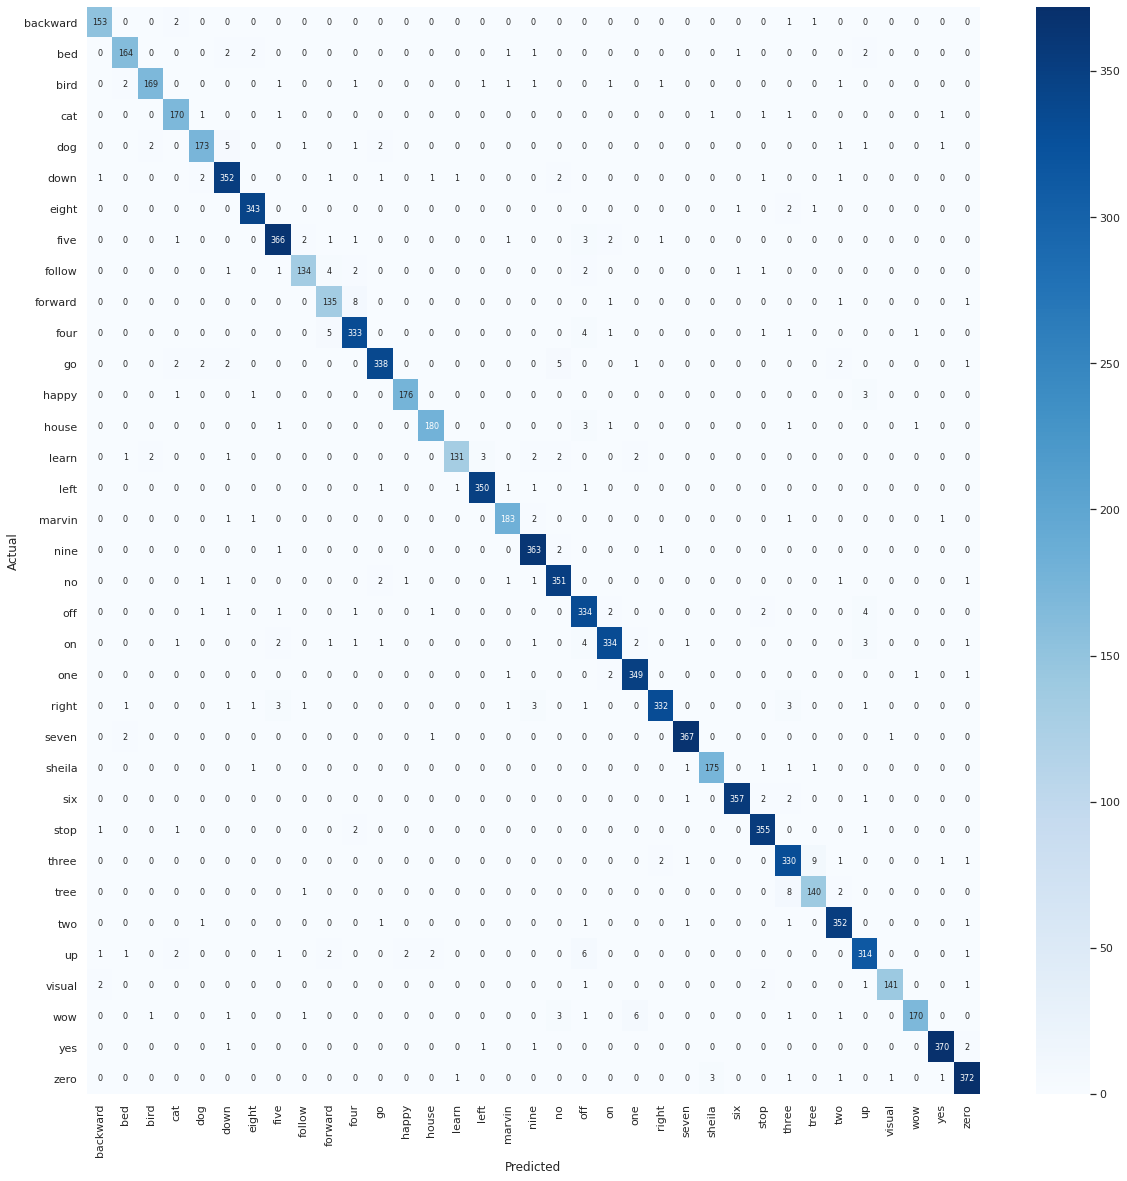

In [43]:
df_cm = pd.DataFrame(cm, columns=np.unique(labels_test_label), index = np.unique(labels_test_label))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (20,20))
sn.set(font_scale=1)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, fmt='g',annot_kws={"size": 8})# font size


In [41]:
sess.close()